In [1]:
import os
import copy
import time
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import time
import argparse
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
from torchvision.datasets import MNIST, EMNIST
import torch.nn.functional as F
from matplotlib.pyplot import subplots
from torchvision.utils import save_image
import torch.optim as optim
from tensorboardX import SummaryWriter
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
bs = 100
n_epoch = 50
dim=100
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#writer = SummaryWriter(os.path.join('../gan', 'ok3'))
writer = SummaryWriter(os.path.join('../lra', 'zoo_tanh'))
gpu = 1
device = 1

In [2]:
def test_inference(net, testloader):
    """ Returns the test accuracy and loss.
    """
    net.eval()
    loss, total, correct = 0.0, 0.0, 0.0
    criterion = nn.CrossEntropyLoss()
    criterion.cuda(gpu)
    mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.cuda(gpu), labels.cuda(gpu)
            
            # Inference
            outputs = net(images)
            batch_loss = criterion(outputs, labels)
            loss += copy.deepcopy(batch_loss.item())

            # Prediction
            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
    accuracy = correct/total
    return accuracy, loss

def test_error(model, steal_model, testloader):
    model.eval()
    steal_model.eval()
    loss, total, correct = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.cuda(gpu), labels.cuda(gpu)

            # Inference
            outputs0 = model(images)
            outputs1 = steal_model(images)
            
            # Prediction
            _, pred_labels0 = torch.max(outputs0, 1)
            pred_labels0 = pred_labels0.view(-1)
            
            _, pred_labels1 = torch.max(outputs1, 1)
            pred_labels1 = pred_labels1.view(-1)
            
            correct += torch.sum(torch.eq(pred_labels0, pred_labels1)).item()
            total += len(labels)
    accuracy = correct/total
    return accuracy


def stat_num(model, steal_model, testloader):
    model.eval()
    steal_model.eval()
    loss, total, correct = 0.0, 0.0, 0.0
    l2n = {i: 0 for i in range(11)}
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.cuda(gpu), labels.cuda(gpu)

            # Inference
            outputs0 = model(images)
            outputs1 = steal_model(images)
            
            # Prediction
            _, pred_labels0 = torch.max(outputs0, 1)
            pred_labels0 = pred_labels0.view(-1)
            
            _, pred_labels1 = torch.max(outputs1, 1)
            pred_labels1 = pred_labels1.view(-1)
            
            list0 = pred_labels0.cpu().numpy().tolist()
            list1 = pred_labels1.cpu().numpy().tolist()
            for i in range(len(list0)):
                if list0[i] == list1[i]:
                    l2n[list0[i]] += 1
    for k, v in l2n.items():
        print(f"Label {k}: {v}")

class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=11):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_


class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])
#../data
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [4]:
labels = train_dataset.train_labels
indices0,indices1 = [], []
for i in range(0, 10):
    indices0 += (labels == i).nonzero().view(-1).tolist()
for i in range(5, 10):
    indices1 += (labels == i).nonzero().view(-1).tolist()
localset0, localset1 = Subset(train_dataset, indices0), Subset(train_dataset, indices1)
dataloader0, dataloader1 =DataLoader(localset0, batch_size=bs,shuffle=True), DataLoader(localset1, batch_size=bs,shuffle=True)

/home/xdy/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator().to(gpu)
D = Discriminator().to(gpu)
criterion = nn.CrossEntropyLoss().to(gpu)
mse_criterion = nn.MSELoss().to(gpu)
mae_criterion = nn.L1Loss().to(gpu)
kl_criterion = nn.KLDivLoss(reduction='batchmean').to(gpu)
# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

/home/xdy/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [6]:
def zoo(D, x_fake, y_fake):
    grad_est = torch.zeros_like(x_fake).to(gpu)
    #reduction='none'
    criterion = nn.CrossEntropyLoss().cuda(gpu)
    m = 20
    epsilon = 0.1
    N = x_fake.size(0)
    C = x_fake.size(1)
    S = x_fake.size(2)
    d = S**2 * C
    
    lossG_target = criterion(D(torch.tanh(x_fake)),y_fake)
    
    for i in range(m):
        u = torch.randn(x_fake.size()).cuda(gpu)
        u_flat = u.view([N, -1])
        u_norm = u / torch.norm(u_flat, dim=1).view([-1, 1, 1, 1])
        x_mod_pre = x_fake + (epsilon * u_norm)
        Tout = D(torch.tanh(x_mod_pre))
        
        lossG_target_mod = criterion(Tout, y_fake)
        grad_est += (
                (d / m) * (lossG_target_mod - lossG_target) / epsilon
            ).view([-1, 1, 1, 1]) * u_norm
        
    grad_est /= N
    #return grad_est
    grad_est_flat = grad_est.view([N, -1])
    x_det_pre = x_fake.detach()
    x_det_pre.requires_grad = True
    x_det_pre.retain_grad()
    Tout = D(torch.tanh(x_det_pre))
    lossG_det = criterion(Tout, y_fake)
    lossG_det.backward()
    grad_true_flat = x_det_pre.grad.view([N, -1])

    cos = nn.CosineSimilarity(dim=1)
    cs = cos(grad_true_flat, grad_est_flat)
    mag_ratio = grad_est_flat.norm(2, dim=1) / grad_true_flat.norm(2, dim=1)
    lossG = lossG_det.detach()
    return lossG.mean(), cs.mean(), mag_ratio.mean(), grad_est


In [ ]:
class FakeData(Dataset):
    def __init__(self):
        super(FakeData, self).__init__()
        count = 25000
        self.x = []
        self.y = []
        for i in range(count):
            self.x.append(Variable(torch.randn(z_dim)))
            self.y.append(Variable(torch.zeros(1).fill_(10).long()))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


epochs = 400
local_ep = 1
D.train()
G.train()
for epoch in range(epochs):
    for e in range(local_ep):
        for pri_x, pri_y in dataloader0:
            pri_x, pri_y = pri_x.to(gpu), pri_y.to(gpu)
            D.zero_grad()
            pri_logit = D(pri_x)
            loss = criterion(pri_logit, pri_y)
            loss.backward()
            D_optimizer.step()
    acc, _ = test_inference(D, test_loader)
    print(f"Epoch: {epoch} | Local Epoch: {e}: Loss: {loss.item()}, Acc: {acc}")
    
    fakedataset = FakeData()
    fakedataloader = DataLoader(fakedataset, batch_size=bs,shuffle=False)
    
    for fake_x, fake_y in fakedataloader:
        fake_x, fake_y = fake_x.to(gpu), fake_y.view(-1).to(gpu)
        G.zero_grad()
        G_output = G(fake_x)
        temp_fake = copy.deepcopy(fake_y).fill_(0)
        loss_g, cs, mag_ratio, estimate_grad = zoo(D, G_output, temp_fake)
        print(f"loss_g: {loss_g.item()} | cs: {cs.item()} | mag_ratio: {mag_ratio.item()}")
        G_output.backward(estimate_grad)
        G_optimizer.step()
    for fake_x, fake_y in fakedataloader:
        fake_x, fake_y = fake_x.to(gpu), fake_y.view(-1).to(gpu)
        D.zero_grad()
        G_output = G(fake_x)
        pub_logit = D(torch.tanh(G_output))
        #pub_logit = D(G_output)
        loss_d = criterion(pub_logit, fake_y)
        loss_d.backward()
        print(f"loss_d: {loss_d.item()}")
        D_optimizer.step()
    with torch.no_grad():
        test_z = Variable(torch.randn(50, z_dim).to(device))
        generated = G(test_z)
        #out0grid = torchvision.utils.make_grid(generated.view(generated.size(0), 1, 28, 28), nrow=50)
        out0grid = torchvision.utils.make_grid(generated, nrow=50)
        writer.add_image('images', out0grid, epoch)
        
writer.close()

Epoch: 0 | Local Epoch: 0: Loss: 0.32365119457244873, Acc: 0.942
loss_g: 31.41388702392578 | cs: 0.016896989196538925 | mag_ratio: 0.6301356554031372
loss_g: 29.309541702270508 | cs: 0.017888085916638374 | mag_ratio: 0.7875351309776306
loss_g: 27.579063415527344 | cs: 0.01787484996020794 | mag_ratio: 0.7053561210632324
loss_g: 26.4212646484375 | cs: 0.014255668967962265 | mag_ratio: 0.6042270660400391
loss_g: 25.593774795532227 | cs: 0.01678377203643322 | mag_ratio: 0.6329392194747925
loss_g: 24.609315872192383 | cs: 0.012031815946102142 | mag_ratio: 0.6257480382919312
loss_g: 23.638320922851562 | cs: 0.020650368183851242 | mag_ratio: 0.7879758477210999
loss_g: 22.638975143432617 | cs: 0.015732044354081154 | mag_ratio: 0.6457145810127258
loss_g: 21.602235794067383 | cs: 0.01638009585440159 | mag_ratio: 0.5771983861923218
loss_g: 20.399198532104492 | cs: 0.014463024213910103 | mag_ratio: 0.6642661094665527
loss_g: 19.278644561767578 | cs: 0.012106034904718399 | mag_ratio: 0.732430994510

loss_g: 3.3182883262634277 | cs: 0.015472630970180035 | mag_ratio: 0.9316195249557495
loss_g: 2.7248694896698 | cs: 0.012524791993200779 | mag_ratio: 0.7777518033981323
loss_g: 2.495572090148926 | cs: 0.010805947706103325 | mag_ratio: 0.8549156785011292
loss_g: 2.5295989513397217 | cs: 0.013438168913125992 | mag_ratio: 0.8170081973075867
loss_g: 2.4697153568267822 | cs: 0.015320119448006153 | mag_ratio: 0.8942643404006958
loss_g: 2.4935970306396484 | cs: 0.010414405725896358 | mag_ratio: 0.7264647483825684
loss_g: 2.5126097202301025 | cs: 0.011233432218432426 | mag_ratio: 0.7350124716758728
loss_g: 2.4875235557556152 | cs: 0.015820957720279694 | mag_ratio: 0.7062264680862427
loss_g: 2.4548144340515137 | cs: 0.01732253096997738 | mag_ratio: 1.0392431020736694
loss_g: 2.437636137008667 | cs: 0.011407479643821716 | mag_ratio: 0.8939993381500244
loss_g: 2.4619176387786865 | cs: 0.005817133467644453 | mag_ratio: 0.7954559326171875
loss_g: 2.490952491760254 | cs: 0.006331003736704588 | mag_r

loss_g: 0.4320736825466156 | cs: 0.008642826229333878 | mag_ratio: 0.8371904492378235
loss_g: 0.4237002432346344 | cs: 0.007732884027063847 | mag_ratio: 0.7813963890075684
loss_g: 0.43464815616607666 | cs: 0.009205291047692299 | mag_ratio: 0.7278883457183838
loss_g: 0.4200107157230377 | cs: 0.011392270214855671 | mag_ratio: 0.922554612159729
loss_g: 0.4328407049179077 | cs: 0.01466989703476429 | mag_ratio: 1.0038491487503052
loss_g: 0.4374704658985138 | cs: 0.012481527402997017 | mag_ratio: 0.7494306564331055
loss_g: 0.44033879041671753 | cs: 0.012454097159206867 | mag_ratio: 0.8850394487380981
loss_g: 0.45585042238235474 | cs: 0.011584351770579815 | mag_ratio: 0.8396252989768982
loss_g: 0.44829750061035156 | cs: 0.011999852024018764 | mag_ratio: 0.8230626583099365
loss_g: 0.4366593062877655 | cs: 0.008048462681472301 | mag_ratio: 0.6262315511703491
loss_g: 0.40857386589050293 | cs: 0.00841218326240778 | mag_ratio: 0.6652504801750183
loss_g: 0.39515408873558044 | cs: 0.0069079422391951

loss_g: 52.3132209777832 | cs: 0.008525826968252659 | mag_ratio: 0.6522299647331238
loss_g: 52.235782623291016 | cs: 0.013061737641692162 | mag_ratio: 0.6064830422401428
loss_g: 52.17045974731445 | cs: 0.01818132773041725 | mag_ratio: 0.8835189342498779
loss_g: 52.16425704956055 | cs: 0.014610931277275085 | mag_ratio: 0.609944224357605
loss_g: 52.195823669433594 | cs: 0.012496205046772957 | mag_ratio: 0.621648907661438
loss_g: 52.17612838745117 | cs: 0.01106980536133051 | mag_ratio: 0.5657163262367249
loss_g: 52.154598236083984 | cs: 0.011419125832617283 | mag_ratio: 0.5911099910736084
loss_g: 52.12092590332031 | cs: 0.011806090362370014 | mag_ratio: 0.6812952160835266
loss_g: 52.10175704956055 | cs: 0.01469751913100481 | mag_ratio: 0.6158932447433472
loss_g: 52.089073181152344 | cs: 0.012290572747588158 | mag_ratio: 0.6730722188949585
loss_g: 52.075645446777344 | cs: 0.011857476085424423 | mag_ratio: 0.6993261575698853
loss_g: 52.05711364746094 | cs: 0.011316325515508652 | mag_ratio: 

loss_g: 27.729345321655273 | cs: 0.020177340134978294 | mag_ratio: 0.9023392200469971
loss_g: 27.568567276000977 | cs: 0.014893346466124058 | mag_ratio: 0.5648747682571411
loss_g: 27.54065704345703 | cs: 0.016020888462662697 | mag_ratio: 0.8132461905479431
loss_g: 27.52326202392578 | cs: 0.013096085749566555 | mag_ratio: 0.6785019040107727
loss_g: 27.498863220214844 | cs: 0.018155790865421295 | mag_ratio: 0.8591639399528503
loss_g: 27.369962692260742 | cs: 0.010353345423936844 | mag_ratio: 0.549993097782135
loss_g: 27.196054458618164 | cs: 0.017944516614079475 | mag_ratio: 0.7575122117996216
loss_g: 26.856956481933594 | cs: 0.012038277462124825 | mag_ratio: 0.685573399066925
loss_g: 26.702896118164062 | cs: 0.014611813239753246 | mag_ratio: 0.768957257270813
loss_g: 26.588668823242188 | cs: 0.01657935045659542 | mag_ratio: 0.9590334892272949
loss_g: 26.524038314819336 | cs: 0.015164525248110294 | mag_ratio: 0.7667666673660278
loss_g: 26.49152183532715 | cs: 0.013890864327549934 | mag_r

loss_g: 23.56366539001465 | cs: 0.008294197730720043 | mag_ratio: 0.7096892595291138
loss_g: 23.625898361206055 | cs: 0.00660667521879077 | mag_ratio: 0.8787106871604919
loss_g: 23.635902404785156 | cs: 0.009561429731547832 | mag_ratio: 1.0496761798858643
loss_g: 23.646875381469727 | cs: 0.007286356296390295 | mag_ratio: 1.314049482345581
loss_g: 23.63223648071289 | cs: 0.004641368985176086 | mag_ratio: 0.8835690021514893
loss_g: 23.620851516723633 | cs: 0.01320606004446745 | mag_ratio: 0.8666409254074097
loss_g: 23.600967407226562 | cs: 0.007356833200901747 | mag_ratio: 1.1340224742889404
loss_g: 23.579933166503906 | cs: 0.004722041543573141 | mag_ratio: 1.336978554725647
loss_g: 23.57064437866211 | cs: 0.01537366583943367 | mag_ratio: 1.1702784299850464
loss_g: 23.559864044189453 | cs: 0.006101891398429871 | mag_ratio: 1.0862188339233398
loss_g: 23.540512084960938 | cs: 0.0139505285769701 | mag_ratio: 1.5305883884429932
loss_g: 23.58932113647461 | cs: 0.002304073888808489 | mag_ratio

loss_g: 127.58641815185547 | cs: 0.009638357907533646 | mag_ratio: 0.9946109056472778
loss_g: 127.58123016357422 | cs: 0.00988679938018322 | mag_ratio: 0.6199295520782471
loss_g: 127.57870483398438 | cs: 0.00974885281175375 | mag_ratio: 0.6948927044868469
loss_g: 127.58014678955078 | cs: 0.010956987738609314 | mag_ratio: 0.9869033694267273
loss_g: 127.58171081542969 | cs: 0.01833866722881794 | mag_ratio: 0.9323635697364807
loss_g: 127.58027648925781 | cs: 0.014120221138000488 | mag_ratio: 0.9674360156059265
loss_g: 127.58273315429688 | cs: 0.015507809817790985 | mag_ratio: 0.8761680126190186
loss_g: 127.58346557617188 | cs: 0.01581142097711563 | mag_ratio: 0.5725131630897522
loss_g: 127.58687591552734 | cs: 0.01385574322193861 | mag_ratio: 0.8540143966674805
loss_g: 127.58953094482422 | cs: 0.015446115285158157 | mag_ratio: 0.8469407558441162
loss_g: 127.58265686035156 | cs: 0.011919379234313965 | mag_ratio: 0.7111808657646179
loss_g: 127.57567596435547 | cs: 0.01597268134355545 | mag_

loss_g: 53.490013122558594 | cs: 0.012558040209114552 | mag_ratio: 0.5996941328048706
loss_g: 52.40949630737305 | cs: 0.020930293947458267 | mag_ratio: 0.8776084184646606
loss_g: 52.128719329833984 | cs: 0.018482595682144165 | mag_ratio: 0.7310740351676941
loss_g: 51.79867172241211 | cs: 0.012224869802594185 | mag_ratio: 0.5364338755607605
loss_g: 51.33683776855469 | cs: 0.008828503079712391 | mag_ratio: 0.4754738509654999
loss_g: 50.805606842041016 | cs: 0.020045442506670952 | mag_ratio: 0.8214234709739685
loss_g: 48.469364166259766 | cs: 0.014786782674491405 | mag_ratio: 0.6202665567398071
loss_g: 46.74070739746094 | cs: 0.009551044553518295 | mag_ratio: 0.527434229850769
loss_g: 45.06284713745117 | cs: 0.012227770872414112 | mag_ratio: 0.5896705389022827
loss_g: 43.14402770996094 | cs: 0.022390270605683327 | mag_ratio: 0.8970584869384766
loss_g: 41.17531204223633 | cs: 0.023083362728357315 | mag_ratio: 0.916692316532135
loss_g: 39.117469787597656 | cs: 0.010351479984819889 | mag_rat

loss_g: 16.634700775146484 | cs: 0.008542897179722786 | mag_ratio: 0.5594096183776855
loss_g: 16.63136100769043 | cs: 0.006357153411954641 | mag_ratio: 0.6938436627388
loss_g: 16.63159942626953 | cs: 0.01175303477793932 | mag_ratio: 0.9441936016082764
loss_g: 16.631938934326172 | cs: 0.011933200061321259 | mag_ratio: 0.7680952548980713
loss_g: 16.627254486083984 | cs: 0.010958989150822163 | mag_ratio: 0.7203238606452942
loss_g: 16.625696182250977 | cs: 0.007717631757259369 | mag_ratio: 0.5165898203849792
loss_g: 16.616947174072266 | cs: 0.008809749037027359 | mag_ratio: 0.5884964466094971
loss_g: 16.610231399536133 | cs: 0.01533426996320486 | mag_ratio: 0.695350170135498
loss_g: 16.603694915771484 | cs: 0.013163234107196331 | mag_ratio: 0.6040821671485901
loss_g: 16.604379653930664 | cs: 0.016342153772711754 | mag_ratio: 0.8774000406265259
loss_g: 16.61188507080078 | cs: 0.014298014342784882 | mag_ratio: 0.699023425579071
loss_g: 16.61666488647461 | cs: 0.010685078799724579 | mag_ratio

loss_g: 107.04888916015625 | cs: 0.012461032718420029 | mag_ratio: 0.5739932656288147
loss_g: 107.00006103515625 | cs: 0.014152524061501026 | mag_ratio: 0.6691718101501465
loss_g: 106.96685791015625 | cs: 0.010427525267004967 | mag_ratio: 0.663470983505249
loss_g: 106.89505004882812 | cs: 0.012143183499574661 | mag_ratio: 0.5945220589637756
loss_g: 106.82044219970703 | cs: 0.013914195820689201 | mag_ratio: 0.6566552519798279
loss_g: 106.70465850830078 | cs: 0.013940117321908474 | mag_ratio: 0.6420904994010925
loss_g: 106.41127014160156 | cs: 0.010430090129375458 | mag_ratio: 0.6291770935058594
loss_g: 105.90894317626953 | cs: 0.00531116733327508 | mag_ratio: 0.6401406526565552
loss_g: 106.14788055419922 | cs: 0.01351065095514059 | mag_ratio: 0.6688158512115479
loss_g: 106.09370422363281 | cs: 0.011683676391839981 | mag_ratio: 0.6468594074249268
loss_g: 106.29873657226562 | cs: 0.0197066031396389 | mag_ratio: 0.8410283327102661
loss_g: 106.3338851928711 | cs: 0.017771266400814056 | mag_

loss_g: 69.9596176147461 | cs: 0.0205500740557909 | mag_ratio: 0.9523921012878418
loss_g: 69.8362808227539 | cs: 0.011959035880863667 | mag_ratio: 0.5872799158096313
loss_g: 69.6988296508789 | cs: 0.010110256262123585 | mag_ratio: 0.45553794503211975
loss_g: 69.3334732055664 | cs: 0.01755227893590927 | mag_ratio: 0.8732340931892395
loss_g: 68.16357421875 | cs: 0.010503227822482586 | mag_ratio: 0.6159496307373047
loss_g: 67.94530487060547 | cs: 0.008244980126619339 | mag_ratio: 0.6204606294631958
loss_g: 67.90493774414062 | cs: 0.012927294708788395 | mag_ratio: 0.5909590125083923
loss_g: 67.88179016113281 | cs: 0.014253518544137478 | mag_ratio: 0.585176408290863
loss_g: 67.81497192382812 | cs: 0.013541221618652344 | mag_ratio: 0.5554149150848389
loss_g: 67.73153686523438 | cs: 0.016836097463965416 | mag_ratio: 0.8319805860519409
loss_g: 67.55010223388672 | cs: 0.008707793429493904 | mag_ratio: 0.442144513130188
loss_g: 67.19573211669922 | cs: 0.013540582731366158 | mag_ratio: 0.65988659

loss_g: 29.572528839111328 | cs: 0.01274934969842434 | mag_ratio: 0.606467604637146
loss_g: 29.504159927368164 | cs: 0.011976965703070164 | mag_ratio: 0.5021054148674011
loss_g: 29.30066680908203 | cs: 0.010762329213321209 | mag_ratio: 0.3937460482120514
loss_g: 29.111772537231445 | cs: 0.015053363516926765 | mag_ratio: 0.6484026908874512
loss_g: 28.752378463745117 | cs: 0.02122165635228157 | mag_ratio: 0.8169992566108704
loss_g: 28.28644371032715 | cs: 0.012501368299126625 | mag_ratio: 0.5530322790145874
loss_g: 28.33038330078125 | cs: 0.014792337082326412 | mag_ratio: 0.8198450803756714
loss_g: 27.531963348388672 | cs: 0.01591506041586399 | mag_ratio: 0.7857848405838013
loss_g: 27.07988739013672 | cs: 0.01726933941245079 | mag_ratio: 0.8724905848503113
loss_g: 26.859872817993164 | cs: 0.011628529988229275 | mag_ratio: 0.5910921096801758
loss_g: 26.719589233398438 | cs: 0.0157732255756855 | mag_ratio: 0.6632217764854431
loss_g: 26.528871536254883 | cs: 0.008510459214448929 | mag_ratio

loss_g: 61.666786193847656 | cs: 0.014724097214639187 | mag_ratio: 0.6482961773872375
loss_g: 61.332271575927734 | cs: 0.010452828370034695 | mag_ratio: 0.6050386428833008
loss_g: 61.178443908691406 | cs: 0.00924768391996622 | mag_ratio: 0.501953125
loss_g: 61.02724075317383 | cs: 0.019084664061665535 | mag_ratio: 0.9788574576377869
loss_g: 60.741546630859375 | cs: 0.014594491571187973 | mag_ratio: 0.7802399396896362
loss_g: 60.31220626831055 | cs: 0.009950469247996807 | mag_ratio: 0.6838333010673523
loss_g: 59.97100067138672 | cs: 0.012411643750965595 | mag_ratio: 0.7221503853797913
loss_g: 59.58818817138672 | cs: 0.011725540272891521 | mag_ratio: 0.5138789415359497
loss_g: 59.33372497558594 | cs: 0.020325329154729843 | mag_ratio: 1.0209829807281494
loss_g: 59.173370361328125 | cs: 0.01613437570631504 | mag_ratio: 0.6223686933517456
loss_g: 59.08698272705078 | cs: 0.009474284015595913 | mag_ratio: 0.5156382322311401
loss_g: 59.03620910644531 | cs: 0.01880686543881893 | mag_ratio: 0.92

loss_g: 41.39109420776367 | cs: 0.013143829070031643 | mag_ratio: 0.6035416126251221
loss_g: 41.316436767578125 | cs: 0.012222085148096085 | mag_ratio: 0.5257358551025391
loss_g: 41.19930648803711 | cs: 0.016537945717573166 | mag_ratio: 0.745115339756012
loss_g: 40.967079162597656 | cs: 0.012580301612615585 | mag_ratio: 1.064732313156128
loss_g: 40.78813552856445 | cs: 0.015681669116020203 | mag_ratio: 0.6454137563705444
loss_g: 40.608428955078125 | cs: 0.011876744218170643 | mag_ratio: 0.7295304536819458
loss_g: 40.529937744140625 | cs: 0.010091712698340416 | mag_ratio: 0.9186500310897827
loss_g: 40.501800537109375 | cs: 0.016607606783509254 | mag_ratio: 1.1548709869384766
loss_g: 40.432640075683594 | cs: 0.014447310008108616 | mag_ratio: 0.6170758008956909
loss_g: 40.44794845581055 | cs: 0.011541527695953846 | mag_ratio: 0.8088690638542175
loss_g: 40.422454833984375 | cs: 0.011875399388372898 | mag_ratio: 0.756434977054596
loss_g: 40.48475646972656 | cs: 0.017052633687853813 | mag_ra

loss_g: 40.34718322753906 | cs: 0.011707192286849022 | mag_ratio: 0.9177753329277039
loss_g: 40.53067398071289 | cs: 0.013382550328969955 | mag_ratio: 1.2181462049484253
loss_g: 40.590484619140625 | cs: 0.015522697940468788 | mag_ratio: 0.7829443216323853
loss_g: 40.61293029785156 | cs: 0.010528960265219212 | mag_ratio: 1.0097063779830933
loss_g: 40.618106842041016 | cs: 0.010249368846416473 | mag_ratio: 1.1700339317321777
loss_g: 40.6182861328125 | cs: 0.009508684277534485 | mag_ratio: 1.2620209455490112
loss_g: 40.628761291503906 | cs: 0.006370312534272671 | mag_ratio: 1.2922033071517944
loss_g: 40.63266372680664 | cs: 0.014082031324505806 | mag_ratio: 0.8489127159118652
loss_g: 40.637855529785156 | cs: 0.010204089805483818 | mag_ratio: 0.5114490985870361
loss_g: 40.64115524291992 | cs: 0.012038602493703365 | mag_ratio: 0.9893966317176819
loss_g: 40.639583587646484 | cs: 0.011276203207671642 | mag_ratio: 0.9631879925727844
loss_g: 40.64115905761719 | cs: 0.011188125237822533 | mag_ra

loss_g: 36.152931213378906 | cs: 0.016230661422014236 | mag_ratio: 0.6923603415489197
loss_g: 36.13325500488281 | cs: 0.011178090237081051 | mag_ratio: 0.6306913495063782
loss_g: 36.10035705566406 | cs: 0.016099734231829643 | mag_ratio: 0.663399875164032
loss_g: 36.072818756103516 | cs: 0.013584130443632603 | mag_ratio: 0.5808644890785217
loss_g: 35.97885513305664 | cs: 0.010585185140371323 | mag_ratio: 1.048171043395996
loss_g: 35.979087829589844 | cs: 0.016247304156422615 | mag_ratio: 0.8562906980514526
loss_g: 35.97722244262695 | cs: 0.010798272676765919 | mag_ratio: 0.767606794834137
loss_g: 35.847843170166016 | cs: 0.0030336512718349695 | mag_ratio: 0.6660519242286682
loss_g: 35.7169075012207 | cs: 0.01544835977256298 | mag_ratio: 0.780478298664093
loss_g: 35.66128921508789 | cs: 0.012517041526734829 | mag_ratio: 0.7010068893432617
loss_g: 35.63621139526367 | cs: 0.008343443274497986 | mag_ratio: 1.0028280019760132
loss_g: 35.69935607910156 | cs: 0.009705660864710808 | mag_ratio: 

loss_g: 35.03879165649414 | cs: 0.008880376815795898 | mag_ratio: 0.7656629681587219
loss_g: 35.017982482910156 | cs: 0.007723805960267782 | mag_ratio: 1.217455267906189
loss_g: 34.99134826660156 | cs: 0.010420411825180054 | mag_ratio: 0.9422338604927063
loss_g: 34.96094512939453 | cs: 0.004742146003991365 | mag_ratio: 1.0343585014343262
loss_g: 34.92801284790039 | cs: 0.005504189524799585 | mag_ratio: 1.2320005893707275
loss_g: 34.8964958190918 | cs: 0.015040581114590168 | mag_ratio: 0.7675078511238098
loss_g: 34.882659912109375 | cs: 0.003621669951826334 | mag_ratio: 1.176056146621704
loss_g: 34.869991302490234 | cs: 0.008784298785030842 | mag_ratio: 1.076450228691101
loss_g: 34.86082458496094 | cs: 0.011001233011484146 | mag_ratio: 1.6311020851135254
loss_g: 34.85651779174805 | cs: 0.006944534834474325 | mag_ratio: 1.5353124141693115
loss_g: 34.85719299316406 | cs: 0.005411356687545776 | mag_ratio: 1.363547921180725
loss_g: 34.855594635009766 | cs: 0.011551184579730034 | mag_ratio: 

loss_g: 34.33042907714844 | cs: 0.017321040853857994 | mag_ratio: 0.7891808152198792
loss_g: 34.329586029052734 | cs: 0.012882612645626068 | mag_ratio: 0.702734649181366
loss_g: 34.328643798828125 | cs: 0.01841663382947445 | mag_ratio: 0.9023321270942688
loss_g: 34.32722473144531 | cs: 0.007157930638641119 | mag_ratio: 0.8952326774597168
loss_g: 34.323280334472656 | cs: 0.011034991592168808 | mag_ratio: 1.1066409349441528
loss_g: 34.320831298828125 | cs: 0.011677389033138752 | mag_ratio: 1.0366429090499878
loss_g: 34.31245803833008 | cs: 0.008965134620666504 | mag_ratio: 0.6751673221588135
loss_g: 34.30518341064453 | cs: 0.009583745151758194 | mag_ratio: 0.6774781942367554
loss_g: 34.29642105102539 | cs: 0.0012590804835781455 | mag_ratio: 1.1505194902420044
loss_g: 34.28981399536133 | cs: 0.004743535071611404 | mag_ratio: 1.2060587406158447
loss_g: 34.2867317199707 | cs: 0.01529534999281168 | mag_ratio: 0.8875739574432373
loss_g: 34.278499603271484 | cs: 0.010554947890341282 | mag_rati

loss_g: 41.93561935424805 | cs: 0.012862201780080795 | mag_ratio: 0.6011911630630493
loss_g: 41.90559387207031 | cs: 0.01304919458925724 | mag_ratio: 0.5734016299247742
loss_g: 41.87766647338867 | cs: 0.011296520009636879 | mag_ratio: 0.42669615149497986
loss_g: 41.86174774169922 | cs: 0.015982765704393387 | mag_ratio: 0.8246472477912903
loss_g: 41.838314056396484 | cs: 0.014294984750449657 | mag_ratio: 0.6434215903282166
loss_g: 41.81462097167969 | cs: 0.01342176552861929 | mag_ratio: 0.572128176689148
loss_g: 41.79424285888672 | cs: 0.01694144867360592 | mag_ratio: 0.7035412192344666
loss_g: 41.77254867553711 | cs: 0.015119648538529873 | mag_ratio: 0.7374261021614075
loss_g: 41.735469818115234 | cs: 0.015490206889808178 | mag_ratio: 0.7234669923782349
loss_g: 41.73948287963867 | cs: 0.01471772976219654 | mag_ratio: 0.663803219795227
loss_g: 41.77471160888672 | cs: 0.018284576013684273 | mag_ratio: 0.8678314089775085
loss_g: 41.7537727355957 | cs: 0.006695264484733343 | mag_ratio: 1.1

loss_g: 41.8379020690918 | cs: 0.011906055733561516 | mag_ratio: 0.5385103821754456
loss_g: 41.858577728271484 | cs: 0.012501138262450695 | mag_ratio: 0.6492781043052673
loss_g: 41.874534606933594 | cs: 0.011259033344686031 | mag_ratio: 0.5662276148796082
loss_g: 41.87965393066406 | cs: 0.013238520361483097 | mag_ratio: 0.49087417125701904
loss_g: 41.857295989990234 | cs: 0.010310799814760685 | mag_ratio: 0.4928753674030304
loss_g: 41.856903076171875 | cs: 0.015632228925824165 | mag_ratio: 0.7051302194595337
loss_g: 41.840335845947266 | cs: 0.015194286592304707 | mag_ratio: 0.7092838287353516
loss_g: 41.818267822265625 | cs: 0.012963738292455673 | mag_ratio: 0.6793795824050903
loss_g: 41.7879753112793 | cs: 0.01310992706567049 | mag_ratio: 0.6987780332565308
loss_g: 41.819725036621094 | cs: 0.019644461572170258 | mag_ratio: 0.8001881241798401
loss_g: 41.76994705200195 | cs: 0.015169672667980194 | mag_ratio: 0.7986510992050171
loss_g: 41.721519470214844 | cs: 0.010474602691829205 | mag_

loss_g: 41.614803314208984 | cs: 0.011523188091814518 | mag_ratio: 0.5796362161636353
loss_g: 41.62315368652344 | cs: 0.01242071483284235 | mag_ratio: 0.5507046580314636
loss_g: 41.635704040527344 | cs: 0.013972708024084568 | mag_ratio: 0.8066743016242981
loss_g: 41.658512115478516 | cs: 0.018682701513171196 | mag_ratio: 0.7445911169052124
loss_g: 41.6700325012207 | cs: 0.013690631836652756 | mag_ratio: 0.6663331389427185
loss_g: 41.684906005859375 | cs: 0.014255069196224213 | mag_ratio: 0.6205015182495117
loss_g: 41.6898307800293 | cs: 0.01498187705874443 | mag_ratio: 0.7445263266563416
loss_g: 41.687862396240234 | cs: 0.012528270483016968 | mag_ratio: 0.59071284532547
loss_g: 41.68598937988281 | cs: 0.01978270336985588 | mag_ratio: 0.7729427814483643
loss_g: 41.76060485839844 | cs: 0.01187156606465578 | mag_ratio: 0.9547140002250671
loss_g: 42.03813552856445 | cs: 0.012908069416880608 | mag_ratio: 0.915328323841095
loss_g: 42.639957427978516 | cs: 0.01527490746229887 | mag_ratio: 0.5

loss_g: 40.99863815307617 | cs: 0.013542844913899899 | mag_ratio: 1.0530445575714111
loss_g: 41.01560592651367 | cs: 0.008928264491260052 | mag_ratio: 1.4347032308578491
loss_g: 41.02519226074219 | cs: 0.01279218029230833 | mag_ratio: 1.1983457803726196
loss_g: 41.0380744934082 | cs: 0.009918898344039917 | mag_ratio: 1.2215327024459839
loss_g: 41.04352951049805 | cs: 0.0031657712534070015 | mag_ratio: 1.1946029663085938
loss_g: 41.0438117980957 | cs: 0.009250705130398273 | mag_ratio: 1.5607571601867676
loss_g: 41.046836853027344 | cs: 0.008321268483996391 | mag_ratio: 0.8748339414596558
loss_g: 41.048343658447266 | cs: 0.010893416590988636 | mag_ratio: 0.8392135500907898
loss_g: 41.05024337768555 | cs: 0.013498976826667786 | mag_ratio: 0.8428418636322021
loss_g: 41.050148010253906 | cs: 0.013416597619652748 | mag_ratio: 0.8781295418739319
loss_g: 41.050933837890625 | cs: 0.012200300581753254 | mag_ratio: 0.6262279152870178
loss_g: 41.05366516113281 | cs: 0.012403540313243866 | mag_rati

loss_g: 40.633872985839844 | cs: 0.01371704787015915 | mag_ratio: 0.6689996123313904
loss_g: 40.63166809082031 | cs: 0.014980235137045383 | mag_ratio: 0.6087166666984558
loss_g: 40.62859344482422 | cs: 0.014279634691774845 | mag_ratio: 0.7359205484390259
loss_g: 40.627227783203125 | cs: 0.011953194625675678 | mag_ratio: 0.5674583911895752
loss_g: 40.63056564331055 | cs: 0.009639217518270016 | mag_ratio: 0.4828885495662689
loss_g: 40.633705139160156 | cs: 0.012099968269467354 | mag_ratio: 0.7969464063644409
loss_g: 40.64229965209961 | cs: 0.01658046245574951 | mag_ratio: 0.7955924868583679
loss_g: 40.655513763427734 | cs: 0.015550266951322556 | mag_ratio: 0.7450220584869385
loss_g: 40.657447814941406 | cs: 0.012383341789245605 | mag_ratio: 0.5048167109489441
loss_g: 40.660133361816406 | cs: 0.016051538288593292 | mag_ratio: 1.0417118072509766
loss_g: 40.665199279785156 | cs: 0.015329421497881413 | mag_ratio: 0.6884060502052307
loss_g: 40.660667419433594 | cs: 0.01365259662270546 | mag_r

loss_g: 40.65451431274414 | cs: 0.011538363061845303 | mag_ratio: 0.6342148780822754
loss_g: 40.645938873291016 | cs: 0.008213133551180363 | mag_ratio: 0.5778429508209229
loss_g: 40.61653518676758 | cs: 0.014537140727043152 | mag_ratio: 0.7088325619697571
loss_g: 40.55372619628906 | cs: 0.011297648772597313 | mag_ratio: 0.5297852754592896
loss_g: 40.50616455078125 | cs: 0.012262861244380474 | mag_ratio: 0.7149392366409302
loss_g: 40.437252044677734 | cs: 0.019796814769506454 | mag_ratio: 0.7306050062179565
loss_g: 40.241676330566406 | cs: 0.01386734563857317 | mag_ratio: 0.7727964520454407
loss_g: 40.074092864990234 | cs: 0.009095084853470325 | mag_ratio: 0.7455896735191345
loss_g: 40.04549026489258 | cs: 0.014466308988630772 | mag_ratio: 0.9787760972976685
loss_g: 40.04558563232422 | cs: 0.011414970271289349 | mag_ratio: 0.7284538149833679
loss_g: 40.04669952392578 | cs: 0.019467132166028023 | mag_ratio: 0.8031142354011536
loss_g: 40.04658508300781 | cs: 0.010960055515170097 | mag_rat

loss_g: 34.73395538330078 | cs: 0.014897653833031654 | mag_ratio: 0.600439727306366
loss_g: 34.73521041870117 | cs: 0.0167577862739563 | mag_ratio: 0.788641631603241
loss_g: 34.739234924316406 | cs: 0.016219710931181908 | mag_ratio: 0.8233763575553894
loss_g: 34.7435188293457 | cs: 0.013797693885862827 | mag_ratio: 0.6326272487640381
loss_g: 34.74449157714844 | cs: 0.015937982127070427 | mag_ratio: 0.7565332651138306
loss_g: 34.75066375732422 | cs: 0.014791511930525303 | mag_ratio: 0.7958070039749146
loss_g: 34.74416732788086 | cs: 0.013735981658101082 | mag_ratio: 0.6696317791938782
loss_g: 34.75144577026367 | cs: 0.014702658168971539 | mag_ratio: 0.6887447834014893
loss_g: 34.733524322509766 | cs: 0.01443572249263525 | mag_ratio: 0.8797733187675476
loss_g: 34.7284049987793 | cs: 0.009388823062181473 | mag_ratio: 0.6024288535118103
loss_g: 34.72256851196289 | cs: 0.008837484754621983 | mag_ratio: 0.6756194233894348
loss_g: 34.723876953125 | cs: 0.013707556761801243 | mag_ratio: 0.8736

loss_g: 34.054019927978516 | cs: 0.007604706101119518 | mag_ratio: 0.7822068333625793
loss_g: 34.051265716552734 | cs: 0.011836209334433079 | mag_ratio: 0.804979681968689
loss_g: 34.0544548034668 | cs: 0.012530285865068436 | mag_ratio: 0.8098878264427185
loss_g: 34.048728942871094 | cs: 0.016759473830461502 | mag_ratio: 0.8768191337585449
loss_g: 34.050994873046875 | cs: 0.013729539699852467 | mag_ratio: 0.6422447562217712
loss_g: 34.049591064453125 | cs: 0.012401892803609371 | mag_ratio: 0.713344395160675
loss_g: 34.04367446899414 | cs: 0.014899753965437412 | mag_ratio: 0.7149891257286072
loss_g: 34.039024353027344 | cs: 0.011565297842025757 | mag_ratio: 0.5052969455718994
loss_g: 34.03759765625 | cs: 0.011105622164905071 | mag_ratio: 0.6308521628379822
loss_g: 34.026466369628906 | cs: 0.008828348480165005 | mag_ratio: 0.5272545218467712
loss_g: 34.023860931396484 | cs: 0.014303418807685375 | mag_ratio: 0.5463098287582397
loss_g: 34.01866149902344 | cs: 0.010504024103283882 | mag_rati

loss_g: 34.71750259399414 | cs: 0.010425726883113384 | mag_ratio: 2.1531219482421875
loss_g: 34.71940612792969 | cs: 0.001431277603842318 | mag_ratio: 2.0268237590789795
loss_g: 34.72187042236328 | cs: 0.004128292202949524 | mag_ratio: 2.0223019123077393
loss_g: 34.71563720703125 | cs: 0.0005420146626420319 | mag_ratio: 2.1035349369049072
loss_g: 34.70607376098633 | cs: 0.004327715374529362 | mag_ratio: 2.314945697784424
loss_g: 34.69793701171875 | cs: 0.009628275409340858 | mag_ratio: 1.6109765768051147
loss_g: 34.68939208984375 | cs: 0.007390784565359354 | mag_ratio: 1.6249805688858032
loss_g: 34.68519973754883 | cs: 0.003558536758646369 | mag_ratio: 1.759250283241272
loss_g: 34.680545806884766 | cs: 0.0005514094373211265 | mag_ratio: 1.620778203010559
loss_g: 34.678863525390625 | cs: 0.006794760003685951 | mag_ratio: 1.9734083414077759
loss_g: 34.67827606201172 | cs: 0.0019630715250968933 | mag_ratio: 1.6264660358428955
loss_g: 34.675941467285156 | cs: 0.006725424900650978 | mag_rat

loss_g: 36.63627624511719 | cs: 0.011097692884504795 | mag_ratio: 0.5146191120147705
loss_g: 36.63160705566406 | cs: 0.014856447465717793 | mag_ratio: 0.7163310050964355
loss_g: 36.635440826416016 | cs: 0.008310036733746529 | mag_ratio: 0.5774915814399719
loss_g: 36.627220153808594 | cs: 0.016907189041376114 | mag_ratio: 0.7437618970870972
loss_g: 36.61188888549805 | cs: 0.014087896794080734 | mag_ratio: 0.884771466255188
loss_g: 36.54086685180664 | cs: 0.01910976506769657 | mag_ratio: 0.8424776792526245
loss_g: 36.48771667480469 | cs: 0.018594998866319656 | mag_ratio: 0.8220614194869995
loss_g: 36.450191497802734 | cs: 0.012755271978676319 | mag_ratio: 0.6258594989776611
loss_g: 36.428585052490234 | cs: 0.013659321703016758 | mag_ratio: 0.5827797055244446
loss_g: 36.420310974121094 | cs: 0.013044264167547226 | mag_ratio: 0.5536105036735535
loss_g: 36.41205596923828 | cs: 0.01228095032274723 | mag_ratio: 0.657319188117981
loss_g: 36.40861892700195 | cs: 0.017169393599033356 | mag_ratio

loss_g: 36.71067428588867 | cs: 0.021398961544036865 | mag_ratio: 0.9340484142303467
loss_g: 36.66722106933594 | cs: 0.009053116664290428 | mag_ratio: 0.5706223845481873
loss_g: 36.636741638183594 | cs: 0.01421327330172062 | mag_ratio: 0.6204193830490112
loss_g: 36.614505767822266 | cs: 0.012306873686611652 | mag_ratio: 0.6408107876777649
loss_g: 36.597164154052734 | cs: 0.01846693642437458 | mag_ratio: 0.75904780626297
loss_g: 36.58975601196289 | cs: 0.013605579733848572 | mag_ratio: 1.034414529800415
loss_g: 36.58576965332031 | cs: 0.012268920429050922 | mag_ratio: 1.0413111448287964
loss_g: 36.585601806640625 | cs: 0.015193740837275982 | mag_ratio: 0.6420733332633972
loss_g: 36.58539962768555 | cs: 0.011958531104028225 | mag_ratio: 0.8716157078742981
loss_g: 36.58570861816406 | cs: 0.003246546257287264 | mag_ratio: 1.287294626235962
loss_g: 36.58766174316406 | cs: 0.00569169083610177 | mag_ratio: 1.1978927850723267
loss_g: 36.592586517333984 | cs: 0.009077166207134724 | mag_ratio: 0

loss_g: 36.591556549072266 | cs: 0.011007651686668396 | mag_ratio: 1.032882571220398
loss_g: 36.591732025146484 | cs: 0.005776918958872557 | mag_ratio: 0.9030200839042664
loss_g: 36.59130859375 | cs: 0.012442095205187798 | mag_ratio: 1.2079317569732666
loss_g: 36.59075927734375 | cs: 0.006293067708611488 | mag_ratio: 0.6788629293441772
loss_g: 36.59080505371094 | cs: 0.003902417840436101 | mag_ratio: 0.42686736583709717
loss_g: 36.59080505371094 | cs: 0.017027152702212334 | mag_ratio: 0.8077805638313293
loss_g: 36.5908317565918 | cs: 0.010516636073589325 | mag_ratio: 0.44638869166374207
loss_g: 36.58897399902344 | cs: 0.011540000326931477 | mag_ratio: 0.7122408747673035
loss_g: 36.58964538574219 | cs: 0.014366564340889454 | mag_ratio: 0.7880581617355347
loss_g: 36.59003829956055 | cs: 0.009352079592645168 | mag_ratio: 0.7500653862953186
loss_g: 36.588401794433594 | cs: 0.0036810417659580708 | mag_ratio: 0.6910662651062012
loss_g: 36.58750915527344 | cs: 0.011936075054109097 | mag_ratio

loss_g: 40.455291748046875 | cs: 0.011484813876450062 | mag_ratio: 0.5641258358955383
loss_g: 40.59537887573242 | cs: 0.011140122078359127 | mag_ratio: 0.4962993562221527
loss_g: 40.537052154541016 | cs: 0.014319365844130516 | mag_ratio: 0.7368858456611633
loss_g: 40.378868103027344 | cs: 0.009182069450616837 | mag_ratio: 0.6314075589179993
loss_g: 40.23828125 | cs: 0.018109872937202454 | mag_ratio: 0.774912416934967
loss_g: 40.27986526489258 | cs: 0.015619996003806591 | mag_ratio: 0.6671644449234009
loss_g: 40.29178237915039 | cs: 0.009099713526666164 | mag_ratio: 0.8314162492752075
loss_g: 40.2933235168457 | cs: 0.005839632824063301 | mag_ratio: 1.631740689277649
loss_g: 40.29466247558594 | cs: 0.008318960666656494 | mag_ratio: 1.8049407005310059
loss_g: 40.29633712768555 | cs: 0.010014185681939125 | mag_ratio: 1.859956979751587
loss_g: 40.29888916015625 | cs: 0.006822009105235338 | mag_ratio: 1.4193432331085205
loss_g: 40.3039665222168 | cs: 0.01131396647542715 | mag_ratio: 1.060195

loss_g: 40.604530334472656 | cs: 0.0067573245614767075 | mag_ratio: 1.5105669498443604
loss_g: 40.61112594604492 | cs: 0.006783617194741964 | mag_ratio: 1.2857801914215088
loss_g: 40.628807067871094 | cs: 0.009410570375621319 | mag_ratio: 1.3379857540130615
loss_g: 40.647396087646484 | cs: 0.006426776293665171 | mag_ratio: 1.3258036375045776
loss_g: 40.663543701171875 | cs: 0.008885898627340794 | mag_ratio: 1.6907017230987549
loss_g: 40.667518615722656 | cs: 0.014466862194240093 | mag_ratio: 1.3584845066070557
loss_g: 40.670658111572266 | cs: 0.013619394972920418 | mag_ratio: 0.9372308850288391
loss_g: 40.67158889770508 | cs: 0.007091853301972151 | mag_ratio: 1.0930994749069214
loss_g: 40.65669250488281 | cs: 0.011958898045122623 | mag_ratio: 1.56587553024292
loss_g: 40.63848114013672 | cs: 0.006294201593846083 | mag_ratio: 1.2138086557388306
loss_g: 40.63288116455078 | cs: 0.007572381291538477 | mag_ratio: 1.04276704788208
loss_g: 40.62601852416992 | cs: 0.011781863868236542 | mag_rat

loss_g: 40.2689094543457 | cs: 0.014583918265998363 | mag_ratio: 0.6950944066047668
loss_g: 40.26743698120117 | cs: 0.014779968187212944 | mag_ratio: 1.0661662817001343
loss_g: 40.263755798339844 | cs: 0.01268206350505352 | mag_ratio: 0.8802622556686401
loss_g: 40.261512756347656 | cs: 0.01763146184384823 | mag_ratio: 0.9430186152458191
loss_g: 40.25758361816406 | cs: 0.012255137786269188 | mag_ratio: 1.0338597297668457
loss_g: 40.255279541015625 | cs: 0.00490869814530015 | mag_ratio: 0.7390816807746887
loss_g: 40.25178146362305 | cs: 0.013837258331477642 | mag_ratio: 0.7191300988197327
loss_g: 40.246864318847656 | cs: 0.012103114277124405 | mag_ratio: 0.720322847366333
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0

loss_g: 42.202396392822266 | cs: 0.011781472712755203 | mag_ratio: 0.743537425994873
loss_g: 42.24391174316406 | cs: 0.015324041247367859 | mag_ratio: 0.7454417943954468
loss_g: 42.26243591308594 | cs: 0.00929842609912157 | mag_ratio: 0.7494074702262878
loss_g: 42.29045486450195 | cs: 0.015383943915367126 | mag_ratio: 0.7144773602485657
loss_g: 42.304840087890625 | cs: 0.018132418394088745 | mag_ratio: 1.058188796043396
loss_g: 42.30988311767578 | cs: 0.007250194437801838 | mag_ratio: 0.7328515648841858
loss_g: 42.317386627197266 | cs: 0.015860242769122124 | mag_ratio: 0.9751001000404358
loss_g: 42.32160949707031 | cs: 0.009515208192169666 | mag_ratio: 0.8193157911300659
loss_g: 42.331390380859375 | cs: 0.005450685974210501 | mag_ratio: 1.0170761346817017
loss_g: 42.331687927246094 | cs: 0.009767875075340271 | mag_ratio: 1.1071512699127197
loss_g: 42.331634521484375 | cs: 0.00578059908002615 | mag_ratio: 1.0017451047897339
loss_g: 42.32527160644531 | cs: 0.010508449748158455 | mag_rati

loss_g: 42.03706359863281 | cs: 0.015806540846824646 | mag_ratio: 0.7299606204032898
loss_g: 42.04218292236328 | cs: 0.014344234019517899 | mag_ratio: 0.8358086347579956
loss_g: 42.051597595214844 | cs: 0.012522703036665916 | mag_ratio: 0.7516319155693054
loss_g: 42.0840950012207 | cs: 0.011909408494830132 | mag_ratio: 0.6200528740882874
loss_g: 42.108062744140625 | cs: 0.012465575709939003 | mag_ratio: 0.6022571325302124
loss_g: 42.10367202758789 | cs: 0.014033879153430462 | mag_ratio: 0.7164384126663208
loss_g: 42.10740661621094 | cs: 0.017613571137189865 | mag_ratio: 0.8160440921783447
loss_g: 42.065059661865234 | cs: 0.014892945997416973 | mag_ratio: 0.8239190578460693
loss_g: 42.07331466674805 | cs: 0.013807977549731731 | mag_ratio: 0.6326895356178284
loss_g: 42.094547271728516 | cs: 0.014089693315327168 | mag_ratio: 0.6755233407020569
loss_g: 42.11732864379883 | cs: 0.013068480417132378 | mag_ratio: 0.6233249306678772
loss_g: 42.162837982177734 | cs: 0.017219316214323044 | mag_ra

loss_g: 40.92827224731445 | cs: 0.015521079301834106 | mag_ratio: 0.6774467825889587
loss_g: 40.89332962036133 | cs: 0.008327477611601353 | mag_ratio: 0.6867226958274841
loss_g: 40.9346923828125 | cs: 0.012511438690125942 | mag_ratio: 0.529733419418335
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
los

loss_g: 39.942623138427734 | cs: 0.0102018928155303 | mag_ratio: 1.062258005142212
loss_g: 39.991310119628906 | cs: -0.00019490212434902787 | mag_ratio: 0.8442655205726624
loss_g: 40.023170471191406 | cs: 0.005012604873627424 | mag_ratio: 1.0171836614608765
loss_g: 40.06498336791992 | cs: 0.009070291183888912 | mag_ratio: 0.9325934648513794
loss_g: 39.9973030090332 | cs: 0.010042714886367321 | mag_ratio: 1.2014156579971313
loss_g: 40.029659271240234 | cs: 0.013787917792797089 | mag_ratio: 0.8323849439620972
loss_g: 40.01738739013672 | cs: 0.01253537368029356 | mag_ratio: 1.2481327056884766
loss_g: 40.050743103027344 | cs: 0.01387027744203806 | mag_ratio: 1.0082197189331055
loss_g: 40.0654182434082 | cs: 0.010832221247255802 | mag_ratio: 0.910447359085083
loss_g: 40.05222702026367 | cs: 0.005554548464715481 | mag_ratio: 1.0929349660873413
loss_g: 39.9715461730957 | cs: 0.014726683497428894 | mag_ratio: 0.9004940390586853
loss_g: 39.93365478515625 | cs: 0.008121700957417488 | mag_ratio: 

loss_g: 38.30278396606445 | cs: 0.01055687852203846 | mag_ratio: 1.1122158765792847
loss_g: 38.2988166809082 | cs: 0.010965654626488686 | mag_ratio: 0.6617386341094971
loss_g: 38.276268005371094 | cs: 0.01084067765623331 | mag_ratio: 0.5496425628662109
loss_g: 38.264503479003906 | cs: 0.02004440315067768 | mag_ratio: 0.918137788772583
loss_g: 38.26348876953125 | cs: 0.01776341162621975 | mag_ratio: 0.8853477835655212
loss_g: 38.29383850097656 | cs: 0.015095550566911697 | mag_ratio: 0.7534868717193604
loss_g: 38.459251403808594 | cs: 0.011378688737750053 | mag_ratio: 0.7830453515052795
loss_g: 38.829193115234375 | cs: 0.012433824129402637 | mag_ratio: 0.8843293786048889
loss_g: 38.9312629699707 | cs: 0.009223985485732555 | mag_ratio: 0.9275735020637512
loss_g: 38.90423583984375 | cs: 0.013306614942848682 | mag_ratio: 0.6857897043228149
loss_g: 38.80259704589844 | cs: 0.01519887987524271 | mag_ratio: 0.9887799024581909
loss_g: 38.430240631103516 | cs: 0.011111767962574959 | mag_ratio: 0.

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 26.915691375732422 | cs: 0.015317394398152828 | mag_ratio: 0.7170310616493225
loss_g: 26.911191940307617 | cs: 0.014941881410777569 | mag_ratio: 0.6823420524597168
loss_g: 26.905414581298828 | cs: 0.012620321474969387 | mag_ratio: 0.674508273601532
loss_g: 26.906389236450195 | cs: 0.012074438855051994 | mag_ratio: 0.4616628885269165
loss_g: 26.907672882080078 | cs: 0.01492135226726532 | mag_ratio: 0.613344669342041
loss_g: 26.90993881225586 | cs: 0.011391070671379566 | mag_ratio: 0.7057453989982605
loss_g: 26.911148071289062 | cs: 0.011261786334216595 | mag_ratio: 0.6374964118003845
loss_g: 26.909143447875977 | cs: 0.014943497255444527 | mag_ratio: 0.753953218460083
loss_g: 26.903663635253906 | cs: 0.015878289937973022 | mag_ratio: 0.7353180050849915
loss_g: 26.896686553955078 | cs: 0.016293831169605255 | mag_ratio: 0.8726679086685181
loss_g: 26.88558578491211 | cs: 0.008097449317574501 | mag_ratio: 0.7192308902740479
loss_g: 26.876699447631836 | cs: 0.012033302336931229 | mag_

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 24.089338302612305 | cs: 0.01419148687273264 | mag_ratio: 1.133231520652771
loss_g: 24.08929443359375 | cs: 0.014016265980899334 | mag_ratio: 1.3859533071517944
loss_g: 24.09313201904297 | cs: 0.002765309764072299 | mag_ratio: 1.2141022682189941
loss_g: 24.09912872314453 | cs: 0.01035661157220602 | mag_ratio: 0.9327915906906128
loss_g: 24.103139877319336 | cs: 0.01037584524601698 | mag_ratio: 0.7609460353851318
loss_g: 24.107072830200195 | cs: 0.008985418826341629 | mag_ratio: 1.3289064168930054
loss_g: 24.111072540283203 | cs: 0.010531766340136528 | mag_ratio: 1.0447379350662231
loss_g: 24.11397933959961 | cs: 0.002515686908736825 | mag_ratio: 1.2739959955215454
loss_g: 24.114957809448242 | cs: 0.010537824593484402 | mag_ratio: 1.0087611675262451
loss_g: 24.11864471435547 | cs: 0.007914572954177856 | mag_ratio: 0.9934995770454407
loss_g: 24.11878204345703 | cs: 0.014310169033706188 | mag_ratio: 0.8804901838302612
loss_g: 24.119060516357422 | cs: 0.016140030696988106 | mag_rati

loss_g: 24.10973358154297 | cs: 0.014053719118237495 | mag_ratio: 1.0835305452346802
loss_g: 24.108932495117188 | cs: 0.010785238817334175 | mag_ratio: 1.3035787343978882
loss_g: 24.11115264892578 | cs: 0.004475465510040522 | mag_ratio: 0.8494930863380432
loss_g: 24.11432647705078 | cs: 0.012752888724207878 | mag_ratio: 0.7718988656997681
loss_g: 24.11279296875 | cs: 0.013226994313299656 | mag_ratio: 0.9438062906265259
loss_g: 24.114543914794922 | cs: 0.013113915920257568 | mag_ratio: 0.9765581488609314
loss_g: 24.114484786987305 | cs: 0.006180962081998587 | mag_ratio: 0.8604540824890137
loss_g: 24.114011764526367 | cs: 0.01307055726647377 | mag_ratio: 2.001890182495117
loss_g: 24.114513397216797 | cs: 0.004289248958230019 | mag_ratio: 1.4386141300201416
loss_g: 24.115219116210938 | cs: 0.00843946635723114 | mag_ratio: 1.9892290830612183
loss_g: 24.116405487060547 | cs: 0.011007683351635933 | mag_ratio: 1.26594078540802
loss_g: 24.11410903930664 | cs: 0.006294038612395525 | mag_ratio: 

loss_d: 3.7193294133430754e-07
loss_d: 3.7193294133430754e-07
loss_d: 3.7550921661022585e-07
loss_d: 3.838538873424113e-07
loss_d: 3.933906214115268e-07
loss_d: 3.9815898844608455e-07
loss_d: 3.8743016261832963e-07
loss_d: 3.957748049288057e-07
loss_d: 3.9219852965288737e-07
loss_d: 3.957748049288057e-07
loss_d: 3.969668966874451e-07
loss_d: 3.957748049288057e-07
loss_d: 3.9100643789424794e-07
loss_d: 3.8862225437696907e-07
loss_d: 3.778934001275047e-07
loss_d: 3.7908549188614415e-07
loss_d: 3.7550921661022585e-07
loss_d: 3.6954875781702867e-07
loss_d: 3.73125033092947e-07
loss_d: 3.671645742997498e-07
loss_d: 3.6597248254111037e-07
loss_d: 3.635882990238315e-07
loss_d: 3.612041155065526e-07
loss_d: 3.6239620726519206e-07
loss_d: 3.5881993198927375e-07
loss_d: 3.576278402306343e-07
loss_d: 3.576278402306343e-07
loss_d: 3.576278402306343e-07
loss_d: 3.5881993198927375e-07
loss_d: 3.5881993198927375e-07
loss_d: 3.576278402306343e-07
loss_d: 3.576278402306343e-07
loss_d: 3.576278402306343

loss_g: 26.65959930419922 | cs: 0.012609641067683697 | mag_ratio: 0.8216010928153992
loss_g: 26.641557693481445 | cs: 0.010841354727745056 | mag_ratio: 0.7294586300849915
loss_g: 26.638994216918945 | cs: 0.011458339169621468 | mag_ratio: 0.6400266289710999
loss_g: 26.644081115722656 | cs: 0.008439443074166775 | mag_ratio: 0.5980712175369263
loss_g: 26.63776397705078 | cs: 0.012062951922416687 | mag_ratio: 0.5825719237327576
loss_g: 26.6359806060791 | cs: 0.009600798599421978 | mag_ratio: 0.827633798122406
loss_g: 26.65448760986328 | cs: 0.01637144945561886 | mag_ratio: 0.8306177258491516
loss_g: 26.649185180664062 | cs: 0.01427252497524023 | mag_ratio: 0.7562121152877808
loss_g: 26.65106201171875 | cs: 0.015322419814765453 | mag_ratio: 0.6921452283859253
loss_g: 26.658567428588867 | cs: 0.017223892733454704 | mag_ratio: 0.8007985353469849
loss_g: 26.65839195251465 | cs: 0.012782158330082893 | mag_ratio: 0.5778753757476807
loss_g: 26.657411575317383 | cs: 0.011735716834664345 | mag_rati

loss_g: 26.70513916015625 | cs: 0.011533128097653389 | mag_ratio: 0.7754687070846558
loss_g: 26.710920333862305 | cs: 0.00964480172842741 | mag_ratio: 0.7552750110626221
loss_g: 26.705514907836914 | cs: 0.007831894792616367 | mag_ratio: 0.8156758546829224
loss_g: 26.710731506347656 | cs: 0.012171248905360699 | mag_ratio: 0.936488926410675
loss_g: 26.720975875854492 | cs: 0.005430781282484531 | mag_ratio: 1.0752357244491577
loss_g: 26.72942352294922 | cs: 0.008795618079602718 | mag_ratio: 1.5749878883361816
loss_g: 26.744983673095703 | cs: 0.012891224585473537 | mag_ratio: 1.0186522006988525
loss_g: 26.740896224975586 | cs: 0.008107248693704605 | mag_ratio: 1.1640973091125488
loss_g: 26.747819900512695 | cs: 0.01316393818706274 | mag_ratio: 1.001636028289795
loss_g: 26.752880096435547 | cs: 0.004020834341645241 | mag_ratio: 0.9840461611747742
loss_g: 26.76079750061035 | cs: 0.010658183135092258 | mag_ratio: 0.9508498311042786
loss_g: 26.76453399658203 | cs: 0.010869733989238739 | mag_ra

loss_g: 23.839818954467773 | cs: 0.019496392458677292 | mag_ratio: 0.8715441226959229
loss_g: 23.62242889404297 | cs: 0.010384690947830677 | mag_ratio: 0.6166641712188721
loss_g: 23.147321701049805 | cs: 0.012185203842818737 | mag_ratio: 0.7361199855804443
loss_g: 22.823200225830078 | cs: 0.011683685705065727 | mag_ratio: 0.7552340626716614
loss_g: 22.363513946533203 | cs: 0.006083571817725897 | mag_ratio: 0.9783727526664734
loss_g: 22.054067611694336 | cs: 0.017163895070552826 | mag_ratio: 0.9656090140342712
loss_g: 21.966289520263672 | cs: 0.0068148295395076275 | mag_ratio: 0.9106972813606262
loss_g: 21.933982849121094 | cs: 0.00946494098752737 | mag_ratio: 1.0108022689819336
loss_g: 21.910903930664062 | cs: 0.008653470315039158 | mag_ratio: 0.6245442628860474
loss_g: 21.87270736694336 | cs: 0.007597782649099827 | mag_ratio: 0.40813422203063965
loss_g: 21.822826385498047 | cs: 0.008913869969546795 | mag_ratio: 0.8289034366607666
loss_g: 21.675596237182617 | cs: 0.006963708903640509 |

loss_d: 1.23977656585339e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.23977656585339e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.23977656585339e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920

loss_g: 26.726469039916992 | cs: 0.012593109160661697 | mag_ratio: 0.6547676920890808
loss_g: 26.72740936279297 | cs: 0.01831599697470665 | mag_ratio: 1.1828937530517578
loss_g: 26.725444793701172 | cs: 0.012753697112202644 | mag_ratio: 0.6403334140777588
loss_g: 26.728097915649414 | cs: 0.008886161260306835 | mag_ratio: 1.0900602340698242
loss_g: 26.724451065063477 | cs: 0.009207423776388168 | mag_ratio: 0.5909250378608704
loss_g: 26.72625732421875 | cs: 0.012612879276275635 | mag_ratio: 0.8170295357704163
loss_g: 26.724767684936523 | cs: 0.011853122152388096 | mag_ratio: 0.5449775457382202
loss_g: 26.724416732788086 | cs: 0.013019729405641556 | mag_ratio: 0.6646693348884583
loss_g: 26.723440170288086 | cs: 0.013350705616176128 | mag_ratio: 0.8720651268959045
loss_g: 26.722068786621094 | cs: 0.012315956875681877 | mag_ratio: 0.6721200346946716
loss_g: 26.7227783203125 | cs: 0.015204919502139091 | mag_ratio: 0.6526902914047241
loss_g: 26.7205753326416 | cs: 0.01656872220337391 | mag_ra

loss_g: 26.4705810546875 | cs: 0.013320686295628548 | mag_ratio: 0.7438840270042419
loss_g: 26.47649383544922 | cs: 0.013201093301177025 | mag_ratio: 0.7505261301994324
loss_g: 26.478805541992188 | cs: 0.009496147744357586 | mag_ratio: 0.6154736280441284
loss_g: 26.489303588867188 | cs: 0.005240247584879398 | mag_ratio: 0.29293984174728394
loss_g: 26.49502182006836 | cs: 0.012717291712760925 | mag_ratio: 0.6764717102050781
loss_g: 26.500539779663086 | cs: 0.01256676483899355 | mag_ratio: 0.7116320729255676
loss_g: 26.505332946777344 | cs: 0.011920233257114887 | mag_ratio: 0.6825976967811584
loss_g: 26.506017684936523 | cs: 0.01319790817797184 | mag_ratio: 0.5751056671142578
loss_g: 26.506315231323242 | cs: 0.012745676562190056 | mag_ratio: 0.6500524282455444
loss_g: 26.504690170288086 | cs: 0.011787709780037403 | mag_ratio: 0.6381531953811646
loss_g: 26.505569458007812 | cs: 0.015738869085907936 | mag_ratio: 0.8009477853775024
loss_g: 26.505840301513672 | cs: 0.01661839336156845 | mag_

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 14.564587593078613 | cs: 0.0040174019522964954 | mag_ratio: 0.5301365852355957
loss_g: 14.5656099319458 | cs: 0.014278221875429153 | mag_ratio: 0.8018478155136108
loss_g: 14.571939468383789 | cs: 0.015561966225504875 | mag_ratio: 0.8448861241340637
loss_g: 14.578067779541016 | cs: 0.012658750638365746 | mag_ratio: 0.5830972194671631
loss_g: 14.566288948059082 | cs: 0.01690400019288063 | mag_ratio: 1.176390528678894
loss_g: 14.549150466918945 | cs: 0.013436486013233662 | mag_ratio: 0.7962868809700012
loss_g: 14.55616569519043 | cs: 0.015118148177862167 | mag_ratio: 0.6887146830558777
loss_g: 14.572257995605469 | cs: 0.012018871493637562 | mag_ratio: 0.6528434753417969
loss_g: 14.583439826965332 | cs: 0.011408654972910881 | mag_ratio: 0.941584587097168
loss_g: 14.568459510803223 | cs: 0.01075140479952097 | mag_ratio: 0.7982233762741089
loss_g: 14.554248809814453 | cs: 0.013665454462170601 | mag_ratio: 0.6557302474975586
loss_g: 14.545291900634766 | cs: 0.013554710894823074 | mag_

loss_g: 14.620723724365234 | cs: 0.01012931577861309 | mag_ratio: 1.5554242134094238
loss_g: 14.618408203125 | cs: 0.008620474487543106 | mag_ratio: 1.0106126070022583
loss_g: 14.614568710327148 | cs: 0.008302397094666958 | mag_ratio: 1.1505610942840576
loss_g: 14.611886978149414 | cs: 0.00746235391125083 | mag_ratio: 0.9445834159851074
loss_g: 14.608582496643066 | cs: 0.01361618097871542 | mag_ratio: 0.7906635403633118
loss_g: 14.60486125946045 | cs: 0.010335356928408146 | mag_ratio: 0.9616765975952148
loss_g: 14.601271629333496 | cs: 0.015683121979236603 | mag_ratio: 1.352720022201538
loss_g: 14.598938941955566 | cs: 0.005930731073021889 | mag_ratio: 1.1027735471725464
loss_g: 14.596012115478516 | cs: 0.01297458354383707 | mag_ratio: 1.4254549741744995
loss_g: 14.592761039733887 | cs: 0.011041460558772087 | mag_ratio: 1.627016305923462
loss_g: 14.590821266174316 | cs: 0.006276361644268036 | mag_ratio: 1.344821572303772
loss_g: 14.58763313293457 | cs: 0.00681436387822032 | mag_ratio: 

loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 2.3841856489070778e-07
loss_d: 

loss_g: 17.96074676513672 | cs: 0.012651133351027966 | mag_ratio: 0.9192959666252136
loss_g: 17.942359924316406 | cs: 0.013468577526509762 | mag_ratio: 0.8723329901695251
loss_g: 17.91071319580078 | cs: 0.010651996359229088 | mag_ratio: 0.6193441152572632
loss_g: 17.895858764648438 | cs: 0.01187123078852892 | mag_ratio: 0.6588104367256165
loss_g: 17.88526153564453 | cs: 0.009838619269430637 | mag_ratio: 0.6079492568969727
loss_g: 17.881874084472656 | cs: 0.011709327809512615 | mag_ratio: 0.6671751141548157
loss_g: 17.88232421875 | cs: 0.012437283992767334 | mag_ratio: 0.7069038152694702
loss_g: 17.884153366088867 | cs: 0.010283112525939941 | mag_ratio: 0.8787711262702942
loss_g: 17.890310287475586 | cs: 0.011794950813055038 | mag_ratio: 1.257535696029663
loss_g: 17.898120880126953 | cs: 0.013032004237174988 | mag_ratio: 0.735735297203064
loss_g: 17.898422241210938 | cs: 0.013356857001781464 | mag_ratio: 1.119474172592163
loss_g: 17.89824867248535 | cs: 0.019767770543694496 | mag_ratio:

loss_g: 17.698814392089844 | cs: 0.014381242915987968 | mag_ratio: 1.1063588857650757
loss_g: 17.687255859375 | cs: 0.01801730878651142 | mag_ratio: 1.0753222703933716
loss_g: 17.668622970581055 | cs: 0.011833271943032742 | mag_ratio: 0.7949488759040833
loss_g: 17.646039962768555 | cs: 0.011839615181088448 | mag_ratio: 0.8011453747749329
loss_g: 17.644506454467773 | cs: 0.008971032686531544 | mag_ratio: 0.8287720084190369
loss_g: 17.659042358398438 | cs: 0.007034900598227978 | mag_ratio: 0.835964024066925
loss_g: 17.667015075683594 | cs: 0.010520259849727154 | mag_ratio: 1.0308459997177124
loss_g: 17.67267417907715 | cs: 0.01626000553369522 | mag_ratio: 0.6959700584411621
loss_g: 17.686405181884766 | cs: 0.009368187747895718 | mag_ratio: 0.7624384760856628
loss_g: 17.691383361816406 | cs: 0.00804820191115141 | mag_ratio: 0.5861325860023499
loss_g: 17.696456909179688 | cs: 0.013731910847127438 | mag_ratio: 0.6952300667762756
loss_g: 17.696462631225586 | cs: 0.00929032638669014 | mag_rat

loss_g: 17.713829040527344 | cs: 0.014321855269372463 | mag_ratio: 0.7744773030281067
loss_g: 17.712200164794922 | cs: 0.011405090801417828 | mag_ratio: 0.7659634351730347
loss_g: 17.714509963989258 | cs: 0.0067724548280239105 | mag_ratio: 0.6976901292800903
loss_g: 17.723844528198242 | cs: 0.01601707749068737 | mag_ratio: 1.001685619354248
loss_g: 17.73224639892578 | cs: 0.011490457691252232 | mag_ratio: 0.7269250154495239
loss_g: 17.739377975463867 | cs: 0.008201760239899158 | mag_ratio: 0.9261048436164856
loss_g: 17.744714736938477 | cs: 0.02033005654811859 | mag_ratio: 1.1258186101913452
loss_g: 17.749731063842773 | cs: 0.012093578465282917 | mag_ratio: 0.6959803700447083
loss_g: 17.75446128845215 | cs: 0.010685494169592857 | mag_ratio: 1.1366461515426636
loss_g: 17.761707305908203 | cs: 0.009926223196089268 | mag_ratio: 1.5062438249588013
loss_g: 17.766138076782227 | cs: 0.00303861522115767 | mag_ratio: 1.5555142164230347
loss_g: 17.77092170715332 | cs: -0.002027825452387333 | mag

loss_d: 1.23977656585339e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.275539318612573e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2993811537853617e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.23977656585339e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.23977656585339e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.19209

loss_g: 31.206562042236328 | cs: 0.01337295863777399 | mag_ratio: 1.1946707963943481
loss_g: 31.10997772216797 | cs: 0.013322784565389156 | mag_ratio: 0.9928948879241943
loss_g: 31.036901473999023 | cs: 0.009703535586595535 | mag_ratio: 0.8967974781990051
loss_g: 31.051044464111328 | cs: 0.016584603115916252 | mag_ratio: 0.994788408279419
loss_g: 31.059959411621094 | cs: 0.008441401645541191 | mag_ratio: 1.1313968896865845
loss_g: 31.067371368408203 | cs: 0.012013525702059269 | mag_ratio: 0.7326313853263855
loss_g: 31.072542190551758 | cs: 0.009140700101852417 | mag_ratio: 1.1141924858093262
loss_g: 31.0853271484375 | cs: 0.0038899225182831287 | mag_ratio: 0.9057647585868835
loss_g: 31.090044021606445 | cs: 0.00640611257404089 | mag_ratio: 1.422201156616211
loss_g: 31.096586227416992 | cs: 0.0024855618830770254 | mag_ratio: 0.918167769908905
loss_g: 31.100061416625977 | cs: 0.007075432222336531 | mag_ratio: 0.9697026610374451
loss_g: 31.102598190307617 | cs: 0.003979912493377924 | mag_

loss_g: 27.389484405517578 | cs: 0.009607666172087193 | mag_ratio: 0.9755593538284302
loss_g: 27.363679885864258 | cs: 0.0058390055783092976 | mag_ratio: 0.9813532829284668
loss_g: 27.283945083618164 | cs: 0.009228646755218506 | mag_ratio: 0.8659919500350952
loss_g: 27.455211639404297 | cs: 0.016392674297094345 | mag_ratio: 1.1648919582366943
loss_g: 27.402851104736328 | cs: 0.01827753335237503 | mag_ratio: 1.05105721950531
loss_g: 27.33895492553711 | cs: 0.010038526728749275 | mag_ratio: 0.9387974143028259
loss_g: 27.344167709350586 | cs: 0.011169850826263428 | mag_ratio: 0.6342796087265015
loss_g: 27.39562225341797 | cs: 0.009377570822834969 | mag_ratio: 0.959929347038269
loss_g: 27.347972869873047 | cs: 0.008013099431991577 | mag_ratio: 1.279354214668274
loss_g: 27.435766220092773 | cs: 0.01247596275061369 | mag_ratio: 0.639050304889679
loss_g: 27.52457046508789 | cs: 0.01222323253750801 | mag_ratio: 0.6444735527038574
loss_g: 27.596128463745117 | cs: 5.1762759539997205e-05 | mag_ra

loss_d: 3.826617955837719e-07
loss_d: 3.969668966874451e-07
loss_d: 4.029273554806423e-07
loss_d: 4.1127202621282777e-07
loss_d: 4.231929437992221e-07
loss_d: 4.446506238764414e-07
loss_d: 4.482268991523597e-07
loss_d: 4.386901366615348e-07
loss_d: 4.5657154146283574e-07
loss_d: 4.6730036729059066e-07
loss_d: 4.6968455080786953e-07
loss_d: 4.827975885746127e-07
loss_d: 4.577636332214752e-07
loss_d: 4.5418735794555687e-07
loss_d: 4.661082755319512e-07
loss_d: 4.684924590492301e-07
loss_d: 4.708766709882184e-07
loss_d: 4.625320002560329e-07
loss_d: 4.482268991523597e-07
loss_d: 4.553794497041963e-07
loss_d: 4.51803174428278e-07
loss_d: 4.649161837733118e-07
loss_d: 4.446506238764414e-07
loss_d: 4.398822284201742e-07
loss_d: 4.3392176962697704e-07
loss_d: 4.458427156350808e-07
loss_d: 4.351138613856165e-07
loss_d: 4.3034549435105873e-07
loss_d: 4.1127202621282777e-07
loss_d: 4.196166685233038e-07
loss_d: 4.0769572251520003e-07
loss_d: 4.065036307565606e-07
loss_d: 3.99351080204724e-07
los

loss_g: 22.628664016723633 | cs: 0.015787208452820778 | mag_ratio: 0.7375273108482361
loss_g: 22.638933181762695 | cs: 0.007353025022894144 | mag_ratio: 0.7690585255622864
loss_g: 22.63970947265625 | cs: 0.0123452665284276 | mag_ratio: 0.6793832182884216
loss_g: 22.65365982055664 | cs: 0.019193731248378754 | mag_ratio: 0.7702040672302246
loss_g: 22.659360885620117 | cs: 0.01269893255084753 | mag_ratio: 0.5951305031776428
loss_g: 22.660898208618164 | cs: 0.00877348892390728 | mag_ratio: 0.8567200899124146
loss_g: 22.667158126831055 | cs: 0.011563505046069622 | mag_ratio: 0.5957549810409546
loss_g: 22.670034408569336 | cs: 0.00678985333070159 | mag_ratio: 0.7440617084503174
loss_g: 22.67153549194336 | cs: 0.00998018216341734 | mag_ratio: 0.7302378416061401
loss_g: 22.674222946166992 | cs: 0.012140857055783272 | mag_ratio: 0.7993029356002808
loss_g: 22.678022384643555 | cs: 0.010945317335426807 | mag_ratio: 0.9483954906463623
loss_g: 22.679643630981445 | cs: 0.009869885630905628 | mag_rat

loss_g: 22.503896713256836 | cs: 0.015395370312035084 | mag_ratio: 0.890411376953125
loss_g: 22.500473022460938 | cs: 0.009778625331819057 | mag_ratio: 0.696618914604187
loss_g: 22.504623413085938 | cs: 0.010828075930476189 | mag_ratio: 0.6138061881065369
loss_g: 22.501880645751953 | cs: 0.01598990708589554 | mag_ratio: 0.7992023825645447
loss_g: 22.502307891845703 | cs: 0.008246450684964657 | mag_ratio: 0.5355572700500488
loss_g: 22.502275466918945 | cs: 0.01839258149266243 | mag_ratio: 0.8529107570648193
loss_g: 22.499109268188477 | cs: 0.018598632887005806 | mag_ratio: 0.7499470114707947
loss_g: 22.50403594970703 | cs: 0.013453693129122257 | mag_ratio: 0.7206497192382812
loss_g: 22.505041122436523 | cs: 0.008470110595226288 | mag_ratio: 0.41469308733940125
loss_g: 22.499711990356445 | cs: 0.009465526789426804 | mag_ratio: 0.8040280938148499
loss_g: 22.503463745117188 | cs: 0.011733830906450748 | mag_ratio: 0.5350827574729919
loss_g: 22.50463104248047 | cs: 0.014508822932839394 | mag

loss_g: 16.05962371826172 | cs: 0.015076177194714546 | mag_ratio: 0.639396071434021
loss_g: 16.11106300354004 | cs: 0.01310211606323719 | mag_ratio: 0.5396311283111572
loss_g: 15.833621978759766 | cs: 0.013649302534759045 | mag_ratio: 0.7922481894493103
loss_g: 16.015764236450195 | cs: 0.012860763818025589 | mag_ratio: 0.7106263637542725
loss_g: 16.271074295043945 | cs: 0.017747405916452408 | mag_ratio: 0.7970600724220276
loss_g: 16.430686950683594 | cs: 0.012968908064067364 | mag_ratio: 0.7031945586204529
loss_g: 16.4365177154541 | cs: 0.017610471695661545 | mag_ratio: 0.7959843277931213
loss_g: 16.439739227294922 | cs: 0.011895171366631985 | mag_ratio: 0.5205381512641907
loss_g: 16.410123825073242 | cs: 0.015011881478130817 | mag_ratio: 0.8792683482170105
loss_g: 16.39458465576172 | cs: 0.016009435057640076 | mag_ratio: 0.6653529405593872
loss_g: 16.399293899536133 | cs: 0.011777637526392937 | mag_ratio: 0.5661967992782593
loss_g: 16.336990356445312 | cs: 0.016928572207689285 | mag_r

loss_g: 26.94530487060547 | cs: 0.011650274507701397 | mag_ratio: 1.1943758726119995
loss_g: 27.000019073486328 | cs: 0.009820164181292057 | mag_ratio: 0.8557050228118896
loss_g: 27.0366268157959 | cs: 0.011988682672381401 | mag_ratio: 0.8361636996269226
loss_g: 27.062917709350586 | cs: 0.013215490616858006 | mag_ratio: 0.7849286198616028
loss_g: 27.105297088623047 | cs: 0.013821442611515522 | mag_ratio: 0.9769167900085449
loss_g: 27.142370223999023 | cs: 0.007918755523860455 | mag_ratio: 0.8488951921463013
loss_g: 27.184354782104492 | cs: 0.007828115485608578 | mag_ratio: 0.6314194798469543
loss_g: 27.22649383544922 | cs: 0.011867132969200611 | mag_ratio: 0.6988029479980469
loss_g: 27.252643585205078 | cs: 0.013842622749507427 | mag_ratio: 1.3035175800323486
loss_g: 27.262189865112305 | cs: 0.012164450250566006 | mag_ratio: 0.9258014559745789
loss_g: 27.2460880279541 | cs: 0.0016737269470468163 | mag_ratio: 0.48751693964004517
loss_g: 27.2303524017334 | cs: 0.006590123753994703 | mag_

loss_g: 16.099231719970703 | cs: 0.008567500859498978 | mag_ratio: 1.140619158744812
loss_g: 16.085622787475586 | cs: 0.014236591756343842 | mag_ratio: 1.2868027687072754
loss_g: 16.08209228515625 | cs: -0.0011284986976534128 | mag_ratio: 1.0904655456542969
loss_g: 16.070037841796875 | cs: 0.011789132840931416 | mag_ratio: 1.1909300088882446
loss_g: 16.044523239135742 | cs: 0.008141611702740192 | mag_ratio: 1.1888662576675415
loss_g: 15.984277725219727 | cs: 0.0110830282792449 | mag_ratio: 1.7226847410202026
loss_g: 15.941790580749512 | cs: 0.006800416391342878 | mag_ratio: 1.1618874073028564
loss_g: 16.0440616607666 | cs: 0.0053251516073942184 | mag_ratio: 1.1027120351791382
loss_g: 16.105453491210938 | cs: 0.008152210153639317 | mag_ratio: 0.9397918581962585
loss_g: 16.114065170288086 | cs: 0.009957287460565567 | mag_ratio: 1.2119102478027344
loss_g: 16.139251708984375 | cs: 0.010221523232758045 | mag_ratio: 0.932691752910614
loss_g: 16.137537002563477 | cs: 0.007527943234890699 | ma

loss_g: 15.835348129272461 | cs: 0.00800193753093481 | mag_ratio: 1.1770957708358765
loss_g: 15.798383712768555 | cs: 0.007154104765504599 | mag_ratio: 1.0738894939422607
loss_g: 15.821650505065918 | cs: 0.011183691211044788 | mag_ratio: 0.9641448259353638
loss_g: 15.768360137939453 | cs: 0.002149922540411353 | mag_ratio: 0.9553148150444031
loss_g: 15.735179901123047 | cs: 0.004473343025892973 | mag_ratio: 1.135730266571045
loss_g: 15.740007400512695 | cs: 0.006604362744837999 | mag_ratio: 1.4223986864089966
loss_g: 15.711895942687988 | cs: 0.011770236305892467 | mag_ratio: 1.1488198041915894
loss_g: 15.734050750732422 | cs: 0.013285951688885689 | mag_ratio: 1.500008463859558
loss_g: 15.688224792480469 | cs: 0.01181354932487011 | mag_ratio: 1.1648603677749634
loss_g: 15.570516586303711 | cs: 0.012102650478482246 | mag_ratio: 0.9318437576293945
loss_g: 15.455153465270996 | cs: 0.010688417591154575 | mag_ratio: 0.9711800813674927
loss_g: 15.196761131286621 | cs: 0.018049146980047226 | ma

loss_g: 21.896930694580078 | cs: 0.01184761244803667 | mag_ratio: 0.6056889891624451
loss_g: 20.121461868286133 | cs: 0.013784203678369522 | mag_ratio: 0.6249982118606567
loss_g: 20.092714309692383 | cs: 0.014335231855511665 | mag_ratio: 0.6821284294128418
loss_g: 20.144445419311523 | cs: 0.013065608218312263 | mag_ratio: 0.8564838171005249
loss_g: 20.129053115844727 | cs: 0.01590372622013092 | mag_ratio: 0.7867861986160278
loss_g: 20.085817337036133 | cs: 0.017843171954154968 | mag_ratio: 0.7647432684898376
loss_g: 19.988056182861328 | cs: 0.01613568887114525 | mag_ratio: 0.7183573842048645
loss_g: 19.846424102783203 | cs: 0.012079594656825066 | mag_ratio: 0.8571006655693054
loss_g: 19.61705780029297 | cs: 0.014035706408321857 | mag_ratio: 0.7658003568649292
loss_g: 19.250965118408203 | cs: 0.009940773248672485 | mag_ratio: 0.6202171444892883
loss_g: 18.956134796142578 | cs: 0.01416447851806879 | mag_ratio: 0.6392407417297363
loss_g: 17.849458694458008 | cs: 0.01600738801062107 | mag_

loss_g: 0.4688171446323395 | cs: 0.01756170392036438 | mag_ratio: 0.7629566788673401
loss_g: 0.47334304451942444 | cs: 0.013369644992053509 | mag_ratio: 0.911632239818573
loss_g: 0.4714481234550476 | cs: 0.012109947390854359 | mag_ratio: 0.6390210390090942
loss_g: 0.4680439233779907 | cs: 0.012327251955866814 | mag_ratio: 0.8693572878837585
loss_g: 0.46595385670661926 | cs: 0.012060723267495632 | mag_ratio: 0.6560903787612915
loss_g: 0.4734305441379547 | cs: 0.016923855990171432 | mag_ratio: 0.9928573369979858
loss_g: 0.45973438024520874 | cs: 0.012444943189620972 | mag_ratio: 0.6599268317222595
loss_g: 0.4674157202243805 | cs: 0.012350697070360184 | mag_ratio: 0.6641505360603333
loss_g: 0.4601781964302063 | cs: 0.01447741687297821 | mag_ratio: 0.9545391798019409
loss_g: 0.4570358395576477 | cs: 0.01523722242563963 | mag_ratio: 0.7706424593925476
loss_g: 0.45538341999053955 | cs: 0.013871312141418457 | mag_ratio: 1.118492841720581
loss_g: 0.455244779586792 | cs: 0.006500645074993372 | 

loss_g: 0.008453749120235443 | cs: 0.006919363047927618 | mag_ratio: 0.8540865778923035
loss_g: 0.009139404632151127 | cs: 0.01119821798056364 | mag_ratio: 1.2047467231750488
loss_g: 0.008701926097273827 | cs: 0.013243894092738628 | mag_ratio: 0.8650606870651245
loss_g: 0.009111933410167694 | cs: 0.012371052987873554 | mag_ratio: 0.831404983997345
loss_g: 0.009092623367905617 | cs: 0.005008768755942583 | mag_ratio: 0.6732584834098816
loss_g: 0.00867533590644598 | cs: 0.01245417445898056 | mag_ratio: 0.8744319081306458
loss_g: 0.008593062870204449 | cs: 0.009951765649020672 | mag_ratio: 0.6279066205024719
loss_g: 0.008750785142183304 | cs: 0.013072707690298557 | mag_ratio: 0.842660665512085
loss_g: 0.008571738377213478 | cs: 0.01245826855301857 | mag_ratio: 1.0958138704299927
loss_g: 0.008684257045388222 | cs: 0.0057958015240728855 | mag_ratio: 1.3204936981201172
loss_g: 0.008352000266313553 | cs: 0.016112888231873512 | mag_ratio: 1.161213755607605
loss_g: 0.008774224668741226 | cs: 0.0

loss_g: 107.47496795654297 | cs: 0.018779849633574486 | mag_ratio: 0.7312769293785095
loss_g: 107.24072265625 | cs: 0.016061725094914436 | mag_ratio: 0.7079569697380066
loss_g: 107.0785903930664 | cs: 0.022260451689362526 | mag_ratio: 0.8982023596763611
loss_g: 106.81938171386719 | cs: 0.020768944174051285 | mag_ratio: 0.8162127733230591
loss_g: 106.64881134033203 | cs: 0.013493044301867485 | mag_ratio: 0.5894651412963867
loss_g: 106.6147689819336 | cs: 0.014676661230623722 | mag_ratio: 0.6065447926521301
loss_g: 106.19146728515625 | cs: 0.01455816812813282 | mag_ratio: 0.6127533316612244
loss_g: 105.51762390136719 | cs: 0.012754429131746292 | mag_ratio: 0.5707485675811768
loss_g: 104.21607208251953 | cs: 0.016903476789593697 | mag_ratio: 0.6775549054145813
loss_g: 99.62713623046875 | cs: 0.010501687414944172 | mag_ratio: 0.4500312805175781
loss_g: 95.68460845947266 | cs: 0.01419640053063631 | mag_ratio: 0.5816095471382141
loss_g: 93.4694595336914 | cs: 0.01776988059282303 | mag_ratio:

loss_g: 0.025935634970664978 | cs: 0.010148152709007263 | mag_ratio: 0.8299615383148193
loss_g: 0.025117093697190285 | cs: 0.016666747629642487 | mag_ratio: 1.049001693725586
loss_g: 0.02606189250946045 | cs: 0.009960821829736233 | mag_ratio: 0.6437599658966064
loss_g: 0.024619366973638535 | cs: 0.017913009971380234 | mag_ratio: 0.8844577074050903
loss_g: 0.024400437250733376 | cs: 0.01644965447485447 | mag_ratio: 0.8723829388618469
loss_g: 0.02490237168967724 | cs: 0.014489791356027126 | mag_ratio: 0.8269019722938538
loss_g: 0.024522418156266212 | cs: 0.01630548946559429 | mag_ratio: 0.9882748126983643
loss_g: 0.023449361324310303 | cs: 0.015386173501610756 | mag_ratio: 0.9059410691261292
loss_g: 0.02367415279150009 | cs: 0.01538097020238638 | mag_ratio: 1.1111109256744385
loss_g: 0.02106386423110962 | cs: 0.01513238437473774 | mag_ratio: 1.080427646636963
loss_g: 0.021120116114616394 | cs: 0.011981328018009663 | mag_ratio: 0.8239805698394775
loss_g: 0.021308258175849915 | cs: 0.01217

loss_g: 0.005309381056576967 | cs: 0.013776763342320919 | mag_ratio: 0.9445357918739319
loss_g: 0.004807095974683762 | cs: 0.009222205728292465 | mag_ratio: 0.7522478103637695
loss_g: 0.004286618437618017 | cs: 0.010663791559636593 | mag_ratio: 0.7063601613044739
loss_g: 0.005081227049231529 | cs: 0.011729953810572624 | mag_ratio: 0.936076819896698
loss_g: 0.0046183643862605095 | cs: 0.008263295516371727 | mag_ratio: 0.8031891584396362
loss_g: 0.0046365950256586075 | cs: 0.012806625105440617 | mag_ratio: 0.87192302942276
loss_g: 0.004645414184778929 | cs: 0.014261535368859768 | mag_ratio: 0.7690672278404236
loss_g: 0.004440884105861187 | cs: 0.01285460963845253 | mag_ratio: 0.7734449505805969
loss_g: 0.0048051150515675545 | cs: 0.009405134245753288 | mag_ratio: 0.7856005430221558
loss_g: 0.004899453837424517 | cs: 0.017100639641284943 | mag_ratio: 1.0225887298583984
loss_g: 0.00449762586504221 | cs: 0.0127851702272892 | mag_ratio: 0.9787859916687012
loss_g: 0.004029259085655212 | cs: 0

loss_g: 5.515993595123291 | cs: 0.011516882106661797 | mag_ratio: 0.7711604237556458
loss_g: 5.046230792999268 | cs: 0.016093222424387932 | mag_ratio: 0.8312313556671143
loss_g: 5.028982162475586 | cs: 0.015548929572105408 | mag_ratio: 0.6774635314941406
loss_g: 5.330305099487305 | cs: 0.015394573099911213 | mag_ratio: 0.7081372141838074
loss_g: 5.055304527282715 | cs: 0.015344357118010521 | mag_ratio: 0.7776457071304321
loss_g: 4.950005054473877 | cs: 0.019265737384557724 | mag_ratio: 1.0134735107421875
loss_g: 5.063018798828125 | cs: 0.013354004360735416 | mag_ratio: 0.6315285563468933
loss_g: 5.357275485992432 | cs: 0.011050419881939888 | mag_ratio: 0.8303542733192444
loss_g: 6.163529872894287 | cs: 0.018424995243549347 | mag_ratio: 0.8855108618736267
loss_g: 5.878384590148926 | cs: 0.014589352533221245 | mag_ratio: 0.9348812699317932
loss_g: 5.824759006500244 | cs: 0.01829064078629017 | mag_ratio: 0.8366007804870605
loss_g: 5.402545928955078 | cs: 0.014831881038844585 | mag_ratio: 

loss_g: 1.850967288017273 | cs: 0.013970119878649712 | mag_ratio: 0.6067993640899658
loss_g: 1.8545691967010498 | cs: 0.01460080873221159 | mag_ratio: 0.6047069430351257
loss_g: 1.8301019668579102 | cs: 0.01935037225484848 | mag_ratio: 0.8134403228759766
loss_g: 1.7938121557235718 | cs: 0.015145258978009224 | mag_ratio: 0.6882658004760742
loss_g: 1.7953332662582397 | cs: 0.0202487800270319 | mag_ratio: 0.8130289912223816
loss_g: 1.7564867734909058 | cs: 0.01573246531188488 | mag_ratio: 0.670355498790741
loss_g: 1.6956945657730103 | cs: 0.013574659824371338 | mag_ratio: 0.636504054069519
loss_g: 1.546538233757019 | cs: 0.014079099521040916 | mag_ratio: 0.5941975116729736
loss_g: 1.5156397819519043 | cs: 0.011601045727729797 | mag_ratio: 0.5536677241325378
loss_g: 1.4368356466293335 | cs: 0.01449582539498806 | mag_ratio: 0.6278213262557983
loss_g: 0.9821999073028564 | cs: 0.01506020873785019 | mag_ratio: 0.6196368932723999
loss_g: 0.6597616672515869 | cs: 0.011974222026765347 | mag_ratio

loss_g: 0.17170394957065582 | cs: 0.011582779698073864 | mag_ratio: 0.7955365777015686
loss_g: 0.16966895759105682 | cs: 0.008185552433133125 | mag_ratio: 0.7832710146903992
loss_g: 0.17662693560123444 | cs: 0.013203750364482403 | mag_ratio: 0.8955563306808472
loss_g: 0.1657475233078003 | cs: 0.010881180875003338 | mag_ratio: 0.8201043009757996
loss_g: 0.17371290922164917 | cs: 0.016116788610816002 | mag_ratio: 1.1149898767471313
loss_g: 0.17010615766048431 | cs: 0.015016279183328152 | mag_ratio: 0.9396979808807373
loss_g: 0.16442599892616272 | cs: 0.011162130162119865 | mag_ratio: 0.8223444223403931
loss_g: 0.15910299122333527 | cs: 0.015018153004348278 | mag_ratio: 0.6842466592788696
loss_g: 0.15665023028850555 | cs: 0.011707529425621033 | mag_ratio: 0.8003900647163391
loss_g: 0.15241838991641998 | cs: 0.014884067699313164 | mag_ratio: 0.7334383726119995
loss_g: 0.1677328646183014 | cs: 0.015209024772047997 | mag_ratio: 1.028099775314331
loss_g: 0.1485273391008377 | cs: 0.01128030754

loss_g: 48.91993713378906 | cs: 0.0152271194383502 | mag_ratio: 0.6125935316085815
loss_g: 49.30854797363281 | cs: 0.015537471510469913 | mag_ratio: 0.647602379322052
loss_g: 49.337677001953125 | cs: 0.016405891627073288 | mag_ratio: 0.642969012260437
loss_g: 48.22868728637695 | cs: 0.01769205741584301 | mag_ratio: 0.6888247728347778
loss_g: 45.17692565917969 | cs: 0.0190283190459013 | mag_ratio: 0.7928506135940552
loss_g: 41.51708984375 | cs: 0.014960595406591892 | mag_ratio: 0.643117368221283
loss_g: 40.87846374511719 | cs: 0.01510150358080864 | mag_ratio: 0.6072982549667358
loss_g: 41.61808776855469 | cs: 0.012808524072170258 | mag_ratio: 0.6039170622825623
loss_g: 42.4739875793457 | cs: 0.014468134380877018 | mag_ratio: 0.6328670382499695
loss_g: 42.56040954589844 | cs: 0.011894798837602139 | mag_ratio: 0.5319094061851501
loss_g: 42.38591003417969 | cs: 0.01617778278887272 | mag_ratio: 0.6631754636764526
loss_g: 41.97560501098633 | cs: 0.02089318446815014 | mag_ratio: 0.81934005022

loss_g: 13.344625473022461 | cs: 0.016507113352417946 | mag_ratio: 0.9185156226158142
loss_g: 13.311332702636719 | cs: 0.017051713541150093 | mag_ratio: 0.7974379062652588
loss_g: 13.306737899780273 | cs: 0.01043989323079586 | mag_ratio: 0.5777977108955383
loss_g: 13.249214172363281 | cs: 0.012601586058735847 | mag_ratio: 0.6352360248565674
loss_g: 13.139124870300293 | cs: 0.012912615202367306 | mag_ratio: 0.8019927740097046
loss_g: 12.781498908996582 | cs: 0.014700775034725666 | mag_ratio: 0.7772062420845032
loss_g: 12.405198097229004 | cs: 0.012230649590492249 | mag_ratio: 0.5757579803466797
loss_g: 12.232440948486328 | cs: 0.01398161705583334 | mag_ratio: 0.6390661001205444
loss_g: 12.209317207336426 | cs: 0.015488616190850735 | mag_ratio: 0.7779563665390015
loss_g: 13.575984001159668 | cs: 0.022042658179998398 | mag_ratio: 0.9506858587265015
loss_g: 12.600530624389648 | cs: 0.00958237238228321 | mag_ratio: 0.6128759384155273
loss_g: 11.806841850280762 | cs: 0.007498664781451225 | m

loss_g: 11.653797149658203 | cs: 0.018646959215402603 | mag_ratio: 0.7449787259101868
loss_g: 11.66567611694336 | cs: 0.014754523523151875 | mag_ratio: 0.6157352924346924
loss_g: 11.669760704040527 | cs: 0.01264855358749628 | mag_ratio: 0.5237777829170227
loss_g: 11.6847562789917 | cs: 0.014452786184847355 | mag_ratio: 0.5612217783927917
loss_g: 11.681770324707031 | cs: 0.01710454374551773 | mag_ratio: 0.6884216070175171
loss_g: 11.691520690917969 | cs: 0.01672329008579254 | mag_ratio: 0.7080940008163452
loss_g: 11.692370414733887 | cs: 0.014218444935977459 | mag_ratio: 0.6314263939857483
loss_g: 11.705779075622559 | cs: 0.011736823245882988 | mag_ratio: 0.5013273358345032
loss_g: 11.699069023132324 | cs: 0.015756068751215935 | mag_ratio: 0.667735755443573
loss_g: 11.705727577209473 | cs: 0.014854757115244865 | mag_ratio: 0.5814167857170105
loss_g: 11.698685646057129 | cs: 0.010572871193289757 | mag_ratio: 0.4384954869747162
loss_g: 11.697030067443848 | cs: 0.01998269185423851 | mag_ra

loss_d: 1.0605989700707141e-05
loss_d: 1.060837439581519e-05
loss_d: 1.0412873052700888e-05
loss_d: 1.0732350347097963e-05
loss_d: 1.0763344107544981e-05
loss_d: 1.0448633474879898e-05
loss_d: 1.0120815204572864e-05
loss_d: 1.0138694960915018e-05
loss_d: 1.4170805116009433e-05
loss_d: 1.0042136636911891e-05
loss_d: 9.90385433397023e-06
loss_d: 9.758419764693826e-06
loss_d: 9.92292734736111e-06
loss_d: 1.0083858796861023e-05
loss_d: 9.262515050068032e-06
loss_d: 1.0086241672979668e-05
loss_d: 9.49020432017278e-06
loss_d: 1.0067172297567595e-05
loss_d: 1.0136311175301671e-05
loss_d: 9.957499969459604e-06
loss_d: 9.734580089570954e-06
loss_d: 9.503315595793538e-06
loss_d: 1.0446253327245358e-05
loss_d: 9.622523975849617e-06
loss_d: 9.382914868183434e-06
loss_d: 9.661863259680104e-06
loss_d: 1.0226883205177728e-05
loss_d: 9.467554264119826e-06
loss_d: 9.52358004724374e-06
loss_d: 9.384107215737458e-06
loss_d: 9.307815162173938e-06
loss_d: 9.138540917774662e-06
loss_d: 9.304237210017163e-06

loss_g: 7.357954502105713 | cs: 0.01508326269686222 | mag_ratio: 0.599294126033783
loss_g: 7.366688251495361 | cs: 0.013883991166949272 | mag_ratio: 0.5520814657211304
loss_g: 7.3633928298950195 | cs: 0.01336156576871872 | mag_ratio: 0.5300411581993103
loss_g: 7.369445323944092 | cs: 0.01676509901881218 | mag_ratio: 0.7167629599571228
loss_g: 7.374408721923828 | cs: 0.016729777678847313 | mag_ratio: 0.6303336024284363
loss_g: 7.348169326782227 | cs: 0.010976838879287243 | mag_ratio: 0.43228986859321594
loss_g: 7.330441951751709 | cs: 0.01655500940978527 | mag_ratio: 0.6973059773445129
loss_g: 7.333552837371826 | cs: 0.012017425149679184 | mag_ratio: 0.5198121666908264
loss_g: 7.323697566986084 | cs: 0.01720852218568325 | mag_ratio: 0.7493540644645691
loss_g: 7.309079647064209 | cs: 0.017166251316666603 | mag_ratio: 0.6742480397224426
loss_g: 7.308560371398926 | cs: 0.017526065930724144 | mag_ratio: 0.6793205142021179
loss_g: 7.3021063804626465 | cs: 0.01191056240350008 | mag_ratio: 0.4

loss_g: 7.134127616882324 | cs: 0.009579199366271496 | mag_ratio: 0.37343722581863403
loss_g: 7.163195610046387 | cs: 0.01496673934161663 | mag_ratio: 0.6074375510215759
loss_g: 7.131941318511963 | cs: 0.017202228307724 | mag_ratio: 0.6868190765380859
loss_g: 7.141669750213623 | cs: 0.01556292362511158 | mag_ratio: 0.7225512266159058
loss_g: 7.111419200897217 | cs: 0.013265900313854218 | mag_ratio: 0.5911607146263123
loss_g: 7.130285263061523 | cs: 0.013856206089258194 | mag_ratio: 0.617304801940918
loss_g: 7.124703884124756 | cs: 0.012519816868007183 | mag_ratio: 0.5270668268203735
loss_g: 7.100337982177734 | cs: 0.020698338747024536 | mag_ratio: 0.9857082962989807
loss_g: 7.109299182891846 | cs: 0.015717169269919395 | mag_ratio: 0.6870402097702026
loss_g: 7.075070858001709 | cs: 0.020346354693174362 | mag_ratio: 0.8184763193130493
loss_g: 7.106588840484619 | cs: 0.01546085998415947 | mag_ratio: 0.7705711126327515
loss_g: 7.112209320068359 | cs: 0.01687919907271862 | mag_ratio: 0.7089

loss_d: 7.934530003694817e-06
loss_d: 8.141953003359959e-06
loss_d: 8.360098945559002e-06
loss_d: 7.914264642749913e-06
loss_d: 7.843933417461812e-06
loss_d: 7.661542440473568e-06
loss_d: 7.408822057186626e-06
loss_d: 7.648433893336914e-06
loss_d: 7.6114765761303715e-06
loss_d: 7.023782927717548e-06
loss_d: 7.96671611169586e-06
loss_d: 8.097843419818673e-06
loss_d: 7.86181499279337e-06
loss_d: 7.1167632995639e-06
loss_d: 7.331338565563783e-06
loss_d: 7.263387487910222e-06
loss_d: 6.875963208585745e-06
loss_d: 6.9987472670618445e-06
loss_d: 7.173985522967996e-06
loss_d: 7.291997917491244e-06
loss_d: 7.491074939025566e-06
loss_d: 6.81397614243906e-06
loss_d: 7.221666237455793e-06
loss_d: 6.775828296667896e-06
loss_d: 6.751984983566217e-06
loss_d: 7.518493930547265e-06
loss_d: 6.982059403526364e-06
loss_d: 6.861659130663611e-06
loss_d: 6.654237040493172e-06
loss_d: 6.937949365237728e-06
loss_d: 6.927222329977667e-06
loss_d: 6.709071840305114e-06
loss_d: 6.4873443079704884e-06
loss_d: 6.52

loss_g: 4.330796718597412 | cs: 0.015874270349740982 | mag_ratio: 0.6418626308441162
loss_g: 4.290975093841553 | cs: 0.016410650685429573 | mag_ratio: 0.6732805371284485
loss_g: 4.340601921081543 | cs: 0.0144699951633811 | mag_ratio: 0.5625135898590088
loss_g: 4.367222785949707 | cs: 0.014416906051337719 | mag_ratio: 0.5138436555862427
loss_g: 4.340451240539551 | cs: 0.01287541352212429 | mag_ratio: 0.5292873382568359
loss_g: 4.372592449188232 | cs: 0.017706286162137985 | mag_ratio: 0.6703113317489624
loss_g: 4.3208909034729 | cs: 0.012650839053094387 | mag_ratio: 0.5365933775901794
loss_g: 4.271787166595459 | cs: 0.014586884528398514 | mag_ratio: 0.6523770093917847
loss_g: 4.253942966461182 | cs: 0.011537492275238037 | mag_ratio: 0.45399734377861023
loss_g: 4.253653526306152 | cs: 0.019234128296375275 | mag_ratio: 0.7569641470909119
loss_g: 4.216668605804443 | cs: 0.01674443669617176 | mag_ratio: 0.695037841796875
loss_g: 4.2066545486450195 | cs: 0.01411705743521452 | mag_ratio: 0.536

loss_g: 0.015021633356809616 | cs: 0.009494494646787643 | mag_ratio: 1.9559948444366455
loss_g: 0.014660917222499847 | cs: 0.007591960486024618 | mag_ratio: 2.017909526824951
loss_g: 0.014233507215976715 | cs: 0.0009703557007014751 | mag_ratio: 1.652282953262329
loss_g: 0.014172486960887909 | cs: -0.001247751759365201 | mag_ratio: 1.3852462768554688
loss_g: 0.014853299595415592 | cs: 0.006886310409754515 | mag_ratio: 1.844168782234192
loss_g: 0.014542032033205032 | cs: -0.0005063132848590612 | mag_ratio: 1.7149361371994019
loss_g: 0.015675049275159836 | cs: 0.005694119725376368 | mag_ratio: 1.5202337503433228
loss_g: 0.014445830136537552 | cs: 0.006352122873067856 | mag_ratio: 1.7185628414154053
loss_g: 0.015283340588212013 | cs: 0.004885359201580286 | mag_ratio: 1.896706461906433
loss_g: 0.016832616180181503 | cs: 0.008297749795019627 | mag_ratio: 2.080349922180176
loss_g: 0.014890708029270172 | cs: 0.008023613132536411 | mag_ratio: 1.8768497705459595
loss_g: 0.014473077841103077 | cs

loss_g: 0.013283826410770416 | cs: 0.006138667929917574 | mag_ratio: 1.59255850315094
loss_g: 0.013749483972787857 | cs: 0.003557040123268962 | mag_ratio: 1.9399877786636353
loss_g: 0.013001926243305206 | cs: 0.0005883871344849467 | mag_ratio: 1.6214334964752197
loss_g: 0.01374535821378231 | cs: 0.015189217403531075 | mag_ratio: 2.2123053073883057
loss_g: 0.013179910369217396 | cs: 0.00561027554795146 | mag_ratio: 1.722853183746338
loss_g: 0.012741366401314735 | cs: 0.007609942927956581 | mag_ratio: 1.7948440313339233
loss_g: 0.01429516077041626 | cs: 0.007078559137880802 | mag_ratio: 2.325812816619873
loss_g: 0.013410569168627262 | cs: 0.0032591293565928936 | mag_ratio: 1.5233248472213745
loss_g: 0.014426377601921558 | cs: 0.010457385331392288 | mag_ratio: 1.9210708141326904
loss_g: 0.012680533342063427 | cs: 0.009732604026794434 | mag_ratio: 1.7537697553634644
loss_g: 0.014073108322918415 | cs: 0.005586089566349983 | mag_ratio: 1.6704277992248535
loss_g: 0.012853189371526241 | cs: 0.

loss_d: 1.1646735629256e-06
loss_d: 1.2552727639558725e-06
loss_d: 1.1420238479331601e-06
loss_d: 1.12771908789e-06
loss_d: 1.1253347338424646e-06
loss_d: 1.2099731065973174e-06
loss_d: 1.3434869288175832e-06
loss_d: 1.1181824675077223e-06
loss_d: 1.1396398349461379e-06
loss_d: 1.1706341638273443e-06
loss_d: 1.093148398467747e-06
loss_d: 9.942050382960588e-07
loss_d: 1.0681145568014472e-06
loss_d: 1.1634815564320888e-06
loss_d: 1.0800356449180981e-06
loss_d: 9.417529440725048e-07
loss_d: 1.077651177183725e-06
loss_d: 1.043080828821985e-06
loss_d: 1.0061257853521965e-06
loss_d: 1.0514252153370762e-06
loss_d: 1.037120114233403e-06
loss_d: 1.2207020745336195e-06
loss_d: 1.1718256018866668e-06
loss_d: 9.131427418651583e-07
loss_d: 1.072882923836005e-06
loss_d: 1.099108771995816e-06
loss_d: 1.0168545259148232e-06
loss_d: 9.369844065076904e-07
loss_d: 1.0633461897668894e-06
loss_d: 9.453292477701325e-07
loss_d: 1.0228145583823789e-06
loss_d: 1.0621540695865406e-06
loss_d: 1.0514251016502385e

loss_g: 1.1777775287628174 | cs: 0.010329393669962883 | mag_ratio: 1.154829978942871
loss_g: 1.1653450727462769 | cs: 0.009984424337744713 | mag_ratio: 1.0448036193847656
loss_g: 1.1667189598083496 | cs: 0.011236174963414669 | mag_ratio: 1.103631615638733
loss_g: 1.141452431678772 | cs: 0.004645531065762043 | mag_ratio: 0.8005048036575317
loss_g: 1.1310718059539795 | cs: 0.009526712819933891 | mag_ratio: 1.0327011346817017
loss_g: 1.0756890773773193 | cs: 0.016582638025283813 | mag_ratio: 1.2294167280197144
loss_g: 1.0059616565704346 | cs: 0.010149669833481312 | mag_ratio: 1.1432552337646484
loss_g: 0.9368599653244019 | cs: 0.009116088971495628 | mag_ratio: 1.1700419187545776
loss_g: 0.8702863454818726 | cs: 0.010137899778783321 | mag_ratio: 1.1092268228530884
loss_g: 0.8014367818832397 | cs: 0.008642247878015041 | mag_ratio: 0.95173579454422
loss_g: 0.7622129917144775 | cs: 0.005800225771963596 | mag_ratio: 0.9305289387702942
loss_g: 0.7020577788352966 | cs: 0.005526399705559015 | mag

loss_g: 0.12134961038827896 | cs: 0.011542580090463161 | mag_ratio: 1.1217643022537231
loss_g: 0.12066199630498886 | cs: 0.01228642463684082 | mag_ratio: 1.3149813413619995
loss_g: 0.11808521300554276 | cs: 0.011223929934203625 | mag_ratio: 1.262703537940979
loss_g: 0.11324133723974228 | cs: 0.009224704466760159 | mag_ratio: 1.0347743034362793
loss_g: 0.11148401349782944 | cs: 0.01217852346599102 | mag_ratio: 1.3114631175994873
loss_g: 0.11553989350795746 | cs: 0.014870868995785713 | mag_ratio: 1.4657639265060425
loss_g: 0.10912004113197327 | cs: 0.012136311270296574 | mag_ratio: 1.0600265264511108
loss_g: 0.11092959344387054 | cs: 0.011066782288253307 | mag_ratio: 1.1159814596176147
loss_g: 0.10382509976625443 | cs: 0.008524886332452297 | mag_ratio: 0.7804160118103027
loss_g: 0.10381259769201279 | cs: 0.011395259760320187 | mag_ratio: 1.0563138723373413
loss_g: 0.10355184227228165 | cs: 0.010043730959296227 | mag_ratio: 0.8128373622894287
loss_g: 0.10029231011867523 | cs: 0.0107525046

loss_d: 2.0837676402152283e-06
loss_d: 2.2744952730135992e-06
loss_d: 1.5413700111821527e-06
loss_d: 1.3327554597708513e-06
loss_d: 1.5497165577471606e-06
loss_d: 1.1861308166771778e-06
loss_d: 1.5902477343843202e-06
loss_d: 1.6808453437988646e-06
loss_d: 1.4913030099705793e-06
loss_d: 1.580710090820503e-06
loss_d: 2.206537828897126e-06
loss_d: 1.4066658877709415e-06
loss_d: 1.4460021020568092e-06
loss_d: 1.8644153669811203e-06
loss_d: 1.951432977875811e-06
loss_d: 1.6617694882370415e-06
loss_d: 1.6236238025157945e-06
loss_d: 1.1551363741091336e-06
loss_d: 1.6677228131811717e-06
loss_d: 1.293418222303444e-06
loss_d: 8.296956934827904e-07
loss_d: 1.8942216684081359e-06
loss_d: 1.1157969765918097e-06
loss_d: 1.4066565654502483e-06
loss_d: 1.8012357259067358e-06
loss_d: 1.4579230764866224e-06
loss_d: 1.3089050980852335e-06
loss_d: 1.5473300436497084e-06
loss_d: 1.559246356919175e-06
loss_d: 7.712833962614241e-07
loss_d: 1.0943386996586923e-06
loss_d: 1.133676960307639e-06
loss_d: 9.667858

loss_g: 0.0014656982384622097 | cs: 0.007846691645681858 | mag_ratio: 1.7982146739959717
loss_g: 0.0016125913243740797 | cs: 0.002817881526425481 | mag_ratio: 1.83125638961792
loss_g: 0.0015206646639853716 | cs: -0.0004728343919850886 | mag_ratio: 1.543221116065979
loss_g: 0.0014573510270565748 | cs: 0.0066199470311403275 | mag_ratio: 1.9486898183822632
loss_g: 0.001456885482184589 | cs: 0.007233968935906887 | mag_ratio: 1.8637511730194092
loss_g: 0.0015995987923815846 | cs: 0.01050955057144165 | mag_ratio: 2.4584624767303467
loss_g: 0.0015173815190792084 | cs: 0.012225238606333733 | mag_ratio: 2.463101387023926
loss_g: 0.0015084947226569057 | cs: 0.005147444549947977 | mag_ratio: 1.7944191694259644
loss_g: 0.001516049960628152 | cs: 0.006249995902180672 | mag_ratio: 2.2221012115478516
loss_g: 0.0014939102111384273 | cs: 0.005941066425293684 | mag_ratio: 1.9111791849136353
loss_g: 0.0015801202971488237 | cs: 0.0020970390178263187 | mag_ratio: 1.8106452226638794
loss_g: 0.00151328998617

loss_g: 0.0013947077095508575 | cs: 0.0023232433013617992 | mag_ratio: 1.7722387313842773
loss_g: 0.0013922846410423517 | cs: 0.0021866904571652412 | mag_ratio: 1.5476235151290894
loss_g: 0.0013861805200576782 | cs: 0.0012630742276087403 | mag_ratio: 1.472711205482483
loss_g: 0.0013647900195792317 | cs: 0.0038011001888662577 | mag_ratio: 1.7287172079086304
loss_g: 0.0014731994597241282 | cs: 0.005243010353296995 | mag_ratio: 2.120450735092163
loss_g: 0.0013728318735957146 | cs: 0.008036657236516476 | mag_ratio: 2.193181037902832
loss_g: 0.0013640597462654114 | cs: 0.0019723884761333466 | mag_ratio: 1.4798760414123535
loss_g: 0.0014164020540192723 | cs: 0.001801342936232686 | mag_ratio: 1.681581974029541
loss_g: 0.0014031698228791356 | cs: 0.002179765608161688 | mag_ratio: 1.5838860273361206
loss_g: 0.0014048580778762698 | cs: 0.0042732590809464455 | mag_ratio: 1.9338302612304688
loss_g: 0.001382668735459447 | cs: 0.004468888975679874 | mag_ratio: 1.8790686130523682
loss_g: 0.0013549546

loss_g: 0.0012899019056931138 | cs: 0.002306340029463172 | mag_ratio: 1.5906918048858643
loss_g: 0.0012822465505450964 | cs: 0.005258928518742323 | mag_ratio: 1.6242202520370483
loss_g: 0.0013062615180388093 | cs: 0.006931728683412075 | mag_ratio: 2.0204718112945557
loss_g: 0.0013236303348094225 | cs: 0.004910186864435673 | mag_ratio: 1.7417668104171753
loss_g: 0.0012828924227505922 | cs: 0.003835260169580579 | mag_ratio: 1.8554638624191284
loss_g: 0.001349836471490562 | cs: 0.005857392214238644 | mag_ratio: 1.9357901811599731
loss_g: 0.0012840637937188148 | cs: 0.00010367959475843236 | mag_ratio: 1.0572792291641235
loss_g: 0.00133223133161664 | cs: 0.005320594180375338 | mag_ratio: 1.917278528213501
loss_g: 0.0012811070773750544 | cs: 0.0018426930764690042 | mag_ratio: 1.4272384643554688
loss_g: 0.001299357507377863 | cs: 0.006967458408325911 | mag_ratio: 1.9365737438201904
loss_g: 0.0013232582714408636 | cs: 0.0038289183285087347 | mag_ratio: 1.6500784158706665
loss_g: 0.001230677240

loss_d: 5.0067875179138355e-08
loss_d: 9.298309322502973e-08
loss_d: 3.69548764922456e-08
loss_d: 3.9339056456810795e-08
loss_d: 5.006788938999307e-08
loss_d: 3.69548764922456e-08
loss_d: 4.768371297814156e-08
loss_d: 3.576277762817881e-08
loss_d: 3.457069297496673e-08
loss_d: 3.4570689422253054e-08
loss_d: 4.41074128332275e-08
loss_d: 4.053114821545023e-08
loss_d: 8.940691031966708e-08
loss_d: 4.291533528544278e-08
loss_d: 2.2649762954074504e-08
loss_d: 2.5033948247710214e-08
loss_d: 2.9802317058624794e-08
loss_d: 3.099441414633475e-08
loss_d: 1.2755340605963283e-07
loss_d: 3.2662856597198697e-07
loss_d: 3.576278473360617e-08
loss_d: 2.9802320611338473e-08
loss_d: 5.722043994182968e-08
loss_d: 3.814697180359872e-08
loss_d: 4.4107423491368536e-08
loss_d: 2.622604178270649e-08
loss_d: 5.1259984701346184e-08
loss_d: 2.5033948247710214e-08
loss_d: 2.5033948247710214e-08
loss_d: 5.0067878731852034e-08
loss_d: 6.318089873502686e-08
loss_d: 3.218650590497418e-08
loss_d: 3.218650590497418e-08

loss_g: 0.04534285515546799 | cs: 0.014211248606443405 | mag_ratio: 1.0289134979248047
loss_g: 0.04571815952658653 | cs: 0.01071302779018879 | mag_ratio: 1.008188247680664
loss_g: 0.046913910657167435 | cs: 0.006026999093592167 | mag_ratio: 1.1892179250717163
loss_g: 0.04413210228085518 | cs: 0.011968481354415417 | mag_ratio: 1.4856154918670654
loss_g: 0.04420788213610649 | cs: 0.005770076531916857 | mag_ratio: 0.8196917772293091
loss_g: 0.043503981083631516 | cs: 0.01169152744114399 | mag_ratio: 1.0512775182724
loss_g: 0.041027653962373734 | cs: 0.011813410557806492 | mag_ratio: 0.9517011642456055
loss_g: 0.04016510397195816 | cs: 0.016068056225776672 | mag_ratio: 1.1969473361968994
loss_g: 0.03934360668063164 | cs: 0.014691646210849285 | mag_ratio: 1.1592446565628052
loss_g: 0.03652845323085785 | cs: 0.008815369568765163 | mag_ratio: 1.0544750690460205
loss_g: 0.034060701727867126 | cs: 0.012384421192109585 | mag_ratio: 0.9976155161857605
loss_g: 0.03194234147667885 | cs: 0.009338436

loss_g: 0.0017590585630387068 | cs: 0.005979257635772228 | mag_ratio: 1.4224435091018677
loss_g: 0.0015830936608836055 | cs: 0.00390622578561306 | mag_ratio: 1.2045083045959473
loss_g: 0.0015411099884659052 | cs: 0.003549444954842329 | mag_ratio: 0.9184701442718506
loss_g: 0.0016505159437656403 | cs: 0.004827467259019613 | mag_ratio: 0.958511471748352
loss_g: 0.0015164475189521909 | cs: 0.0022591024171561003 | mag_ratio: 0.7700421810150146
loss_g: 0.0015287203714251518 | cs: 0.0039431266486644745 | mag_ratio: 1.056350827217102
loss_g: 0.001621785806491971 | cs: 0.005083948839455843 | mag_ratio: 1.161169409751892
loss_g: 0.001636379398405552 | cs: 0.006064856890588999 | mag_ratio: 1.4334602355957031
loss_g: 0.0015538377920165658 | cs: 0.0020226307678967714 | mag_ratio: 0.714620053768158
loss_g: 0.0015093064866960049 | cs: 0.00443861773237586 | mag_ratio: 1.0198363065719604
loss_g: 0.0015849306946620345 | cs: 0.0046194856986403465 | mag_ratio: 1.1775734424591064
loss_g: 0.001636100700125

loss_g: 0.0010658162645995617 | cs: 0.0023915166966617107 | mag_ratio: 1.204561710357666
loss_g: 0.0010580816306173801 | cs: 0.004189519677311182 | mag_ratio: 1.3888070583343506
loss_g: 0.0010742397280409932 | cs: 0.0023890212178230286 | mag_ratio: 1.0158827304840088
loss_g: 0.0009810695191845298 | cs: 0.000808617623988539 | mag_ratio: 0.7946019768714905
loss_g: 0.001135580358095467 | cs: 0.0030141593888401985 | mag_ratio: 1.2207120656967163
loss_g: 0.0011305350344628096 | cs: 0.003147304290905595 | mag_ratio: 1.1318656206130981
loss_g: 0.0011142832227051258 | cs: 0.003416195511817932 | mag_ratio: 1.0902107954025269
loss_d: 5.385255336761475
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
lo

loss_g: 62.727867126464844 | cs: 0.012749825604259968 | mag_ratio: 0.6058305501937866
loss_g: 62.68718719482422 | cs: 0.015505547635257244 | mag_ratio: 0.6203768253326416
loss_g: 62.53684616088867 | cs: 0.016141729429364204 | mag_ratio: 0.6773384213447571
loss_g: 62.772796630859375 | cs: 0.014429178088903427 | mag_ratio: 0.5947697162628174
loss_g: 62.47895431518555 | cs: 0.01466410607099533 | mag_ratio: 0.5755694508552551
loss_g: 62.512020111083984 | cs: 0.015576807782053947 | mag_ratio: 0.6430120468139648
loss_g: 62.18669891357422 | cs: 0.015531596727669239 | mag_ratio: 0.6180956363677979
loss_g: 61.73200988769531 | cs: 0.010957681573927402 | mag_ratio: 0.44739219546318054
loss_g: 61.51386642456055 | cs: 0.016082068905234337 | mag_ratio: 0.6245759129524231
loss_g: 60.9340934753418 | cs: 0.01039906032383442 | mag_ratio: 0.43616998195648193
loss_g: 58.72221755981445 | cs: 0.012002302333712578 | mag_ratio: 0.5179159641265869
loss_g: 53.18449401855469 | cs: 0.015684330835938454 | mag_rati

loss_g: 0.0 | cs: 0.0 | mag_ratio: 0.0
loss_d: 97.33840942382812
loss_d: 70.05332946777344
loss_d: 43.161277770996094
loss_d: 19.868070602416992
loss_d: 3.652531623840332
loss_d: 0.020986737683415413
loss_d: 0.00044274519314058125
loss_d: 3.07984410028439e-05
loss_d: 3.9434344216715544e-06
loss_d: 8.130072615131212e-07
loss_d: 2.4080273419713194e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.1920928244535389e-07
loss_d: 2.145766941907823e-08
loss_d: 9.53674295089968e-09
loss_d: 3.576278384542775e-09
loss_d: 3.576278384542775e-09
loss_d: 1.7881392366803084e-08
loss_d: 5.364417532405241e-08
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.5020368948626128e-07
loss_d: 2.4318694613612024e-07
loss_d: 2.5629995548115403e-07
loss_d: 3.349780683947756e-07
loss_d: 3.838538873424113e-07
loss_d: 4.446506238764414e-07
loss_d: 5.078314870843315e-07
loss_d: 5.936622073932085e-07
loss_d: 7.307528449018719e-07
loss_d: 8

loss_g: 4.427152633666992 | cs: 0.0044775367714464664 | mag_ratio: 0.9005470275878906
loss_g: 4.51259183883667 | cs: 0.00725032202899456 | mag_ratio: 1.0021198987960815
loss_g: 4.521183490753174 | cs: 0.010436741635203362 | mag_ratio: 1.0667036771774292
loss_g: 4.6086106300354 | cs: 0.016929782927036285 | mag_ratio: 1.29762601852417
loss_g: 4.525665283203125 | cs: 0.008395423181355 | mag_ratio: 1.0357941389083862
loss_g: 4.414953708648682 | cs: 0.009213147684931755 | mag_ratio: 1.0172717571258545
loss_g: 4.346633434295654 | cs: 0.009846644476056099 | mag_ratio: 1.1287689208984375
loss_g: 4.2815093994140625 | cs: 0.008501493372023106 | mag_ratio: 1.0917929410934448
loss_g: 4.261439800262451 | cs: 0.011720598675310612 | mag_ratio: 1.0872989892959595
loss_g: 4.248897552490234 | cs: 0.0035707098431885242 | mag_ratio: 0.828262984752655
loss_g: 4.255712509155273 | cs: 0.010633033700287342 | mag_ratio: 1.09300696849823
loss_g: 4.235241413116455 | cs: 0.008060940541327 | mag_ratio: 1.166683912

loss_g: 4.269357204437256 | cs: 0.0004887115792371333 | mag_ratio: 0.9157900810241699
loss_g: 4.2659101486206055 | cs: 0.010938513092696667 | mag_ratio: 1.3350290060043335
loss_g: 4.256016254425049 | cs: 0.00993289053440094 | mag_ratio: 1.1841628551483154
loss_g: 4.240149974822998 | cs: 0.007204852998256683 | mag_ratio: 1.175742506980896
loss_g: 4.228950500488281 | cs: 0.00920624379068613 | mag_ratio: 1.1161510944366455
loss_g: 4.191335201263428 | cs: 0.012915786355733871 | mag_ratio: 1.2811858654022217
loss_g: 4.196630954742432 | cs: 0.003736373968422413 | mag_ratio: 1.0036133527755737
loss_g: 4.2214274406433105 | cs: 0.002138615120202303 | mag_ratio: 0.9090898633003235
loss_g: 4.188072681427002 | cs: 0.006674140691757202 | mag_ratio: 1.043777346611023
loss_g: 4.196006774902344 | cs: 0.007891287095844746 | mag_ratio: 1.1771217584609985
loss_g: 4.2096076011657715 | cs: 0.007856377400457859 | mag_ratio: 1.127537488937378
loss_g: 4.19087028503418 | cs: 0.011582557111978531 | mag_ratio: 1

loss_g: 4.160361289978027 | cs: 0.0062007843516767025 | mag_ratio: 1.1459167003631592
loss_g: 4.160951614379883 | cs: 0.006867181975394487 | mag_ratio: 1.0476409196853638
loss_g: 4.157737731933594 | cs: 0.014861197210848331 | mag_ratio: 1.3583266735076904
loss_g: 4.162691116333008 | cs: 0.004562846850603819 | mag_ratio: 1.0992622375488281
loss_g: 4.157838344573975 | cs: 0.014371979050338268 | mag_ratio: 1.411944031715393
loss_g: 4.156278610229492 | cs: 0.011302395723760128 | mag_ratio: 1.2410905361175537
loss_g: 4.157179355621338 | cs: 0.009437907487154007 | mag_ratio: 1.208630084991455
loss_g: 4.157749176025391 | cs: 0.003911374136805534 | mag_ratio: 1.021850824356079
loss_g: 4.162680149078369 | cs: 0.012005019001662731 | mag_ratio: 1.2635074853897095
loss_g: 4.154540538787842 | cs: 0.003029078710824251 | mag_ratio: 0.8813311457633972
loss_g: 4.1549272537231445 | cs: 0.006536522880196571 | mag_ratio: 1.1264114379882812
loss_g: 4.156583786010742 | cs: 0.006595544051378965 | mag_ratio: 

loss_d: 1.275539318612573e-07
loss_d: 1.275539318612573e-07
loss_d: 1.23977656585339e-07
loss_d: 1.3589857417173334e-07
loss_d: 1.2993811537853617e-07
loss_d: 1.2993811537853617e-07
loss_d: 1.275539318612573e-07
loss_d: 1.3232229889581504e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.275539318612573e-07
loss_d: 1.3351439065445447e-07
loss_d: 1.2993811537853617e-07
loss_d: 1.23977656585339e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.347064824130939e-07
loss_d: 1.3232229889581504e-07
loss_d: 1.347064824130939e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.3351439065445447e-07
loss_d: 1.3351439065445447e-07
loss_d: 1.3589857417173334e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.275539318612573e-07
loss_d: 1.275539318612573e-07
loss_d: 1.275539318612573e-07
loss_d: 1.3232229889581504e-07
loss_d: 1.2874602361989673e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.3232229889581504e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.28746023619

loss_g: 3.4027833938598633 | cs: 0.013847604393959045 | mag_ratio: 0.565796434879303
loss_g: 3.4052486419677734 | cs: 0.015498848631978035 | mag_ratio: 0.6180851459503174
loss_g: 3.401477575302124 | cs: 0.01764536276459694 | mag_ratio: 0.7229479551315308
loss_g: 3.401762008666992 | cs: 0.011335965245962143 | mag_ratio: 0.4782574474811554
loss_g: 3.4072961807250977 | cs: 0.011747505515813828 | mag_ratio: 0.4380604326725006
loss_g: 3.4109420776367188 | cs: 0.012967238202691078 | mag_ratio: 0.5104537606239319
loss_g: 3.412043571472168 | cs: 0.0188608281314373 | mag_ratio: 0.7471161484718323
loss_g: 3.4106252193450928 | cs: 0.016789864748716354 | mag_ratio: 0.6744554042816162
loss_g: 3.411470413208008 | cs: 0.01845112070441246 | mag_ratio: 0.7222638726234436
loss_g: 3.4118006229400635 | cs: 0.01847444474697113 | mag_ratio: 0.7350385785102844
loss_g: 3.4132885932922363 | cs: 0.016227303072810173 | mag_ratio: 0.6431934833526611
loss_g: 3.4132931232452393 | cs: 0.01888408325612545 | mag_ratio

loss_g: 3.404226303100586 | cs: 0.015621728263795376 | mag_ratio: 0.650283932685852
loss_g: 3.4033544063568115 | cs: 0.013337641954421997 | mag_ratio: 0.5309023857116699
loss_g: 3.4033362865448 | cs: 0.013647195883095264 | mag_ratio: 0.5429264903068542
loss_g: 3.4015026092529297 | cs: 0.013086779974400997 | mag_ratio: 0.5270553231239319
loss_g: 3.4017300605773926 | cs: 0.01203437801450491 | mag_ratio: 0.4771204888820648
loss_g: 3.4040181636810303 | cs: 0.016423601657152176 | mag_ratio: 0.6560673117637634
loss_g: 3.4016196727752686 | cs: 0.019353564828634262 | mag_ratio: 0.7688705325126648
loss_g: 3.4022765159606934 | cs: 0.02000618912279606 | mag_ratio: 0.7999448180198669
loss_g: 3.400209665298462 | cs: 0.013693000189960003 | mag_ratio: 0.533097505569458
loss_g: 3.400149345397949 | cs: 0.012054192833602428 | mag_ratio: 0.48153144121170044
loss_g: 3.4003772735595703 | cs: 0.017137568444013596 | mag_ratio: 0.6733529567718506
loss_g: 3.4006922245025635 | cs: 0.012551807798445225 | mag_rat

loss_d: 16.589990615844727
loss_d: 0.0164693221449852
loss_d: 0.00010418798046885058
loss_d: 2.559418135206215e-06
loss_d: 3.2186497378461354e-07
loss_d: 1.0728825117212182e-07
loss_d: 1.5497207073167374e-08
loss_d: 5.960464122267695e-09
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
l

loss_g: 5.986663818359375 | cs: 0.015037388540804386 | mag_ratio: 0.5938878655433655
loss_g: 5.955365180969238 | cs: 0.01893933303654194 | mag_ratio: 0.7500961422920227
loss_g: 5.954592704772949 | cs: 0.009197995066642761 | mag_ratio: 0.4489019215106964
loss_g: 5.935653209686279 | cs: 0.01567063480615616 | mag_ratio: 0.6648322343826294
loss_g: 5.870196342468262 | cs: 0.012158513069152832 | mag_ratio: 0.5186460614204407
loss_g: 5.681389808654785 | cs: 0.01801072619855404 | mag_ratio: 0.7327805757522583
loss_g: 5.388476371765137 | cs: 0.009625185281038284 | mag_ratio: 0.4313899278640747
loss_g: 5.076444149017334 | cs: 0.011443931609392166 | mag_ratio: 0.44201162457466125
loss_g: 4.769717216491699 | cs: 0.016632981598377228 | mag_ratio: 0.6686192750930786
loss_g: 4.049593925476074 | cs: 0.014711893163621426 | mag_ratio: 0.7427787780761719
loss_g: 3.09720516204834 | cs: 0.013571780174970627 | mag_ratio: 0.6571296453475952
loss_g: 2.212617874145508 | cs: 0.017213935032486916 | mag_ratio: 0.

loss_g: 0.7111721634864807 | cs: 0.010667686350643635 | mag_ratio: 0.8606696128845215
loss_g: 0.7200291156768799 | cs: 0.008017412386834621 | mag_ratio: 0.5914280414581299
loss_g: 0.7595181465148926 | cs: 0.007240168750286102 | mag_ratio: 0.7009415030479431
loss_g: 0.7031025886535645 | cs: 0.011080407537519932 | mag_ratio: 0.9530990123748779
loss_g: 0.6751152873039246 | cs: 0.012349117547273636 | mag_ratio: 0.8866923451423645
loss_g: 0.6720812320709229 | cs: 0.006332532502710819 | mag_ratio: 0.7097985744476318
loss_g: 0.6785558462142944 | cs: 0.009896760806441307 | mag_ratio: 0.882576584815979
loss_g: 0.6604645252227783 | cs: 0.01103551872074604 | mag_ratio: 0.9377351403236389
loss_g: 0.640719473361969 | cs: 0.01173250563442707 | mag_ratio: 0.9418269395828247
loss_g: 0.7029155492782593 | cs: 0.007373148575425148 | mag_ratio: 0.7904393076896667
loss_g: 0.6822463870048523 | cs: 0.01140721794217825 | mag_ratio: 1.0171945095062256
loss_g: 0.7412445545196533 | cs: 0.01688300259411335 | mag_

loss_g: 0.024632709100842476 | cs: -0.005495644174516201 | mag_ratio: 148.38560485839844
loss_g: 0.037750642746686935 | cs: 0.006009418983012438 | mag_ratio: 235.11077880859375
loss_g: 0.0008762340876273811 | cs: 0.009611286222934723 | mag_ratio: 4.733913421630859
loss_g: 0.00909954123198986 | cs: 0.0011981597635895014 | mag_ratio: 102.31525421142578
loss_d: 7.18353271484375
loss_d: 0.16370664536952972
loss_d: 2.471900370437652e-05
loss_d: 5.960464122267695e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d

loss_g: 8.25755500793457 | cs: 0.012063179165124893 | mag_ratio: 0.6261777877807617
loss_g: 8.259113311767578 | cs: 0.013137947767972946 | mag_ratio: 0.6117972135543823
loss_g: 8.254582405090332 | cs: 0.01270566787570715 | mag_ratio: 0.5898088216781616
loss_g: 8.262273788452148 | cs: 0.013045349158346653 | mag_ratio: 0.6316206455230713
loss_g: 8.260787963867188 | cs: 0.013820224441587925 | mag_ratio: 0.5574788451194763
loss_g: 8.255717277526855 | cs: 0.009513192810118198 | mag_ratio: 0.5360590219497681
loss_g: 8.257880210876465 | cs: 0.013592402450740337 | mag_ratio: 0.7268677949905396
loss_g: 8.25697135925293 | cs: 0.020985763520002365 | mag_ratio: 0.9912621378898621
loss_g: 8.26046371459961 | cs: 0.0135444151237607 | mag_ratio: 0.6752903461456299
loss_g: 8.259230613708496 | cs: 0.01656893640756607 | mag_ratio: 0.7945867776870728
loss_g: 8.254556655883789 | cs: 0.01426679827272892 | mag_ratio: 0.6422670483589172
loss_g: 8.260099411010742 | cs: 0.01351490244269371 | mag_ratio: 0.675990

loss_g: 8.514822006225586 | cs: 0.013431734405457973 | mag_ratio: 0.5933303236961365
loss_g: 8.52961254119873 | cs: 0.013376198709011078 | mag_ratio: 0.6080745458602905
loss_g: 8.522272109985352 | cs: 0.018809009343385696 | mag_ratio: 0.7902494668960571
loss_g: 8.529315948486328 | cs: 0.013269977644085884 | mag_ratio: 0.6265614628791809
loss_g: 8.530755996704102 | cs: 0.013914823532104492 | mag_ratio: 0.6500260829925537
loss_g: 8.532501220703125 | cs: 0.021437110379338264 | mag_ratio: 0.8927201628684998
loss_g: 8.531455993652344 | cs: 0.0131832929328084 | mag_ratio: 0.565781831741333
loss_g: 8.5265474319458 | cs: 0.01907503232359886 | mag_ratio: 0.7671708464622498
loss_g: 8.520881652832031 | cs: 0.016257600858807564 | mag_ratio: 0.7124052047729492
loss_g: 8.520990371704102 | cs: 0.01708837039768696 | mag_ratio: 0.6460394263267517
loss_g: 8.524001121520996 | cs: 0.01605270802974701 | mag_ratio: 0.6492811441421509
loss_g: 8.518051147460938 | cs: 0.014450718648731709 | mag_ratio: 0.594224

loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.23977656585339e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.1920928244535389e-07
loss_d: 1.2278556482669956e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.2040136709856597e-07
loss_d: 1.

loss_g: 7.311412811279297 | cs: 0.015292475000023842 | mag_ratio: 0.5949212312698364
loss_g: 7.306884288787842 | cs: 0.012553097680211067 | mag_ratio: 0.4943010210990906
loss_g: 7.3059306144714355 | cs: 0.01679607853293419 | mag_ratio: 0.653026819229126
loss_g: 7.307270050048828 | cs: 0.014422471635043621 | mag_ratio: 0.5686596035957336
loss_g: 7.298981189727783 | cs: 0.016459157690405846 | mag_ratio: 0.642838716506958
loss_g: 7.300527572631836 | cs: 0.017434386536478996 | mag_ratio: 0.6836404204368591
loss_g: 7.300105571746826 | cs: 0.015038461424410343 | mag_ratio: 0.5980214476585388
loss_g: 7.301245212554932 | cs: 0.014091534540057182 | mag_ratio: 0.5533023476600647
loss_g: 7.297421932220459 | cs: 0.015133942477405071 | mag_ratio: 0.6036531925201416
loss_g: 7.2951154708862305 | cs: 0.014251243323087692 | mag_ratio: 0.5614944100379944
loss_g: 7.287293910980225 | cs: 0.011403496377170086 | mag_ratio: 0.484439492225647
loss_g: 7.2820916175842285 | cs: 0.016337791457772255 | mag_ratio: 

loss_g: 0.848706841468811 | cs: 0.009119505062699318 | mag_ratio: 0.5310677289962769
loss_g: 0.8677970767021179 | cs: 0.010412933304905891 | mag_ratio: 0.5685661435127258
loss_g: 0.8494924902915955 | cs: 0.015456559136509895 | mag_ratio: 0.6947972178459167
loss_g: 0.8502128720283508 | cs: 0.013582305982708931 | mag_ratio: 0.688741147518158
loss_g: 0.8169996738433838 | cs: 0.01870855689048767 | mag_ratio: 0.7571948170661926
loss_g: 0.8325732946395874 | cs: 0.01390439085662365 | mag_ratio: 0.6398205161094666
loss_g: 0.8346053957939148 | cs: 0.012732323259115219 | mag_ratio: 0.6804581880569458
loss_g: 0.822792649269104 | cs: 0.008932492695748806 | mag_ratio: 0.48851698637008667
loss_g: 0.8464767932891846 | cs: 0.016599662601947784 | mag_ratio: 0.7808209657669067
loss_g: 0.8314067125320435 | cs: 0.012393423356115818 | mag_ratio: 0.5565177202224731
loss_g: 0.8322471380233765 | cs: 0.01788369007408619 | mag_ratio: 0.7431358098983765
loss_g: 0.8146114945411682 | cs: 0.017542153596878052 | mag

loss_g: 0.773557722568512 | cs: 0.018011610954999924 | mag_ratio: 0.8490681052207947
loss_g: 0.7484714388847351 | cs: 0.017161352559924126 | mag_ratio: 0.6705929636955261
loss_g: 0.7586343884468079 | cs: 0.010862009599804878 | mag_ratio: 0.5390611886978149
loss_g: 0.7578819990158081 | cs: 0.01133919321000576 | mag_ratio: 0.6986961960792542
loss_g: 0.7480887770652771 | cs: 0.01616613380610943 | mag_ratio: 0.7233750820159912
loss_g: 0.7732303142547607 | cs: 0.01826026476919651 | mag_ratio: 0.7976785898208618
loss_g: 0.7567006945610046 | cs: 0.016803966835141182 | mag_ratio: 0.7609411478042603
loss_g: 0.7484748363494873 | cs: 0.014310088939964771 | mag_ratio: 0.6143532395362854
loss_g: 0.7616468667984009 | cs: 0.013937415555119514 | mag_ratio: 0.6816981434822083
loss_g: 0.7498540282249451 | cs: 0.015399932861328125 | mag_ratio: 0.6593140959739685
loss_g: 0.7658970355987549 | cs: 0.01231597363948822 | mag_ratio: 0.5244128108024597
loss_g: 0.7471766471862793 | cs: 0.01606076955795288 | mag_

loss_g: 21.77533531188965 | cs: 0.010694543831050396 | mag_ratio: 0.5859801173210144
loss_g: 21.831253051757812 | cs: 0.009279285557568073 | mag_ratio: 0.6919182538986206
loss_g: 21.710094451904297 | cs: 0.012089001946151257 | mag_ratio: 0.7162574529647827
loss_g: 21.80498504638672 | cs: 0.018634077161550522 | mag_ratio: 0.7392551302909851
loss_g: 21.772855758666992 | cs: 0.01807461306452751 | mag_ratio: 0.7222247123718262
loss_g: 21.76352310180664 | cs: 0.015831265598535538 | mag_ratio: 0.7403910756111145
loss_g: 21.75525665283203 | cs: 0.014547286555171013 | mag_ratio: 0.6624475717544556
loss_g: 21.762910842895508 | cs: 0.010697436518967152 | mag_ratio: 0.6701087951660156
loss_g: 21.76476287841797 | cs: 0.02038310468196869 | mag_ratio: 0.8239660263061523
loss_g: 21.666484832763672 | cs: 0.017126457765698433 | mag_ratio: 0.8050677180290222
loss_g: 21.7271671295166 | cs: 0.016017362475395203 | mag_ratio: 0.6983175277709961
loss_g: 21.759841918945312 | cs: 0.010773847810924053 | mag_rat

loss_g: 2.9546058177948 | cs: 0.02091132290661335 | mag_ratio: 0.9309583306312561
loss_g: 3.000631809234619 | cs: 0.013518702238798141 | mag_ratio: 0.6037626266479492
loss_g: 3.009753942489624 | cs: 0.009723665192723274 | mag_ratio: 0.4510318338871002
loss_g: 3.0362203121185303 | cs: 0.012435986660420895 | mag_ratio: 0.5701417922973633
loss_g: 2.9720468521118164 | cs: 0.01169737521559 | mag_ratio: 0.5335307121276855
loss_g: 2.9737188816070557 | cs: 0.014586176723241806 | mag_ratio: 0.8119043707847595
loss_g: 2.990762710571289 | cs: 0.015243920497596264 | mag_ratio: 0.6561763882637024
loss_g: 3.0038416385650635 | cs: 0.010132795199751854 | mag_ratio: 0.5109519362449646
loss_g: 2.949840784072876 | cs: 0.013751690275967121 | mag_ratio: 0.5899506211280823
loss_g: 2.808211088180542 | cs: 0.018413692712783813 | mag_ratio: 0.7945816516876221
loss_g: 2.893571376800537 | cs: 0.015515138395130634 | mag_ratio: 0.6996474862098694
loss_g: 2.778148889541626 | cs: 0.01796329766511917 | mag_ratio: 0.8

loss_g: 2.668619155883789 | cs: 0.017016736790537834 | mag_ratio: 0.7872814536094666
loss_g: 2.7185018062591553 | cs: 0.011672284454107285 | mag_ratio: 0.5758844614028931
loss_g: 2.658539056777954 | cs: 0.018426215276122093 | mag_ratio: 0.6958000063896179
loss_g: 2.6164045333862305 | cs: 0.009402822703123093 | mag_ratio: 0.5011528730392456
loss_g: 2.663588047027588 | cs: 0.016982650384306908 | mag_ratio: 0.8337016105651855
loss_g: 2.6672585010528564 | cs: 0.016989363357424736 | mag_ratio: 0.793779730796814
loss_g: 2.70237398147583 | cs: 0.0169718936085701 | mag_ratio: 0.7739662528038025
loss_g: 2.7097432613372803 | cs: 0.012385591864585876 | mag_ratio: 0.5500644445419312
loss_g: 2.6847939491271973 | cs: 0.009992904029786587 | mag_ratio: 0.5174429416656494
loss_g: 2.682035446166992 | cs: 0.013812470249831676 | mag_ratio: 0.5704793334007263
loss_g: 2.636256456375122 | cs: 0.016635507345199585 | mag_ratio: 0.7736502885818481
loss_g: 2.611886978149414 | cs: 0.015003537759184837 | mag_ratio

loss_d: 7.176386702667514e-07
loss_d: 8.118129244394368e-07
loss_d: 7.534017640864477e-07
loss_d: 5.80548885409371e-07
loss_d: 5.74588568724721e-07
loss_d: 6.830680376879172e-07
loss_d: 8.642639386380324e-07
loss_d: 7.605542009514465e-07
loss_d: 7.426723414027947e-07
loss_d: 6.031987709320674e-07
loss_d: 9.584333611201146e-07
loss_d: 7.343278412008658e-07
loss_d: 4.971025759914482e-07
loss_d: 4.5657145619770745e-07
loss_d: 5.88893328767881e-07
loss_d: 5.996222398607642e-07
loss_d: 1.0085050234920345e-06
loss_d: 5.412099426393979e-07
loss_d: 1.0037291531261872e-06
loss_d: 7.283675813596346e-07
loss_d: 6.365766012095264e-07
loss_d: 5.745885118813021e-07
loss_d: 6.413453093045973e-07
loss_d: 4.4941890564587084e-07
loss_d: 6.377689487635507e-07
loss_d: 6.997574359957071e-07
loss_d: 7.820112841727678e-07
loss_d: 4.5776351953463745e-07
loss_d: 6.902191103108635e-07
loss_d: 5.626676511383266e-07
loss_d: 5.829331257700687e-07
loss_d: 8.630727847958042e-07
loss_d: 5.912775691285788e-07
loss_d: 

loss_g: 2.3495190143585205 | cs: 0.0008181130979210138 | mag_ratio: 1.1478699445724487
loss_g: 2.3512046337127686 | cs: 0.00833115167915821 | mag_ratio: 1.4073607921600342
loss_g: 2.315568685531616 | cs: 0.0057923877611756325 | mag_ratio: 1.3046201467514038
loss_g: 2.3195464611053467 | cs: 0.004982191603630781 | mag_ratio: 1.504449725151062
loss_g: 2.367694854736328 | cs: 0.006488096434623003 | mag_ratio: 1.3583303689956665
loss_g: 2.336379289627075 | cs: 0.0025241293478757143 | mag_ratio: 1.4182099103927612
loss_g: 2.359513759613037 | cs: 0.00933788251131773 | mag_ratio: 1.37330162525177
loss_g: 2.348024845123291 | cs: 0.005594898480921984 | mag_ratio: 1.2240867614746094
loss_g: 2.3570566177368164 | cs: 0.011264104396104813 | mag_ratio: 1.2849133014678955
loss_g: 2.3795101642608643 | cs: 0.006765018682926893 | mag_ratio: 1.073266863822937
loss_g: 2.3962714672088623 | cs: 0.009238113649189472 | mag_ratio: 1.1097511053085327
loss_g: 2.3768444061279297 | cs: 0.007680391892790794 | mag_ra

loss_g: 2.296015977859497 | cs: 0.004829266108572483 | mag_ratio: 1.249441146850586
loss_g: 2.2677338123321533 | cs: 0.0023614801466464996 | mag_ratio: 1.1931710243225098
loss_g: 2.328152656555176 | cs: 0.008906117640435696 | mag_ratio: 1.7672888040542603
loss_g: 2.3629066944122314 | cs: 0.003409902099519968 | mag_ratio: 1.2972092628479004
loss_g: 2.3265371322631836 | cs: 0.008895909413695335 | mag_ratio: 1.5255807638168335
loss_g: 2.289416551589966 | cs: 0.013336517848074436 | mag_ratio: 1.5623726844787598
loss_g: 2.2720754146575928 | cs: 0.0012631762074306607 | mag_ratio: 1.0946263074874878
loss_g: 2.302849769592285 | cs: 0.0054608494974672794 | mag_ratio: 1.3525863885879517
loss_g: 2.315629005432129 | cs: 0.0035191841889172792 | mag_ratio: 1.2274022102355957
loss_g: 2.2966883182525635 | cs: -0.0004842107300646603 | mag_ratio: 1.0469030141830444
loss_g: 2.3100743293762207 | cs: 0.007963347248733044 | mag_ratio: 1.491383671760559
loss_g: 2.302227020263672 | cs: 0.004161358345299959 | 

loss_d: 1.8501239082979737e-06
loss_d: 3.938500867661787e-06
loss_d: 7.366586487478344e-06
loss_d: 1.8322424466532539e-06
loss_d: 1.2981856798433e-06
loss_d: 1.913295136546367e-06
loss_d: 5.027928636991419e-06
loss_d: 2.6857503598876065e-06
loss_d: 1.9049552975047845e-06
loss_d: 2.356725417484995e-06
loss_d: 1.6593883174209623e-06
loss_d: 2.5844447009149007e-06
loss_d: 1.915688244480407e-06
loss_d: 1.8477403500583023e-06
loss_d: 1.4257401517170365e-06
loss_d: 2.061109626083635e-06
loss_d: 1.422164586983854e-06
loss_d: 2.527196102164453e-06
loss_d: 1.1324871138640447e-06
loss_d: 1.5413733081004466e-06
loss_d: 1.8262821868120227e-06
loss_d: 2.155285073968116e-06
loss_d: 1.5795194485690445e-06
loss_d: 1.3935548395238584e-06
loss_d: 1.6832318578963168e-06
loss_d: 1.752372781993472e-06
loss_d: 1.2660010497711482e-06
loss_d: 2.1588562049146276e-06
loss_d: 1.5461411067008157e-06
loss_d: 2.232779252153705e-06
loss_d: 2.052770469163079e-06
loss_d: 2.2780720883019967e-06
loss_d: 1.33275636926555

loss_g: 3.491786479949951 | cs: 0.00994852278381586 | mag_ratio: 0.7917588353157043
loss_g: 3.346132516860962 | cs: 0.01234511099755764 | mag_ratio: 0.9394142031669617
loss_g: 3.357022285461426 | cs: 0.01153244823217392 | mag_ratio: 0.8006709218025208
loss_g: 3.5173041820526123 | cs: 0.016274521127343178 | mag_ratio: 0.8304343819618225
loss_g: 3.436413288116455 | cs: 0.00871952623128891 | mag_ratio: 0.6085542440414429
loss_g: 3.4821712970733643 | cs: 0.006177528761327267 | mag_ratio: 0.388201504945755
loss_g: 3.4865779876708984 | cs: 0.007175561040639877 | mag_ratio: 0.6838595271110535
loss_g: 3.4722464084625244 | cs: 0.01004323922097683 | mag_ratio: 0.6669312715530396
loss_g: 3.4575815200805664 | cs: 0.011399218812584877 | mag_ratio: 0.5819976925849915
loss_g: 3.490950584411621 | cs: 0.010412896983325481 | mag_ratio: 0.6549525260925293
loss_g: 3.497602939605713 | cs: 0.007116405759006739 | mag_ratio: 0.7027866840362549
loss_g: 3.423884391784668 | cs: 0.01224551536142826 | mag_ratio: 0

loss_g: 3.659013271331787 | cs: 0.012467104941606522 | mag_ratio: 0.5640919208526611
loss_g: 3.5517046451568604 | cs: 0.013906260021030903 | mag_ratio: 0.5813390016555786
loss_g: 3.6023807525634766 | cs: 0.015881609171628952 | mag_ratio: 0.8411456346511841
loss_g: 3.5340349674224854 | cs: 0.015442699193954468 | mag_ratio: 0.7686636447906494
loss_g: 3.6805925369262695 | cs: 0.019997090101242065 | mag_ratio: 0.9764437675476074
loss_g: 3.5040407180786133 | cs: 0.021402906626462936 | mag_ratio: 0.921014666557312
loss_g: 3.467719793319702 | cs: 0.009887981228530407 | mag_ratio: 0.5375422835350037
loss_g: 3.4272964000701904 | cs: 0.01635105535387993 | mag_ratio: 0.8710267543792725
loss_g: 3.411180019378662 | cs: 0.01102011650800705 | mag_ratio: 0.7181932926177979
loss_g: 3.4214248657226562 | cs: 0.012169792316854 | mag_ratio: 0.7664790749549866
loss_g: 3.4258596897125244 | cs: 0.017887063324451447 | mag_ratio: 0.9366358518600464
loss_g: 3.3952109813690186 | cs: 0.0132701825350523 | mag_ratio

loss_g: 3.23799991607666 | cs: 0.010298269800841808 | mag_ratio: 0.7719534039497375
loss_g: 3.2388803958892822 | cs: 0.017001910135149956 | mag_ratio: 0.9842185974121094
loss_g: 3.239973783493042 | cs: 0.010777606628835201 | mag_ratio: 0.6555908918380737
loss_g: 3.1810219287872314 | cs: 0.01400382723659277 | mag_ratio: 0.9619147181510925
loss_g: 3.3655200004577637 | cs: 0.01174812763929367 | mag_ratio: 0.7499088644981384
loss_g: 3.2199454307556152 | cs: 0.010074036195874214 | mag_ratio: 0.906214714050293
loss_g: 3.1726326942443848 | cs: 0.009782728739082813 | mag_ratio: 0.6902180314064026
loss_g: 3.202632188796997 | cs: 0.009158901870250702 | mag_ratio: 0.8310471177101135
loss_g: 3.274350881576538 | cs: 0.012718035839498043 | mag_ratio: 0.7079214453697205
loss_g: 3.261098861694336 | cs: 0.009871705435216427 | mag_ratio: 0.6956338286399841
loss_g: 3.178358554840088 | cs: 0.011841289699077606 | mag_ratio: 0.5953621864318848
loss_g: 3.181436061859131 | cs: 0.006899271626025438 | mag_ratio

loss_d: 2.9515845199057367e-06
loss_d: 1.8977964373334544e-06
loss_d: 4.099502803001087e-06
loss_d: 4.973923296347493e-06
loss_d: 6.58777298667701e-06
loss_d: 1.4448050933424383e-06
loss_d: 1.221889419866784e-06
loss_d: 1.6868033299033414e-06
loss_d: 1.506794660599553e-06
loss_d: 2.2625627025263384e-06
loss_d: 1.3697037957172142e-06
loss_d: 4.55247982245055e-06
loss_d: 3.5797781947621843e-06
loss_d: 1.7332860124952276e-06
loss_d: 1.348249952570768e-06
loss_d: 1.6462696521557518e-06
loss_d: 1.9824290120595833e-06
loss_d: 2.9742084279860137e-06
loss_d: 1.1956642538279993e-06
loss_d: 3.6882283893646672e-06
loss_d: 1.2278484291528002e-06
loss_d: 1.0885963092732709e-05
loss_d: 1.7266029317397624e-05
loss_d: 1.7392520703651826e-06
loss_d: 1.969317281691474e-06
loss_d: 6.0182292145327665e-06
loss_d: 1.6271962977043586e-06
loss_d: 1.6045445363488398e-06
loss_d: 4.054121745866723e-06
loss_d: 3.6322162486612797e-06
loss_d: 3.919324626622256e-06
loss_d: 2.901388143072836e-06
loss_d: 4.53195389127

loss_g: 0.130825936794281 | cs: 0.004011889919638634 | mag_ratio: 2.2056190967559814
loss_g: 0.18923507630825043 | cs: 0.00666106678545475 | mag_ratio: 2.60233211517334
loss_g: 0.16270379722118378 | cs: 0.008586597628891468 | mag_ratio: 2.0325918197631836
loss_g: 0.11604870855808258 | cs: 0.0031133133452385664 | mag_ratio: 1.9812414646148682
loss_g: 0.1533355563879013 | cs: 0.011860986240208149 | mag_ratio: 2.674272298812866
loss_g: 0.13175489008426666 | cs: 0.011679655872285366 | mag_ratio: 2.512640953063965
loss_g: 0.1350475400686264 | cs: 0.009073005989193916 | mag_ratio: 2.590900421142578
loss_g: 0.17187756299972534 | cs: 0.009761267341673374 | mag_ratio: 3.0484089851379395
loss_g: 0.10958881676197052 | cs: 0.00568421371281147 | mag_ratio: 1.470184326171875
loss_g: 0.11989276856184006 | cs: 0.013394040986895561 | mag_ratio: 1.9052761793136597
loss_g: 0.1176919937133789 | cs: 0.007103320211172104 | mag_ratio: 1.7748135328292847
loss_g: 0.16216081380844116 | cs: 0.0077974447049200535

loss_g: 0.10540568083524704 | cs: 0.0061506954953074455 | mag_ratio: 1.394278883934021
loss_g: 0.10263430327177048 | cs: 0.011571352370083332 | mag_ratio: 2.2140889167785645
loss_g: 0.0914592519402504 | cs: 0.006380963604897261 | mag_ratio: 1.2239952087402344
loss_g: 0.10452885925769806 | cs: 0.004671643488109112 | mag_ratio: 1.8720251321792603
loss_g: 0.09523743391036987 | cs: 0.013409331440925598 | mag_ratio: 1.6107616424560547
loss_g: 0.1042722761631012 | cs: 0.013457183726131916 | mag_ratio: 2.0003576278686523
loss_g: 0.1348799765110016 | cs: 0.009768305346369743 | mag_ratio: 2.6417901515960693
loss_g: 0.12114504724740982 | cs: 0.013395225629210472 | mag_ratio: 2.3405251502990723
loss_g: 0.10084943473339081 | cs: 0.006510524079203606 | mag_ratio: 1.8264776468276978
loss_g: 0.11121821403503418 | cs: 0.012124177999794483 | mag_ratio: 1.9011067152023315
loss_g: 0.0901351198554039 | cs: 0.01096312701702118 | mag_ratio: 1.4311038255691528
loss_g: 0.11659370362758636 | cs: 0.003904767800

loss_d: 7.176344070103369e-07
loss_d: 3.182884995567292e-07
loss_d: 7.367075340880547e-07
loss_d: 2.51531503181468e-07
loss_d: 2.467631077252008e-07
loss_d: 1.6212459286180092e-07
loss_d: 1.7523761641768942e-07
loss_d: 3.0636732617495e-07
loss_d: 1.4901159772762185e-07
loss_d: 2.0980829162908776e-07
loss_d: 1.5377995055132487e-07
loss_d: 1.549720280991096e-07
loss_d: 2.1338446742902306e-07
loss_d: 2.086160861836106e-07
loss_d: 1.883506257627232e-07
loss_d: 1.4901141298651055e-07
loss_d: 1.4185903296493052e-07
loss_d: 1.549720280991096e-07
loss_d: 1.5735618319467903e-07
loss_d: 1.1444085146194993e-07
loss_d: 1.0132785632777086e-07
loss_d: 1.1444083725109522e-07
loss_d: 1.3470643978052976e-07
loss_d: 1.7762165782642114e-07
loss_d: 2.7775720923273184e-07
loss_d: 2.0384777599247172e-07
loss_d: 8.463857881224612e-08
loss_d: 2.229212583415574e-07
loss_d: 1.0967252705995634e-07
loss_d: 1.549720280991096e-07
loss_d: 1.3113017871546617e-07
loss_d: 1.5497199967740016e-07
loss_d: 1.27553917650402

loss_g: 0.5605642199516296 | cs: 0.01098241563886404 | mag_ratio: 1.576310396194458
loss_g: 0.5808092951774597 | cs: 0.011044053360819817 | mag_ratio: 1.7158535718917847
loss_g: 0.5845728516578674 | cs: 0.01006525382399559 | mag_ratio: 1.299368143081665
loss_g: 0.5775372385978699 | cs: 0.009935672394931316 | mag_ratio: 1.6037840843200684
loss_g: 0.5606797933578491 | cs: 0.00505829555913806 | mag_ratio: 1.2330565452575684
loss_g: 0.6209852695465088 | cs: 0.006942900829017162 | mag_ratio: 1.4545857906341553
loss_g: 0.6113747954368591 | cs: 0.0038727675564587116 | mag_ratio: 1.430347204208374
loss_g: 0.5967759490013123 | cs: 0.0038136481307446957 | mag_ratio: 1.40525221824646
loss_g: 0.6226862668991089 | cs: 0.006077951285988092 | mag_ratio: 1.5441019535064697
loss_g: 0.5866815447807312 | cs: 0.011803925037384033 | mag_ratio: 1.5847991704940796
loss_g: 0.5867116451263428 | cs: 0.007727359421551228 | mag_ratio: 1.7581570148468018
loss_g: 0.6102328300476074 | cs: 0.0037414380349218845 | mag

loss_g: 0.5120223164558411 | cs: 0.006815691944211721 | mag_ratio: 1.3036080598831177
loss_g: 0.5805222988128662 | cs: 0.006893476005643606 | mag_ratio: 1.3838911056518555
loss_g: 0.5899738669395447 | cs: 0.005830348469316959 | mag_ratio: 1.1679469347000122
loss_g: 0.5392980575561523 | cs: 0.011022751219570637 | mag_ratio: 1.199725866317749
loss_g: 0.5047081708908081 | cs: 0.010441159829497337 | mag_ratio: 1.3420287370681763
loss_g: 0.5324311256408691 | cs: 0.010481811128556728 | mag_ratio: 1.533471703529358
loss_g: 0.5356194972991943 | cs: 0.00134994275867939 | mag_ratio: 1.065755009651184
loss_g: 0.5319178104400635 | cs: 0.0041424185037612915 | mag_ratio: 1.228521704673767
loss_g: 0.5648598670959473 | cs: 0.007270975038409233 | mag_ratio: 1.3142486810684204
loss_g: 0.5372830629348755 | cs: 0.006950356066226959 | mag_ratio: 1.4440972805023193
loss_g: 0.5406704545021057 | cs: 0.004693589173257351 | mag_ratio: 1.379392385482788
loss_g: 0.5096113085746765 | cs: 0.00555552588775754 | mag_

loss_g: 0.5985738635063171 | cs: 0.0034443556796759367 | mag_ratio: 1.193040370941162
loss_g: 0.5792078375816345 | cs: 0.007647173013538122 | mag_ratio: 1.253400444984436
loss_g: 0.5522224307060242 | cs: 0.008663888089358807 | mag_ratio: 1.1504744291305542
loss_g: 0.5538120269775391 | cs: 0.0114308912307024 | mag_ratio: 1.4348620176315308
loss_g: 0.5438767075538635 | cs: 0.010621478781104088 | mag_ratio: 1.402986764907837
loss_g: 0.5466935634613037 | cs: 0.007120206020772457 | mag_ratio: 1.1715013980865479
loss_g: 0.5569209456443787 | cs: 0.014376644976437092 | mag_ratio: 1.5903714895248413
loss_g: 0.53123939037323 | cs: 0.008571109734475613 | mag_ratio: 1.361681342124939
loss_g: 0.5728577971458435 | cs: 0.006226671393960714 | mag_ratio: 1.0547677278518677
loss_g: 0.5513239502906799 | cs: 0.010386073030531406 | mag_ratio: 1.4379088878631592
loss_g: 0.5614453554153442 | cs: 0.006664059590548277 | mag_ratio: 1.1122889518737793
loss_g: 0.5665369033813477 | cs: 0.003550582332536578 | mag_r

loss_d: 1.7952864936887636e-06
loss_d: 1.7094472468670574e-06
loss_d: 2.3555469397251727e-06
loss_d: 1.3196447525842814e-06
loss_d: 1.188512783301121e-06
loss_d: 2.1898447357671103e-06
loss_d: 1.3148760444892105e-06
loss_d: 1.5509082231801585e-06
loss_d: 1.50441667301493e-06
loss_d: 1.70587691172841e-06
loss_d: 1.395938284076692e-06
loss_d: 9.33548199100187e-06
loss_d: 1.0657299753802363e-06
loss_d: 1.412628080288414e-06
loss_d: 1.4483894119621255e-06
loss_d: 1.2171246908110334e-06
loss_d: 1.5866723970248131e-06
loss_d: 1.2731533161058906e-06
loss_d: 1.587863266649947e-06
loss_d: 2.0503787254710915e-06
loss_d: 1.5270661606336944e-06
loss_d: 1.895412083285919e-06
loss_d: 1.0180461913478211e-06
loss_d: 1.1348710131642292e-06
loss_d: 1.2612317732418887e-06
loss_d: 2.8097076665289933e-06
loss_d: 1.4150119795885985e-06
loss_d: 1.0216225518888677e-06
loss_d: 1.413818495166197e-06
loss_d: 1.0156622920476366e-06
loss_d: 1.1515594451338984e-06
loss_d: 1.980039314730675e-06
loss_d: 1.56997748490

loss_g: 0.13194943964481354 | cs: 0.011701850220561028 | mag_ratio: 1.6938378810882568
loss_g: 0.17404119670391083 | cs: 0.003796911798417568 | mag_ratio: 1.7883058786392212
loss_g: 0.15971465408802032 | cs: 0.009797409176826477 | mag_ratio: 2.0805625915527344
loss_g: 0.1482636034488678 | cs: 0.005782455205917358 | mag_ratio: 1.825713872909546
loss_g: 0.17287729680538177 | cs: 0.009760373272001743 | mag_ratio: 2.556851863861084
loss_g: 0.13775204122066498 | cs: 0.012853965163230896 | mag_ratio: 1.8641692399978638
loss_g: 0.1957729160785675 | cs: 0.006139589473605156 | mag_ratio: 2.422081708908081
loss_g: 0.14631718397140503 | cs: 0.007829246111214161 | mag_ratio: 1.9464291334152222
loss_g: 0.14069770276546478 | cs: 0.005285957362502813 | mag_ratio: 1.4995495080947876
loss_g: 0.14222212135791779 | cs: 0.005159113090485334 | mag_ratio: 1.4062213897705078
loss_g: 0.13453666865825653 | cs: 0.010252149775624275 | mag_ratio: 1.596294641494751
loss_g: 0.1665082424879074 | cs: 0.00326740252785

loss_g: 0.1590351164340973 | cs: 0.013794708997011185 | mag_ratio: 2.1592612266540527
loss_g: 0.14510445296764374 | cs: -0.0005663506453856826 | mag_ratio: 1.1802457571029663
loss_g: 0.14988385140895844 | cs: 0.014061104506254196 | mag_ratio: 1.707973599433899
loss_g: 0.1279989629983902 | cs: 0.012124523520469666 | mag_ratio: 1.494043231010437
loss_g: 0.1359092742204666 | cs: 0.011244426481425762 | mag_ratio: 1.4899265766143799
loss_g: 0.14038966596126556 | cs: 0.00677566509693861 | mag_ratio: 1.4178335666656494
loss_g: 0.13073135912418365 | cs: -0.001250050961971283 | mag_ratio: 1.0967894792556763
loss_g: 0.1410682201385498 | cs: 0.0022135733161121607 | mag_ratio: 1.2753522396087646
loss_g: 0.14047029614448547 | cs: 0.007343500852584839 | mag_ratio: 1.3203718662261963
loss_g: 0.134923055768013 | cs: 0.004790142644196749 | mag_ratio: 1.1950623989105225
loss_g: 0.14801816642284393 | cs: 0.005888096988201141 | mag_ratio: 1.7314618825912476
loss_g: 0.14047732949256897 | cs: 0.007625271566

loss_g: 0.1433621197938919 | cs: 0.00654270313680172 | mag_ratio: 1.5419867038726807
loss_g: 0.1443404257297516 | cs: 0.007498509716242552 | mag_ratio: 1.4692600965499878
loss_d: 6.9942616391927e-05
loss_d: 6.582162313861772e-05
loss_d: 6.900387234054506e-05
loss_d: 5.520890772459097e-05
loss_d: 6.448413478210568e-05
loss_d: 6.32193623459898e-05
loss_d: 6.208157719811425e-05
loss_d: 4.799903035745956e-05
loss_d: 5.927101301494986e-05
loss_d: 3.6446828744374216e-05
loss_d: 3.3802738471422344e-05
loss_d: 4.319754953030497e-05
loss_d: 3.5006305552087724e-05
loss_d: 2.597357888589613e-05
loss_d: 2.2749472918803804e-05
loss_d: 2.405529812676832e-05
loss_d: 2.1905241737840697e-05
loss_d: 2.206574208685197e-05
loss_d: 2.7278605557512492e-05
loss_d: 1.7976306480704807e-05
loss_d: 2.720236989262048e-05
loss_d: 1.2427372894308064e-05
loss_d: 1.3707592188438866e-05
loss_d: 1.576753129484132e-05
loss_d: 1.2361857443465851e-05
loss_d: 1.1613237802521326e-05
loss_d: 1.3931741705164313e-05
loss_d: 1.

loss_g: 0.030127888545393944 | cs: 0.009858567267656326 | mag_ratio: 1.4917280673980713
loss_g: 0.030091198161244392 | cs: 0.008286187425255775 | mag_ratio: 1.5169423818588257
loss_g: 0.028368625789880753 | cs: 0.0050190519541502 | mag_ratio: 1.419161081314087
loss_g: 0.030537275597453117 | cs: 0.010909727774560452 | mag_ratio: 1.6943806409835815
loss_g: 0.029911141842603683 | cs: 0.006403385195881128 | mag_ratio: 1.3307485580444336
loss_g: 0.02829185500741005 | cs: 0.0080442875623703 | mag_ratio: 1.2419192790985107
loss_g: 0.027930231764912605 | cs: 0.008173482492566109 | mag_ratio: 1.444175124168396
loss_g: 0.029553711414337158 | cs: 0.0059915813617408276 | mag_ratio: 1.3643585443496704
loss_g: 0.028040895238518715 | cs: 0.0072730062529444695 | mag_ratio: 1.3553249835968018
loss_g: 0.030624158680438995 | cs: 0.0048280381597578526 | mag_ratio: 1.4185771942138672
loss_g: 0.02955486811697483 | cs: 0.00479679461568594 | mag_ratio: 1.1885215044021606
loss_g: 0.03071833774447441 | cs: 0.00

loss_g: 0.02891658991575241 | cs: 0.010907206684350967 | mag_ratio: 1.5965865850448608
loss_g: 0.02993845008313656 | cs: 0.005254180170595646 | mag_ratio: 1.563309907913208
loss_g: 0.03148188441991806 | cs: 0.005722291301935911 | mag_ratio: 1.933029294013977
loss_g: 0.02832270786166191 | cs: 0.0030436795204877853 | mag_ratio: 1.050274133682251
loss_g: 0.03055090829730034 | cs: 0.007403632625937462 | mag_ratio: 1.6852059364318848
loss_g: 0.030309293419122696 | cs: 0.00809480156749487 | mag_ratio: 1.3818304538726807
loss_g: 0.028637122362852097 | cs: 0.013257994316518307 | mag_ratio: 1.5635851621627808
loss_g: 0.027470393106341362 | cs: 0.004599954001605511 | mag_ratio: 1.08563232421875
loss_g: 0.030321024358272552 | cs: 0.006360427010804415 | mag_ratio: 1.8312114477157593
loss_g: 0.028486547991633415 | cs: 0.007184966467320919 | mag_ratio: 1.6697973012924194
loss_g: 0.03140297532081604 | cs: 0.00789937935769558 | mag_ratio: 1.7821322679519653
loss_g: 0.0313531868159771 | cs: 0.007829835

loss_g: 0.02944832295179367 | cs: 0.009102612733840942 | mag_ratio: 1.3950659036636353
loss_g: 0.03077523410320282 | cs: 0.011366400867700577 | mag_ratio: 1.710498332977295
loss_g: 0.029574839398264885 | cs: 0.000777960114646703 | mag_ratio: 1.3832690715789795
loss_g: 0.029569415375590324 | cs: 0.009811129420995712 | mag_ratio: 1.7911083698272705
loss_g: 0.028883669525384903 | cs: 0.005801669787615538 | mag_ratio: 1.4368336200714111
loss_g: 0.02967144176363945 | cs: 0.011868882924318314 | mag_ratio: 1.4472061395645142
loss_g: 0.030977819114923477 | cs: 0.007983588613569736 | mag_ratio: 1.6250563859939575
loss_g: 0.034662872552871704 | cs: 0.0018226426327601075 | mag_ratio: 1.614358901977539
loss_g: 0.029683787375688553 | cs: 0.012553952634334564 | mag_ratio: 2.2200872898101807
loss_g: 0.030262770131230354 | cs: 0.0007232685456983745 | mag_ratio: 2.162954330444336
loss_g: 0.030198754742741585 | cs: 0.005386181175708771 | mag_ratio: 1.950032353401184
loss_g: 0.029414040967822075 | cs: 0.

loss_d: 1.6546233609915362e-06
loss_d: 1.492498427069222e-06
loss_d: 1.9109161257802043e-06
loss_d: 1.746413317960105e-06
loss_d: 2.8966990157641703e-06
loss_d: 1.6236280089287902e-06
loss_d: 1.45792819239432e-06
loss_d: 1.9311853520775912e-06
loss_d: 1.974100996449124e-06
loss_d: 2.1040389128756942e-06
loss_d: 1.559255792926706e-06
loss_d: 1.4543518318532733e-06
loss_d: 1.648661509534577e-06
loss_d: 1.9097255972155835e-06
loss_d: 2.4497348931618035e-06
loss_d: 2.7000633053830825e-06
loss_d: 1.6784625813670573e-06
loss_d: 1.4317017758003203e-06
loss_d: 1.3196457757658209e-06
loss_d: 1.7249550410269876e-06
loss_d: 1.4722331798111554e-06
loss_d: 1.6462778376080678e-06
loss_d: 1.299380187447241e-06
loss_d: 1.5127639017009642e-06
loss_d: 1.5723686601631925e-06
loss_d: 2.6988598165189615e-06
loss_d: 1.6307802752635325e-06
loss_d: 1.4281256426329492e-06
loss_d: 1.4400467307496e-06
loss_d: 1.4209732626113691e-06
loss_d: 2.0730431060655974e-06
loss_d: 2.223228875664063e-06
loss_d: 1.4638889069

loss_g: 0.3203672766685486 | cs: 0.014231937937438488 | mag_ratio: 0.6437373161315918
loss_g: 0.362573504447937 | cs: 0.00918936263769865 | mag_ratio: 0.8099546432495117
loss_g: 0.33321231603622437 | cs: 0.02028396725654602 | mag_ratio: 1.0286645889282227
loss_g: 0.351100355386734 | cs: 0.015091538429260254 | mag_ratio: 0.9260428547859192
loss_g: 0.3265449106693268 | cs: 0.01289606187492609 | mag_ratio: 0.9055122137069702
loss_g: 0.3445931375026703 | cs: 0.014443425461649895 | mag_ratio: 1.1543796062469482
loss_g: 0.32412442564964294 | cs: 0.010709178633987904 | mag_ratio: 0.7495426535606384
loss_g: 0.3277756869792938 | cs: 0.013570829294621944 | mag_ratio: 1.2185046672821045
loss_g: 0.323562353849411 | cs: 0.013126012869179249 | mag_ratio: 1.0231794118881226
loss_g: 0.3006395399570465 | cs: 0.015875108540058136 | mag_ratio: 0.9730393290519714
loss_g: 0.30751943588256836 | cs: 0.011320813558995724 | mag_ratio: 1.0086432695388794
loss_g: 0.33426356315612793 | cs: 0.011029107496142387 | 

loss_g: 0.3316647708415985 | cs: 0.012981045991182327 | mag_ratio: 0.9988263249397278
loss_g: 0.344583660364151 | cs: 0.013783075846731663 | mag_ratio: 0.8752760291099548
loss_g: 0.32601216435432434 | cs: 0.01335554476827383 | mag_ratio: 0.7577875256538391
loss_g: 0.29859867691993713 | cs: 0.015255860984325409 | mag_ratio: 0.9451972842216492
loss_g: 0.30702874064445496 | cs: 0.019559981301426888 | mag_ratio: 1.139086127281189
loss_g: 0.3309989869594574 | cs: 0.01461525447666645 | mag_ratio: 0.981821596622467
loss_g: 0.2927185595035553 | cs: 0.017647909000515938 | mag_ratio: 0.8504458665847778
loss_g: 0.3224491775035858 | cs: 0.010974196717143059 | mag_ratio: 1.1776264905929565
loss_g: 0.351999968290329 | cs: 0.011003155261278152 | mag_ratio: 0.9679214358329773
loss_g: 0.3033530116081238 | cs: 0.014226232655346394 | mag_ratio: 0.8720797300338745
loss_g: 0.34564465284347534 | cs: 0.012649341486394405 | mag_ratio: 1.516144037246704
loss_g: 0.289728045463562 | cs: 0.01596120558679104 | mag

loss_g: 0.28865620493888855 | cs: 0.015303919091820717 | mag_ratio: 1.0124173164367676
loss_g: 0.30724290013313293 | cs: 0.019467217847704887 | mag_ratio: 1.1181058883666992
loss_g: 0.30070173740386963 | cs: 0.016269057989120483 | mag_ratio: 1.1005467176437378
loss_g: 0.31031954288482666 | cs: 0.01553829200565815 | mag_ratio: 0.7843020558357239
loss_g: 0.30215615034103394 | cs: 0.010083833709359169 | mag_ratio: 0.9041621685028076
loss_g: 0.32923614978790283 | cs: 0.012100770138204098 | mag_ratio: 0.8858300447463989
loss_g: 0.30001959204673767 | cs: 0.012629291974008083 | mag_ratio: 0.892481803894043
loss_g: 0.2921074628829956 | cs: 0.012588128447532654 | mag_ratio: 0.9063937067985535
loss_g: 0.2928696572780609 | cs: 0.011794800870120525 | mag_ratio: 0.9163288474082947
loss_g: 0.31805142760276794 | cs: 0.015750452876091003 | mag_ratio: 0.9685554504394531
loss_g: 0.2886143624782562 | cs: 0.013354971073567867 | mag_ratio: 0.7803938388824463
loss_g: 0.317849725484848 | cs: 0.01126601640135

loss_d: 1.3685197473023436e-06
loss_d: 1.3577915751739056e-06
loss_d: 1.069305881173932e-06
loss_d: 1.4734239357494516e-06
loss_d: 1.1229486744923634e-06
loss_d: 1.4781915069761453e-06
loss_d: 1.2016280379611999e-06
loss_d: 1.1062609246437205e-06
loss_d: 9.095661539504363e-07
loss_d: 1.6474670019306359e-06
loss_d: 1.0883792356253252e-06
loss_d: 1.4305082913779188e-06
loss_d: 1.5759419511596207e-06
loss_d: 1.1038769116566982e-06
Epoch: 45 | Local Epoch: 0: Loss: 0.005227284971624613, Acc: 0.9837
loss_g: 0.2754189670085907 | cs: 0.009249141439795494 | mag_ratio: 0.6017816662788391
loss_g: 0.29831361770629883 | cs: 0.01263482216745615 | mag_ratio: 0.9782993197441101
loss_g: 0.2641935348510742 | cs: 0.015006310306489468 | mag_ratio: 1.1343390941619873
loss_g: 0.2711988687515259 | cs: 0.010712521150708199 | mag_ratio: 0.9272983074188232
loss_g: 0.26252856850624084 | cs: 0.014388705603778362 | mag_ratio: 1.0567184686660767
loss_g: 0.26898103952407837 | cs: 0.01106260996311903 | mag_ratio: 0.

loss_g: 0.25674089789390564 | cs: 0.006252513267099857 | mag_ratio: 1.9583953619003296
loss_g: 0.2134542018175125 | cs: 0.012625286355614662 | mag_ratio: 1.5253978967666626
loss_g: 0.23963074386119843 | cs: 0.006993578746914864 | mag_ratio: 1.798727035522461
loss_g: 0.2374253123998642 | cs: 0.013655273243784904 | mag_ratio: 1.8357219696044922
loss_g: 0.20565372705459595 | cs: 0.007115840911865234 | mag_ratio: 1.1725784540176392
loss_g: 0.22880436480045319 | cs: 0.009098920971155167 | mag_ratio: 1.6856484413146973
loss_g: 0.22889526188373566 | cs: 0.011058547534048557 | mag_ratio: 1.3896986246109009
loss_g: 0.2588176429271698 | cs: 0.005819990299642086 | mag_ratio: 1.3049030303955078
loss_g: 0.25105786323547363 | cs: 0.010033106431365013 | mag_ratio: 1.573789358139038
loss_g: 0.22462035715579987 | cs: 0.012443711049854755 | mag_ratio: 1.45439875125885
loss_g: 0.21854516863822937 | cs: 0.0047058481723070145 | mag_ratio: 1.6235462427139282
loss_g: 0.22503860294818878 | cs: 0.0124771445989

loss_g: 0.21767032146453857 | cs: 0.005900738760828972 | mag_ratio: 1.8705270290374756
loss_g: 0.2336919605731964 | cs: 0.0055014630779623985 | mag_ratio: 1.6017990112304688
loss_g: 0.22593621909618378 | cs: 0.010943759232759476 | mag_ratio: 1.666261911392212
loss_g: 0.25584155321121216 | cs: 0.006127676926553249 | mag_ratio: 1.8644722700119019
loss_g: 0.22860528528690338 | cs: 0.011733426712453365 | mag_ratio: 1.7778393030166626
loss_g: 0.2375260591506958 | cs: 0.009569117799401283 | mag_ratio: 1.29011869430542
loss_g: 0.19928978383541107 | cs: 0.006495563313364983 | mag_ratio: 2.093843698501587
loss_g: 0.218253955245018 | cs: 0.009016040712594986 | mag_ratio: 1.8415899276733398
loss_g: 0.1884295791387558 | cs: 0.010687051340937614 | mag_ratio: 1.5967998504638672
loss_g: 0.1948063224554062 | cs: 0.01334012858569622 | mag_ratio: 1.2501957416534424
loss_g: 0.20862974226474762 | cs: 0.00741549814119935 | mag_ratio: 1.9055379629135132
loss_g: 0.1973571926355362 | cs: 0.008865343406796455 

loss_d: 2.2518520381709095e-06
loss_d: 3.993373411503853e-06
loss_d: 5.00061742059188e-06
loss_d: 1.2803045592590934e-06
loss_d: 2.8728959478030447e-06
loss_d: 2.0277404928492615e-06
loss_d: 2.611840045574354e-06
loss_d: 2.2721178538631648e-06
loss_d: 1.6009757928259205e-06
loss_d: 0.00018269242718815804
loss_d: 4.577378604153637e-06
loss_d: 1.8834970205716672e-06
loss_d: 2.4366263460251503e-06
loss_d: 3.323522605569451e-06
loss_d: 2.6881357371166814e-06
loss_d: 3.6130702483205823e-06
loss_d: 2.2673516468785238e-06
loss_d: 2.6809502742253244e-06
loss_d: 2.919362259490299e-06
loss_d: 1.2028186802126584e-06
loss_d: 1.3434840866466402e-06
loss_d: 2.019386101892451e-06
loss_d: 1.544947281217901e-06
loss_d: 2.2971378257352626e-06
loss_d: 1.4436197943723528e-06
loss_d: 1.6617683513686643e-06
loss_d: 1.804822431950015e-06
loss_d: 1.2502629942900967e-05
loss_d: 1.7237560996363754e-06
loss_d: 1.339909204034484e-06
loss_d: 1.1742079095711233e-06
loss_d: 1.8191254866906093e-06
loss_d: 1.572366159

loss_g: 0.07058990001678467 | cs: 0.010911865159869194 | mag_ratio: 1.9297152757644653
loss_g: 0.06810341775417328 | cs: 0.008620655164122581 | mag_ratio: 1.0139011144638062
loss_g: 0.0951269343495369 | cs: 0.006325521506369114 | mag_ratio: 3.2924511432647705
loss_g: 0.09267950057983398 | cs: 0.008405700325965881 | mag_ratio: 3.860171318054199
loss_g: 0.06855987012386322 | cs: 0.01149514690041542 | mag_ratio: 1.4156861305236816
loss_g: 0.07807061076164246 | cs: 0.006061526481062174 | mag_ratio: 1.0157990455627441
loss_g: 0.07654333859682083 | cs: 0.009157821536064148 | mag_ratio: 2.484929323196411
loss_g: 0.07116573303937912 | cs: 0.006154490634799004 | mag_ratio: 1.4421639442443848
loss_g: 0.0654771476984024 | cs: 0.015436221845448017 | mag_ratio: 1.209318995475769
loss_g: 0.07952641695737839 | cs: 0.01074929814785719 | mag_ratio: 2.0974245071411133
loss_g: 0.06964869052171707 | cs: 0.007580998819321394 | mag_ratio: 2.0064566135406494
loss_g: 0.06882181763648987 | cs: 0.00614774273708

loss_g: 0.09810882806777954 | cs: 0.012182150967419147 | mag_ratio: 3.2470359802246094
loss_g: 0.08053740859031677 | cs: 0.009963897988200188 | mag_ratio: 2.1894302368164062
loss_g: 0.06804492324590683 | cs: 0.01248328760266304 | mag_ratio: 1.0285110473632812
loss_g: 0.07456202805042267 | cs: 0.013108443468809128 | mag_ratio: 1.7640756368637085
loss_g: 0.0728861540555954 | cs: 0.010696030221879482 | mag_ratio: 1.3424330949783325
loss_g: 0.07809312641620636 | cs: 0.009886316955089569 | mag_ratio: 2.572765350341797
loss_g: 0.0697721615433693 | cs: 0.01152216549962759 | mag_ratio: 1.5927715301513672
loss_g: 0.09245671331882477 | cs: 0.004621016792953014 | mag_ratio: 2.0729382038116455
loss_g: 0.07911195605993271 | cs: 0.008142933249473572 | mag_ratio: 1.5576616525650024
loss_g: 0.07085134088993073 | cs: 0.005853091366589069 | mag_ratio: 1.2673722505569458
loss_g: 0.07342114299535751 | cs: 0.007635747082531452 | mag_ratio: 2.2430734634399414
loss_g: 0.07628515362739563 | cs: 0.007235018070

loss_g: 0.09328543394804001 | cs: 0.008979982696473598 | mag_ratio: 1.8233495950698853
loss_g: 0.07380496710538864 | cs: 0.014870462007820606 | mag_ratio: 1.475350260734558
loss_g: 0.07394783198833466 | cs: 0.013745917938649654 | mag_ratio: 1.0145314931869507
loss_g: 0.07896654307842255 | cs: 0.0018007531762123108 | mag_ratio: 1.2781144380569458
loss_g: 0.07778782397508621 | cs: 0.007002545520663261 | mag_ratio: 1.175911545753479
loss_g: 0.08857971429824829 | cs: 0.01081051304936409 | mag_ratio: 1.2016279697418213
loss_g: 0.0691308081150055 | cs: 0.014265713281929493 | mag_ratio: 1.3871945142745972
loss_g: 0.06527755409479141 | cs: 0.01608891226351261 | mag_ratio: 1.2476158142089844
loss_g: 0.06939268112182617 | cs: 0.012526020407676697 | mag_ratio: 0.9036518931388855
loss_g: 0.0671737864613533 | cs: 0.013634405098855495 | mag_ratio: 1.2401719093322754
loss_g: 0.077031210064888 | cs: 0.009902113117277622 | mag_ratio: 2.0128836631774902
loss_g: 0.07238487154245377 | cs: 0.00978415273129

loss_d: 1.0335401157135493e-06
loss_d: 8.213482374230807e-07
loss_d: 1.6748570033087162e-06
loss_d: 5.376335252549325e-07
loss_d: 4.994865321350517e-07
loss_d: 1.1992349300271599e-06
loss_d: 6.461131079049665e-07
loss_d: 8.618797551207535e-07
loss_d: 1.0895565765167703e-06
loss_d: 1.183739641419379e-06
loss_d: 8.499592354382912e-07
loss_d: 1.1086434597018524e-06
loss_d: 8.51153004077787e-07
loss_d: 6.41342580820492e-07
loss_d: 6.616097607547999e-07
loss_d: 7.379034059340484e-07
loss_d: 7.593607733724639e-07
loss_d: 1.2218901019878103e-06
loss_d: 8.118133223433688e-07
loss_d: 1.263607259716082e-06
loss_d: 5.531306896955357e-07
loss_d: 1.2505005315688322e-06
loss_d: 1.5294359627660015e-06
loss_d: 1.0871813174162526e-06
loss_d: 1.2206943438286544e-06
loss_d: 8.809527116682148e-07
loss_d: 1.1813591527243261e-06
loss_d: 5.590910632236046e-07
loss_d: 5.269045004752115e-07
loss_d: 8.010847523109987e-07
loss_d: 6.353841399686644e-07
loss_d: 8.428071964772244e-07
loss_d: 6.175032467581332e-07
l

loss_g: 0.03788745030760765 | cs: 0.007282664068043232 | mag_ratio: 1.1183480024337769
loss_g: 0.045031994581222534 | cs: 0.009710103273391724 | mag_ratio: 0.8866005539894104
loss_g: 0.04448489844799042 | cs: 0.0018416672246530652 | mag_ratio: 2.0006747245788574
loss_g: 0.04794561490416527 | cs: 0.009489278309047222 | mag_ratio: 1.0416593551635742
loss_g: 0.04311065375804901 | cs: 0.008655530400574207 | mag_ratio: 1.6326478719711304
loss_g: 0.0474172867834568 | cs: 0.00996236689388752 | mag_ratio: 2.293050527572632
loss_g: 0.045173849910497665 | cs: 0.005039925687015057 | mag_ratio: 2.7270007133483887
loss_g: 0.048166342079639435 | cs: 0.009116735309362411 | mag_ratio: 1.4327044486999512
loss_g: 0.042819391936063766 | cs: 0.009659670293331146 | mag_ratio: 0.9729136228561401
loss_g: 0.05271477997303009 | cs: -0.002643815241754055 | mag_ratio: 2.907883882522583
loss_g: 0.039585262537002563 | cs: 0.006334315985441208 | mag_ratio: 1.8631815910339355
loss_g: 0.04384918138384819 | cs: 0.0128

loss_g: 0.054415442049503326 | cs: 0.009685653261840343 | mag_ratio: 4.080435276031494
loss_g: 0.04215659946203232 | cs: 0.002925311913713813 | mag_ratio: 2.676501989364624
loss_g: 0.04227110370993614 | cs: 0.008008635602891445 | mag_ratio: 2.77726674079895
loss_g: 0.04383473098278046 | cs: 0.0030313380993902683 | mag_ratio: 1.7841345071792603
loss_g: 0.044180404394865036 | cs: 0.006062120199203491 | mag_ratio: 2.2848973274230957
loss_g: 0.04239342734217644 | cs: 0.011439149267971516 | mag_ratio: 2.2753567695617676
loss_g: 0.05392951890826225 | cs: 0.00022246949083637446 | mag_ratio: 3.039865732192993
loss_g: 0.035232894122600555 | cs: 0.004643619991838932 | mag_ratio: 1.255446195602417
loss_g: 0.04020669311285019 | cs: 0.011622120626270771 | mag_ratio: 1.7752728462219238
loss_g: 0.0440451055765152 | cs: -0.0008179101278074086 | mag_ratio: 2.495807647705078
loss_g: 0.04576558247208595 | cs: 0.003147009527310729 | mag_ratio: 3.4541051387786865
loss_g: 0.042863115668296814 | cs: -0.00033

loss_d: 1.8966104562423425e-06
loss_d: 4.253244696883485e-06
loss_d: 1.3191847756388597e-05
loss_d: 2.3877478270151187e-06
loss_d: 3.3628402889007702e-06
loss_d: 2.4580776880611666e-06
loss_d: 2.1469372768478934e-06
loss_d: 1.442427219444653e-06
loss_d: 1.7285285593970912e-06
loss_d: 1.6868066268216353e-06
loss_d: 1.6534220321773319e-06
loss_d: 1.4674592421215493e-06
loss_d: 4.5010424400970805e-06
loss_d: 2.069462198051042e-06
loss_d: 1.4364662774823955e-06
loss_d: 2.0193956515868194e-06
loss_d: 2.254209448437905e-06
loss_d: 2.508133547962643e-06
loss_d: 1.7678650010566344e-06
loss_d: 2.1874593585380353e-06
loss_d: 1.5377935369542683e-06
loss_d: 1.645083216317289e-06
loss_d: 2.4199218842113623e-06
loss_d: 3.2996522350003943e-06
loss_d: 3.8967805267020594e-06
loss_d: 2.4318367195519386e-06
loss_d: 1.8465384528099094e-06
loss_d: 3.7550116758211516e-06
loss_d: 1.3136823326931335e-06
loss_d: 1.6796496993265464e-06
loss_d: 1.55209522745281e-06
loss_d: 2.0575323560478864e-06
loss_d: 1.252884

loss_g: 0.05307767912745476 | cs: 0.013342687860131264 | mag_ratio: 1.955169439315796
loss_g: 0.050285447388887405 | cs: 0.011548693291842937 | mag_ratio: 1.4722461700439453
loss_g: 0.05336323752999306 | cs: 0.014504283666610718 | mag_ratio: 1.4872307777404785
loss_g: 0.05159051716327667 | cs: 0.009261971339583397 | mag_ratio: 1.4244314432144165
loss_g: 0.052948031574487686 | cs: 0.006890703458338976 | mag_ratio: 1.1805280447006226
loss_g: 0.05409998074173927 | cs: 0.016266746446490288 | mag_ratio: 1.8366339206695557
loss_g: 0.05855986103415489 | cs: 0.008459906093776226 | mag_ratio: 1.5283128023147583
loss_g: 0.054277725517749786 | cs: 0.010244647972285748 | mag_ratio: 1.4689626693725586
loss_g: 0.055053867399692535 | cs: 0.009369730949401855 | mag_ratio: 1.8590450286865234
loss_g: 0.050330378115177155 | cs: 0.009962988086044788 | mag_ratio: 1.2405354976654053
loss_g: 0.04807589575648308 | cs: 0.011026096530258656 | mag_ratio: 1.8918633460998535
loss_g: 0.052990589290857315 | cs: 0.00

loss_g: 0.047176823019981384 | cs: 0.010087660513818264 | mag_ratio: 2.3446288108825684
loss_g: 0.044093452394008636 | cs: 0.007351033389568329 | mag_ratio: 2.3400301933288574
loss_g: 0.038599394261837006 | cs: 0.009387198835611343 | mag_ratio: 1.5752755403518677
loss_g: 0.04164170101284981 | cs: 0.007295604795217514 | mag_ratio: 1.30128014087677
loss_g: 0.04221178963780403 | cs: 0.007726878859102726 | mag_ratio: 1.3246104717254639
loss_g: 0.04213910177350044 | cs: 0.012812692672014236 | mag_ratio: 2.0023064613342285
loss_g: 0.03976960480213165 | cs: 0.011851717717945576 | mag_ratio: 2.5133180618286133
loss_g: 0.0405028872191906 | cs: 0.005996745079755783 | mag_ratio: 1.4178298711776733
loss_g: 0.035097647458314896 | cs: 0.0031107787508517504 | mag_ratio: 1.4793529510498047
loss_g: 0.04330530762672424 | cs: 0.010007374919950962 | mag_ratio: 2.026838541030884
loss_g: 0.03813739866018295 | cs: 0.011402602307498455 | mag_ratio: 2.188169002532959
loss_g: 0.03774433955550194 | cs: 0.0049204

loss_g: 0.03160133212804794 | cs: 0.016033951193094254 | mag_ratio: 2.784658432006836
loss_g: 0.035758126527071 | cs: 0.00998997688293457 | mag_ratio: 3.036957263946533
loss_g: 0.03337773680686951 | cs: 0.0072412206791341305 | mag_ratio: 2.7653191089630127
loss_g: 0.046750325709581375 | cs: 0.00959032867103815 | mag_ratio: 4.705358028411865
loss_g: 0.033776912838220596 | cs: 0.007704038638621569 | mag_ratio: 2.35141921043396
loss_g: 0.031581103801727295 | cs: 0.011844530701637268 | mag_ratio: 2.814218044281006
loss_g: 0.041837263852357864 | cs: 0.008933338336646557 | mag_ratio: 4.7654709815979
loss_g: 0.0361836813390255 | cs: 0.010850501246750355 | mag_ratio: 3.3964271545410156
loss_g: 0.05107834190130234 | cs: 0.004561537876725197 | mag_ratio: 7.04278039932251
loss_g: 0.035952430218458176 | cs: 0.007288859225809574 | mag_ratio: 2.495488166809082
loss_g: 0.03509914502501488 | cs: 0.008909833617508411 | mag_ratio: 3.5441734790802
loss_g: 0.031080765649676323 | cs: 0.01562814600765705 | 

loss_d: 2.7418130343903613e-07
loss_d: 4.684906116381171e-07
loss_d: 2.5749201881808403e-07
loss_d: 2.4557107280998025e-07
loss_d: 3.5643543583319115e-07
loss_d: 2.706049997414084e-07
loss_d: 3.862375876906299e-07
loss_d: 3.445146319336345e-07
loss_d: 3.57627357061574e-07
loss_d: 4.100793660199997e-07
loss_d: 3.77893087488701e-07
loss_d: 2.6941290798276896e-07
loss_d: 7.380673650914105e-06
loss_d: 4.875648187407933e-07
loss_d: 3.111355511009606e-07
loss_d: 1.0946395377686713e-05
loss_d: 4.303446985431947e-07
loss_d: 1.1217402970942203e-06
loss_d: 4.780283688887721e-07
loss_d: 5.257117550172552e-07
loss_d: 1.7665784071141388e-06
loss_d: 3.123279839201132e-07
loss_d: 3.5524320196600456e-07
loss_d: 1.1026583024431602e-06
loss_d: 2.8610210733859276e-07
loss_d: 5.149821049599268e-07
loss_d: 2.706050281631178e-07
loss_d: 3.540509112553991e-07
loss_d: 3.5166701195521455e-07
loss_d: 2.5391568669874687e-07
loss_d: 3.111360342700209e-07
loss_d: 8.785552267909225e-07
loss_d: 3.3616987593632075e-0

loss_g: 0.012149921618402004 | cs: 0.012301151640713215 | mag_ratio: 3.37640643119812
loss_g: 0.01451930869370699 | cs: 0.002182520693168044 | mag_ratio: 6.226873874664307
loss_g: 0.013853736221790314 | cs: 0.009594304487109184 | mag_ratio: 2.8534703254699707
loss_g: 0.017844833433628082 | cs: 0.007227519527077675 | mag_ratio: 9.2086181640625
loss_g: 0.011179853230714798 | cs: 0.0030697924084961414 | mag_ratio: 3.1879303455352783
loss_g: 0.011170519515872002 | cs: 0.011306066066026688 | mag_ratio: 2.4468514919281006
loss_g: 0.012443509884178638 | cs: 0.011021094396710396 | mag_ratio: 3.984957695007324
loss_g: 0.015179956331849098 | cs: 0.004917754326015711 | mag_ratio: 7.461976051330566
loss_g: 0.011409074999392033 | cs: 0.0050116232596337795 | mag_ratio: 3.5621845722198486
loss_g: 0.011789544485509396 | cs: 0.009377947077155113 | mag_ratio: 5.306074142456055
loss_g: 0.011556928046047688 | cs: 0.00577809102833271 | mag_ratio: 4.518425464630127
loss_g: 0.011637580581009388 | cs: 0.00918

loss_g: 0.011309629306197166 | cs: 0.007168648764491081 | mag_ratio: 1.8915951251983643
loss_g: 0.011876862496137619 | cs: 0.0072046262212097645 | mag_ratio: 3.0067577362060547
loss_g: 0.012657062150537968 | cs: 0.0055776736699044704 | mag_ratio: 5.373997211456299
loss_g: 0.011323784478008747 | cs: 0.004321496933698654 | mag_ratio: 2.2766122817993164
loss_g: 0.011810941621661186 | cs: 0.016209442168474197 | mag_ratio: 3.0932469367980957
loss_g: 0.012136328965425491 | cs: 0.012302253395318985 | mag_ratio: 1.3222512006759644
loss_g: 0.0100622633472085 | cs: 0.012801911681890488 | mag_ratio: 1.2176363468170166
loss_g: 0.014418023638427258 | cs: 0.0061017475090920925 | mag_ratio: 4.776340961456299
loss_g: 0.010928492993116379 | cs: 0.011934127658605576 | mag_ratio: 2.650730609893799
loss_g: 0.010391873307526112 | cs: 0.012162010185420513 | mag_ratio: 0.8609570264816284
loss_g: 0.01157520804554224 | cs: 0.012164485640823841 | mag_ratio: 1.0917820930480957
loss_g: 0.01204807311296463 | cs: 0

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0

loss_g: 0.11773665249347687 | cs: 0.007778539322316647 | mag_ratio: 5.286603927612305
loss_g: 0.08468253165483475 | cs: 0.01007030438631773 | mag_ratio: 2.972567319869995
loss_g: 0.10827608406543732 | cs: 0.007766213268041611 | mag_ratio: 4.084493160247803
loss_g: 0.08018572628498077 | cs: 0.007803808897733688 | mag_ratio: 1.9374157190322876
loss_g: 0.08850466459989548 | cs: 0.004743786528706551 | mag_ratio: 2.998570442199707
loss_g: 0.09429031610488892 | cs: 0.012594643980264664 | mag_ratio: 4.263167381286621
loss_g: 0.09184633195400238 | cs: 0.008033747784793377 | mag_ratio: 4.582618713378906
loss_g: 0.08682704716920853 | cs: 0.010671264491975307 | mag_ratio: 3.57255482673645
loss_g: 0.08677095174789429 | cs: 0.0071435426361858845 | mag_ratio: 5.525874614715576
loss_g: 0.09701978415250778 | cs: 0.009785221889615059 | mag_ratio: 4.6323065757751465
loss_g: 0.09576011449098587 | cs: 0.011735765263438225 | mag_ratio: 4.368385314941406
loss_g: 0.08720409125089645 | cs: 0.00453456770628690

loss_g: 0.0786418467760086 | cs: 0.0068774959072470665 | mag_ratio: 2.2213034629821777
loss_g: 0.08073782920837402 | cs: 0.006028539035469294 | mag_ratio: 2.4060940742492676
loss_g: 0.09161077439785004 | cs: 0.009879272431135178 | mag_ratio: 1.9757682085037231
loss_g: 0.07396591454744339 | cs: 0.011657155118882656 | mag_ratio: 2.048153877258301
loss_g: 0.09112365543842316 | cs: 0.009853477589786053 | mag_ratio: 2.5943706035614014
loss_g: 0.08065598458051682 | cs: 0.011686260811984539 | mag_ratio: 3.140289783477783
loss_g: 0.07708977162837982 | cs: 0.008080488070845604 | mag_ratio: 1.6163647174835205
loss_g: 0.08252490311861038 | cs: 0.006013496778905392 | mag_ratio: 2.080761432647705
loss_g: 0.10817006975412369 | cs: 0.00980376172810793 | mag_ratio: 5.665198802947998
loss_g: 0.07643184065818787 | cs: 0.011985447257757187 | mag_ratio: 2.2448012828826904
loss_g: 0.08368389308452606 | cs: 0.007747338619083166 | mag_ratio: 3.4333598613739014
loss_g: 0.0927886962890625 | cs: 0.0098390495404

loss_d: 6.486952770501375e-06
loss_d: 4.0936015466286335e-06
loss_d: 2.588018787719193e-06
loss_d: 2.599940671643708e-06
loss_d: 3.0028622859390453e-06
loss_d: 2.634506472531939e-06
loss_d: 2.3245663669513306e-06
loss_d: 3.0720057111466303e-06
loss_d: 1.955023435584735e-06
loss_d: 3.8110752029751893e-06
loss_d: 2.3591408080392284e-06
loss_d: 2.4091898467304418e-06
loss_d: 4.994639311917126e-06
loss_d: 4.409409484651405e-06
loss_d: 3.972491322201677e-05
loss_d: 3.089884330620407e-06
loss_d: 8.333905498147942e-06
loss_d: 1.8393900518276496e-06
loss_d: 0.00032615530653856695
loss_d: 2.132641611751751e-06
loss_d: 2.7905864499189192e-06
loss_d: 2.1970165562379407e-06
loss_d: 8.472465196973644e-06
loss_d: 2.237545459138346e-06
loss_d: 2.9337015803321265e-06
loss_d: 1.120563865697477e-06
loss_d: 1.1193677664778079e-06
loss_d: 1.372090878248855e-06
loss_d: 1.1587119388423162e-06
loss_d: 1.024005314320675e-06
loss_d: 1.4221528772395686e-06
loss_d: 1.0728813322202768e-06
loss_d: 8.98835935458919

loss_g: 0.402698814868927 | cs: 0.01072937436401844 | mag_ratio: 1.1422327756881714
loss_g: 0.34831055998802185 | cs: 0.010507077910006046 | mag_ratio: 1.1155004501342773
loss_g: 0.4117904007434845 | cs: 0.014272768050432205 | mag_ratio: 1.3366649150848389
loss_g: 0.43547379970550537 | cs: 0.013475432060658932 | mag_ratio: 1.0884970426559448
loss_g: 0.3798294961452484 | cs: 0.013616800308227539 | mag_ratio: 1.1558151245117188
loss_g: 0.4158492684364319 | cs: 0.019420728087425232 | mag_ratio: 1.5499407052993774
loss_g: 0.38616302609443665 | cs: 0.014382483437657356 | mag_ratio: 1.0416865348815918
loss_g: 0.4063062369823456 | cs: 0.011649363674223423 | mag_ratio: 1.132378339767456
loss_g: 0.39862382411956787 | cs: 0.016560442745685577 | mag_ratio: 1.3874311447143555
loss_g: 0.3841325044631958 | cs: 0.009654862806200981 | mag_ratio: 0.9805149435997009
loss_g: 0.3835230767726898 | cs: 0.011327319778501987 | mag_ratio: 1.2452858686447144
loss_g: 0.3605872094631195 | cs: 0.012849582359194756

loss_g: 0.13388942182064056 | cs: 0.013170849531888962 | mag_ratio: 1.556455373764038
loss_g: 0.12222404778003693 | cs: 0.00953624863177538 | mag_ratio: 1.6825027465820312
loss_g: 0.12864604592323303 | cs: 0.0035181494895368814 | mag_ratio: 2.030080556869507
loss_g: 0.1465950608253479 | cs: 0.008645804598927498 | mag_ratio: 1.9894063472747803
loss_g: 0.11406321823596954 | cs: 0.010407204739749432 | mag_ratio: 2.080521821975708
loss_g: 0.11375445127487183 | cs: 0.012974259443581104 | mag_ratio: 2.3510076999664307
loss_g: 0.11209548264741898 | cs: 0.010602631606161594 | mag_ratio: 2.3024847507476807
loss_g: 0.10622163116931915 | cs: 0.007276055868715048 | mag_ratio: 2.56302547454834
loss_g: 0.07981458306312561 | cs: 0.005350123625248671 | mag_ratio: 1.583945393562317
loss_g: 0.08770424872636795 | cs: 0.015120645053684711 | mag_ratio: 2.5172317028045654
loss_g: 0.0673745721578598 | cs: 0.011648622341454029 | mag_ratio: 2.1040830612182617
loss_g: 0.07659067213535309 | cs: 0.015714980661869

loss_g: 0.030674703419208527 | cs: 0.011820564046502113 | mag_ratio: 6.365124225616455
loss_g: 0.036194927990436554 | cs: 0.0008331129793077707 | mag_ratio: 7.811779022216797
loss_g: 0.022858761250972748 | cs: 0.01136352401226759 | mag_ratio: 2.4478771686553955
loss_g: 0.034656986594200134 | cs: 0.0034535073209553957 | mag_ratio: 5.8121337890625
loss_g: 0.04838630557060242 | cs: 0.008013520389795303 | mag_ratio: 10.46894359588623
loss_g: 0.03510911390185356 | cs: 0.00308231171220541 | mag_ratio: 5.992186069488525
loss_g: 0.019945356994867325 | cs: 0.006152093410491943 | mag_ratio: 2.7447807788848877
loss_g: 0.0298748891800642 | cs: 0.009223733097314835 | mag_ratio: 5.428325653076172
loss_g: 0.025805165991187096 | cs: 0.015102243982255459 | mag_ratio: 5.331348896026611
loss_g: 0.025064485147595406 | cs: 0.006781504489481449 | mag_ratio: 3.462315082550049
loss_g: 0.03179561346769333 | cs: 0.011337773874402046 | mag_ratio: 5.750787258148193
loss_g: 0.021705524995923042 | cs: 0.01053131930

loss_g: 0.007102004252374172 | cs: 0.004617488011717796 | mag_ratio: 4.421423435211182
loss_g: 0.008031082339584827 | cs: 0.005327112507075071 | mag_ratio: 9.261836051940918
loss_g: 0.007722127251327038 | cs: 0.01099573727697134 | mag_ratio: 6.311868667602539
loss_g: 0.006561364978551865 | cs: 0.0017828154377639294 | mag_ratio: 4.972920894622803
loss_g: 0.00693304231390357 | cs: 0.0007714630337432027 | mag_ratio: 6.7164483070373535
loss_g: 0.01549452543258667 | cs: 0.005060889758169651 | mag_ratio: 11.92464828491211
loss_g: 0.005115534644573927 | cs: 0.007775483187288046 | mag_ratio: 3.256995677947998
loss_g: 0.009281364269554615 | cs: 0.0030289706774055958 | mag_ratio: 10.383340835571289
loss_g: 0.009522468782961369 | cs: 0.002251934725791216 | mag_ratio: 9.060196876525879
loss_g: 0.025952765718102455 | cs: 0.0027123731561005116 | mag_ratio: 29.71335220336914
loss_g: 0.007054380141198635 | cs: 0.003104994772002101 | mag_ratio: 5.680903911590576
loss_g: 0.010856997221708298 | cs: 0.005

loss_g: 0.01019707415252924 | cs: 0.006137396674603224 | mag_ratio: 9.502628326416016
loss_g: 0.010639513842761517 | cs: -0.001593391876667738 | mag_ratio: 10.484426498413086
loss_g: 0.009957913309335709 | cs: 0.009110581129789352 | mag_ratio: 5.983185768127441
loss_g: 0.006199617404490709 | cs: 0.009124099276959896 | mag_ratio: 4.97562313079834
loss_g: 0.013761183246970177 | cs: 0.006561690475791693 | mag_ratio: 18.7497615814209
loss_g: 0.009337365627288818 | cs: 0.011187853291630745 | mag_ratio: 7.742734432220459
loss_g: 0.010296360589563847 | cs: 0.0034925465006381273 | mag_ratio: 9.647310256958008
loss_g: 0.005653460510075092 | cs: 0.000716028327587992 | mag_ratio: 6.682281970977783
loss_g: 0.005493456032127142 | cs: 0.008883237838745117 | mag_ratio: 3.238237142562866
loss_g: 0.013638450764119625 | cs: -0.001140007982030511 | mag_ratio: 21.229084014892578
loss_g: 0.005282001104205847 | cs: 0.0035664504393935204 | mag_ratio: 4.823297023773193
loss_g: 0.006276748143136501 | cs: 0.004

loss_g: 0.006974257994443178 | cs: 0.0015196396270766854 | mag_ratio: 6.923614978790283
loss_g: 0.0049969409592449665 | cs: 0.0016840201569721103 | mag_ratio: 3.977771282196045
loss_g: 0.003728514304384589 | cs: 0.006359090097248554 | mag_ratio: 1.3977646827697754
loss_g: 0.004900466650724411 | cs: 0.004848472774028778 | mag_ratio: 3.132188081741333
loss_g: 0.006097868084907532 | cs: 0.0036027103196829557 | mag_ratio: 4.084170818328857
loss_g: 0.003695534076541662 | cs: 0.006268430966883898 | mag_ratio: 2.046708583831787
loss_g: 0.004407241474837065 | cs: 0.004838912282139063 | mag_ratio: 3.398383617401123
loss_g: 0.004280951339751482 | cs: 0.005402154289186001 | mag_ratio: 1.6669265031814575
loss_g: 0.005502867046743631 | cs: 0.004606660921126604 | mag_ratio: 6.274720191955566
loss_g: 0.008525812067091465 | cs: 0.005602422636002302 | mag_ratio: 12.495702743530273
loss_g: 0.010520088486373425 | cs: 0.0036279160995036364 | mag_ratio: 15.446392059326172
loss_g: 0.0044516101479530334 | cs

loss_d: 2.801409095809504e-07
loss_d: 1.6771621176303597e-06
loss_d: 2.074239233706976e-07
loss_d: 7.295454338418494e-07
loss_d: 1.8835055470844964e-07
loss_d: 1.3351434802189033e-07
loss_d: 4.5060630782245426e-07
loss_d: 1.4066692699543637e-07
loss_d: 9.417532709221632e-08
loss_d: 4.374942648155411e-07
loss_d: 6.377629802045703e-07
loss_d: 2.646434893449623e-07
loss_d: 9.298323533357689e-08
loss_d: 1.6036530723795295e-05
loss_d: 2.419934617137187e-07
loss_d: 9.298322822814953e-08
loss_d: 6.508705041596841e-07
loss_d: 2.1338446742902306e-07
loss_d: 3.7312190670490963e-07
loss_d: 5.888869054615498e-07
loss_d: 8.320623123836413e-07
loss_d: 1.3709062329780863e-07
loss_d: 2.2053687587231252e-07
loss_d: 1.2397761395277485e-07
loss_d: 2.8490967451944016e-07
loss_d: 2.1815213813169976e-07
loss_d: 1.4305112472356996e-07
loss_d: 1.215934588572054e-07
loss_d: 1.0609623757318332e-07
loss_d: 1.370905806652445e-07
loss_d: 9.059904471087066e-08
loss_d: 1.0848042819588954e-07
loss_d: 1.02519969402692

loss_g: 0.010693187825381756 | cs: 0.010327939875423908 | mag_ratio: 1.4372045993804932
loss_g: 0.010061967186629772 | cs: 0.010970266535878181 | mag_ratio: 1.1134165525436401
loss_g: 0.009706955403089523 | cs: 0.012072977609932423 | mag_ratio: 1.191916823387146
loss_g: 0.010410487651824951 | cs: 0.006689886096864939 | mag_ratio: 2.0778520107269287
loss_g: 0.010444710031151772 | cs: 0.013821966014802456 | mag_ratio: 1.1249076128005981
loss_g: 0.010401858016848564 | cs: 0.00871308520436287 | mag_ratio: 1.4661301374435425
loss_g: 0.011181609705090523 | cs: 0.00966048426926136 | mag_ratio: 1.961195945739746
loss_g: 0.009493151679635048 | cs: 0.01404479332268238 | mag_ratio: 1.089003562927246
loss_g: 0.010415865108370781 | cs: 0.019303636625409126 | mag_ratio: 1.307302474975586
loss_g: 0.010156488046050072 | cs: 0.012544617056846619 | mag_ratio: 1.551873803138733
loss_g: 0.009536993689835072 | cs: 0.013167108409106731 | mag_ratio: 1.1013330221176147
loss_g: 0.011898853816092014 | cs: 0.011

loss_g: 0.009421723894774914 | cs: 0.018848950043320656 | mag_ratio: 1.6300978660583496
loss_g: 0.010270523838698864 | cs: 0.01564851962029934 | mag_ratio: 1.5897172689437866
loss_g: 0.008799837902188301 | cs: 0.009895747527480125 | mag_ratio: 1.0994693040847778
loss_g: 0.010233892127871513 | cs: 0.00530803669244051 | mag_ratio: 3.1681971549987793
loss_g: 0.009737699292600155 | cs: 0.011833418160676956 | mag_ratio: 1.2530609369277954
loss_g: 0.010346668772399426 | cs: 0.0118169654160738 | mag_ratio: 2.5054914951324463
loss_g: 0.009313332848250866 | cs: 0.012388122268021107 | mag_ratio: 0.9976689219474792
loss_g: 0.009238079190254211 | cs: 0.006657060701400042 | mag_ratio: 1.400529146194458
loss_g: 0.00939667597413063 | cs: 0.013068560510873795 | mag_ratio: 1.0404448509216309
loss_g: 0.009117966517806053 | cs: 0.008002101443707943 | mag_ratio: 1.6220537424087524
loss_g: 0.009903551079332829 | cs: 0.016825221478939056 | mag_ratio: 1.3251211643218994
loss_g: 0.009366597980260849 | cs: 0.0

loss_g: 0.009557781741023064 | cs: 0.009417017921805382 | mag_ratio: 1.130757451057434
loss_g: 0.008800766430795193 | cs: 0.0111553268507123 | mag_ratio: 1.1543450355529785
loss_g: 0.009275986813008785 | cs: 0.01290542259812355 | mag_ratio: 1.255178451538086
loss_g: 0.009003238752484322 | cs: 0.009758821688592434 | mag_ratio: 1.1486742496490479
loss_g: 0.009981215931475163 | cs: 0.011391520500183105 | mag_ratio: 1.1917253732681274
loss_g: 0.009051338769495487 | cs: 0.008877665735781193 | mag_ratio: 0.8613118529319763
loss_g: 0.009046303108334541 | cs: 0.015126746147871017 | mag_ratio: 1.1244689226150513
loss_g: 0.011084496043622494 | cs: 0.011513844132423401 | mag_ratio: 2.7058329582214355
loss_g: 0.009160107001662254 | cs: 0.009775225073099136 | mag_ratio: 1.1274691820144653
loss_d: 1.0615755854814779e-05
loss_d: 6.271373877098085e-06
loss_d: 9.868893357634079e-06
loss_d: 1.8519089280744083e-05
loss_d: 5.1199726840422954e-06
loss_d: 0.0003065065247938037
loss_d: 4.823161361855455e-06


loss_d: 9.953890867109294e-07
Epoch: 54 | Local Epoch: 0: Loss: 0.002013314049690962, Acc: 0.9839
loss_g: 0.09356895089149475 | cs: 0.013198185712099075 | mag_ratio: 1.4026228189468384
loss_g: 0.09459307044744492 | cs: 0.011463280767202377 | mag_ratio: 2.0752627849578857
loss_g: 0.09026877582073212 | cs: 0.013544511049985886 | mag_ratio: 1.6130545139312744
loss_g: 0.12366063892841339 | cs: 0.009394247084856033 | mag_ratio: 1.7555413246154785
loss_g: 0.09845529496669769 | cs: 0.007351575884968042 | mag_ratio: 1.8768340349197388
loss_g: 0.10842237621545792 | cs: 0.004325599875301123 | mag_ratio: 2.310619831085205
loss_g: 0.1280088722705841 | cs: 0.009841475635766983 | mag_ratio: 3.4137425422668457
loss_g: 0.1003042608499527 | cs: 0.010966869071125984 | mag_ratio: 1.610813856124878
loss_g: 0.10262691229581833 | cs: 0.012876017019152641 | mag_ratio: 1.745078444480896
loss_g: 0.09983505308628082 | cs: 0.010375444777309895 | mag_ratio: 1.125994086265564
loss_g: 0.1246810182929039 | cs: 0.009

loss_g: 0.1080397441983223 | cs: 0.008966886438429356 | mag_ratio: 1.5646209716796875
loss_g: 0.10944890975952148 | cs: 0.007981046102941036 | mag_ratio: 2.8448779582977295
loss_g: 0.10279983282089233 | cs: 0.012155142612755299 | mag_ratio: 2.176060199737549
loss_g: 0.08336212486028671 | cs: 0.011169669218361378 | mag_ratio: 1.120360255241394
loss_g: 0.10269907861948013 | cs: 0.006514854729175568 | mag_ratio: 1.7664875984191895
loss_g: 0.11165022104978561 | cs: 0.012493372894823551 | mag_ratio: 2.637162685394287
loss_g: 0.09955335408449173 | cs: 0.010724952444434166 | mag_ratio: 1.855123519897461
loss_g: 0.10461831837892532 | cs: 0.008332663215696812 | mag_ratio: 1.8787548542022705
loss_g: 0.08862729370594025 | cs: 0.005784306209534407 | mag_ratio: 2.418689012527466
loss_g: 0.07968605309724808 | cs: 0.00978024024516344 | mag_ratio: 1.0962016582489014
loss_g: 0.07863018661737442 | cs: 0.011601971462368965 | mag_ratio: 1.4326086044311523
loss_g: 0.07613170892000198 | cs: 0.01234817877411

loss_g: 0.07194293290376663 | cs: 0.009995033033192158 | mag_ratio: 1.4108598232269287
loss_g: 0.054294001311063766 | cs: 0.0099240867421031 | mag_ratio: 1.3521053791046143
loss_g: 0.06976304203271866 | cs: 0.01434625219553709 | mag_ratio: 1.6724298000335693
loss_g: 0.06551362574100494 | cs: 0.014214329421520233 | mag_ratio: 1.9686022996902466
loss_g: 0.07939039915800095 | cs: 0.009895003400743008 | mag_ratio: 2.0209414958953857
loss_g: 0.07295551151037216 | cs: 0.011164712719619274 | mag_ratio: 1.82828688621521
loss_g: 0.08151323348283768 | cs: 0.0059553468599915504 | mag_ratio: 2.8084564208984375
loss_g: 0.06553973257541656 | cs: 0.008337100967764854 | mag_ratio: 1.5690940618515015
loss_g: 0.06496121734380722 | cs: 0.009550914168357849 | mag_ratio: 1.5807327032089233
loss_g: 0.06445631384849548 | cs: 0.0055993166752159595 | mag_ratio: 1.641371726989746
loss_g: 0.06777935475111008 | cs: 0.007246893364936113 | mag_ratio: 1.577893853187561
loss_g: 0.07599186152219772 | cs: 0.00795594789

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 0.010101386345922947 | cs: 0.007923075929284096 | mag_ratio: 3.2739672660827637
loss_g: 0.011230257339775562 | cs: 0.007522042375057936 | mag_ratio: 3.2194366455078125
loss_g: 0.013758501969277859 | cs: 0.006211622152477503 | mag_ratio: 5.437528133392334
loss_g: 0.011967423371970654 | cs: 0.012626571580767632 | mag_ratio: 2.803605794906616
loss_g: 0.011771752499043941 | cs: 0.009953783825039864 | mag_ratio: 2.7953758239746094
loss_g: 0.014268687926232815 | cs: 0.005355952773243189 | mag_ratio: 4.288308143615723
loss_g: 0.015112854540348053 | cs: 0.009450003504753113 | mag_ratio: 4.980079174041748
loss_g: 0.010821445845067501 | cs: 0.01121037732809782 | mag_ratio: 2.7151317596435547
loss_g: 0.010434199124574661 | cs: 0.00751545699313283 | mag_ratio: 2.6486847400665283
loss_g: 0.010272778570652008 | cs: 0.007948633283376694 | mag_ratio: 2.3493499755859375
loss_g: 0.012124615721404552 | cs: 0.0023855215404182673 | mag_ratio: 2.9970016479492188
loss_g: 0.008519458584487438 | cs: 0.

loss_g: 0.013219344429671764 | cs: 0.0060119787231087685 | mag_ratio: 3.49560546875
loss_g: 0.009115978144109249 | cs: 0.002911957446485758 | mag_ratio: 2.71878981590271
loss_g: 0.015234389342367649 | cs: 0.006052838638424873 | mag_ratio: 6.615651607513428
loss_g: 0.014197580516338348 | cs: 0.007213173434138298 | mag_ratio: 5.347115993499756
loss_g: 0.017680125311017036 | cs: 0.003753689816221595 | mag_ratio: 10.669150352478027
loss_g: 0.014382989145815372 | cs: 0.0055858055129647255 | mag_ratio: 5.889122009277344
loss_g: 0.012591546401381493 | cs: 0.0016947308322414756 | mag_ratio: 2.6020545959472656
loss_g: 0.00922352820634842 | cs: 0.007416523527354002 | mag_ratio: 2.72947096824646
loss_g: 0.014611057937145233 | cs: 0.00027501367731019855 | mag_ratio: 7.817946434020996
loss_g: 0.013712606392800808 | cs: 0.0064216856844723225 | mag_ratio: 4.7882866859436035
loss_g: 0.010679548606276512 | cs: 0.009851589798927307 | mag_ratio: 2.366530418395996
loss_g: 0.015358674339950085 | cs: 0.0004

loss_d: 2.753712919911777e-07
loss_d: 7.271760438243291e-08
loss_d: 6.198880697638742e-08
loss_d: 3.4570689422253054e-08
loss_d: 5.251285529084271e-06
loss_d: 1.3589823311122018e-07
loss_d: 4.7325244167950586e-07
loss_d: 4.994817004444485e-07
loss_d: 6.07967294286027e-08
loss_d: 2.861022529998536e-08
loss_d: 5.125993851606836e-08
loss_d: 3.361672895607626e-07
loss_d: 4.053115532087759e-08
loss_d: 1.4733257103216602e-06
loss_d: 7.426543788824347e-07
loss_d: 6.079672232317535e-08
loss_d: 4.529951525000797e-08
loss_d: 3.55241184024635e-07
loss_d: 8.583063504374877e-08
loss_d: 6.556506093602366e-08
loss_d: 8.106221827119953e-08
loss_d: 3.4570685869539375e-08
loss_d: 5.364415756048402e-08
loss_d: 6.556508935773309e-08
loss_d: 3.004048778620927e-07
loss_d: 3.4570685869539375e-08
loss_d: 8.225434555697575e-08
loss_d: 5.960462345910855e-08
loss_d: 4.4226038653505384e-07
loss_d: 3.182843784088618e-07
loss_d: 1.3947474997166864e-07
loss_d: 3.099441059362107e-08
loss_d: 2.4199357540055644e-07
los

loss_g: 0.016472524031996727 | cs: 0.005551857873797417 | mag_ratio: 10.470966339111328
loss_g: 0.00951527152210474 | cs: 0.010798649862408638 | mag_ratio: 3.8824357986450195
loss_g: 0.007634943351149559 | cs: 0.004675522446632385 | mag_ratio: 2.2692644596099854
loss_g: 0.01369589101523161 | cs: 0.0018909525824710727 | mag_ratio: 6.806467056274414
loss_g: 0.009649818763136864 | cs: -0.000121911391033791 | mag_ratio: 4.122262954711914
loss_g: 0.0069655864499509335 | cs: 0.0113089419901371 | mag_ratio: 2.608259439468384
loss_g: 0.014135775156319141 | cs: 0.009794631972908974 | mag_ratio: 6.987584114074707
loss_g: 0.010752718895673752 | cs: 0.014100139029324055 | mag_ratio: 8.308072090148926
loss_g: 0.009786386974155903 | cs: 0.006175716873258352 | mag_ratio: 6.203995227813721
loss_g: 0.020407849922776222 | cs: -0.0009980982868000865 | mag_ratio: 17.058177947998047
loss_g: 0.00796942412853241 | cs: 0.0018509834771975875 | mag_ratio: 2.3690690994262695
loss_g: 0.011321735568344593 | cs: 0.

loss_g: 0.011824378743767738 | cs: 0.006596264895051718 | mag_ratio: 9.267115592956543
loss_g: 0.006756187882274389 | cs: 0.007790359202772379 | mag_ratio: 2.390688180923462
loss_g: 0.007588107604533434 | cs: 0.011252081021666527 | mag_ratio: 3.9721782207489014
loss_g: 0.00998527929186821 | cs: 0.006443433463573456 | mag_ratio: 7.196369647979736
loss_g: 0.014768358319997787 | cs: -0.0011042647529393435 | mag_ratio: 12.278332710266113
loss_g: 0.009919516742229462 | cs: 0.010832633823156357 | mag_ratio: 4.490303993225098
loss_g: 0.006515901535749435 | cs: 0.01571016013622284 | mag_ratio: 2.3467280864715576
loss_g: 0.010712086223065853 | cs: 0.005036027170717716 | mag_ratio: 8.926885604858398
loss_g: 0.008278188295662403 | cs: 0.006970702204853296 | mag_ratio: 2.1329753398895264
loss_g: 0.009989332407712936 | cs: 0.003500390565022826 | mag_ratio: 4.080158710479736
loss_g: 0.007970164529979229 | cs: 0.0048853191547095776 | mag_ratio: 3.4030091762542725
loss_g: 0.009400811046361923 | cs: 0.

loss_g: 0.008322807028889656 | cs: 0.0072309416718780994 | mag_ratio: 4.033053874969482
loss_g: 0.008726771920919418 | cs: 0.006143008358776569 | mag_ratio: 4.931491374969482
loss_g: 0.018682843074202538 | cs: 0.004555051214993 | mag_ratio: 7.5424065589904785
loss_g: 0.011691052466630936 | cs: 0.006273932289332151 | mag_ratio: 10.971842765808105
loss_g: 0.02001434564590454 | cs: 0.002896668156608939 | mag_ratio: 16.067611694335938
loss_g: 0.008345777168869972 | cs: 0.012789507396519184 | mag_ratio: 2.6957859992980957
loss_g: 0.012186922132968903 | cs: 0.004412918351590633 | mag_ratio: 7.608311176300049
loss_g: 0.009585893712937832 | cs: 0.007575178053230047 | mag_ratio: 5.323422908782959
loss_g: 0.006985756102949381 | cs: 0.008152700029313564 | mag_ratio: 1.2665477991104126
loss_g: 0.008252029307186604 | cs: 0.010794909670948982 | mag_ratio: 2.2426412105560303
loss_g: 0.011384756304323673 | cs: -0.004868010990321636 | mag_ratio: 3.9069535732269287
loss_g: 0.008042372763156891 | cs: 0.0

loss_d: 3.457067876411202e-08
loss_d: 5.245206935455826e-08
loss_d: 9.179102278267237e-08
loss_d: 3.695485872867721e-08
loss_d: 6.079667258518384e-08
loss_d: 3.337859055818626e-08
loss_d: 1.5497205296810534e-08
loss_d: 5.781500931334449e-07
loss_d: 6.782834134355653e-07
loss_d: 2.503368250472704e-07
loss_d: 1.3709045276755205e-07
loss_d: 5.602833397233553e-08
loss_d: 6.198875013296856e-08
loss_d: 4.172322931594863e-08
loss_d: 5.125997049049147e-08
loss_d: 2.5033944694996535e-08
loss_d: 6.389520308403007e-07
loss_d: 1.6689247672729834e-07
loss_d: 1.1563250978952055e-07
loss_d: 1.0251989834841879e-07
loss_d: 3.8146950487316644e-08
loss_d: 4.6491614114074764e-08
loss_d: 4.7206009412548156e-07
loss_d: 2.622603645363597e-08
loss_d: 1.7881392366803084e-08
loss_d: 4.6491610561361085e-08
loss_d: 2.5033948247710214e-08
loss_d: 3.8265915236479486e-07
loss_d: 2.336478246434126e-07
loss_d: 3.576277407546513e-08
loss_d: 1.358981478460919e-07
loss_d: 3.9339052904097116e-08
loss_d: 8.46384651254084e-

loss_g: 0.014951075427234173 | cs: 0.002126741921529174 | mag_ratio: 6.382394790649414
loss_g: 0.010699721984565258 | cs: 0.008683176711201668 | mag_ratio: 2.890925168991089
loss_g: 0.01489056833088398 | cs: 0.01421714760363102 | mag_ratio: 10.341949462890625
loss_g: 0.010828056372702122 | cs: 0.0059293704107403755 | mag_ratio: 4.956779479980469
loss_g: 0.012722227722406387 | cs: -0.000504704425111413 | mag_ratio: 3.9589755535125732
loss_g: 0.01322950515896082 | cs: 0.003929227590560913 | mag_ratio: 3.973949432373047
loss_g: 0.00862122979015112 | cs: 0.005181996151804924 | mag_ratio: 1.4802966117858887
loss_g: 0.012555615976452827 | cs: 0.0044403416104614735 | mag_ratio: 3.6340572834014893
loss_g: 0.012487960048019886 | cs: 0.004791598301380873 | mag_ratio: 6.282957077026367
loss_g: 0.009952541440725327 | cs: 0.0030349602457135916 | mag_ratio: 2.807644844055176
loss_g: 0.015241715125739574 | cs: 0.012582771480083466 | mag_ratio: 4.513772964477539
loss_g: 0.011860499158501625 | cs: 0.01

loss_g: 0.014823999255895615 | cs: 0.0030826416332274675 | mag_ratio: 5.664393901824951
loss_g: 0.014606202021241188 | cs: 0.012112521566450596 | mag_ratio: 5.398814678192139
loss_g: 0.010492476634681225 | cs: 0.006587813142687082 | mag_ratio: 2.424786329269409
loss_g: 0.011510190553963184 | cs: 0.007385827135294676 | mag_ratio: 1.8710136413574219
loss_g: 0.011869276873767376 | cs: 0.013301975093781948 | mag_ratio: 3.37685489654541
loss_g: 0.013420823030173779 | cs: 0.001448777737095952 | mag_ratio: 3.6548657417297363
loss_g: 0.016327038407325745 | cs: 0.006634981371462345 | mag_ratio: 6.323822021484375
loss_g: 0.013985492289066315 | cs: 0.005672845523804426 | mag_ratio: 3.5902907848358154
loss_g: 0.015352829359471798 | cs: 0.0028302036225795746 | mag_ratio: 6.469256401062012
loss_g: 0.012271000072360039 | cs: 0.005677524488419294 | mag_ratio: 2.5313313007354736
loss_g: 0.011289161629974842 | cs: 0.0020806794054806232 | mag_ratio: 2.583124876022339
loss_g: 0.017559943720698357 | cs: 0.

loss_d: 4.172324707951702e-08
loss_d: 6.079672232317535e-08
loss_d: 5.722045059997072e-08
loss_d: 5.960463411724959e-08
loss_d: 4.768371297814156e-08
loss_d: 1.0132787053862558e-07
loss_d: 1.3709065171951806e-07
loss_d: 1.6808489533559623e-07
loss_d: 1.9907938053620455e-07
loss_d: 2.2172908131778968e-07
loss_d: 2.1696055796383007e-07
loss_d: 1.597402814468296e-07
loss_d: 1.1205669636638049e-07
loss_d: 1.5616393511663773e-07
loss_d: 2.1934486937880138e-07
loss_d: 2.539153456382337e-07
loss_d: 2.574911661668011e-07
loss_d: 1.1444084435652258e-07
loss_d: 3.6597154462469916e-07
loss_d: 1.9073442558692477e-07
loss_d: 3.159039181355183e-07
loss_d: 2.336497715305086e-07
loss_d: 1.4066692699543637e-07
loss_d: 1.0967251284910162e-07
loss_d: 2.3961030137797934e-07
loss_d: 1.2636184010261786e-07
loss_d: 1.990794231687687e-07
loss_d: 1.9192663103240193e-07
loss_d: 1.3828272926730278e-07
loss_d: 1.6689294568550395e-07
loss_d: 2.6225978899674374e-07
loss_d: 1.966952254406351e-07
loss_d: 4.6014619670

loss_g: 0.06941914558410645 | cs: 0.01344578992575407 | mag_ratio: 34.32882308959961
loss_g: 0.04791102930903435 | cs: 0.008661160245537758 | mag_ratio: 35.465267181396484
loss_g: 0.030246326699852943 | cs: 0.008705749176442623 | mag_ratio: 25.540517807006836
loss_g: 0.026508694514632225 | cs: 0.0008208291255868971 | mag_ratio: 35.199928283691406
loss_g: 0.03742048144340515 | cs: 0.007321443408727646 | mag_ratio: 49.69623565673828
loss_g: 0.005131033714860678 | cs: 0.00043158262269571424 | mag_ratio: 7.760175704956055
loss_g: 0.0021773434709757566 | cs: 0.005924818571656942 | mag_ratio: 1.5430200099945068
loss_g: 0.003222893225029111 | cs: 0.007284750696271658 | mag_ratio: 9.036280632019043
loss_g: 0.00901652593165636 | cs: 0.006365184672176838 | mag_ratio: 59.90666961669922
loss_g: 0.00229065353050828 | cs: 0.004630337469279766 | mag_ratio: 2.7498064041137695
loss_g: 0.0028328057378530502 | cs: 0.006749157328158617 | mag_ratio: 2.970331907272339
loss_g: 0.003599627409130335 | cs: 0.00

loss_g: 0.004279992077499628 | cs: 0.005384989082813263 | mag_ratio: 11.319184303283691
loss_g: 0.0035697028506547213 | cs: 0.010424785315990448 | mag_ratio: 5.592874050140381
loss_g: 0.003323944751173258 | cs: 0.003158395178616047 | mag_ratio: 4.995161533355713
loss_g: 0.003264899831265211 | cs: 0.0033257955219596624 | mag_ratio: 5.581678867340088
loss_g: 0.0030992350075393915 | cs: 0.002054987708106637 | mag_ratio: 3.6918952465057373
loss_g: 0.0035659922286868095 | cs: 0.015180626884102821 | mag_ratio: 7.17626428604126
loss_g: 0.0029589745681732893 | cs: 0.008647357113659382 | mag_ratio: 4.065427303314209
loss_g: 0.00231431657448411 | cs: 0.004277024883776903 | mag_ratio: 2.8774795532226562
loss_g: 0.0029637545812875032 | cs: 0.01253352127969265 | mag_ratio: 4.07933235168457
loss_g: 0.002615000819787383 | cs: 0.006763639859855175 | mag_ratio: 6.186560153961182
loss_g: 0.0029235216788947582 | cs: 0.0041856467723846436 | mag_ratio: 5.845941066741943
loss_g: 0.003297084476798773 | cs: 0

loss_g: 0.00467996671795845 | cs: 0.007410863414406776 | mag_ratio: 4.457026958465576
loss_g: 0.007161423563957214 | cs: 0.010521583259105682 | mag_ratio: 12.860422134399414
loss_g: 0.005688609089702368 | cs: 0.005561349913477898 | mag_ratio: 7.070343971252441
loss_g: 0.005925001110881567 | cs: 0.010012620128691196 | mag_ratio: 5.096312522888184
loss_g: 0.004962011706084013 | cs: 0.00669711222872138 | mag_ratio: 4.277073860168457
loss_g: 0.04400560259819031 | cs: 0.00022636681387666613 | mag_ratio: 44.68592834472656
loss_g: 0.009147696197032928 | cs: 0.008550736121833324 | mag_ratio: 12.835158348083496
loss_g: 0.005644634831696749 | cs: 0.010047410614788532 | mag_ratio: 4.159205436706543
loss_g: 0.00566386291757226 | cs: 0.007771307602524757 | mag_ratio: 7.159065246582031
loss_g: 0.004586080089211464 | cs: 0.0033806886058300734 | mag_ratio: 3.747138500213623
loss_g: 0.00669817766174674 | cs: 0.010572835803031921 | mag_ratio: 10.58035659790039
loss_g: 0.0038695966359227896 | cs: 0.00993

loss_d: 7.987016914512424e-08
loss_d: 3.8981204397714464e-07
loss_d: 9.77515739464252e-08
loss_d: 1.370904954001162e-07
loss_d: 3.170954130382597e-07
loss_d: 1.4901132772138226e-07
loss_d: 2.7179626727047435e-07
loss_d: 3.4808792293006263e-07
loss_d: 9.298313585759388e-08
loss_d: 1.382826582130292e-07
loss_d: 1.4662712999324867e-07
loss_d: 1.4543475401751493e-07
loss_d: 1.3112997976350016e-07
loss_d: 1.1563284374460636e-07
loss_d: 6.556508935773309e-08
loss_d: 4.6849007162563794e-07
loss_d: 8.225438108411254e-08
loss_d: 3.55241184024635e-07
loss_d: 1.7285314868331625e-07
loss_d: 6.198881408181478e-08
loss_d: 4.6729795144528907e-07
loss_d: 1.3470634030454676e-07
loss_d: 1.7045842469087802e-05
loss_d: 6.93782851612923e-07
loss_d: 3.373600065970095e-07
loss_d: 1.9073449664119835e-07
loss_d: 8.225437397868518e-08
loss_d: 1.8119783362635644e-07
loss_d: 9.77514886812969e-08
loss_d: 9.059902339458858e-08
loss_d: 1.0609615941348238e-07
loss_d: 1.525871766716591e-07
loss_d: 1.1097902188339503e-

loss_g: 0.005406913347542286 | cs: 0.006149761378765106 | mag_ratio: 11.927154541015625
loss_g: 0.005622394848614931 | cs: 0.0033968735951930285 | mag_ratio: 10.195368766784668
loss_g: 0.0054347943514585495 | cs: 0.007861418649554253 | mag_ratio: 13.726887702941895
loss_g: 0.00425694091245532 | cs: 0.004669605754315853 | mag_ratio: 11.90678596496582
loss_g: 0.005247927736490965 | cs: 0.00846936460584402 | mag_ratio: 9.682379722595215
loss_g: 0.005232477560639381 | cs: 0.003701040055602789 | mag_ratio: 9.38837718963623
loss_g: 0.0036721855867654085 | cs: 0.005199847277253866 | mag_ratio: 9.947713851928711
loss_g: 0.0062391688115894794 | cs: 0.011702279560267925 | mag_ratio: 13.307190895080566
loss_g: 0.004105276893824339 | cs: 0.011856583878397942 | mag_ratio: 6.304294109344482
loss_g: 0.004353965632617474 | cs: 0.00790258590131998 | mag_ratio: 12.287707328796387
loss_g: 0.004116473253816366 | cs: 0.006778145674616098 | mag_ratio: 7.322990417480469
loss_g: 0.004821741487830877 | cs: 0.0

loss_g: 0.0023502588737756014 | cs: 0.0074246721342206 | mag_ratio: 10.596837043762207
loss_g: 0.00221521919593215 | cs: 0.006944139953702688 | mag_ratio: 8.522530555725098
loss_g: 0.0025201234966516495 | cs: 0.006529174279421568 | mag_ratio: 8.10236644744873
loss_g: 0.0028714805375784636 | cs: 0.00682900520041585 | mag_ratio: 12.47892951965332
loss_g: 0.0016812256071716547 | cs: 0.006450675427913666 | mag_ratio: 7.544825077056885
loss_g: 0.0021543537732213736 | cs: 0.0013976081972941756 | mag_ratio: 12.590133666992188
loss_g: 0.001713594188913703 | cs: 0.007010624743998051 | mag_ratio: 9.322338104248047
loss_g: 0.0015733193140476942 | cs: 0.004870678298175335 | mag_ratio: 4.073829174041748
loss_g: 0.0029354842845350504 | cs: 0.0033131479285657406 | mag_ratio: 14.460990905761719
loss_g: 0.002098917495459318 | cs: 0.004779476206749678 | mag_ratio: 9.668420791625977
loss_g: 0.0020342387724667788 | cs: 0.008521979674696922 | mag_ratio: 8.868467330932617
loss_g: 0.0014537515817210078 | cs:

loss_g: 0.001357350149191916 | cs: 0.006199839059263468 | mag_ratio: 7.662596225738525
loss_g: 0.0012679966166615486 | cs: 0.004724401049315929 | mag_ratio: 5.139590740203857
loss_g: 0.00120533665176481 | cs: 0.005525371991097927 | mag_ratio: 8.199216842651367
loss_g: 0.0009210766293108463 | cs: 0.004563233349472284 | mag_ratio: 3.3842318058013916
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
lo

loss_g: 0.0032450451981276274 | cs: 0.009676756337285042 | mag_ratio: 1.8556352853775024
loss_g: 0.003969432320445776 | cs: 0.01492411457002163 | mag_ratio: 1.9413049221038818
loss_g: 0.003962520509958267 | cs: 0.005202892702072859 | mag_ratio: 4.100822448730469
loss_g: 0.0043240864761173725 | cs: 0.010247179307043552 | mag_ratio: 2.2168424129486084
loss_g: 0.0034022286999970675 | cs: 0.008697869256138802 | mag_ratio: 1.8628616333007812
loss_g: 0.002795268315821886 | cs: 0.009854128584265709 | mag_ratio: 1.3537837266921997
loss_g: 0.0032120319083333015 | cs: 0.011919829994440079 | mag_ratio: 2.0343925952911377
loss_g: 0.003979735542088747 | cs: 0.010011343285441399 | mag_ratio: 2.810088634490967
loss_g: 0.0037043916527181864 | cs: 0.00978082139045 | mag_ratio: 2.306610107421875
loss_g: 0.0036591840907931328 | cs: 0.009601501747965813 | mag_ratio: 1.950873851776123
loss_g: 0.0037133488804101944 | cs: 0.004935177508741617 | mag_ratio: 1.8032472133636475
loss_g: 0.004390381742268801 | cs:

loss_g: 0.002581409178674221 | cs: 0.009317714720964432 | mag_ratio: 1.6653379201889038
loss_g: 0.002709056483581662 | cs: 0.00788511149585247 | mag_ratio: 1.0315316915512085
loss_g: 0.0031130898278206587 | cs: 0.0030170937534421682 | mag_ratio: 2.0462050437927246
loss_g: 0.00532163493335247 | cs: -0.0008524247677996755 | mag_ratio: 11.14798641204834
loss_g: 0.0025689236354082823 | cs: 0.003679251065477729 | mag_ratio: 1.7231475114822388
loss_g: 0.0029050472658127546 | cs: 0.005578508134931326 | mag_ratio: 2.0907976627349854
loss_g: 0.0024966427590698004 | cs: 0.006288181524723768 | mag_ratio: 1.1121082305908203
loss_g: 0.0024363072589039803 | cs: 0.01079628523439169 | mag_ratio: 1.4894063472747803
loss_g: 0.0025531635619699955 | cs: 0.007709261029958725 | mag_ratio: 1.5062861442565918
loss_g: 0.002728779334574938 | cs: 0.0104818781837821 | mag_ratio: 1.3695247173309326
loss_g: 0.0022183479741215706 | cs: 0.008312713354825974 | mag_ratio: 1.0788336992263794
loss_g: 0.002814813749864697

loss_g: 0.0023625751491636038 | cs: 0.0036359697114676237 | mag_ratio: 0.9636277556419373
loss_g: 0.0023671844974160194 | cs: 0.006611841730773449 | mag_ratio: 1.101811170578003
loss_g: 0.0023597977124154568 | cs: 0.00707866670563817 | mag_ratio: 1.156433343887329
loss_g: 0.002888609655201435 | cs: 0.0032749795354902744 | mag_ratio: 3.2735915184020996
loss_g: 0.0027304934337735176 | cs: 0.00896579958498478 | mag_ratio: 1.8198875188827515
loss_g: 0.0025952626019716263 | cs: 0.00874206144362688 | mag_ratio: 1.4861297607421875
loss_g: 0.0022443137131631374 | cs: 0.009428437799215317 | mag_ratio: 1.3899470567703247
loss_d: 4.887580473678099e-08
loss_d: 6.318091294588157e-08
loss_d: 4.887580473678099e-08
loss_d: 4.649161766678844e-08
loss_d: 5.960463411724959e-08
loss_d: 7.271763280414234e-08
loss_d: 5.72204541526844e-08
loss_d: 8.940686058167557e-08
loss_d: 6.437300470452101e-08
loss_d: 7.629390097463329e-08
loss_d: 4.172324707951702e-08
loss_d: 8.106229643090046e-08
loss_d: 5.125998825405

loss_g: 0.034454479813575745 | cs: 0.006782945711165667 | mag_ratio: 2.2007346153259277
loss_g: 0.0320611372590065 | cs: 0.0020368406549096107 | mag_ratio: 2.0303328037261963
loss_g: 0.034381769597530365 | cs: 0.0030481782741844654 | mag_ratio: 1.6583120822906494
loss_g: 0.032417815178632736 | cs: 0.004526861477643251 | mag_ratio: 1.9660180807113647
loss_g: 0.025287644937634468 | cs: 0.01672658510506153 | mag_ratio: 1.9741445779800415
loss_g: 0.025837549939751625 | cs: 0.0010436081793159246 | mag_ratio: 1.34214186668396
loss_g: 0.025822008028626442 | cs: 0.011436931788921356 | mag_ratio: 1.431715488433838
loss_g: 0.023373892530798912 | cs: 0.008041268214583397 | mag_ratio: 1.2025070190429688
loss_g: 0.02480774000287056 | cs: 0.0129766296595335 | mag_ratio: 1.9893258810043335
loss_g: 0.022413967177271843 | cs: 0.015373487025499344 | mag_ratio: 1.5654354095458984
loss_g: 0.023680251091718674 | cs: 0.007606235798448324 | mag_ratio: 1.4111688137054443
loss_g: 0.027204301208257675 | cs: 0.0

loss_g: 0.01974356174468994 | cs: 0.007178410887718201 | mag_ratio: 1.0673736333847046
loss_g: 0.020322229713201523 | cs: 0.010838908143341541 | mag_ratio: 1.243166208267212
loss_g: 0.02060438133776188 | cs: 0.009615263901650906 | mag_ratio: 1.299320936203003
loss_g: 0.021161766722798347 | cs: 0.010587404482066631 | mag_ratio: 1.4249346256256104
loss_g: 0.021151499822735786 | cs: 0.009046443738043308 | mag_ratio: 1.2610599994659424
loss_g: 0.022546296939253807 | cs: 0.010657517239451408 | mag_ratio: 1.297570824623108
loss_g: 0.02146902121603489 | cs: 0.011462354101240635 | mag_ratio: 1.2975237369537354
loss_g: 0.021299075335264206 | cs: 0.009947012178599834 | mag_ratio: 1.2155059576034546
loss_g: 0.020297076553106308 | cs: 0.010007333941757679 | mag_ratio: 1.2547504901885986
loss_g: 0.021872971206903458 | cs: 0.0053287954069674015 | mag_ratio: 1.1518856287002563
loss_g: 0.020757263526320457 | cs: 0.007929339073598385 | mag_ratio: 1.3332650661468506
loss_g: 0.023875363171100616 | cs: 0.

loss_g: 0.020664041861891747 | cs: 0.012974930927157402 | mag_ratio: 1.310098648071289
loss_g: 0.019994521513581276 | cs: 0.00505024055019021 | mag_ratio: 0.8446763157844543
loss_g: 0.01983356662094593 | cs: 0.012182182632386684 | mag_ratio: 1.3704464435577393
loss_g: 0.02015059068799019 | cs: 0.006642019376158714 | mag_ratio: 1.149596095085144
loss_g: 0.019768493250012398 | cs: 0.009167011827230453 | mag_ratio: 1.115369200706482
loss_g: 0.019759537652134895 | cs: 0.007971873506903648 | mag_ratio: 1.2285020351409912
loss_g: 0.019821397960186005 | cs: 0.010080656968057156 | mag_ratio: 1.0395208597183228
loss_g: 0.019535798579454422 | cs: 0.0057214596308767796 | mag_ratio: 1.0864282846450806
loss_g: 0.021204829216003418 | cs: 0.006503637880086899 | mag_ratio: 1.070942759513855
loss_g: 0.021459991112351418 | cs: 0.015821540728211403 | mag_ratio: 1.5429986715316772
loss_g: 0.01985177956521511 | cs: 0.010775306262075901 | mag_ratio: 1.246562123298645
loss_g: 0.020526790991425514 | cs: 0.011

loss_d: 1.5497205652081902e-07
loss_d: 1.704692635939864e-07
loss_d: 1.9311900700813567e-07
loss_d: 1.6927717183534696e-07
loss_d: 1.311302071371756e-07
loss_d: 1.2159347306806012e-07
loss_d: 1.311302071371756e-07
loss_d: 1.3947484944765165e-07
loss_d: 1.6927715762449225e-07
loss_d: 8.940696005765858e-08
loss_d: 1.5616402038176602e-07
loss_d: 1.2040132446600182e-07
loss_d: 9.059905181629802e-08
loss_d: 8.463858591767348e-08
loss_d: 1.1801717647585974e-07
loss_d: 1.27553846596129e-07
loss_d: 7.629394360719743e-08
loss_d: 8.821486829901914e-08
loss_d: 9.417531998678896e-08
loss_d: 1.037120611613318e-07
loss_d: 7.629394360719743e-08
loss_d: 7.271766122585177e-08
loss_d: 1.2278553640499013e-07
loss_d: 1.1920925402364446e-07
loss_d: 1.0609625178403803e-07
loss_d: 9.775160236813463e-08
loss_d: 9.179113646951009e-08
loss_d: 1.0848041398503483e-07
loss_d: 6.318092005130893e-08
loss_d: 1.037120114233403e-07
loss_d: 9.179113646951009e-08
loss_d: 9.179114357493745e-08
loss_d: 1.001357858854135e-0

loss_g: 0.03471951186656952 | cs: 0.00483498303219676 | mag_ratio: 2.8357555866241455
loss_g: 0.027274299412965775 | cs: 0.010833047330379486 | mag_ratio: 3.109205961227417
loss_g: 0.0349026694893837 | cs: 0.00994881708174944 | mag_ratio: 3.4458367824554443
loss_g: 0.02291238121688366 | cs: 0.006294576916843653 | mag_ratio: 2.1689870357513428
loss_g: 0.02333984337747097 | cs: 0.0075426604598760605 | mag_ratio: 2.2852628231048584
loss_g: 0.020781168714165688 | cs: 0.015143530443310738 | mag_ratio: 1.575909972190857
loss_g: 0.029827367514371872 | cs: 0.01132732443511486 | mag_ratio: 4.206426620483398
loss_g: 0.028168505057692528 | cs: 0.006723305210471153 | mag_ratio: 4.0634942054748535
loss_g: 0.020264405757188797 | cs: 0.008335919119417667 | mag_ratio: 2.4317030906677246
loss_g: 0.024778224527835846 | cs: 0.00251832720823586 | mag_ratio: 3.477301597595215
loss_g: 0.018175015226006508 | cs: 0.0004632365598808974 | mag_ratio: 1.5881788730621338
loss_g: 0.022835876792669296 | cs: 0.014221

loss_g: 0.01809602975845337 | cs: 0.004967078100889921 | mag_ratio: 1.7217977046966553
loss_g: 0.023404382169246674 | cs: 0.009908842854201794 | mag_ratio: 3.7336888313293457
loss_g: 0.01905776932835579 | cs: 0.00868814717978239 | mag_ratio: 2.903031826019287
loss_g: 0.017183518037199974 | cs: 0.0024495215620845556 | mag_ratio: 1.520487904548645
loss_g: 0.015834001824259758 | cs: 0.008112451061606407 | mag_ratio: 1.296575903892517
loss_g: 0.01710965298116207 | cs: 0.007098083849996328 | mag_ratio: 1.9274004697799683
loss_g: 0.019816910848021507 | cs: 0.0071913632564246655 | mag_ratio: 2.381476879119873
loss_g: 0.01839921995997429 | cs: 0.00318920542486012 | mag_ratio: 2.278318166732788
loss_g: 0.031065143644809723 | cs: 0.011891043744981289 | mag_ratio: 7.741950988769531
loss_g: 0.01753835938870907 | cs: 0.009690264239907265 | mag_ratio: 2.035454034805298
loss_g: 0.017616992816329002 | cs: 0.009339100681245327 | mag_ratio: 2.754727363586426
loss_g: 0.01631322130560875 | cs: 0.008185531

loss_g: 0.019226649776101112 | cs: 0.010124296881258488 | mag_ratio: 2.494300127029419
loss_g: 0.017036641016602516 | cs: 0.012946698814630508 | mag_ratio: 2.532308578491211
loss_g: 0.016910141333937645 | cs: 0.008302805945277214 | mag_ratio: 2.062514305114746
loss_g: 0.017920996993780136 | cs: 0.007120302878320217 | mag_ratio: 2.579249143600464
loss_g: 0.02130615897476673 | cs: 0.006832820829004049 | mag_ratio: 2.8982350826263428
loss_g: 0.01615450158715248 | cs: 0.00783730112016201 | mag_ratio: 1.6596120595932007
loss_g: 0.024428701028227806 | cs: 0.012232385575771332 | mag_ratio: 4.1934075355529785
loss_g: 0.022385461255908012 | cs: 0.005864639766514301 | mag_ratio: 3.435798168182373
loss_g: 0.0175173357129097 | cs: 0.00542815774679184 | mag_ratio: 2.0215532779693604
loss_g: 0.019431214779615402 | cs: 0.015142489224672318 | mag_ratio: 3.923269510269165
loss_g: 0.021943693980574608 | cs: 0.007758249994367361 | mag_ratio: 4.958813667297363
loss_g: 0.021470660343766212 | cs: 0.01135597

loss_g: 0.04758547246456146 | cs: 0.013761758804321289 | mag_ratio: 1.3072925806045532
loss_g: 0.049103256314992905 | cs: 0.006557384505867958 | mag_ratio: 2.0382256507873535
loss_g: 0.042572375386953354 | cs: 0.01033953670412302 | mag_ratio: 1.3494417667388916
loss_g: 0.03697245195508003 | cs: 0.012537352740764618 | mag_ratio: 0.790202796459198
loss_g: 0.03452961519360542 | cs: 0.018423013389110565 | mag_ratio: 1.0081181526184082
loss_g: 0.04157150909304619 | cs: 0.01234869472682476 | mag_ratio: 0.9862328171730042
loss_g: 0.04462548345327377 | cs: 0.010605556890368462 | mag_ratio: 0.7224345803260803
loss_g: 0.04224579781293869 | cs: 0.007420391775667667 | mag_ratio: 1.2011146545410156
loss_g: 0.044191665947437286 | cs: 0.010434480383992195 | mag_ratio: 1.1194928884506226
loss_g: 0.04437200725078583 | cs: 0.011764428578317165 | mag_ratio: 1.1423567533493042
loss_g: 0.043818067759275436 | cs: 0.012707524001598358 | mag_ratio: 1.029677391052246
loss_g: 0.03914764150977135 | cs: 0.0153574

loss_g: 0.03409361466765404 | cs: 0.014324248768389225 | mag_ratio: 0.8822177052497864
loss_g: 0.031926482915878296 | cs: 0.011312557384371758 | mag_ratio: 1.1453393697738647
loss_g: 0.0292828269302845 | cs: 0.011701137758791447 | mag_ratio: 0.7014244198799133
loss_g: 0.031346965581178665 | cs: 0.010793444700539112 | mag_ratio: 0.8306794762611389
loss_g: 0.032358091324567795 | cs: 0.015466470271348953 | mag_ratio: 1.068984031677246
loss_g: 0.033627577126026154 | cs: 0.014216020703315735 | mag_ratio: 1.523030161857605
loss_g: 0.03112116828560829 | cs: 0.01298756804317236 | mag_ratio: 0.9683794975280762
loss_g: 0.030696960166096687 | cs: 0.011876724660396576 | mag_ratio: 0.7863908410072327
loss_g: 0.031630367040634155 | cs: 0.00627496000379324 | mag_ratio: 1.1251174211502075
loss_g: 0.03039073757827282 | cs: 0.013394594192504883 | mag_ratio: 0.6443819999694824
loss_g: 0.02934849262237549 | cs: 0.014147534035146236 | mag_ratio: 0.7923988699913025
loss_g: 0.02950448729097843 | cs: 0.016527

loss_g: 0.019136939197778702 | cs: 0.005025862250477076 | mag_ratio: 1.3535807132720947
loss_g: 0.01851198635995388 | cs: 0.01241227611899376 | mag_ratio: 1.3619384765625
loss_g: 0.018252020701766014 | cs: 0.0122263478115201 | mag_ratio: 1.666361689567566
loss_g: 0.019360056146979332 | cs: 0.007622265722602606 | mag_ratio: 1.131047010421753
loss_g: 0.018495971336960793 | cs: 0.013554185628890991 | mag_ratio: 1.1367837190628052
loss_g: 0.01846490614116192 | cs: 0.011657385155558586 | mag_ratio: 1.6998062133789062
loss_g: 0.020830819383263588 | cs: 0.005566361825913191 | mag_ratio: 1.0519195795059204
loss_g: 0.018586711958050728 | cs: 0.012224740348756313 | mag_ratio: 1.4313486814498901
loss_g: 0.017710942775011063 | cs: 0.011101782321929932 | mag_ratio: 1.0878006219863892
loss_g: 0.016974302008748055 | cs: 0.006769397761672735 | mag_ratio: 0.9494340419769287
loss_g: 0.017625566571950912 | cs: 0.008704645559191704 | mag_ratio: 1.5856558084487915
loss_g: 0.01855742558836937 | cs: 0.013822

loss_g: 0.40669238567352295 | cs: 0.015423737466335297 | mag_ratio: 6.219113826751709
loss_g: 0.3029385805130005 | cs: 0.005300709046423435 | mag_ratio: 6.110588073730469
loss_g: 0.19311876595020294 | cs: 0.0059197829104959965 | mag_ratio: 8.206451416015625
loss_g: 0.1381339430809021 | cs: 0.015532057732343674 | mag_ratio: 12.993730545043945
loss_g: 0.07724408805370331 | cs: 0.004733755718916655 | mag_ratio: 5.938165187835693
loss_g: 0.02470078505575657 | cs: 0.00862689409404993 | mag_ratio: 4.074219703674316
loss_g: 0.04074908792972565 | cs: 0.0019528745906427503 | mag_ratio: 7.0137152671813965
loss_g: 0.028070762753486633 | cs: 0.001632134080864489 | mag_ratio: 6.294255256652832
loss_g: 0.02273692563176155 | cs: 0.004909969866275787 | mag_ratio: 4.238498210906982
loss_g: 0.02147415652871132 | cs: 0.01273267436772585 | mag_ratio: 4.254021644592285
loss_g: 0.03386499360203743 | cs: 0.008443910628557205 | mag_ratio: 7.017932415008545
loss_g: 0.0222238227725029 | cs: 0.01015907060354948 

loss_g: 0.012012969702482224 | cs: 0.008283133618533611 | mag_ratio: 2.5970921516418457
loss_g: 0.015567910857498646 | cs: 0.0029219798743724823 | mag_ratio: 1.7935329675674438
loss_g: 0.01588345319032669 | cs: 0.010553793981671333 | mag_ratio: 4.766975402832031
loss_g: 0.013441064395010471 | cs: 0.012252703309059143 | mag_ratio: 2.6982176303863525
loss_g: 0.013268227688968182 | cs: 0.002992152702063322 | mag_ratio: 1.3729621171951294
loss_g: 0.017088834196329117 | cs: 4.4777541916118935e-05 | mag_ratio: 2.670121908187866
loss_g: 0.0191388837993145 | cs: 0.007447100710123777 | mag_ratio: 1.916163444519043
loss_g: 0.017435850575566292 | cs: 0.005973770283162594 | mag_ratio: 3.315112829208374
loss_g: 0.019527019932866096 | cs: 0.006751189008355141 | mag_ratio: 3.8248889446258545
loss_g: 0.013101953081786633 | cs: 0.011010433547198772 | mag_ratio: 2.1554787158966064
loss_g: 0.011541180312633514 | cs: 0.009507081471383572 | mag_ratio: 1.6943343877792358
loss_g: 0.015371894463896751 | cs: 0

loss_g: 0.015811750665307045 | cs: 0.011320309713482857 | mag_ratio: 2.915776252746582
loss_g: 0.01490049995481968 | cs: 0.006147865671664476 | mag_ratio: 2.116912603378296
loss_g: 0.01364564336836338 | cs: 0.006506958045065403 | mag_ratio: 3.769657611846924
loss_g: 0.013893762603402138 | cs: 0.008457583375275135 | mag_ratio: 2.8917720317840576
loss_g: 0.014221292920410633 | cs: 0.009705593809485435 | mag_ratio: 2.468418598175049
loss_g: 0.013984303921461105 | cs: 0.006396494340151548 | mag_ratio: 1.674735426902771
loss_g: 0.016316203400492668 | cs: 0.011906144209206104 | mag_ratio: 3.228870153427124
loss_g: 0.016063010320067406 | cs: 0.015559317544102669 | mag_ratio: 3.2132999897003174
loss_g: 0.01770106703042984 | cs: 0.004334533587098122 | mag_ratio: 5.052447319030762
loss_g: 0.015276788733899593 | cs: 0.0107698580250144 | mag_ratio: 3.3844432830810547
loss_g: 0.015379399992525578 | cs: 0.004381328355520964 | mag_ratio: 2.8965446949005127
loss_g: 0.01719452440738678 | cs: 0.01120341

loss_d: 8.7022762329525e-08
loss_d: 9.53674117454284e-08
loss_d: 7.748602826040951e-08
loss_d: 1.0013579299084086e-07
loss_d: 1.3947486365850637e-07
loss_d: 9.059905181629802e-08
loss_d: 8.106231064175518e-08
loss_d: 6.437301180994837e-08
loss_d: 8.583067767631292e-08
loss_d: 1.0728834354267747e-07
loss_d: 9.655950350406783e-08
loss_d: 1.0609623757318332e-07
loss_d: 1.0609625888946539e-07
loss_d: 7.987021177768838e-08
loss_d: 8.463858591767348e-08
loss_d: 6.794928708586667e-08
loss_d: 7.510184474313064e-08
loss_d: 1.1563298585315351e-07
loss_d: 9.417532709221632e-08
loss_d: 8.344649415903405e-08
loss_d: 8.821485408816443e-08
loss_d: 6.914138594993346e-08
loss_d: 8.463858591767348e-08
loss_d: 7.510184474313064e-08
loss_d: 8.583067767631292e-08
loss_d: 8.940696005765858e-08
loss_d: 6.794928708586667e-08
loss_d: 9.179114357493745e-08
loss_d: 1.1444090119994144e-07
loss_d: 9.298322822814953e-08
loss_d: 5.841254591132383e-08
loss_d: 8.583067767631292e-08
loss_d: 1.0967252705995634e-07
loss_

loss_g: 0.013645414263010025 | cs: 0.012772638350725174 | mag_ratio: 1.2777131795883179
loss_g: 0.016542106866836548 | cs: 0.0037741027772426605 | mag_ratio: 2.4505984783172607
loss_g: 0.013173193670809269 | cs: 0.011228865943849087 | mag_ratio: 1.5148686170578003
loss_g: 0.013757525943219662 | cs: 0.009367651306092739 | mag_ratio: 1.5141079425811768
loss_g: 0.013480213470757008 | cs: 0.012946879491209984 | mag_ratio: 1.3348314762115479
loss_g: 0.013672403991222382 | cs: 0.013708234764635563 | mag_ratio: 1.1121108531951904
loss_g: 0.01320744026452303 | cs: 0.008492556400597095 | mag_ratio: 1.6248574256896973
loss_g: 0.015359001234173775 | cs: 0.014535188674926758 | mag_ratio: 2.027433156967163
loss_g: 0.015728088095784187 | cs: 0.00881102029234171 | mag_ratio: 2.004542827606201
loss_g: 0.013186058960855007 | cs: 0.006856956519186497 | mag_ratio: 1.458863615989685
loss_g: 0.014607894234359264 | cs: 0.006034813821315765 | mag_ratio: 2.198559284210205
loss_g: 0.012361368164420128 | cs: 0.

loss_g: 0.010367771610617638 | cs: 0.014598358422517776 | mag_ratio: 1.0942758321762085
loss_g: 0.011982811614871025 | cs: 0.00944267213344574 | mag_ratio: 1.3921259641647339
loss_g: 0.011794921942055225 | cs: 0.009682797826826572 | mag_ratio: 1.1336534023284912
loss_g: 0.012863421812653542 | cs: 0.010443136096000671 | mag_ratio: 1.9140088558197021
loss_g: 0.011200995184481144 | cs: 0.009928582236170769 | mag_ratio: 1.5476269721984863
loss_g: 0.01414522435516119 | cs: 0.00461385166272521 | mag_ratio: 1.5394271612167358
loss_g: 0.011495538055896759 | cs: 0.01652948185801506 | mag_ratio: 1.3214083909988403
loss_g: 0.01314022857695818 | cs: 0.011164529249072075 | mag_ratio: 1.7105032205581665
loss_g: 0.011910357512533665 | cs: 0.003016464412212372 | mag_ratio: 1.1754499673843384
loss_g: 0.011518372222781181 | cs: 0.013628453016281128 | mag_ratio: 1.2341523170471191
loss_g: 0.013193896040320396 | cs: 0.011275536380708218 | mag_ratio: 1.5977190732955933
loss_g: 0.013767081312835217 | cs: 0.

loss_g: 0.01177073922008276 | cs: 0.01065128855407238 | mag_ratio: 1.4529039859771729
loss_g: 0.011279208585619926 | cs: 0.011537835001945496 | mag_ratio: 1.298817753791809
loss_g: 0.011439318768680096 | cs: 0.010737876407802105 | mag_ratio: 1.2005462646484375
loss_g: 0.011182282119989395 | cs: 0.008064454421401024 | mag_ratio: 1.2174243927001953
loss_g: 0.010204906575381756 | cs: 0.01146374549716711 | mag_ratio: 1.1193846464157104
loss_g: 0.012920745648443699 | cs: 0.013854491524398327 | mag_ratio: 2.174253225326538
loss_d: 1.1682505629551088e-07
loss_d: 5.9604641222676946e-08
loss_d: 5.9604641222676946e-08
loss_d: 1.25169719922269e-07
loss_d: 1.513956817689177e-07
loss_d: 9.53674117454284e-08
loss_d: 2.348416501263273e-07
loss_d: 1.3828272926730278e-07
loss_d: 1.561640914360396e-07
loss_d: 1.4066692699543637e-07
loss_d: 1.1801716937043238e-07
loss_d: 1.490115550950577e-07
loss_d: 1.740454536047764e-07
loss_d: 1.3828271505644807e-07
loss_d: 1.6689287463123037e-07
loss_d: 1.39474821025

loss_g: 0.004880277905613184 | cs: 0.0029829752165824175 | mag_ratio: 4.123735427856445
loss_g: 0.004334759432822466 | cs: 0.00886284839361906 | mag_ratio: 3.5802481174468994
loss_g: 0.00407786387950182 | cs: 0.009138667024672031 | mag_ratio: 2.446932077407837
loss_g: 0.007173781283199787 | cs: 0.0034238274674862623 | mag_ratio: 10.938217163085938
loss_g: 0.008609028533101082 | cs: 0.0006153818685561419 | mag_ratio: 14.94320297241211
loss_g: 0.003958103246986866 | cs: 0.008266037330031395 | mag_ratio: 3.5973687171936035
loss_g: 0.004561333451420069 | cs: 0.008629639632999897 | mag_ratio: 3.9003982543945312
loss_g: 0.003626973135396838 | cs: 0.004935411270707846 | mag_ratio: 3.3119826316833496
loss_g: 0.0038710562512278557 | cs: 0.005213930271565914 | mag_ratio: 2.1268157958984375
loss_g: 0.005412815138697624 | cs: 0.004658649675548077 | mag_ratio: 4.818144798278809
loss_g: 0.0036670691333711147 | cs: 0.0032062481623142958 | mag_ratio: 2.86401104927063
loss_g: 0.0043514808639883995 | cs

loss_g: 0.0024208242539316416 | cs: 0.00606192322447896 | mag_ratio: 2.325139284133911
loss_g: 0.002625643042847514 | cs: 0.001788678695447743 | mag_ratio: 2.415040969848633
loss_g: 0.0029266467317938805 | cs: -0.0026421076618134975 | mag_ratio: 4.0861496925354
loss_g: 0.003228850429877639 | cs: 0.006142748985439539 | mag_ratio: 2.5347824096679688
loss_g: 0.002729027532041073 | cs: 0.009073412045836449 | mag_ratio: 3.3066892623901367
loss_g: 0.0026816395111382008 | cs: 0.006121969316154718 | mag_ratio: 1.9870867729187012
loss_g: 0.0036437753587961197 | cs: 0.007904505357146263 | mag_ratio: 4.525866985321045
loss_g: 0.002695204224437475 | cs: 0.00493228854611516 | mag_ratio: 2.135589122772217
loss_g: 0.002280039247125387 | cs: 0.009751802310347557 | mag_ratio: 2.3218724727630615
loss_g: 0.002357104327529669 | cs: 0.004183710552752018 | mag_ratio: 1.9671273231506348
loss_g: 0.0026871722657233477 | cs: 0.007442723494023085 | mag_ratio: 3.169980764389038
loss_g: 0.0028607752174139023 | cs:

loss_g: 0.0019326243782415986 | cs: 0.0070620751939713955 | mag_ratio: 1.72576904296875
loss_g: 0.002356938784942031 | cs: 0.005702313035726547 | mag_ratio: 1.724316954612732
loss_g: 0.0025931887794286013 | cs: 0.004849228076636791 | mag_ratio: 2.4058752059936523
loss_g: 0.002739764517173171 | cs: 0.005937235429883003 | mag_ratio: 2.3323991298675537
loss_g: 0.00197867164388299 | cs: 0.0029971376061439514 | mag_ratio: 1.762812614440918
loss_g: 0.0025286762975156307 | cs: 0.00031574114109389484 | mag_ratio: 1.936552882194519
loss_g: 0.002480507828295231 | cs: 0.010589308105409145 | mag_ratio: 2.967236042022705
loss_g: 0.0020737836603075266 | cs: 0.007393346633762121 | mag_ratio: 2.0174882411956787
loss_g: 0.002417986048385501 | cs: 0.009111887775361538 | mag_ratio: 2.716008186340332
loss_g: 0.0023913197219371796 | cs: 0.0046549271792173386 | mag_ratio: 2.1907567977905273
loss_g: 0.002689987188205123 | cs: 0.0013173649786040187 | mag_ratio: 2.623621702194214
loss_g: 0.002239868277683854 |

loss_d: 1.7166100008125795e-07
loss_d: 2.7418131764989084e-08
loss_d: 2.9802311729554276e-08
loss_d: 3.9339056456810795e-08
loss_d: 6.914125094681367e-08
loss_d: 3.4570685869539375e-08
loss_d: 8.344634494505954e-08
loss_d: 4.291533883815646e-08
loss_d: 8.821478303389085e-08
loss_d: 4.887580473678099e-08
loss_d: 2.145766941907823e-08
loss_d: 1.0490388291373165e-07
loss_d: 2.8610216418201162e-08
loss_d: 4.76837058727142e-08
loss_d: 2.5033941142282856e-08
loss_d: 9.536731226944539e-08
loss_d: 9.53674206272126e-09
loss_d: 8.22543029244116e-08
loss_d: 6.318089873502686e-08
loss_d: 7.748595010070858e-08
loss_d: 6.55651035685878e-08
loss_d: 2.622603645363597e-08
loss_d: 1.192092646817855e-08
loss_d: 2.9802317058624794e-08
loss_d: 2.145766764272139e-08
loss_d: 6.318088452417214e-08
loss_d: 2.145766764272139e-08
loss_d: 2.622604000634965e-08
loss_d: 3.099441059362107e-08
loss_d: 7.390966061393556e-08
loss_d: 2.622604000634965e-08
loss_d: 7.390967482479027e-08
loss_d: 2.5033948247710214e-08
loss

loss_g: 1.196967601776123 | cs: 0.015595803037285805 | mag_ratio: 2.7280688285827637
loss_g: 1.0201084613800049 | cs: 0.006289592012763023 | mag_ratio: 3.11488938331604
loss_g: 0.8721778988838196 | cs: 0.016801536083221436 | mag_ratio: 1.7597506046295166
loss_g: 0.9709328413009644 | cs: 0.010138235986232758 | mag_ratio: 2.216519355773926
loss_g: 1.137277364730835 | cs: 0.011284943670034409 | mag_ratio: 2.0506272315979004
loss_g: 1.0855920314788818 | cs: 0.012915801256895065 | mag_ratio: 1.8042991161346436
loss_g: 0.8958410620689392 | cs: 0.0125809907913208 | mag_ratio: 1.7139289379119873
loss_g: 0.8430230021476746 | cs: 0.012212867848575115 | mag_ratio: 1.5806221961975098
loss_g: 0.5894560217857361 | cs: 0.011335091665387154 | mag_ratio: 2.2475578784942627
loss_g: 0.37776118516921997 | cs: 0.011588520370423794 | mag_ratio: 3.073045492172241
loss_g: 0.37380725145339966 | cs: 0.012311000376939774 | mag_ratio: 2.6539831161499023
loss_g: 0.27903974056243896 | cs: 0.005181283690035343 | mag

loss_g: 0.09251105040311813 | cs: 0.01146569475531578 | mag_ratio: 2.2934679985046387
loss_g: 0.09742140024900436 | cs: 0.012139947153627872 | mag_ratio: 3.727257490158081
loss_g: 0.10483868420124054 | cs: 0.011755922809243202 | mag_ratio: 3.9625511169433594
loss_g: 0.08617916703224182 | cs: 0.01031425315886736 | mag_ratio: 2.920302152633667
loss_g: 0.08758527785539627 | cs: 0.006723511032760143 | mag_ratio: 2.600781202316284
loss_g: 0.10328709334135056 | cs: 0.012439779005944729 | mag_ratio: 2.849963426589966
loss_g: 0.08356573432683945 | cs: 0.006342681590467691 | mag_ratio: 2.8042407035827637
loss_g: 0.07446339726448059 | cs: 0.012307742610573769 | mag_ratio: 2.954122304916382
loss_g: 0.08504050225019455 | cs: 0.008887183852493763 | mag_ratio: 2.6942193508148193
loss_g: 0.06742393225431442 | cs: 0.010775499977171421 | mag_ratio: 1.9035793542861938
loss_g: 0.07532189041376114 | cs: 0.009754081256687641 | mag_ratio: 3.0777201652526855
loss_g: 0.058529358357191086 | cs: 0.0133266383782

loss_g: 0.03575420379638672 | cs: 0.004669453017413616 | mag_ratio: 1.4757009744644165
loss_g: 0.038829024881124496 | cs: 0.01262276154011488 | mag_ratio: 3.2270567417144775
loss_g: 0.049849607050418854 | cs: 0.011970018967986107 | mag_ratio: 3.3931405544281006
loss_g: 0.04636329039931297 | cs: 0.008037887513637543 | mag_ratio: 5.176167011260986
loss_g: 0.04027492552995682 | cs: 0.008394918404519558 | mag_ratio: 2.4402596950531006
loss_g: 0.041747111827135086 | cs: 0.009257846511900425 | mag_ratio: 5.384727478027344
loss_g: 0.03522816672921181 | cs: 0.006661084946244955 | mag_ratio: 2.181786060333252
loss_g: 0.03833076357841492 | cs: 0.01194796059280634 | mag_ratio: 3.809055805206299
loss_g: 0.04574799910187721 | cs: 0.008600917644798756 | mag_ratio: 3.431671142578125
loss_g: 0.03964937850832939 | cs: 0.006649603135883808 | mag_ratio: 2.2485857009887695
loss_g: 0.0419592522084713 | cs: 0.008161667734384537 | mag_ratio: 3.9181694984436035
loss_g: 0.04113192483782768 | cs: 0.012109345756

loss_d: 4.76837147544984e-09
loss_d: 8.344649415903405e-09
loss_d: 3.218648103597843e-08
loss_d: 3.0994396382766354e-08
loss_d: 3.933904579866976e-08
loss_d: 1.0728834709539115e-08
loss_d: 2.5033946471353374e-08
loss_d: 3.457067876411202e-08
loss_d: 9.53674206272126e-09
loss_d: 5.6028319761480816e-08
loss_d: 5.12598816726495e-08
loss_d: 2.6226020466424416e-08
loss_d: 2.0265570555011436e-08
loss_d: 2.145766764272139e-08
loss_d: 1.907348412544252e-08
loss_d: 4.529948327558486e-08
loss_d: 1.668929527909313e-08
loss_d: 3.933904579866976e-08
loss_d: 8.344649415903405e-09
loss_d: 8.344649415903405e-09
loss_d: 2.38418529363571e-08
loss_d: 1.0371189063107522e-07
loss_d: 1.4305105544565322e-08
loss_d: 5.9604580826544407e-08
loss_d: 7.629384413121443e-08
loss_d: 7.15255676908555e-09
loss_d: 2.0265577660438794e-08
loss_d: 2.2649754072290307e-08
loss_d: 3.337858700547258e-08
Epoch: 68 | Local Epoch: 0: Loss: 0.001115199876949191, Acc: 0.9828
loss_g: 0.058205652981996536 | cs: 0.0069099003449082375

loss_g: 0.019097723066806793 | cs: 0.006545901298522949 | mag_ratio: 9.384261131286621
loss_g: 0.021003475412726402 | cs: 0.004689187742769718 | mag_ratio: 7.486016750335693
loss_g: 0.03368838503956795 | cs: 0.01258057076483965 | mag_ratio: 18.747404098510742
loss_g: 0.013191626407206059 | cs: 0.012067556381225586 | mag_ratio: 4.1280598640441895
loss_g: 0.030281612649559975 | cs: 0.0023121561389416456 | mag_ratio: 8.437994956970215
loss_g: 0.012156408280134201 | cs: 0.007771043572574854 | mag_ratio: 2.8348240852355957
loss_g: 0.01543909776955843 | cs: 0.012208659201860428 | mag_ratio: 6.6806464195251465
loss_g: 0.027880091220140457 | cs: 0.00489513436332345 | mag_ratio: 11.501663208007812
loss_g: 0.02692827209830284 | cs: 0.004171764012426138 | mag_ratio: 7.429484844207764
loss_g: 0.028254838660359383 | cs: 0.010745750740170479 | mag_ratio: 4.866585731506348
loss_g: 0.02711099199950695 | cs: 0.0056396303698420525 | mag_ratio: 8.377799034118652
loss_g: 0.015876060351729393 | cs: 0.01092

loss_g: 0.021219344809651375 | cs: 0.011758233420550823 | mag_ratio: 15.27728271484375
loss_g: 0.023108096793293953 | cs: 0.006583784706890583 | mag_ratio: 8.192052841186523
loss_g: 0.015052948147058487 | cs: 0.0018708484712988138 | mag_ratio: 7.426612377166748
loss_g: 0.018460620194673538 | cs: 0.006265380419790745 | mag_ratio: 15.339242935180664
loss_g: 0.021245958283543587 | cs: 0.005348374135792255 | mag_ratio: 10.672249794006348
loss_g: 0.019049877300858498 | cs: 0.00022941231145523489 | mag_ratio: 17.011199951171875
loss_g: 0.01198272779583931 | cs: 0.007045582868158817 | mag_ratio: 3.951505661010742
loss_g: 0.02112186700105667 | cs: 0.004391096066683531 | mag_ratio: 16.1949462890625
loss_g: 0.01830502599477768 | cs: 0.0051616644486784935 | mag_ratio: 9.632159233093262
loss_g: 0.048288654536008835 | cs: 0.0011440888047218323 | mag_ratio: 29.950483322143555
loss_g: 0.011344953440129757 | cs: 0.012957246974110603 | mag_ratio: 4.314715385437012
loss_g: 0.017683347687125206 | cs: -0.

loss_d: 1.19209286886246e-09
loss_d: 2.980230462412692e-08
loss_d: 1.5497194638669498e-08
loss_d: 1.5497198191383177e-08
loss_d: 2.0265567002297757e-08
loss_d: 3.576278384542775e-09
loss_d: 2.38418573772492e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 9.53673851000758e-09
loss_d: 2.38418573772492e-09
loss_d: 2.384185515680315e-09
loss_d: 3.57627816249817e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 1.19209286886246e-09
loss_d: 2.38418573772492e-09
loss_d: 7.15255632499634e-09
loss_d: 0.0
loss_d: 3.576278384542775e-09
loss_d: 5.960462790000065e-09
loss_d: 4.76837103136063e-09
loss_d: 1.19209286886246e-09
loss_d: 5.0067818335719494e-08
loss_d: 4.76837147544984e-09
loss_d: 2.38418573772492e-09
loss_d: 2.384185515680315e-09
loss_d: 1.19209286886246e-09
loss_d: 3.576278384542775e-09
loss_d: 5.960464122267695e-09
loss_d: 5.960463234089275e-09
loss_d: 0.0
loss_d: 4.76837147544984e-09
loss_d: 0.0
loss_d: 4.887569815537063e-08
loss_d: 0.0
loss_d: 2.3

loss_g: 0.00033398880623281 | cs: 0.001943429117091 | mag_ratio: 29.165233612060547
loss_g: 0.0006851158104836941 | cs: 0.002426205901429057 | mag_ratio: 48.90387725830078
loss_g: 0.0011975676752626896 | cs: 0.001470227842219174 | mag_ratio: 92.47173309326172
loss_g: 0.0003083724295720458 | cs: 0.002201439579948783 | mag_ratio: 11.944310188293457
loss_g: 0.00040532395360060036 | cs: 0.004576607141643763 | mag_ratio: 27.260107040405273
loss_g: 0.0002639475860632956 | cs: 0.002082203282043338 | mag_ratio: 9.583077430725098
loss_g: 0.0002869760210160166 | cs: 0.0012695732293650508 | mag_ratio: 6.629225254058838
loss_g: 0.00024907986517064273 | cs: 0.0006881002918817103 | mag_ratio: 7.4859771728515625
loss_g: 0.0005617550341412425 | cs: 0.0027985279448330402 | mag_ratio: 18.080041885375977
loss_g: 0.000830981123726815 | cs: 0.0032320921309292316 | mag_ratio: 49.39455795288086
loss_g: 0.00030708443955518305 | cs: 0.001524353283457458 | mag_ratio: 7.993759632110596
loss_g: 0.0002363068633712

loss_g: 0.00021904452296439558 | cs: 0.000593657314311713 | mag_ratio: 5.582231521606445
loss_g: 0.0005039482493884861 | cs: 0.004099320620298386 | mag_ratio: 19.348180770874023
loss_g: 0.00029886417905800045 | cs: 0.0028427266515791416 | mag_ratio: 13.32059383392334
loss_g: 0.0008806483238004148 | cs: 0.002756332978606224 | mag_ratio: 81.16339874267578
loss_g: 0.00042912931530736387 | cs: 0.003446421353146434 | mag_ratio: 27.779979705810547
loss_g: 0.0004033149452880025 | cs: 0.0028325864113867283 | mag_ratio: 15.43587589263916
loss_g: 0.00039817526703700423 | cs: 0.003729492425918579 | mag_ratio: 26.136215209960938
loss_g: 0.0002771087165456265 | cs: 0.0020040287636220455 | mag_ratio: 10.14499282836914
loss_g: 0.00038074879557825625 | cs: 0.0033250057604163885 | mag_ratio: 13.908205032348633
loss_g: 0.0002626134373713285 | cs: 0.0008009858429431915 | mag_ratio: 4.988122940063477
loss_g: 0.00047197137610055506 | cs: 0.002826373791322112 | mag_ratio: 26.284408569335938
loss_g: 0.000877

loss_g: 0.00023463838442694396 | cs: 0.000509269128087908 | mag_ratio: 4.712430953979492
loss_g: 0.002148072002455592 | cs: 0.0028314560186117887 | mag_ratio: 227.1799774169922
loss_g: 0.00022369489306584 | cs: 0.0002951690985355526 | mag_ratio: 3.8967037200927734
loss_g: 0.0003743726119864732 | cs: 0.0033081690780818462 | mag_ratio: 19.10224723815918
loss_g: 0.0003079639282077551 | cs: 0.0008483339915983379 | mag_ratio: 6.398625373840332
loss_g: 0.0005471721524372697 | cs: 0.0030940251890569925 | mag_ratio: 31.829374313354492
loss_g: 0.0002110463537974283 | cs: 0.0017306958325207233 | mag_ratio: 10.89687442779541
loss_g: 0.00031658157240599394 | cs: 0.0012397662503644824 | mag_ratio: 6.345492839813232
loss_g: 0.00017841471708379686 | cs: 0.0001300830190302804 | mag_ratio: 3.1825923919677734
loss_g: 0.000277649232884869 | cs: 0.001934537896886468 | mag_ratio: 10.223386764526367
loss_g: 0.00022459402680397034 | cs: 0.0003946662473026663 | mag_ratio: 7.340245246887207
loss_g: 0.000402439

loss_g: 0.008275158703327179 | cs: 0.008255649358034134 | mag_ratio: 11.342891693115234
loss_g: 0.010236782021820545 | cs: 0.007771874312311411 | mag_ratio: 46.97560119628906
loss_g: 0.02454039640724659 | cs: -0.0008110518683679402 | mag_ratio: 104.00363159179688
loss_g: 0.006781691685318947 | cs: 0.011506393551826477 | mag_ratio: 30.480892181396484
loss_g: 0.005540842190384865 | cs: 0.007773295510560274 | mag_ratio: 14.238017082214355
loss_g: 0.00597495399415493 | cs: 0.010803811252117157 | mag_ratio: 16.437795639038086
loss_g: 0.010456252843141556 | cs: 0.00609695166349411 | mag_ratio: 32.570335388183594
loss_g: 0.012588584795594215 | cs: 0.0006965675856918097 | mag_ratio: 33.8231315612793
loss_g: 0.009287134744226933 | cs: 0.0075720869936048985 | mag_ratio: 10.536774635314941
loss_g: 0.0065725622698664665 | cs: 0.007268732413649559 | mag_ratio: 9.971199035644531
loss_g: 0.006853083148598671 | cs: 0.007727217394858599 | mag_ratio: 18.52342414855957
loss_g: 0.008559060283005238 | cs: 

loss_g: 0.011204352602362633 | cs: 0.008180736564099789 | mag_ratio: 25.648883819580078
loss_g: 0.008683684282004833 | cs: 0.002056503901258111 | mag_ratio: 14.333803176879883
loss_g: 0.010873284190893173 | cs: 0.005906640086323023 | mag_ratio: 39.57734680175781
loss_g: 0.005937542766332626 | cs: 0.0026968896854668856 | mag_ratio: 14.245564460754395
loss_g: 0.028839027509093285 | cs: 0.0022532125003635883 | mag_ratio: 104.04721069335938
loss_g: 0.008253523148596287 | cs: 0.012093213386833668 | mag_ratio: 28.62179946899414
loss_g: 0.010627349838614464 | cs: 0.005731778219342232 | mag_ratio: 35.38517379760742
loss_g: 0.010762631893157959 | cs: 0.004372822120785713 | mag_ratio: 31.72608757019043
loss_g: 0.007105395197868347 | cs: 0.011969001963734627 | mag_ratio: 17.34758758544922
loss_g: 0.009187898598611355 | cs: 0.008292150683701038 | mag_ratio: 15.138124465942383
loss_g: 0.011542576365172863 | cs: 0.007186283357441425 | mag_ratio: 58.64608383178711
loss_g: 0.012372463010251522 | cs: 0

loss_g: 0.003297591581940651 | cs: -0.0008131882641464472 | mag_ratio: 18.427406311035156
loss_g: 0.007429019082337618 | cs: -0.0019963979721069336 | mag_ratio: 89.25676727294922
loss_g: 0.0023009737487882376 | cs: 0.008154536597430706 | mag_ratio: 10.605270385742188
loss_g: 0.0017500625690445304 | cs: 0.00901028886437416 | mag_ratio: 3.814256429672241
loss_g: 0.0029238867573440075 | cs: 0.01169497612863779 | mag_ratio: 31.314117431640625
loss_g: 0.0020029277075082064 | cs: 0.006230712402611971 | mag_ratio: 5.138186931610107
loss_g: 0.001896021538414061 | cs: 0.011109483428299427 | mag_ratio: 8.926268577575684
loss_g: 0.0027942657470703125 | cs: 0.009205348789691925 | mag_ratio: 16.65877342224121
loss_g: 0.0023002121597528458 | cs: 0.012053294107317924 | mag_ratio: 16.40749168395996
loss_g: 0.002770958933979273 | cs: 0.005423702299594879 | mag_ratio: 10.167717933654785
loss_g: 0.002086540451273322 | cs: 0.00712211336940527 | mag_ratio: 7.178215980529785
loss_g: 0.0026453817263245583 | 

loss_d: 2.38418573772492e-09
loss_d: 2.38418573772492e-09
loss_d: 6.198878566010535e-08
loss_d: 1.0728834709539115e-08
loss_d: 1.0728833821360695e-08
loss_d: 2.5033941142282856e-08
loss_d: 1.9073469914587804e-08
loss_d: 6.794917339902895e-08
loss_d: 1.430511264999268e-08
loss_d: 2.3603162446761417e-07
loss_d: 3.576278384542775e-09
loss_d: 1.3113020003174825e-08
loss_d: 2.38418573772492e-09
loss_d: 4.76837103136063e-09
loss_d: 4.76837147544984e-09
loss_d: 4.76837103136063e-09
loss_d: 1.2040067076668493e-07
loss_d: 2.0265574107725115e-08
loss_d: 1.1563254531665734e-07
loss_d: 1.4305108209100581e-08
loss_d: 1.430510998545742e-08
loss_d: 7.15255632499634e-09
loss_d: 2.38418573772492e-09
loss_d: 9.53674206272126e-09
loss_d: 7.15255588090713e-09
loss_d: 8.463825906801503e-08
loss_d: 1.192092558000013e-08
loss_d: 4.76837147544984e-09
loss_d: 1.19209286886246e-09
loss_d: 4.0173028992285253e-07
loss_d: 1.192092558000013e-08
loss_d: 5.6028230943638846e-08
loss_d: 2.0265570555011436e-08
loss_d: 7

loss_g: 0.0006927283247932792 | cs: 0.003883043769747019 | mag_ratio: 11.407855987548828
loss_g: 0.0006495790439657867 | cs: 0.004404640290886164 | mag_ratio: 16.82201385498047
loss_g: 0.0005001256940886378 | cs: 0.002559422282502055 | mag_ratio: 6.532132625579834
loss_g: 0.0005995618412271142 | cs: 0.002536555752158165 | mag_ratio: 12.427435874938965
loss_g: 0.0008625034824945033 | cs: 0.003948077093809843 | mag_ratio: 17.34123992919922
loss_g: 0.000562395725864917 | cs: 0.005108661949634552 | mag_ratio: 7.7600998878479
loss_g: 0.0007104086689651012 | cs: 0.0025982947554439306 | mag_ratio: 12.311066627502441
loss_g: 0.0005706895608454943 | cs: 0.0033019878901541233 | mag_ratio: 5.892462253570557
loss_g: 0.0006060584564693272 | cs: 0.0023032405879348516 | mag_ratio: 11.418624877929688
loss_g: 0.0005732803256250918 | cs: 0.0040344903245568275 | mag_ratio: 6.568039417266846
loss_g: 0.0016503608785569668 | cs: 0.0027566426433622837 | mag_ratio: 41.60402297973633
loss_g: 0.0005795271135866

loss_g: 0.00039791740709915757 | cs: 0.000990690547041595 | mag_ratio: 3.639578104019165
loss_g: 0.0004152123583480716 | cs: 0.001895943540148437 | mag_ratio: 5.572058200836182
loss_g: 0.0005557615077123046 | cs: 0.003559130011126399 | mag_ratio: 6.801113128662109
loss_g: 0.0008908984600566328 | cs: 0.005058253183960915 | mag_ratio: 14.815119743347168
loss_g: 0.0005440175300464034 | cs: 0.002235157648101449 | mag_ratio: 4.872317314147949
loss_g: 0.0006990615511313081 | cs: 0.004780867602676153 | mag_ratio: 11.325578689575195
loss_g: 0.00044226631871424615 | cs: 0.002030459698289633 | mag_ratio: 5.50248908996582
loss_g: 0.0006007004412822425 | cs: 0.003078845329582691 | mag_ratio: 7.081521034240723
loss_g: 0.0005161966546438634 | cs: 0.0027163992635905743 | mag_ratio: 11.675382614135742
loss_g: 0.0004508734564296901 | cs: 0.0013524774694815278 | mag_ratio: 4.873449802398682
loss_g: 0.0004651829367503524 | cs: 0.0023503631819039583 | mag_ratio: 6.479471206665039
loss_g: 0.001057770568877

loss_g: 0.0005333367735147476 | cs: 0.003885670332238078 | mag_ratio: 12.863737106323242
loss_g: 0.0002905303845182061 | cs: 0.0009400096605531871 | mag_ratio: 4.235778331756592
loss_g: 0.0007115604821592569 | cs: 0.0034297804813832045 | mag_ratio: 20.4073429107666
loss_g: 0.0003160896885674447 | cs: 0.0016082830261439085 | mag_ratio: 6.383115768432617
loss_g: 0.00041522682295180857 | cs: 0.0035629698541015387 | mag_ratio: 7.028242111206055
loss_g: 0.0003776058438234031 | cs: 0.0015887090703472495 | mag_ratio: 4.361042499542236
loss_g: 0.00044909215648658574 | cs: 0.00238705868832767 | mag_ratio: 6.486311435699463
loss_g: 0.0006010550423525274 | cs: 0.0018548383377492428 | mag_ratio: 3.5104849338531494
loss_g: 0.00044023143709637225 | cs: 0.002154503483325243 | mag_ratio: 5.212031364440918
loss_g: 0.0007244510343298316 | cs: 0.0035076194908469915 | mag_ratio: 13.79623794555664
loss_g: 0.0006077206344343722 | cs: 0.0019086318789049983 | mag_ratio: 10.675920486450195
loss_g: 0.0004336208

loss_d: 2.38418573772492e-09
loss_d: 3.576278384542775e-09
loss_d: 4.76837147544984e-09
loss_d: 5.960464122267695e-09
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 1.192092558000013e-08
loss_d: 1.9073468138230965e-08
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 5.960464122267695e-09
loss_d: 2.384185515680315e-09
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 3.576278384542775e-09
loss_d: 2.384185515680315e-09
loss_d: 3.6954844517822494e-08
loss_d: 5.960463234089275e-09
loss_d: 9.536739398186e-09
loss_d: 5.960463234089275e-09
loss_d: 4.1723183130670805e-08
loss_d: 1.3113014674104306e-08
Epoch: 72 | Local Epoch: 0: Loss: 6.025836773915216e-05, Acc: 0.9822
loss_g: 0.009096119552850723 | cs: 0.007202042266726494 | mag_ratio: 117.80996704101562
loss_g: 0.010304875671863556 | cs: 0.008182219229638577 | mag_ratio: 184.7841033935547
loss_g: 0.012798274867236614 | cs: 0.00485

loss_g: 0.0008483284618705511 | cs: 0.0052452366799116135 | mag_ratio: 55.44253158569336
loss_g: 0.0014060933608561754 | cs: 0.0033038773108273745 | mag_ratio: 53.01613998413086
loss_g: 0.0018760035745799541 | cs: 0.0042481147684156895 | mag_ratio: 251.90147399902344
loss_g: 0.0016932026483118534 | cs: 0.0022736801765859127 | mag_ratio: 147.54100036621094
loss_g: 0.0008794491877779365 | cs: 0.006284558214247227 | mag_ratio: 67.36193084716797
loss_g: 0.0008937428356148303 | cs: 0.003096022643148899 | mag_ratio: 28.526166915893555
loss_g: 0.00040120480116456747 | cs: 0.0013558247592300177 | mag_ratio: 7.2642035484313965
loss_g: 0.0007468343246728182 | cs: 0.0049650901928544044 | mag_ratio: 17.541362762451172
loss_g: 0.0012094274861738086 | cs: 0.0038262084126472473 | mag_ratio: 61.2567253112793
loss_g: 0.0032683112658560276 | cs: 0.002122732577845454 | mag_ratio: 385.3263244628906
loss_g: 0.001119862892664969 | cs: 0.004519713576883078 | mag_ratio: 65.50096893310547
loss_g: 0.00082271301

loss_g: 0.000772364903241396 | cs: 0.0024162610061466694 | mag_ratio: 51.10572052001953
loss_g: 0.000565566006116569 | cs: 0.004538040142506361 | mag_ratio: 20.384597778320312
loss_g: 0.0009528861846774817 | cs: 0.0015930216759443283 | mag_ratio: 173.65701293945312
loss_g: 0.00048332451842725277 | cs: 0.0028888084925711155 | mag_ratio: 16.954763412475586
loss_g: 0.0008474416099488735 | cs: 0.001092218328267336 | mag_ratio: 90.37320709228516
loss_g: 0.0008746285457164049 | cs: 0.0043895551934838295 | mag_ratio: 47.82082748413086
loss_g: 0.0008838223875500262 | cs: 0.005607690662145615 | mag_ratio: 36.37287139892578
loss_g: 0.0005707021337002516 | cs: 0.004798770882189274 | mag_ratio: 18.049453735351562
loss_g: 0.0007129398873075843 | cs: 0.003127145580947399 | mag_ratio: 62.80287551879883
loss_g: 0.0014763944782316685 | cs: 0.004407381173223257 | mag_ratio: 101.430908203125
loss_g: 0.0006655046599917114 | cs: 0.005403919145464897 | mag_ratio: 33.50071334838867
loss_g: 0.0010367449140176

loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 3.57627816249817e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 4.76837058727142e-09
loss_d: 3.576278384542775e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 1.5497198191383177e-08
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 4.76837058727142e-09
loss_d: 2.264974519050611e-08
loss_d: 4.76837058727142e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 4.768

loss_g: 0.010616196319460869 | cs: 0.005593390204012394 | mag_ratio: 5.147623062133789
loss_g: 0.007734381128102541 | cs: 0.0037395614199340343 | mag_ratio: 2.021368980407715
loss_g: 0.014038601890206337 | cs: -0.0012818698305636644 | mag_ratio: 6.656974792480469
loss_g: 0.012709139846265316 | cs: 0.009753286838531494 | mag_ratio: 5.700253963470459
loss_g: 0.012486474588513374 | cs: -0.003561446676030755 | mag_ratio: 4.441095352172852
loss_g: 0.015734320506453514 | cs: 0.011564657092094421 | mag_ratio: 6.499547004699707
loss_g: 0.009836631827056408 | cs: 0.004707773681730032 | mag_ratio: 3.476487398147583
loss_g: 0.011774636805057526 | cs: 0.0010487870313227177 | mag_ratio: 6.778717041015625
loss_g: 0.019011277705430984 | cs: 0.008762207813560963 | mag_ratio: 8.016057968139648
loss_g: 0.014662453904747963 | cs: 0.01078123040497303 | mag_ratio: 7.859307289123535
loss_g: 0.016700657084584236 | cs: 0.005030213389545679 | mag_ratio: 8.26453971862793
loss_g: 0.015422238036990166 | cs: 0.004

loss_g: 0.014862120151519775 | cs: 0.009414583444595337 | mag_ratio: 14.672945976257324
loss_g: 0.008576211519539356 | cs: 0.0037582337390631437 | mag_ratio: 6.423576354980469
loss_g: 0.010074558667838573 | cs: 0.006171703338623047 | mag_ratio: 5.375158786773682
loss_g: 0.012867332436144352 | cs: 0.011124687269330025 | mag_ratio: 8.345072746276855
loss_g: 0.02236509509384632 | cs: 0.006880841683596373 | mag_ratio: 10.081289291381836
loss_g: 0.010377436876296997 | cs: 0.0031558035407215357 | mag_ratio: 4.447079181671143
loss_g: 0.008509751409292221 | cs: 0.006345468573272228 | mag_ratio: 4.520923137664795
loss_g: 0.009522935375571251 | cs: 0.008296842686831951 | mag_ratio: 4.695425510406494
loss_g: 0.009188896045088768 | cs: 0.006740516051650047 | mag_ratio: 4.4857916831970215
loss_g: 0.009101328440010548 | cs: 0.012580672279000282 | mag_ratio: 3.404679536819458
loss_g: 0.01103076059371233 | cs: 0.009752136655151844 | mag_ratio: 5.959177017211914
loss_g: 0.011417738161981106 | cs: 0.005

loss_d: 4.76837147544984e-09
loss_d: 3.933901027153297e-08
loss_d: 3.576278384542775e-09
loss_d: 1.3113018226817985e-08
loss_d: 8.82146409253437e-08
loss_d: 1.3113017338639565e-08
loss_d: 5.960463234089275e-09
loss_d: 2.9802308176840597e-08
loss_d: 3.576278384542775e-09
loss_d: 5.960464122267695e-09
loss_d: 5.0067814783005815e-08
loss_d: 9.53674206272126e-09
loss_d: 1.3113018226817985e-08
loss_d: 9.894325359027789e-08
loss_d: 5.960464122267695e-09
loss_d: 5.960463234089275e-09
loss_d: 7.15255676908555e-09
loss_d: 1.907347702001516e-08
loss_d: 7.15255676908555e-09
loss_d: 9.53674117454284e-09
loss_d: 7.15255676908555e-09
loss_d: 2.622603467727913e-08
loss_d: 1.668929527909313e-08
loss_d: 1.0728833821360695e-08
loss_d: 2.0265567002297757e-08
loss_d: 2.0265572331368276e-08
loss_d: 7.15255588090713e-09
loss_d: 4.76837103136063e-09
loss_d: 5.125992785792732e-08
loss_d: 3.576278384542775e-09
loss_d: 4.6491553717942224e-08
loss_d: 1.0728834709539115e-08
loss_d: 1.192092558000013e-08
loss_d: 4

loss_g: 0.18293198943138123 | cs: 0.01211700402200222 | mag_ratio: 2.349367380142212
loss_g: 0.2253933548927307 | cs: 0.011389825493097305 | mag_ratio: 1.6783101558685303
loss_g: 0.2650550305843353 | cs: 0.01442559901624918 | mag_ratio: 1.8822866678237915
loss_g: 0.29560473561286926 | cs: 0.006017820909619331 | mag_ratio: 1.2134356498718262
loss_g: 0.4059768319129944 | cs: 0.005709718447178602 | mag_ratio: 2.043309211730957
loss_g: 0.38995951414108276 | cs: 0.009445268660783768 | mag_ratio: 1.6698237657546997
loss_g: 0.43687671422958374 | cs: 0.011664317920804024 | mag_ratio: 1.416371464729309
loss_g: 0.42108601331710815 | cs: 0.006104310508817434 | mag_ratio: 1.1264492273330688
loss_g: 0.43255165219306946 | cs: 0.012875225394964218 | mag_ratio: 1.9367082118988037
loss_g: 0.4959791600704193 | cs: 0.010251185856759548 | mag_ratio: 1.592104196548462
loss_g: 0.385103315114975 | cs: 0.012251108884811401 | mag_ratio: 1.8721593618392944
loss_g: 0.42049330472946167 | cs: 0.008637513034045696 

loss_g: 0.1661095768213272 | cs: 0.008686679415404797 | mag_ratio: 1.7024413347244263
loss_g: 0.20575237274169922 | cs: 0.009996654465794563 | mag_ratio: 3.076794385910034
loss_g: 0.17958799004554749 | cs: 0.012188327498733997 | mag_ratio: 2.224971294403076
loss_g: 0.2000303864479065 | cs: 0.00813721027225256 | mag_ratio: 2.0541977882385254
loss_g: 0.2555447816848755 | cs: 0.01042238064110279 | mag_ratio: 3.2961206436157227
loss_g: 0.22619971632957458 | cs: 0.005961669608950615 | mag_ratio: 3.4412856101989746
loss_g: 0.16766928136348724 | cs: 0.00841121468693018 | mag_ratio: 1.3332167863845825
loss_g: 0.22362738847732544 | cs: 0.0049605160020291805 | mag_ratio: 3.184455394744873
loss_g: 0.22042915225028992 | cs: 0.006318750791251659 | mag_ratio: 2.0676662921905518
loss_g: 0.1997271329164505 | cs: 0.009539065882563591 | mag_ratio: 2.3153607845306396
loss_g: 0.1952742338180542 | cs: 0.004180223681032658 | mag_ratio: 2.1963865756988525
loss_g: 0.20040325820446014 | cs: 0.00642657373100519

loss_g: 0.15032356977462769 | cs: 0.0208817720413208 | mag_ratio: 1.881982684135437
loss_g: 0.1707485020160675 | cs: 0.004050707444548607 | mag_ratio: 1.967333197593689
loss_g: 0.18311361968517303 | cs: 0.011118306778371334 | mag_ratio: 2.1164987087249756
loss_g: 0.1892222762107849 | cs: 0.012776387855410576 | mag_ratio: 3.1118083000183105
loss_g: 0.21650376915931702 | cs: 0.01460987888276577 | mag_ratio: 2.7938761711120605
loss_g: 0.16720417141914368 | cs: 0.009807850234210491 | mag_ratio: 1.367317795753479
loss_g: 0.17929208278656006 | cs: 0.012503315694630146 | mag_ratio: 2.303154468536377
loss_g: 0.1609875112771988 | cs: 0.009303937666118145 | mag_ratio: 1.388766884803772
loss_g: 0.1721448302268982 | cs: 0.013678397983312607 | mag_ratio: 2.2146730422973633
loss_g: 0.17680463194847107 | cs: 0.009576229378581047 | mag_ratio: 1.5181020498275757
loss_g: 0.1920078843832016 | cs: 0.01214510202407837 | mag_ratio: 2.2820918560028076
loss_g: 0.15929073095321655 | cs: 0.01043311133980751 | m

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.026555812051356e-08
loss_d: 0.0
loss_d: 0.0
loss_d: 2.264974519050611e-08
Epoch: 75 | Local Epoch: 0: Loss: 5.349556886358187e-06, Acc: 0.986
loss_g: 0.04058418422937393 | cs: 0.004874959122389555 | mag_ratio: 6.183012008666992
loss_g: 0.03824172541499138 | cs: 0.013047016225755215 | mag_ratio: 8.614546775817871
loss_g: 0.04464193433523178 | cs: 0.01025661826133728 | mag_ratio: 6.856225490570068
loss_g: 0.037202559411525726 | cs: 0.0031525560189038515 | mag_ratio: 6.35764741897583
loss_g: 0.02003348618745804 | cs: 0.010139137506484985 | mag_ratio: 1.9607213735580444
loss_g: 0.03566119074821472 | cs: 0.008399362675845623 | mag_ratio: 7.788792610168457
loss_g: 0.03449629619717598 | cs: 0.00862537045031786 | mag_ratio: 3.434492349624634
loss_g: 0.020194655284285545 | cs: 0.0057349312119185925 | mag_ratio: 4.738056659698486
loss_g: 0.03721420466899872 | cs: 0.004547575954347849 | mag_ratio: 7.980757713317871
loss_g: 0.02113698236644

loss_g: 0.030823128297924995 | cs: 0.004545812960714102 | mag_ratio: 7.526020526885986
loss_g: 0.05295129120349884 | cs: 0.006035700440406799 | mag_ratio: 13.430790901184082
loss_g: 0.034396350383758545 | cs: 0.007082127034664154 | mag_ratio: 6.038939476013184
loss_g: 0.02151612564921379 | cs: 0.006733886897563934 | mag_ratio: 3.177506923675537
loss_g: 0.04795396327972412 | cs: 0.00863704178482294 | mag_ratio: 10.199020385742188
loss_g: 0.027028298005461693 | cs: 0.0033108615316450596 | mag_ratio: 3.4582126140594482
loss_g: 0.019371239468455315 | cs: 0.005254567600786686 | mag_ratio: 2.5365700721740723
loss_g: 0.023123646154999733 | cs: 0.0033649890683591366 | mag_ratio: 4.326733112335205
loss_g: 0.02737494930624962 | cs: 0.005885133985430002 | mag_ratio: 5.147267818450928
loss_g: 0.025027640163898468 | cs: 0.0036887049209326506 | mag_ratio: 7.684474945068359
loss_g: 0.022949902340769768 | cs: 0.006592913530766964 | mag_ratio: 4.1306986808776855
loss_g: 0.024173473939299583 | cs: 0.006

loss_g: 0.028899209573864937 | cs: 0.004920064006000757 | mag_ratio: 4.380398273468018
loss_g: 0.030032487586140633 | cs: -7.263183215400204e-05 | mag_ratio: 5.859896183013916
loss_g: 0.04684215039014816 | cs: 0.012171606533229351 | mag_ratio: 12.971256256103516
loss_g: 0.04910183325409889 | cs: 0.009235640056431293 | mag_ratio: 5.330429553985596
loss_g: 0.028897671028971672 | cs: -3.236010525142774e-05 | mag_ratio: 8.299969673156738
loss_g: 0.03848596289753914 | cs: 0.006889559328556061 | mag_ratio: 9.85391616821289
loss_g: 0.023837750777602196 | cs: 0.006441366393119097 | mag_ratio: 2.8629252910614014
loss_g: 0.028646795079112053 | cs: 0.0025803737808018923 | mag_ratio: 2.684807300567627
loss_g: 0.023679211735725403 | cs: 0.012814925983548164 | mag_ratio: 3.363193988800049
loss_g: 0.04181671515107155 | cs: 0.004822507966309786 | mag_ratio: 9.824679374694824
loss_g: 0.030359620228409767 | cs: 0.006357765756547451 | mag_ratio: 4.0570597648620605
loss_g: 0.029166173189878464 | cs: 0.004

loss_d: 1.2159273410361493e-07
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.3113014674104306e-08
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.622601158464022e-08
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 6.19886932895497e-08
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 4.76837058727142e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 1.3113012897747467e-08
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.

loss_g: 0.026772402226924896 | cs: 0.013296491466462612 | mag_ratio: 1.6337264776229858
loss_g: 0.030778950080275536 | cs: 0.01188715174794197 | mag_ratio: 2.0709145069122314
loss_g: 0.026881283149123192 | cs: 0.01314758975058794 | mag_ratio: 1.473219871520996
loss_g: 0.030621744692325592 | cs: 0.004970329347997904 | mag_ratio: 1.0598022937774658
loss_g: 0.026891451328992844 | cs: 0.013249672017991543 | mag_ratio: 1.6620919704437256
loss_g: 0.028214437887072563 | cs: 0.012524721212685108 | mag_ratio: 1.426123023033142
loss_g: 0.028378402814269066 | cs: 0.01423173863440752 | mag_ratio: 2.181366443634033
loss_g: 0.027928613126277924 | cs: 0.014973248355090618 | mag_ratio: 1.5194076299667358
loss_g: 0.026835951954126358 | cs: 0.005433765705674887 | mag_ratio: 1.6574617624282837
loss_g: 0.029170144349336624 | cs: 0.004696155432611704 | mag_ratio: 2.0572612285614014
loss_g: 0.030549170449376106 | cs: 0.011922292411327362 | mag_ratio: 2.265003204345703
loss_g: 0.025103962048888206 | cs: 0.01

loss_g: 0.023130988702178 | cs: 0.008400057442486286 | mag_ratio: 1.3651329278945923
loss_g: 0.025029737502336502 | cs: 0.00826258771121502 | mag_ratio: 1.8517241477966309
loss_g: 0.02815490961074829 | cs: 0.010412482544779778 | mag_ratio: 2.395906686782837
loss_g: 0.024153346195816994 | cs: 0.009221361950039864 | mag_ratio: 1.792086124420166
loss_g: 0.02159520424902439 | cs: 0.01057670172303915 | mag_ratio: 1.4420642852783203
loss_g: 0.02587055414915085 | cs: 0.009478263556957245 | mag_ratio: 1.3946146965026855
loss_g: 0.02391917258501053 | cs: 0.013132395222783089 | mag_ratio: 1.6184214353561401
loss_g: 0.02279466949403286 | cs: 0.012820690870285034 | mag_ratio: 1.6098058223724365
loss_g: 0.02325952798128128 | cs: 0.014526436105370522 | mag_ratio: 1.8475855588912964
loss_g: 0.024278489872813225 | cs: 0.013137047179043293 | mag_ratio: 1.3446825742721558
loss_g: 0.026692770421504974 | cs: 0.009233446791768074 | mag_ratio: 2.251174211502075
loss_g: 0.02405005693435669 | cs: 0.0086125154

loss_d: 0.0
loss_d: 0.0
loss_d: 3.9338992507964576e-08
loss_d: 3.5762731442900986e-08
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 9.53674117454284e-09
loss_d: 1.19209286886246e-09
loss_d: 1.3113017338639565e-08
loss_d: 7.15255499272871e-09
loss_d: 1.19209286886246e-09
loss_d: 2.0265565225940918e-08
loss_d: 0.0
loss_d: 9.53673851000758e-09
loss_d: 3.576278384542775e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 3.695485162324985e-08
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 2.384185515680315e-09
loss_d: 2.384185515680315e-09
loss_d: 2.0265565225940918e-08
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 3.57627816249817e-09
loss_d: 8.344649415903405e-09
loss_d: 3.57627816249817e-09
loss_d: 7.15255588090713e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 4.76837103136063e-09
loss_d: 3.576278384542775e-09
loss_d: 1.19209286886246e-09
loss_d: 8.3446494159

loss_g: 0.006856877822428942 | cs: 0.0073026809841394424 | mag_ratio: 1.6338272094726562
loss_g: 0.0064971973188221455 | cs: 0.015025770291686058 | mag_ratio: 1.837764859199524
loss_g: 0.00728424359112978 | cs: 0.01143808476626873 | mag_ratio: 3.29282808303833
loss_g: 0.007106825243681669 | cs: 0.012215671129524708 | mag_ratio: 2.117234945297241
loss_g: 0.006326422560960054 | cs: 0.0072709908708930016 | mag_ratio: 1.6661502122879028
loss_g: 0.008765417151153088 | cs: 0.007767094299197197 | mag_ratio: 2.3213727474212646
loss_g: 0.008693612180650234 | cs: -8.649453229736537e-05 | mag_ratio: 2.0582633018493652
loss_g: 0.008261292241513729 | cs: 0.009908311069011688 | mag_ratio: 2.0459303855895996
loss_g: 0.010254654102027416 | cs: 0.002758203772827983 | mag_ratio: 4.971335411071777
loss_g: 0.008851936087012291 | cs: 0.0039251940324902534 | mag_ratio: 4.03428316116333
loss_g: 0.0071538351476192474 | cs: 0.006175822112709284 | mag_ratio: 2.130786657333374
loss_g: 0.007546852342784405 | cs: 

loss_g: 0.00620977533981204 | cs: 0.0058338092640042305 | mag_ratio: 2.6050915718078613
loss_g: 0.006630969699472189 | cs: 0.014542228542268276 | mag_ratio: 3.290001153945923
loss_g: 0.005862039979547262 | cs: 0.005031334236264229 | mag_ratio: 2.0702269077301025
loss_g: 0.007137243170291185 | cs: 0.011684040538966656 | mag_ratio: 3.062614917755127
loss_g: 0.004954056348651648 | cs: 0.009693904779851437 | mag_ratio: 1.7208421230316162
loss_g: 0.007336008362472057 | cs: 0.008594350889325142 | mag_ratio: 2.6324992179870605
loss_g: 0.006548678502440453 | cs: 0.007111073937267065 | mag_ratio: 4.291912078857422
loss_g: 0.005788123235106468 | cs: 0.014689511619508266 | mag_ratio: 3.19842529296875
loss_g: 0.004930815193802118 | cs: 0.013518987223505974 | mag_ratio: 2.274097204208374
loss_g: 0.005462185014039278 | cs: 0.014448802918195724 | mag_ratio: 2.3964576721191406
loss_g: 0.005190751049667597 | cs: 0.008923672139644623 | mag_ratio: 1.7951022386550903
loss_g: 0.005445626564323902 | cs: 0.0

loss_g: 0.0034432231914252043 | cs: 0.008211697451770306 | mag_ratio: 2.555893898010254
loss_g: 0.00411707628518343 | cs: 0.008262962102890015 | mag_ratio: 1.8036131858825684
loss_g: 0.0032696982380002737 | cs: 0.010609726421535015 | mag_ratio: 2.083681344985962
loss_g: 0.0037783680018037558 | cs: 0.005573237780481577 | mag_ratio: 1.9119253158569336
loss_g: 0.0037317005917429924 | cs: 0.004874990787357092 | mag_ratio: 2.6637465953826904
loss_g: 0.004088250920176506 | cs: 0.017369525507092476 | mag_ratio: 3.80492901802063
loss_g: 0.003931746818125248 | cs: 0.0020220752339810133 | mag_ratio: 2.676497220993042
loss_g: 0.004063878208398819 | cs: 0.006386713124811649 | mag_ratio: 4.283247470855713
loss_g: 0.004190119449049234 | cs: 0.008561535738408566 | mag_ratio: 3.1238670349121094
loss_g: 0.004691464360803366 | cs: 0.011564414016902447 | mag_ratio: 3.577070951461792
loss_g: 0.0037868069484829903 | cs: 0.012099413201212883 | mag_ratio: 4.432193279266357
loss_g: 0.0025566667318344116 | cs:

loss_g: 0.0059413849376142025 | cs: 0.004464941564947367 | mag_ratio: 3.223445415496826
loss_g: 0.012034432962536812 | cs: -0.0009391075000166893 | mag_ratio: 19.501914978027344
loss_g: 0.016522042453289032 | cs: 0.004136410541832447 | mag_ratio: 17.963138580322266
loss_g: 0.004701458849012852 | cs: 0.010546169243752956 | mag_ratio: 3.68906307220459
loss_g: 0.009927680715918541 | cs: 0.007747960742563009 | mag_ratio: 7.4517340660095215
loss_g: 0.006539745256304741 | cs: 0.006539124064147472 | mag_ratio: 3.7406375408172607
loss_g: 0.010372511111199856 | cs: -0.0016065434319898486 | mag_ratio: 9.760956764221191
loss_g: 0.006638787221163511 | cs: 0.005400640890002251 | mag_ratio: 4.838188171386719
loss_g: 0.005266634281724691 | cs: 0.014898344874382019 | mag_ratio: 3.654446601867676
loss_g: 0.005174632184207439 | cs: 0.00896887294948101 | mag_ratio: 3.3884060382843018
loss_g: 0.009159368462860584 | cs: 0.005055174697190523 | mag_ratio: 18.66870880126953
loss_g: 0.005984344054013491 | cs: 

loss_g: 0.002836461877450347 | cs: 0.007345796562731266 | mag_ratio: 2.3725650310516357
loss_g: 0.0035883893724530935 | cs: 0.0012000072747468948 | mag_ratio: 5.905738830566406
loss_g: 0.006351347081363201 | cs: 0.0036407464649528265 | mag_ratio: 16.72456169128418
loss_g: 0.00458433385938406 | cs: 0.00845592375844717 | mag_ratio: 15.765049934387207
loss_g: 0.004540065303444862 | cs: 0.0034004973713308573 | mag_ratio: 18.292814254760742
loss_g: 0.007123397197574377 | cs: 0.0033251456916332245 | mag_ratio: 11.769970893859863
loss_g: 0.002848202595487237 | cs: 0.006516429129987955 | mag_ratio: 2.327101945877075
loss_g: 0.004473922308534384 | cs: 0.016357725486159325 | mag_ratio: 4.18379020690918
loss_g: 0.0047647119499742985 | cs: 0.007117278408259153 | mag_ratio: 10.217556953430176
loss_g: 0.003651742357760668 | cs: 0.015148989856243134 | mag_ratio: 5.65506649017334
loss_g: 0.005422330927103758 | cs: 0.00954558327794075 | mag_ratio: 17.480241775512695
loss_g: 0.00320357084274292 | cs: 0.

loss_g: 0.0041319821029901505 | cs: 0.007473654579371214 | mag_ratio: 3.810596227645874
loss_g: 0.0041375611908733845 | cs: 0.009491979144513607 | mag_ratio: 8.225703239440918
loss_g: 0.005777344107627869 | cs: 0.003992050886154175 | mag_ratio: 13.49889850616455
loss_g: 0.004027475602924824 | cs: 0.004837455227971077 | mag_ratio: 3.617253541946411
loss_g: 0.005468429997563362 | cs: 0.0029193502850830555 | mag_ratio: 13.887682914733887
loss_g: 0.005458299536257982 | cs: 0.004700605291873217 | mag_ratio: 5.601144790649414
loss_g: 0.004170130006968975 | cs: 0.007947099395096302 | mag_ratio: 7.69498348236084
loss_g: 0.004197938833385706 | cs: 0.0029817174654453993 | mag_ratio: 3.540691375732422
loss_g: 0.0052488865330815315 | cs: 0.0009501954773440957 | mag_ratio: 10.117413520812988
loss_g: 0.006696778349578381 | cs: 0.0060548363253474236 | mag_ratio: 14.807290077209473
loss_g: 0.004735340364277363 | cs: 0.008227781392633915 | mag_ratio: 5.001354694366455
loss_g: 0.006329168099910021 | cs:

loss_g: 0.014540054835379124 | cs: 0.003978140186518431 | mag_ratio: 39.60112380981445
loss_g: 0.007895882241427898 | cs: 0.006019866559654474 | mag_ratio: 22.602140426635742
loss_g: 0.012462817132472992 | cs: 0.00441016023978591 | mag_ratio: 46.65478515625
loss_g: 0.007181229535490274 | cs: 0.004293357487767935 | mag_ratio: 13.564778327941895
loss_g: 0.012959753163158894 | cs: 0.009643695317208767 | mag_ratio: 50.83441162109375
loss_g: 0.009457080624997616 | cs: 0.004247292876243591 | mag_ratio: 17.948078155517578
loss_g: 0.011294478550553322 | cs: 0.001578479539602995 | mag_ratio: 50.476600646972656
loss_g: 0.011089441366493702 | cs: 0.00303965387865901 | mag_ratio: 32.81697082519531
loss_g: 0.009900521486997604 | cs: 0.018292443826794624 | mag_ratio: 32.93320083618164
loss_g: 0.018007846549153328 | cs: 0.005087319295853376 | mag_ratio: 84.09229278564453
loss_g: 0.009488873183727264 | cs: 0.006025685463100672 | mag_ratio: 20.355886459350586
loss_g: 0.006778818555176258 | cs: 0.006583

loss_g: 0.004617736209183931 | cs: 0.008279014378786087 | mag_ratio: 10.055727005004883
loss_g: 0.006565747316926718 | cs: 0.005111085716634989 | mag_ratio: 20.451416015625
loss_g: 0.005578404758125544 | cs: 0.005754790734499693 | mag_ratio: 19.978363037109375
loss_g: 0.005244686733931303 | cs: 0.009435846470296383 | mag_ratio: 16.0207462310791
loss_g: 0.006205796729773283 | cs: 0.004605581518262625 | mag_ratio: 19.180261611938477
loss_g: 0.007297730538994074 | cs: 0.0033973362296819687 | mag_ratio: 24.88975715637207
loss_g: 0.004272034391760826 | cs: 0.0027618147432804108 | mag_ratio: 16.733522415161133
loss_g: 0.005588593892753124 | cs: 0.006849644239991903 | mag_ratio: 17.92574691772461
loss_g: 0.006694340612739325 | cs: 0.005793762858957052 | mag_ratio: 18.164297103881836
loss_g: 0.006702455226331949 | cs: 0.003621249459683895 | mag_ratio: 11.818914413452148
loss_g: 0.002596230711787939 | cs: 0.005962673109024763 | mag_ratio: 3.3923466205596924
loss_g: 0.006785493344068527 | cs: 0.

loss_g: 0.0033295834437012672 | cs: 0.0028471427503973246 | mag_ratio: 11.216312408447266
loss_g: 0.003395645646378398 | cs: 0.005149855278432369 | mag_ratio: 10.34462833404541
loss_g: 0.004942784085869789 | cs: 0.006508288439363241 | mag_ratio: 19.820377349853516
loss_g: 0.006222548428922892 | cs: 0.005734322126954794 | mag_ratio: 30.597736358642578
loss_g: 0.004013719968497753 | cs: 0.012413651682436466 | mag_ratio: 14.15250015258789
loss_g: 0.006756013259291649 | cs: -0.0025120850186794996 | mag_ratio: 42.21232986450195
loss_g: 0.003880727104842663 | cs: 0.009717786684632301 | mag_ratio: 24.31584358215332
loss_g: 0.004145837388932705 | cs: 0.00942907389253378 | mag_ratio: 19.769725799560547
loss_g: 0.004245881922543049 | cs: 0.006265594158321619 | mag_ratio: 16.500822067260742
loss_g: 0.005600225180387497 | cs: 0.0029846634715795517 | mag_ratio: 36.391998291015625
loss_g: 0.00302009005099535 | cs: 0.0060359458439052105 | mag_ratio: 8.141746520996094
loss_g: 0.005069834180176258 | cs

loss_g: 0.02797520160675049 | cs: 0.006198760122060776 | mag_ratio: 12.217233657836914
loss_g: 0.02055610716342926 | cs: 0.008323335088789463 | mag_ratio: 5.369017601013184
loss_g: 0.024896882474422455 | cs: 0.004800502676516771 | mag_ratio: 4.48508882522583
loss_g: 0.023784171789884567 | cs: 0.007481876295059919 | mag_ratio: 6.539357662200928
loss_g: 0.025968747213482857 | cs: 0.004823264665901661 | mag_ratio: 5.0436882972717285
loss_g: 0.027532298117876053 | cs: 0.007846980355679989 | mag_ratio: 6.603226184844971
loss_g: 0.017725598067045212 | cs: 0.008679819293320179 | mag_ratio: 4.642875671386719
loss_g: 0.02886633574962616 | cs: 0.010918809100985527 | mag_ratio: 4.962330341339111
loss_g: 0.025458836928009987 | cs: 0.00817542802542448 | mag_ratio: 4.807637691497803
loss_g: 0.027071775868535042 | cs: 0.002199800917878747 | mag_ratio: 7.578008651733398
loss_g: 0.02706419676542282 | cs: 0.00406858092173934 | mag_ratio: 7.574584007263184
loss_g: 0.01630479283630848 | cs: 0.007083369418

loss_g: 0.020954640582203865 | cs: 0.007476643193513155 | mag_ratio: 3.005707263946533
loss_g: 0.022922245785593987 | cs: 0.00975725706666708 | mag_ratio: 4.153587341308594
loss_g: 0.01664165034890175 | cs: 0.008977485820651054 | mag_ratio: 2.310479164123535
loss_g: 0.016821876168251038 | cs: 0.014581292867660522 | mag_ratio: 3.7935216426849365
loss_g: 0.022344296798110008 | cs: 0.007645912002772093 | mag_ratio: 4.041695594787598
loss_g: 0.022046273574233055 | cs: 0.013631894253194332 | mag_ratio: 5.625759124755859
loss_g: 0.01898300275206566 | cs: 0.008752251975238323 | mag_ratio: 2.861294984817505
loss_g: 0.018478037789463997 | cs: 0.00903597753494978 | mag_ratio: 4.885962963104248
loss_g: 0.0200801994651556 | cs: 0.002975922077894211 | mag_ratio: 5.679686546325684
loss_g: 0.017599664628505707 | cs: 0.006712520960718393 | mag_ratio: 3.3316333293914795
loss_g: 0.017851410433650017 | cs: 0.007616848684847355 | mag_ratio: 2.824049711227417
loss_g: 0.02162226289510727 | cs: 0.00342435878

loss_g: 0.022722473368048668 | cs: 0.007695333566516638 | mag_ratio: 14.234169960021973
loss_g: 0.011664710938930511 | cs: 0.009142872877418995 | mag_ratio: 5.050142288208008
loss_g: 0.014211858622729778 | cs: 0.003467909526079893 | mag_ratio: 12.803163528442383
loss_g: 0.011627191677689552 | cs: 0.003894066670909524 | mag_ratio: 5.641166687011719
loss_g: 0.009144329465925694 | cs: 0.00533691979944706 | mag_ratio: 7.030553817749023
loss_g: 0.010504188947379589 | cs: 0.004858075641095638 | mag_ratio: 5.576878070831299
loss_g: 0.00800861045718193 | cs: 0.008615276776254177 | mag_ratio: 3.438222885131836
loss_g: 0.00843003299087286 | cs: 0.004498189780861139 | mag_ratio: 4.170507907867432
loss_g: 0.014759239740669727 | cs: 0.0059807258658111095 | mag_ratio: 13.134517669677734
loss_g: 0.009136313572525978 | cs: -0.0024711068253964186 | mag_ratio: 8.634798049926758
loss_g: 0.006898866966366768 | cs: 0.0038934641052037477 | mag_ratio: 1.6974639892578125
loss_g: 0.009368926286697388 | cs: 0.0

loss_d: 1.19209286886246e-09
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 1.0728830268647016e-08
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 4.76837103136063e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
Epoch: 81 | Local Epoch: 0: Loss: 0.000525117211509496, Acc: 0.9839
loss_g: 0.20753031969070435 | cs: 0.004822772461920977 | mag_ratio: 63.01469421386719
loss_g: 0.11884373426437378 | cs: 0.0

loss_g: 0.013698742724955082 | cs: 0.00816991925239563 | mag_ratio: 12.611618041992188
loss_g: 0.011531863361597061 | cs: 0.006243428681045771 | mag_ratio: 17.619827270507812
loss_g: 0.01406297367066145 | cs: 0.004681590013206005 | mag_ratio: 21.443206787109375
loss_g: 0.008053463883697987 | cs: 0.0043357848189771175 | mag_ratio: 4.391471862792969
loss_g: 0.010728081688284874 | cs: 0.00990612804889679 | mag_ratio: 8.016008377075195
loss_g: 0.008592307567596436 | cs: 0.002134462585672736 | mag_ratio: 6.320588111877441
loss_g: 0.006803817115724087 | cs: 0.008147526532411575 | mag_ratio: 4.67615270614624
loss_g: 0.007832344621419907 | cs: 0.004280246328562498 | mag_ratio: 5.774848461151123
loss_g: 0.007332403678447008 | cs: 0.004895707126706839 | mag_ratio: 7.1433000564575195
loss_g: 0.010802055709064007 | cs: 0.003669604193419218 | mag_ratio: 12.642422676086426
loss_g: 0.010285699740052223 | cs: 0.009040209464728832 | mag_ratio: 8.301727294921875
loss_g: 0.008517660200595856 | cs: -0.000

loss_g: 0.004158688709139824 | cs: 0.013319326564669609 | mag_ratio: 4.473036766052246
loss_g: 0.009547474794089794 | cs: -0.0013397253351286054 | mag_ratio: 25.587570190429688
loss_g: 0.006076580844819546 | cs: 0.0075069633312523365 | mag_ratio: 10.855642318725586
loss_g: 0.004477047827094793 | cs: 0.006808796431869268 | mag_ratio: 4.7593278884887695
loss_g: 0.005082568619400263 | cs: 0.008300206623971462 | mag_ratio: 6.382880687713623
loss_g: 0.005118344444781542 | cs: 0.00892097782343626 | mag_ratio: 3.160038709640503
loss_g: 0.010711879469454288 | cs: 0.009498619474470615 | mag_ratio: 34.22428512573242
loss_g: 0.012085359543561935 | cs: 0.0013597634388133883 | mag_ratio: 48.032752990722656
loss_g: 0.006429037544876337 | cs: 0.0059578269720077515 | mag_ratio: 12.72496509552002
loss_g: 0.010194688104093075 | cs: 0.005036256276071072 | mag_ratio: 25.86960792541504
loss_g: 0.008076740428805351 | cs: 0.005776379723101854 | mag_ratio: 12.178377151489258
loss_g: 0.012670482508838177 | cs:

loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 5.960463234089275e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 1.788137815594837e-08
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 3.576278384542775e-09
loss_d: 1.19209286886246e-09
loss_d: 2.384185515680315e-09
loss_d: 2.384185515680315e-09
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 3.57627816249817e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.4305104656386902e-08
loss_d: 1.19209286886246e-09
loss_d: 4.76837103136063e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 4.76837103136063e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.026556167322724e-08
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 0.045537713915109634 | cs: 0.006585283670574427 | mag_ratio: 20.423044204711914
loss_g: 0.03160591050982475 | cs: 0.005150821525603533 | mag_ratio: 16.715246200561523
loss_g: 0.1064823642373085 | cs: 0.0071816518902778625 | mag_ratio: 59.64948272705078
loss_g: 0.14093691110610962 | cs: 0.00961835216730833 | mag_ratio: 31.037416458129883
loss_g: 0.11850561201572418 | cs: 0.00814811885356903 | mag_ratio: 62.90440368652344
loss_g: 0.08282169699668884 | cs: 0.0052391947247087955 | mag_ratio: 48.504150390625
loss_g: 0.12777380645275116 | cs: 0.006423658691346645 | mag_ratio: 60.30132293701172
loss_g: 0.04070824012160301 | cs: 0.009312636218965054 | mag_ratio: 45.12730407714844
loss_g: 0.04398541897535324 | cs: 0.003933686297386885 | mag_ratio: 46.109519958496094
loss_g: 0.03234807401895523 | cs: 0.003596274880692363 | mag_ratio: 21.811260223388672
loss_g: 0.024136943742632866 | cs: 0.0012795019429177046 | mag_ratio: 28.21851921081543
loss_g: 0.0468682236969471 | cs: 0.00375116523355

loss_g: 0.02332085184752941 | cs: 0.005248310975730419 | mag_ratio: 33.08574676513672
loss_g: 0.029595764353871346 | cs: 0.005543795879930258 | mag_ratio: 24.67409324645996
loss_g: 0.01110073085874319 | cs: 0.008565321564674377 | mag_ratio: 7.129677772521973
loss_g: 0.01226578839123249 | cs: 0.009215125814080238 | mag_ratio: 14.52364730834961
loss_g: 0.026876501739025116 | cs: 0.004711588378995657 | mag_ratio: 33.141845703125
loss_g: 0.018784495070576668 | cs: 0.008671157993376255 | mag_ratio: 34.84986114501953
loss_g: 0.0168883316218853 | cs: 0.003694938262924552 | mag_ratio: 25.123722076416016
loss_g: 0.02170025184750557 | cs: 0.007507786620408297 | mag_ratio: 25.589609146118164
loss_g: 0.04884465038776398 | cs: -0.0008536831010133028 | mag_ratio: 62.40525436401367
loss_g: 0.029234059154987335 | cs: 0.015400530770421028 | mag_ratio: 48.893646240234375
loss_g: 0.03696122020483017 | cs: 0.003664156422019005 | mag_ratio: 43.97532272338867
loss_g: 0.015027469024062157 | cs: 0.00920069590

loss_d: 1.19209286886246e-09
loss_d: 1.430505136568172e-07
loss_d: 2.026556344958408e-08
loss_d: 2.980230462412692e-08
loss_d: 1.0490371948890242e-07
loss_d: 2.38418573772492e-09
loss_d: 1.19209286886246e-09
loss_d: 1.3113018226817985e-08
loss_d: 4.410738796423175e-08
loss_d: 7.15255632499634e-09
loss_d: 3.576278384542775e-09
loss_d: 9.536739398186e-09
loss_d: 1.9073468138230965e-08
loss_d: 1.19209286886246e-09
loss_d: 1.430510998545742e-08
loss_d: 3.576278384542775e-09
loss_d: 1.19209286886246e-09
loss_d: 1.907347702001516e-08
loss_d: 2.384185515680315e-09
loss_d: 2.384185515680315e-09
loss_d: 2.7418103343279654e-08
loss_d: 7.15255676908555e-09
loss_d: 4.76837058727142e-09
loss_d: 2.38418573772492e-09
loss_d: 4.76837103136063e-09
loss_d: 1.19209286886246e-09
loss_d: 8.344649415903405e-09
loss_d: 1.1920922027286451e-08
loss_d: 4.76837147544984e-09
loss_d: 3.099437506648428e-08
loss_d: 1.6689288173665773e-08
loss_d: 5.960462790000065e-09
loss_d: 0.0
loss_d: 4.76837058727142e-09
loss_d: 

loss_g: 0.0005216524587012827 | cs: 0.0033860760740935802 | mag_ratio: 130.28880310058594
loss_g: 0.0006881005829200149 | cs: 0.0029762578196823597 | mag_ratio: 74.8963394165039
loss_g: 0.002407015999779105 | cs: 0.00401843199506402 | mag_ratio: 573.2208251953125
loss_g: 0.0009117309818975627 | cs: 0.003927753306925297 | mag_ratio: 141.7163848876953
loss_g: 0.0031175308395177126 | cs: 0.00379608734510839 | mag_ratio: 750.62451171875
loss_g: 0.00035809632390737534 | cs: 0.0032542524859309196 | mag_ratio: 46.42280197143555
loss_g: 0.00036676970194093883 | cs: 0.0014253974659368396 | mag_ratio: 69.81354522705078
loss_g: 0.0010799381416290998 | cs: 0.0007086698315106332 | mag_ratio: 217.4717559814453
loss_g: 0.0002822130627464503 | cs: 0.0031969647388905287 | mag_ratio: 31.57633399963379
loss_g: 0.00021919174469076097 | cs: 0.0006571808480657637 | mag_ratio: 13.655656814575195
loss_g: 0.0009943313198164105 | cs: 0.0015477343695238233 | mag_ratio: 274.4866638183594
loss_g: 0.000374001974705

loss_g: 0.0006249674479477108 | cs: 0.002154434798285365 | mag_ratio: 106.04732513427734
loss_g: 0.0017323215724900365 | cs: -0.0009116084547713399 | mag_ratio: 565.9939575195312
loss_g: 0.00029925594571977854 | cs: 0.00198267656378448 | mag_ratio: 18.339412689208984
loss_g: 0.00030250436975620687 | cs: 0.002438264200463891 | mag_ratio: 46.795654296875
loss_g: 0.000326166715240106 | cs: 0.0030213892459869385 | mag_ratio: 37.099674224853516
loss_g: 0.00023154834343586117 | cs: 0.0021160466130822897 | mag_ratio: 33.12686538696289
loss_g: 0.000318103760946542 | cs: 0.002516841283068061 | mag_ratio: 45.70128631591797
loss_g: 0.0017379233613610268 | cs: 0.004329160321503878 | mag_ratio: 277.4451599121094
loss_g: 0.0003900699084624648 | cs: 0.0036386726424098015 | mag_ratio: 86.20661926269531
loss_g: 0.00039674239815212786 | cs: 0.0030328421853482723 | mag_ratio: 53.909114837646484
loss_g: 0.001934739644639194 | cs: 0.0051699234172701836 | mag_ratio: 364.6976013183594
loss_g: 0.0009966238867

loss_g: 0.00023260513262357563 | cs: 0.0023412099108099937 | mag_ratio: 26.01142692565918
loss_g: 0.00011639155127340928 | cs: 0.0003719459054991603 | mag_ratio: 12.50178050994873
loss_g: 0.001459613093174994 | cs: 0.004832883831113577 | mag_ratio: 434.1589660644531
loss_g: 0.00036387136788107455 | cs: 0.004076874814927578 | mag_ratio: 60.92938995361328
loss_g: 0.0003090556419920176 | cs: 0.0033564604818820953 | mag_ratio: 41.046634674072266
loss_g: 0.00017460600065533072 | cs: 0.0006462879246100783 | mag_ratio: 15.96066951751709
loss_g: 0.0012122155167162418 | cs: 0.0042891777120530605 | mag_ratio: 471.7982177734375
loss_g: 0.0002548528427723795 | cs: 0.002931721741333604 | mag_ratio: 24.82076644897461
loss_g: 0.00015213637379929423 | cs: 0.0005702803027816117 | mag_ratio: 13.386640548706055
loss_g: 0.0001832025736803189 | cs: 0.0011474634520709515 | mag_ratio: 20.82076072692871
loss_g: 0.0002849387819878757 | cs: 0.0028113466687500477 | mag_ratio: 36.24573516845703
loss_g: 0.00141591

loss_g: 0.03741650655865669 | cs: 0.0068366387858986855 | mag_ratio: 15.466520309448242
loss_g: 0.03755247965455055 | cs: 0.001861509052105248 | mag_ratio: 11.52321720123291
loss_g: 0.025790946558117867 | cs: 0.013710002414882183 | mag_ratio: 4.556851863861084
loss_g: 0.028617722913622856 | cs: 0.0075210342183709145 | mag_ratio: 7.117458343505859
loss_g: 0.0310293510556221 | cs: 0.008420977741479874 | mag_ratio: 9.141139030456543
loss_g: 0.04348691925406456 | cs: 0.012275998480618 | mag_ratio: 18.318145751953125
loss_g: 0.04314818233251572 | cs: 0.002582262037321925 | mag_ratio: 18.525075912475586
loss_g: 0.04193678870797157 | cs: 0.0031643668189644814 | mag_ratio: 12.865099906921387
loss_g: 0.05803840979933739 | cs: 0.002426944440230727 | mag_ratio: 14.477497100830078
loss_g: 0.024659045040607452 | cs: 0.00388723099604249 | mag_ratio: 3.2421536445617676
loss_g: 0.03748777508735657 | cs: 0.005832197144627571 | mag_ratio: 6.478963375091553
loss_g: 0.022713812068104744 | cs: 0.0089526642

loss_g: 0.039539992809295654 | cs: 0.008173682726919651 | mag_ratio: 9.985699653625488
loss_g: 0.053526490926742554 | cs: 0.0052796960808336735 | mag_ratio: 10.446759223937988
loss_g: 0.04332316294312477 | cs: 0.004807224031537771 | mag_ratio: 5.442827224731445
loss_g: 0.10077450424432755 | cs: 0.0029056614730507135 | mag_ratio: 12.788187980651855
loss_g: 0.048671379685401917 | cs: 0.002329416573047638 | mag_ratio: 12.94605827331543
loss_g: 0.05558044835925102 | cs: 0.0011319571640342474 | mag_ratio: 15.032414436340332
loss_g: 0.041952989995479584 | cs: -0.00017377204494550824 | mag_ratio: 12.788236618041992
loss_g: 0.022889595478773117 | cs: 0.0065648797899484634 | mag_ratio: 11.163081169128418
loss_g: 0.047662511467933655 | cs: 0.011289606802165508 | mag_ratio: 21.134490966796875
loss_g: 0.049819763749837875 | cs: 0.0007337610004469752 | mag_ratio: 18.54780387878418
loss_g: 0.06647175550460815 | cs: 0.01017017662525177 | mag_ratio: 33.6580810546875
loss_g: 0.024593384936451912 | cs: 

loss_g: 0.016777468845248222 | cs: 0.001201283186674118 | mag_ratio: 8.477374076843262
loss_g: 0.011491907760500908 | cs: 0.002295911777764559 | mag_ratio: 4.8310394287109375
loss_g: 0.009492774493992329 | cs: 0.005927032325416803 | mag_ratio: 6.08165168762207
loss_g: 0.028084732592105865 | cs: 0.005527321714907885 | mag_ratio: 18.10360336303711
loss_g: 0.010084638372063637 | cs: 0.01144128292798996 | mag_ratio: 5.566567897796631
loss_g: 0.00947747752070427 | cs: 0.00739900441840291 | mag_ratio: 5.506276607513428
loss_g: 0.011747193522751331 | cs: 0.0011640740558505058 | mag_ratio: 5.097109794616699
loss_g: 0.012302780523896217 | cs: 0.0043822540901601315 | mag_ratio: 8.262601852416992
loss_g: 0.00919568631798029 | cs: 0.011341050267219543 | mag_ratio: 3.818007469177246
loss_g: 0.008676493540406227 | cs: 0.015196265652775764 | mag_ratio: 3.7774715423583984
loss_g: 0.015276104211807251 | cs: 0.006685330532491207 | mag_ratio: 7.786720275878906
loss_g: 0.013437146320939064 | cs: 0.0061789

loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 4.76837147544984e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 5.960462790000065e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 4.76837058727142e-09
loss_d: 0.0
loss_d: 8.344647639546565e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 3.3378579900045224e-08
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 4.76837103136063e-09
loss_d: 0.0
loss_d: 4.76837058727142e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 4.76837058727142e-09
loss_d: 0.0
loss_d: 5.960462790000065e-09
Epoch: 85 | Local Epoch: 0: Loss: 1.0748864042398054e-05, Acc: 0.9854
loss_g: 0.8130307197570801 | cs: 0.011946730315685272 | mag_ratio: 0.896915853023529
loss_g: 0.9182344079017639 | cs: 0.01527493167668581 | mag_ratio: 1.0858128070831299
lo

loss_g: 1.9508868717821315e-05 | cs: 6.960437985981116e-06 | mag_ratio: 24.598730087280273
loss_g: 3.858089621644467e-05 | cs: 7.06757273292169e-05 | mag_ratio: 77.00099182128906
loss_g: 5.630082523566671e-05 | cs: 0.0001651296770432964 | mag_ratio: 130.68772888183594
loss_g: 4.762730895890854e-05 | cs: 0.00016957928892225027 | mag_ratio: 83.28717803955078
loss_g: 2.0882374883512966e-05 | cs: 2.2711477868142538e-05 | mag_ratio: 32.02159118652344
loss_g: 2.35894931392977e-05 | cs: 1.2924779184686486e-05 | mag_ratio: 26.4256534576416
loss_g: 3.925178316421807e-05 | cs: 3.734076744876802e-05 | mag_ratio: 53.78618621826172
loss_g: 2.7549671358428895e-05 | cs: 2.371957634750288e-05 | mag_ratio: 30.86855697631836
loss_g: 2.160809890483506e-05 | cs: 6.27589042778709e-06 | mag_ratio: 25.576778411865234
loss_g: 2.624149237817619e-05 | cs: 2.4837518139975145e-05 | mag_ratio: 46.11476516723633
loss_g: 2.742674041655846e-05 | cs: 2.2854430426377803e-05 | mag_ratio: 36.60183334350586
loss_g: 1.7115

loss_g: 1.9995210095657967e-05 | cs: 2.076674354611896e-05 | mag_ratio: 49.828792572021484
loss_g: 7.160479435697198e-05 | cs: 0.0005073833162896335 | mag_ratio: 166.26925659179688
loss_g: 3.837775511783548e-05 | cs: 7.54422799218446e-05 | mag_ratio: 75.79740142822266
loss_g: 1.8392942365608178e-05 | cs: 7.804362212482374e-06 | mag_ratio: 27.037933349609375
loss_g: 3.177594771841541e-05 | cs: 2.2552296286448836e-05 | mag_ratio: 53.776248931884766
loss_g: 5.747248724219389e-05 | cs: 0.000328592665027827 | mag_ratio: 338.0625305175781
loss_g: 2.443328958179336e-05 | cs: 1.3860912076779641e-05 | mag_ratio: 43.69292068481445
loss_g: 1.082154722098494e-05 | cs: 2.0604820747394115e-06 | mag_ratio: 20.21352767944336
loss_g: 2.3606866307090968e-05 | cs: 3.114980790996924e-05 | mag_ratio: 75.87403869628906
loss_g: 1.988168151001446e-05 | cs: 9.887332453217823e-06 | mag_ratio: 28.655622482299805
loss_g: 3.12407391902525e-05 | cs: 3.647070116130635e-05 | mag_ratio: 43.179325103759766
loss_g: 3.16

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 0.0026048647705465555 | cs: 0.00793456006795168 | mag_ratio: 9.868189811706543
loss_g: 0.0019963227678090334 | cs: 0.009401875548064709 | mag_ratio: 159.8106689453125
loss_g: 0.0021287426352500916 | cs: 0.012153789401054382 | mag_ratio: 9.898468971252441
loss_g: 0.002560057444497943 | cs: 0.00464608334004879 | mag_ratio: 10.724831581115723
loss_g: 0.002479353453963995 | cs: 0.0014074771897867322 | mag_ratio: 10.752211570739746
loss_g: 0.001767163397744298 | cs: 0.006933184340596199 | mag_ratio: 13.109292984008789
loss_g: 0.002244353061541915 | cs: 0.007589725777506828 | mag_ratio: 4.474893569946289
loss_g: 0.002194720786064863 | cs: 0.006861388683319092 | mag_ratio: 20.04759979248047
loss_g: 0.0021359012462198734 | cs: 0.0059466054663062096 | mag_ratio: 17.748394012451172
loss_g: 0.002119773766025901 | cs: 0.00767888268455863 | mag_ratio: 160.9664306640625
loss_g: 0.00271696993149817 | cs: 0.011174305342137814 | mag_ratio: 10.54394245147705
loss_g: 0.002190298167988658 | cs: 0.

loss_g: 0.0016113385790959 | cs: 0.004113134928047657 | mag_ratio: 8.988336563110352
loss_g: 0.001626828801818192 | cs: 0.01051702443510294 | mag_ratio: 2.6738243103027344
loss_g: 0.0018090365920215845 | cs: 0.006660765036940575 | mag_ratio: 2.278465509414673
loss_g: 0.0018490019720047712 | cs: 0.01140302512794733 | mag_ratio: 10.57242202758789
loss_g: 0.0018097287975251675 | cs: 0.004266932141035795 | mag_ratio: 23.544113159179688
loss_g: 0.0020011230371892452 | cs: 0.004074571188539267 | mag_ratio: 2.443765640258789
loss_g: 0.002025713212788105 | cs: 0.0084617268294096 | mag_ratio: 74.3719253540039
loss_g: 0.002099347999319434 | cs: 0.01246372889727354 | mag_ratio: 21.359098434448242
loss_g: 0.0017957346281036735 | cs: 0.00732850655913353 | mag_ratio: 9.161168098449707
loss_g: 0.001896376139484346 | cs: 0.006298000458627939 | mag_ratio: 45.933494567871094
loss_g: 0.0015829725889489055 | cs: 0.009292695671319962 | mag_ratio: 230.66647338867188
loss_g: 0.0018315102206543088 | cs: 0.006

loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss

loss_g: 0.015840496867895126 | cs: 0.0024988041259348392 | mag_ratio: 4417.7080078125
loss_g: 0.020777609199285507 | cs: 0.007246268913149834 | mag_ratio: 5554.48974609375
loss_g: 0.004606129135936499 | cs: 0.0013545849360525608 | mag_ratio: 1507.4173583984375
loss_g: 0.008317471481859684 | cs: 0.003629260929301381 | mag_ratio: 2592.9619140625
loss_g: 0.007135738618671894 | cs: 0.0024608541280031204 | mag_ratio: 1966.5416259765625
loss_g: 0.03571551665663719 | cs: 0.005781993269920349 | mag_ratio: 6191.576171875
loss_g: 0.06454592943191528 | cs: 0.0025378766003996134 | mag_ratio: 9181.3740234375
loss_g: 0.008870219811797142 | cs: -0.0023363428190350533 | mag_ratio: 2978.140625
loss_g: 0.01368135679513216 | cs: -0.00025020542670972645 | mag_ratio: 3431.705810546875
loss_g: 0.00348504981957376 | cs: 0.0025624518748372793 | mag_ratio: 1053.7247314453125
loss_g: 0.003664956893771887 | cs: 0.004694204777479172 | mag_ratio: 1342.477783203125
loss_g: 0.04873357340693474 | cs: 0.00242799683474

loss_g: 0.0024047389160841703 | cs: 0.0007835858850739896 | mag_ratio: 3293.3310546875
loss_g: 0.0002667771768756211 | cs: 0.0024490924552083015 | mag_ratio: 155.7864532470703
loss_g: 0.00011172654194524512 | cs: 0.0010291683720424771 | mag_ratio: 36.271995544433594
loss_g: 0.00014664257469121367 | cs: 0.001944586867466569 | mag_ratio: 113.90943145751953
loss_g: 6.2244274886325e-05 | cs: 0.0004153837508056313 | mag_ratio: 25.681535720825195
loss_g: 0.00016998373030219227 | cs: 0.0012914466205984354 | mag_ratio: 91.70944213867188
loss_g: 2.660155041667167e-05 | cs: 4.703669219452422e-06 | mag_ratio: 4.013031005859375
loss_g: 0.0006069620721973479 | cs: 0.001213535200804472 | mag_ratio: 320.31024169921875
loss_g: 0.0012806192971765995 | cs: 0.001911416300572455 | mag_ratio: 899.149658203125
loss_g: 4.329111834522337e-05 | cs: 0.0001272191439056769 | mag_ratio: 13.426838874816895
loss_g: 5.969479389023036e-05 | cs: 0.00020397474872879684 | mag_ratio: 21.474645614624023
loss_g: 9.668905113

loss_d: 6.568405410689593e-07
loss_d: 3.7550771025962604e-07
loss_d: 1.0967249863824691e-07
loss_d: 1.0525858442633762e-06
loss_d: 2.5868371267279144e-07
loss_d: 4.5656724978471175e-07
loss_d: 1.2135337783547584e-06
loss_d: 2.951489250335726e-06
loss_d: 1.0061195325761219e-06
loss_d: 8.547211223230988e-07
loss_d: 3.1801805562281515e-06
loss_d: 2.6544712454779074e-06
loss_d: 1.9669509754294268e-07
loss_d: 6.520681381516624e-07
loss_d: 4.3511280978236755e-07
loss_d: 9.012093755700334e-07
loss_d: 1.7404531149622926e-07
loss_d: 3.2663265869814495e-07
loss_d: 1.171811277345114e-06
loss_d: 9.000247587209742e-07
loss_d: 2.706041470901255e-07
loss_d: 9.083626082428964e-07
loss_d: 2.263649548694957e-06
loss_d: 2.5842623472271953e-06
loss_d: 1.8297641872777604e-06
loss_d: 1.5020346211258584e-07
loss_d: 9.441037605029123e-07
loss_d: 3.2663211868566577e-07
loss_d: 2.0146342194493627e-07
loss_d: 3.1590366234013345e-07
loss_d: 1.0800098380059353e-06
loss_d: 2.1850421489943983e-06
loss_d: 2.071745711

loss_g: 7.333540270337835e-05 | cs: 0.0014603203162550926 | mag_ratio: 109.4295654296875
loss_g: 4.21453187300358e-05 | cs: 6.596274761250243e-05 | mag_ratio: 24.018280029296875
loss_g: 9.998749010264874e-05 | cs: 0.0010605596471577883 | mag_ratio: 88.99266052246094
loss_g: 8.213210821850225e-05 | cs: 0.000921411847230047 | mag_ratio: 70.16935729980469
loss_g: 0.0003176686877850443 | cs: 0.0031135263852775097 | mag_ratio: 663.1083984375
loss_g: 3.330878826091066e-05 | cs: 4.926545079797506e-05 | mag_ratio: 24.45370864868164
loss_g: 2.4048169507295825e-05 | cs: 3.128596654278226e-05 | mag_ratio: 16.226926803588867
loss_g: 0.00375199387781322 | cs: 0.001307663624174893 | mag_ratio: 11475.044921875
loss_g: 0.0005890666507184505 | cs: 0.002089934190735221 | mag_ratio: 858.7211303710938
loss_g: 0.0002930477785412222 | cs: 0.0038811140693724155 | mag_ratio: 302.47882080078125
loss_g: 6.698089418932796e-05 | cs: 0.0004252993094269186 | mag_ratio: 50.76142501831055
loss_g: 0.000913825235329568

loss_g: 0.0012404263252392411 | cs: 0.0017715230351313949 | mag_ratio: 2117.319091796875
loss_g: 0.0010297548724338412 | cs: 0.0007276041433215141 | mag_ratio: 2323.77978515625
loss_g: 0.00030236912425607443 | cs: 0.0014425916597247124 | mag_ratio: 297.7727966308594
loss_g: 0.0035236699040979147 | cs: 0.0008749749977141619 | mag_ratio: 7195.49853515625
loss_g: 0.0017950852634385228 | cs: -7.509633724112064e-05 | mag_ratio: 3346.337646484375
loss_g: 1.7008196664392017e-05 | cs: 2.451015006954549e-06 | mag_ratio: 10.421226501464844
loss_g: 2.101451354974415e-05 | cs: 8.799910574452952e-06 | mag_ratio: 14.939409255981445
loss_g: 7.951792213134468e-05 | cs: 0.00020975024381186813 | mag_ratio: 49.66822814941406
loss_g: 2.3434304239344783e-05 | cs: 1.0980506885971408e-05 | mag_ratio: 13.753628730773926
loss_g: 3.9508671761723235e-05 | cs: 2.3674199837842025e-05 | mag_ratio: 21.550106048583984
loss_g: 0.00015454538515768945 | cs: 0.0014416915364563465 | mag_ratio: 264.46533203125
loss_g: 7.90

loss_g: 7.55224100430496e-05 | cs: 0.001337104244157672 | mag_ratio: 145.94509887695312
loss_g: 0.00020829387358389795 | cs: 0.0017165855970233679 | mag_ratio: 373.4117736816406
loss_g: 0.0020386644173413515 | cs: 0.0008490331820212305 | mag_ratio: 6469.3935546875
loss_g: 0.0002503440482541919 | cs: 0.0011843702523037791 | mag_ratio: 321.3327941894531
loss_g: 0.0019226375734433532 | cs: 0.0011987537145614624 | mag_ratio: 3049.51708984375
loss_g: 0.00013524916721507907 | cs: 0.0013148735743016005 | mag_ratio: 157.22642517089844
loss_g: 2.049956856353674e-05 | cs: 1.5222600268316455e-05 | mag_ratio: 14.304567337036133
loss_g: 0.000229069686611183 | cs: 0.001625693403184414 | mag_ratio: 327.17816162109375
loss_g: 4.4271651859162375e-05 | cs: 0.0005278243334032595 | mag_ratio: 65.66967010498047
loss_g: 4.107760832994245e-05 | cs: 0.0002478435926605016 | mag_ratio: 35.00027847290039
loss_g: 0.0001630038459552452 | cs: 0.0015196030726656318 | mag_ratio: 127.07362365722656
loss_g: 5.250743561

loss_d: 2.0265537159502856e-07
loss_d: 9.417529156507953e-08
loss_d: 1.5269724826794118e-06
loss_d: 1.2993807274597202e-07
loss_d: 1.04902892417158e-06
loss_d: 1.0728825117212182e-07
loss_d: 4.684887358052947e-07
loss_d: 5.268986456030689e-07
loss_d: 1.3828258715875563e-07
loss_d: 1.1872778031829512e-06
loss_d: 1.3124355291438405e-06
loss_d: 5.960462701182223e-08
loss_d: 4.6252932861534646e-07
loss_d: 1.2993801590255316e-07
loss_d: 9.41751636673871e-08
loss_d: 1.2158942581663723e-06
loss_d: 2.1934464200512593e-07
loss_d: 2.1934393146239017e-07
loss_d: 1.1324872417617371e-07
loss_d: 2.0384733545597555e-07
loss_d: 4.816000682694721e-07
loss_d: 6.318089873502686e-08
loss_d: 1.5616402038176602e-07
loss_d: 1.0728825117212182e-07
loss_d: 3.695464272368554e-07
loss_d: 5.6028355288617604e-08
loss_d: 2.0861578775566159e-07
loss_d: 1.7605793800612446e-06
loss_d: 1.6342405615432654e-06
loss_d: 7.069047569530085e-07
loss_d: 1.1145548342028633e-06
loss_d: 7.86780773864848e-08
loss_d: 1.490114556190

loss_g: 3.993863720097579e-05 | cs: 5.771845462732017e-05 | mag_ratio: 23.776447296142578
loss_g: 2.2267138774623163e-05 | cs: 1.6540672731935047e-05 | mag_ratio: 16.11343765258789
loss_g: 0.0006200187490321696 | cs: 0.0009230642463080585 | mag_ratio: 751.3247680664062
loss_g: 0.00018121548055205494 | cs: 0.0017635091207921505 | mag_ratio: 232.80657958984375
loss_g: 0.003272721776738763 | cs: 0.002784417010843754 | mag_ratio: 6240.44921875
loss_g: 0.00010180640674661845 | cs: 0.0013669665204361081 | mag_ratio: 101.7347640991211
loss_g: 7.153880142141134e-05 | cs: 0.0012970169773325324 | mag_ratio: 100.7542495727539
loss_g: 0.0008530676132068038 | cs: 0.001945782219991088 | mag_ratio: 2077.187744140625
loss_g: 8.871171303326264e-05 | cs: 0.0023237119894474745 | mag_ratio: 122.8011703491211
loss_g: 0.0003073633124586195 | cs: 0.001098381238989532 | mag_ratio: 267.3679504394531
loss_g: 0.00010309800563845783 | cs: 0.0015727081336081028 | mag_ratio: 107.03485870361328
loss_g: 2.98159993690

loss_g: 0.002090348396450281 | cs: 0.0010511026484891772 | mag_ratio: 3481.01123046875
loss_g: 0.00032268051290884614 | cs: 0.0028242485132068396 | mag_ratio: 378.5210876464844
loss_g: 0.0003407286712899804 | cs: 0.0008081035921350121 | mag_ratio: 407.55975341796875
loss_g: 0.003417322412133217 | cs: 0.0038782181218266487 | mag_ratio: 6580.03857421875
loss_g: 0.00011255702702328563 | cs: 0.0017707006772980094 | mag_ratio: 114.69029998779297
loss_g: 3.126211595372297e-05 | cs: 2.9325685318326578e-05 | mag_ratio: 20.38652229309082
loss_g: 0.00011462421389296651 | cs: 0.001703962916508317 | mag_ratio: 80.46705627441406
loss_g: 0.00010996447963407263 | cs: 0.0009118891903199255 | mag_ratio: 80.15663146972656
loss_g: 0.002693119691684842 | cs: 0.003124525072053075 | mag_ratio: 5049.97314453125
loss_g: 0.0027416690718382597 | cs: 0.002716319402679801 | mag_ratio: 6149.76171875
loss_g: 5.083574797026813e-05 | cs: 0.0001023803633870557 | mag_ratio: 28.420677185058594
loss_g: 7.733565144008026e

loss_g: 0.0012957941507920623 | cs: 0.0022612623870372772 | mag_ratio: 2287.557861328125
loss_g: 8.075442019617185e-05 | cs: 0.0010807681828737259 | mag_ratio: 78.44212341308594
loss_g: 0.0005869935848750174 | cs: 0.001482433988712728 | mag_ratio: 819.9275512695312
loss_g: 3.515718344715424e-05 | cs: 5.138684718986042e-05 | mag_ratio: 23.644603729248047
loss_g: 8.015041385078803e-05 | cs: 0.0005776755861006677 | mag_ratio: 66.45574951171875
loss_g: 4.244418232701719e-05 | cs: 7.508119597332552e-05 | mag_ratio: 28.362455368041992
loss_g: 0.00012796510418411344 | cs: 0.0015138585586100817 | mag_ratio: 235.18521118164062
loss_g: 0.00019499706104397774 | cs: 0.0028233679477125406 | mag_ratio: 229.42913818359375
loss_g: 0.00024352849868591875 | cs: 0.0022512616124004126 | mag_ratio: 207.68804931640625
loss_g: 4.1313483961857855e-05 | cs: 0.00022981931397225708 | mag_ratio: 34.65574264526367
loss_g: 0.00014570853090845048 | cs: 0.0019304488087072968 | mag_ratio: 244.87069702148438
loss_d: 1.

loss_d: 4.529951169729429e-08
loss_d: 6.532520728796953e-07
loss_d: 2.5033742190316843e-07
loss_d: 5.209332698541402e-07
loss_d: 2.622604000634965e-08
loss_d: 2.2649761177717664e-08
loss_d: 2.861022529998536e-08
loss_d: 8.583058530575727e-08
Epoch: 90 | Local Epoch: 0: Loss: 7.784245781294885e-07, Acc: 0.9871
loss_g: 3.735483551281504e-05 | cs: 5.7236364227719605e-05 | mag_ratio: 29.763830184936523
loss_g: 0.00028780297725461423 | cs: 0.0015941172605380416 | mag_ratio: 420.4060974121094
loss_g: 1.343340045423247e-05 | cs: 2.1810533326060977e-06 | mag_ratio: 8.808772087097168
loss_g: 3.359745824127458e-05 | cs: 3.5017001209780574e-05 | mag_ratio: 20.863311767578125
loss_g: 2.7835587388835847e-05 | cs: 1.9913757569156587e-05 | mag_ratio: 21.576913833618164
loss_g: 0.00020180162391625345 | cs: 0.0017930128378793597 | mag_ratio: 253.04112243652344
loss_g: 0.0001381717447657138 | cs: 0.00205041142180562 | mag_ratio: 200.08921813964844
loss_g: 4.8657497245585546e-05 | cs: 0.00036227630334906

loss_g: 1.9278650142950937e-05 | cs: 1.3425838915281929e-05 | mag_ratio: 18.323490142822266
loss_g: 1.4862523130432237e-05 | cs: 6.913535798958037e-06 | mag_ratio: 14.785723686218262
loss_g: 0.000232299993513152 | cs: 0.0014704382047057152 | mag_ratio: 468.5756530761719
loss_g: 3.347068923176266e-05 | cs: 3.427532283239998e-05 | mag_ratio: 29.935216903686523
loss_g: 5.114903615321964e-05 | cs: 9.323099220637232e-05 | mag_ratio: 33.64401626586914
loss_g: 0.0004399275057949126 | cs: 0.0013759813737124205 | mag_ratio: 999.9657592773438
loss_g: 2.921640407294035e-05 | cs: 4.0305534639628604e-05 | mag_ratio: 23.483301162719727
loss_g: 2.071403832815122e-05 | cs: 1.0133117939403746e-05 | mag_ratio: 16.66297721862793
loss_g: 0.00025690224720165133 | cs: 0.001964532071724534 | mag_ratio: 381.04974365234375
loss_g: 0.00011684640048770234 | cs: 0.001921387854963541 | mag_ratio: 230.26217651367188
loss_g: 6.900545849930495e-05 | cs: 0.0015550829702988267 | mag_ratio: 123.94514465332031
loss_g: 0.

loss_g: 0.0001608559105079621 | cs: 0.0017271488904953003 | mag_ratio: 190.3455047607422
loss_g: 0.000301758642308414 | cs: 0.002737566130235791 | mag_ratio: 396.4163513183594
loss_g: 3.5409957490628585e-05 | cs: 9.171871352009475e-05 | mag_ratio: 32.339561462402344
loss_g: 3.128049138467759e-05 | cs: 1.547493775433395e-05 | mag_ratio: 14.938583374023438
loss_g: 0.0001449894771212712 | cs: 0.0015420011477544904 | mag_ratio: 401.64886474609375
loss_g: 9.628597035771236e-05 | cs: 0.0014179239515215158 | mag_ratio: 99.21736145019531
loss_g: 0.00011091543274233118 | cs: 0.0017879974329844117 | mag_ratio: 182.701416015625
loss_g: 6.066866990295239e-05 | cs: 0.00033452094066888094 | mag_ratio: 55.949520111083984
loss_g: 0.00030864603468216956 | cs: 0.0011307705426588655 | mag_ratio: 695.822021484375
loss_g: 0.003337382571771741 | cs: 0.0017947262385860085 | mag_ratio: 5217.35009765625
loss_g: 0.0034332782961428165 | cs: 0.0009616073220968246 | mag_ratio: 7535.4208984375
loss_g: 3.99647651647

loss_d: 1.204010118271981e-07
loss_d: 8.225436687325782e-08
loss_d: 6.67571669055178e-08
loss_d: 2.7179467565474624e-07
loss_d: 4.7683688109145805e-08
loss_d: 1.204011965683094e-07
loss_d: 4.7683688109145805e-08
loss_d: 7.390966061393556e-08
loss_d: 1.8477381047432573e-07
loss_d: 3.099441059362107e-08
loss_d: 7.27175049064499e-08
loss_d: 1.0967227126457146e-07
loss_d: 6.914135042279668e-08
loss_d: 1.9192638944787177e-07
loss_d: 2.5153025262625306e-07
loss_d: 1.668929883180681e-08
loss_d: 4.7683688109145805e-08
loss_d: 2.7418131764989084e-08
loss_d: 5.483625642455081e-08
loss_d: 4.064972074502293e-07
loss_d: 2.861022352362852e-08
loss_d: 4.7683684556432127e-08
loss_d: 2.38418529363571e-08
loss_d: 3.0874917911205557e-07
loss_d: 3.075568884014501e-07
loss_d: 2.384185648907078e-08
loss_d: 1.1324859627848127e-07
loss_d: 5.364415756048402e-08
loss_d: 4.768368100371845e-08
loss_d: 9.298297953819201e-08
loss_d: 6.914130779023253e-08
loss_d: 2.43185809267743e-07
loss_d: 1.0848030740362447e-07
l

loss_g: 5.9002697526011616e-05 | cs: 0.00021031334472354501 | mag_ratio: 39.7805290222168
loss_g: 0.00016731211508158594 | cs: 0.0013933569425716996 | mag_ratio: 208.07041931152344
loss_g: 0.00011548942711669952 | cs: 0.0017458441434428096 | mag_ratio: 308.0467834472656
loss_g: 0.00016701716231182218 | cs: 0.00325146340765059 | mag_ratio: 177.9669647216797
loss_g: 0.0007468506810255349 | cs: 0.0009982052724808455 | mag_ratio: 1636.13525390625
loss_g: 0.0005946383462287486 | cs: 0.0024739878717809916 | mag_ratio: 738.4718017578125
loss_g: 0.00035112258046865463 | cs: 0.0020194172393530607 | mag_ratio: 298.3127136230469
loss_g: 0.00036895411903969944 | cs: 0.00253097340464592 | mag_ratio: 523.4798583984375
loss_g: 4.804701893590391e-05 | cs: 5.3837768064113334e-05 | mag_ratio: 28.26128387451172
loss_g: 0.0032007810659706593 | cs: 0.0035707009956240654 | mag_ratio: 7040.96240234375
loss_g: 5.5038381105987355e-05 | cs: 0.0007927936967462301 | mag_ratio: 65.39630889892578
loss_g: 8.07103060

loss_g: 3.132023266516626e-05 | cs: 3.0896182579454035e-05 | mag_ratio: 21.317724227905273
loss_g: 0.0001695890969131142 | cs: 0.0017170836217701435 | mag_ratio: 234.46847534179688
loss_g: 0.003225870430469513 | cs: 0.0012428199406713247 | mag_ratio: 5939.9609375
loss_g: 0.0017445024568587542 | cs: 0.001546558109112084 | mag_ratio: 2809.517333984375
loss_g: 0.0009880425641313195 | cs: 0.002459018724039197 | mag_ratio: 1855.94189453125
loss_g: 4.917430123896338e-05 | cs: 0.00017815030878409743 | mag_ratio: 42.519004821777344
loss_g: 2.8113538064644672e-05 | cs: 4.586380237014964e-05 | mag_ratio: 22.791528701782227
loss_g: 9.335058712167665e-05 | cs: 0.001213977113366127 | mag_ratio: 87.74549865722656
loss_g: 0.00011274453572696075 | cs: 0.001453619683161378 | mag_ratio: 161.1923065185547
loss_g: 0.00023765506921336055 | cs: 0.0014430137816816568 | mag_ratio: 275.1766357421875
loss_g: 6.919563020346686e-05 | cs: 0.0005940877599641681 | mag_ratio: 68.49282836914062
loss_g: 0.0002541906433

loss_g: 0.0002724932855926454 | cs: 0.0015769358724355698 | mag_ratio: 560.8335571289062
loss_g: 3.848322739941068e-05 | cs: 5.5130345572251827e-05 | mag_ratio: 32.38932418823242
loss_g: 0.00012848488404415548 | cs: 0.001243314822204411 | mag_ratio: 103.02735137939453
loss_g: 0.0002714178408496082 | cs: 0.002426417311653495 | mag_ratio: 266.9114074707031
loss_g: 0.0005310701671987772 | cs: 0.0012785735307261348 | mag_ratio: 621.5323486328125
loss_g: 0.00013907811080571264 | cs: 0.002395754214376211 | mag_ratio: 130.1074676513672
loss_g: 2.581570515758358e-05 | cs: 6.063653927412815e-06 | mag_ratio: 15.023300170898438
loss_g: 8.965442248154432e-05 | cs: 0.00061355612706393 | mag_ratio: 78.00067901611328
loss_g: 0.00046591629507020116 | cs: 0.002573919016867876 | mag_ratio: 431.1417236328125
loss_g: 0.0005460000247694552 | cs: 0.0005918987444601953 | mag_ratio: 988.3538208007812
loss_g: 7.021980127319694e-05 | cs: 0.00038598457467742264 | mag_ratio: 49.313720703125
loss_g: 0.000776105502

loss_d: 1.192092824453539e-08
loss_d: 1.0728834709539115e-08
loss_d: 4.6491585692365334e-08
loss_d: 1.1324868154360956e-07
loss_d: 2.5033941142282856e-08
loss_d: 8.940686058167557e-08
loss_d: 1.5497205296810534e-08
loss_d: 1.5497207073167374e-08
loss_d: 3.695485162324985e-08
loss_d: 2.5033944694996535e-08
loss_d: 3.457066810597098e-08
loss_d: 4.7683688109145805e-08
loss_d: 1.430511264999268e-08
loss_d: 5.2451973431288934e-08
loss_d: 5.960464122267695e-09
loss_d: 1.668929883180681e-08
loss_d: 1.5497205296810534e-08
loss_d: 8.344649415903405e-09
loss_d: 1.192092646817855e-08
loss_d: 1.3113020891353244e-08
loss_d: 1.668929527909313e-08
loss_d: 1.9073473467301483e-08
loss_d: 4.7683659687436375e-08
loss_d: 5.960451332498451e-08
loss_d: 1.430511264999268e-08
loss_d: 1.0728834709539115e-08
loss_d: 9.53674295089968e-09
loss_d: 5.960456306297601e-08
loss_d: 1.5497205296810534e-08
loss_d: 4.768367389829109e-08
loss_d: 6.437298338823894e-08
loss_d: 8.344649415903405e-09
loss_d: 9.53674117454284e-

loss_g: 0.000374922645278275 | cs: 0.0015419250121340156 | mag_ratio: 413.7580261230469
loss_g: 5.474110002978705e-05 | cs: 0.00030283082742244005 | mag_ratio: 61.07500457763672
loss_g: 7.104507676558569e-05 | cs: 0.0010006650118157268 | mag_ratio: 112.64708709716797
loss_g: 4.815386637346819e-05 | cs: 0.0011690817773342133 | mag_ratio: 113.25261688232422
loss_g: 4.56410925835371e-05 | cs: 0.00018525542691349983 | mag_ratio: 47.38241958618164
loss_g: 2.75779912044527e-05 | cs: 1.5679397620260715e-05 | mag_ratio: 23.80483055114746
loss_g: 0.0003463164030108601 | cs: 0.0016530954744666815 | mag_ratio: 448.2096862792969
loss_g: 4.3337415263522416e-05 | cs: 3.2555453799432144e-05 | mag_ratio: 28.711061477661133
loss_g: 0.0002251679397886619 | cs: 0.002210586564615369 | mag_ratio: 367.5804748535156
loss_g: 2.8840342565672472e-05 | cs: 6.300438690232113e-05 | mag_ratio: 30.802841186523438
loss_g: 4.237479515722953e-05 | cs: 0.00027911539655178785 | mag_ratio: 73.8053970336914
loss_g: 4.93301

loss_g: 0.00018182900384999812 | cs: 0.0017360150814056396 | mag_ratio: 345.51312255859375
loss_g: 6.130218389444053e-05 | cs: 0.0015757909277454019 | mag_ratio: 118.95714569091797
loss_g: 2.034695353358984e-05 | cs: 1.5877811165410094e-05 | mag_ratio: 19.932283401489258
loss_g: 1.6616138964309357e-05 | cs: 1.277578303415794e-05 | mag_ratio: 17.051410675048828
loss_g: 1.636456545384135e-05 | cs: 1.4277236005000304e-05 | mag_ratio: 23.624101638793945
loss_g: 0.00012714072363451123 | cs: 0.002103176899254322 | mag_ratio: 366.185302734375
loss_g: 4.12350709666498e-05 | cs: 0.0001898677001008764 | mag_ratio: 43.91214370727539
loss_g: 2.7870799385709688e-05 | cs: 0.00018924748292192817 | mag_ratio: 43.60954666137695
loss_g: 2.237182889075484e-05 | cs: 2.1563138943747617e-05 | mag_ratio: 19.140722274780273
loss_g: 1.4764719708182383e-05 | cs: 4.049239123560255e-06 | mag_ratio: 12.15126895904541
loss_g: 1.4510640539810993e-05 | cs: 6.167244919197401e-06 | mag_ratio: 14.873568534851074
loss_g:

loss_d: 2.6226020466424416e-08
loss_d: 8.344649415903405e-09
loss_d: 2.622603290092229e-08
loss_d: 2.5033939365926017e-08
loss_d: 2.861019510191909e-08
loss_d: 9.53674117454284e-09
loss_d: 2.0265572331368276e-08
loss_d: 4.887575499878949e-08
loss_d: 9.53674206272126e-09
loss_d: 1.192092646817855e-08
loss_d: 1.7881390590446244e-08
loss_d: 8.344649415903405e-09
loss_d: 1.430511176181426e-08
loss_d: 3.576275275918306e-08
loss_d: 3.8146950487316644e-08
loss_d: 1.668929350273629e-08
loss_d: 2.2649761177717664e-08
loss_d: 3.576278384542775e-09
loss_d: 2.622603467727913e-08
loss_d: 5.960464122267695e-09
loss_d: 1.668929527909313e-08
loss_d: 4.76837147544984e-09
loss_d: 2.145766764272139e-08
loss_d: 1.192092469182171e-08
loss_d: 1.5497203520453695e-08
loss_d: 9.536739398186e-09
loss_d: 4.76837103136063e-09
loss_d: 2.38418573772492e-09
loss_d: 1.192092646817855e-08
loss_d: 2.8610211089130644e-08
loss_d: 4.76837147544984e-09
loss_d: 3.695485162324985e-08
loss_d: 2.6226029348208613e-08
loss_d: 3.

loss_g: 2.4494507670169696e-05 | cs: 2.775826033030171e-05 | mag_ratio: 25.4180908203125
loss_g: 4.2519866838119924e-05 | cs: 0.00015155694563873112 | mag_ratio: 48.63667297363281
loss_g: 7.993140025064349e-05 | cs: 0.000305080262478441 | mag_ratio: 79.61499786376953
loss_g: 3.806133827310987e-05 | cs: 0.00014914211351424456 | mag_ratio: 46.213104248046875
loss_g: 0.00010014361032517627 | cs: 0.0015635236632078886 | mag_ratio: 174.28245544433594
loss_g: 0.0003612116852309555 | cs: 0.003537670010700822 | mag_ratio: 2076.044677734375
loss_g: 4.0352781070396304e-05 | cs: 0.00017835249309428036 | mag_ratio: 59.54905319213867
loss_g: 6.456251867348328e-05 | cs: 0.0019810511730611324 | mag_ratio: 155.76507568359375
loss_g: 4.6030381781747565e-05 | cs: 0.00033355102641507983 | mag_ratio: 71.40154266357422
loss_g: 0.0002175007393816486 | cs: 0.002251215046271682 | mag_ratio: 383.9613342285156
loss_g: 0.00016858175513334572 | cs: 0.0014502519043162465 | mag_ratio: 403.3241271972656
loss_g: 0.00

loss_g: 0.0004395894648041576 | cs: 0.001564243109896779 | mag_ratio: 878.048583984375
loss_g: 9.012704686028883e-05 | cs: 0.0007798808510415256 | mag_ratio: 111.71812438964844
loss_g: 7.838991587050259e-05 | cs: 0.0004922283114865422 | mag_ratio: 65.09735107421875
loss_g: 2.8917222152813338e-05 | cs: 4.143617479712702e-05 | mag_ratio: 29.635883331298828
loss_g: 5.247217632131651e-05 | cs: 0.0009297372307628393 | mag_ratio: 87.47982025146484
loss_g: 0.00023354975564870983 | cs: 0.0018431919161230326 | mag_ratio: 275.03277587890625
loss_g: 0.0002773537999019027 | cs: 0.0029237177222967148 | mag_ratio: 399.72979736328125
loss_g: 0.000769145495723933 | cs: 0.0014123385772109032 | mag_ratio: 1451.3367919921875
loss_g: 1.7649515939410776e-05 | cs: 1.119023363571614e-05 | mag_ratio: 12.731351852416992
loss_g: 9.340085671283305e-05 | cs: 0.0010844382923096418 | mag_ratio: 107.61612701416016
loss_g: 3.712881516548805e-05 | cs: 0.0001768144138623029 | mag_ratio: 48.441162109375
loss_g: 0.003038

loss_g: 2.3458727810066193e-05 | cs: 4.85349701193627e-05 | mag_ratio: 25.79973030090332
loss_g: 3.8038499042158946e-05 | cs: 6.175699672894552e-05 | mag_ratio: 31.87221336364746
loss_g: 0.0002086244203383103 | cs: 0.002853918122127652 | mag_ratio: 472.5857849121094
loss_g: 6.991294503677636e-05 | cs: 0.0010855380678549409 | mag_ratio: 103.20748138427734
loss_g: 1.6304536984534934e-05 | cs: 8.545469427190255e-06 | mag_ratio: 13.110502243041992
loss_g: 3.104627467109822e-05 | cs: 4.701466241385788e-05 | mag_ratio: 33.36591720581055
loss_g: 0.00031920208130031824 | cs: 0.001923074945807457 | mag_ratio: 434.3503723144531
loss_g: 5.8666930272011086e-05 | cs: 0.0009237583726644516 | mag_ratio: 98.68956756591797
loss_g: 0.0006157794850878417 | cs: 0.002021970460191369 | mag_ratio: 1479.784912109375
loss_g: 0.00030020318808965385 | cs: 0.001439591171219945 | mag_ratio: 1049.1424560546875
loss_g: 1.3884958207199816e-05 | cs: 5.201573458180064e-06 | mag_ratio: 11.240405082702637
loss_g: 0.00260

loss_d: 1.192092646817855e-08
loss_d: 2.264974696686295e-08
loss_d: 8.344649415903405e-09
loss_d: 4.76837103136063e-09
loss_d: 7.15255499272871e-09
loss_d: 4.76837147544984e-09
loss_d: 2.38418573772492e-09
loss_d: 5.0067782808582706e-08
loss_d: 1.7881390590446244e-08
loss_d: 4.76837103136063e-09
loss_d: 2.38418573772492e-09
loss_d: 9.53674117454284e-09
loss_d: 1.907348234908568e-08
loss_d: 6.556499698717744e-08
loss_d: 3.576278384542775e-09
loss_d: 4.76837103136063e-09
loss_d: 2.384185515680315e-09
loss_d: 3.576278384542775e-09
loss_d: 1.0728833821360695e-08
loss_d: 5.0067818335719494e-08
loss_d: 2.9802306400483758e-08
loss_d: 6.43728554905465e-08
loss_d: 2.3841840501859224e-08
loss_d: 1.19209286886246e-09
loss_d: 8.344647639546565e-09
loss_d: 4.053110913559976e-08
loss_d: 1.0728832933182275e-08
loss_d: 2.2649754072290307e-08
loss_d: 1.0728833821360695e-08
loss_d: 3.576278384542775e-09
loss_d: 1.430511264999268e-08
loss_d: 7.15255632499634e-09
loss_d: 1.19209286886246e-09
loss_d: 1.549

loss_g: 1.365863408864243e-05 | cs: 4.372941475594416e-06 | mag_ratio: 9.125866889953613
loss_g: 1.1573598385439254e-05 | cs: 4.5539727580035105e-06 | mag_ratio: 11.172304153442383
loss_g: 0.00010263015428790823 | cs: 0.0013031293638050556 | mag_ratio: 264.3057556152344
loss_g: 3.827286491286941e-05 | cs: 0.0003545972576830536 | mag_ratio: 77.45648956298828
loss_g: 1.882159813249018e-05 | cs: 4.394465941004455e-05 | mag_ratio: 27.594207763671875
loss_g: 0.0002233890409115702 | cs: 0.0020127147436141968 | mag_ratio: 556.8005981445312
loss_g: 2.6960857212543488e-05 | cs: 7.363381882896647e-05 | mag_ratio: 42.19693374633789
loss_g: 0.00013868823589291424 | cs: 0.001760215382091701 | mag_ratio: 423.6556091308594
loss_g: 2.861249777197372e-05 | cs: 2.4064220269792713e-05 | mag_ratio: 18.779388427734375
loss_g: 7.130630547180772e-05 | cs: 0.0007555772899650037 | mag_ratio: 108.62681579589844
loss_g: 4.35964684584178e-05 | cs: 0.0002774871827568859 | mag_ratio: 67.80923461914062
loss_g: 5.274

loss_g: 1.653836079640314e-05 | cs: 9.264266736863647e-06 | mag_ratio: 14.365803718566895
loss_g: 8.364181849174201e-05 | cs: 0.0005849794833920896 | mag_ratio: 122.23793029785156
loss_g: 2.3777378373779356e-05 | cs: 2.132811459887307e-05 | mag_ratio: 24.08635711669922
loss_g: 1.750117735355161e-05 | cs: 1.944160248967819e-05 | mag_ratio: 23.14932632446289
loss_g: 5.656843859469518e-05 | cs: 0.002069312846288085 | mag_ratio: 163.7057342529297
loss_g: 8.229175728047267e-05 | cs: 0.0005322355427779257 | mag_ratio: 96.58099365234375
loss_g: 6.0668375226669014e-05 | cs: 0.00040051506948657334 | mag_ratio: 81.13395690917969
loss_g: 4.5648066588910297e-05 | cs: 0.00022297201212495565 | mag_ratio: 61.97446823120117
loss_g: 8.096604869933799e-05 | cs: 0.0016915592132136226 | mag_ratio: 199.9979705810547
loss_g: 1.9589275325415656e-05 | cs: 4.394587904243963e-06 | mag_ratio: 10.610841751098633
loss_g: 0.00015794318460393697 | cs: 0.0014169318601489067 | mag_ratio: 598.0872802734375
loss_g: 2.11

loss_g: 1.976385283342097e-05 | cs: 1.1763121619878802e-05 | mag_ratio: 12.831854820251465
loss_g: 0.0005905086291022599 | cs: 0.0012599033070728183 | mag_ratio: 2632.94970703125
loss_g: 1.574891575728543e-05 | cs: 1.3682390090252738e-05 | mag_ratio: 15.71771240234375
loss_g: 0.0005417902139015496 | cs: 0.002060315338894725 | mag_ratio: 1757.3756103515625
loss_g: 1.7320282495347783e-05 | cs: 1.3325644431461114e-05 | mag_ratio: 19.20831298828125
loss_g: 2.33943501370959e-05 | cs: 1.9097660697298124e-05 | mag_ratio: 21.593027114868164
loss_g: 3.395495150471106e-05 | cs: 0.00028215779457241297 | mag_ratio: 57.993133544921875
loss_g: 1.8178381651523523e-05 | cs: 3.1933879654388875e-05 | mag_ratio: 26.052682876586914
loss_g: 5.245788997854106e-05 | cs: 0.0006387459579855204 | mag_ratio: 87.84043884277344
loss_g: 2.7692231014952995e-05 | cs: 4.955034455633722e-05 | mag_ratio: 41.55796813964844
loss_g: 0.0023041730746626854 | cs: 0.0015352447517216206 | mag_ratio: 8700.6669921875
loss_g: 7.16

loss_d: 1.0728792432246337e-07
loss_d: 1.19209286886246e-09
loss_d: 8.344647639546565e-09
loss_d: 7.15255499272871e-09
loss_d: 7.15255632499634e-09
Epoch: 95 | Local Epoch: 0: Loss: 6.993172064539976e-06, Acc: 0.9871
loss_g: 5.871686516911723e-05 | cs: 0.0013958545168861747 | mag_ratio: 212.16737365722656
loss_g: 3.678852954180911e-05 | cs: 0.0003045176272280514 | mag_ratio: 83.91644287109375
loss_g: 6.852757360320538e-05 | cs: 0.0024719673674553633 | mag_ratio: 230.13064575195312
loss_g: 0.0007694991654716432 | cs: 0.0020712914410978556 | mag_ratio: 5246.1484375
loss_g: 2.0400122593855485e-05 | cs: 3.327242666273378e-05 | mag_ratio: 26.16452980041504
loss_g: 1.304068155150162e-05 | cs: 6.691083854093449e-06 | mag_ratio: 10.824164390563965
loss_g: 1.1106387319159694e-05 | cs: 3.6051210372534115e-06 | mag_ratio: 12.32480525970459
loss_g: 1.1225526577618439e-05 | cs: 3.148260020680027e-06 | mag_ratio: 11.528727531433105
loss_g: 0.00012682555825449526 | cs: 0.0014800591161474586 | mag_rat

loss_g: 0.0001464662200305611 | cs: 0.0018024638993665576 | mag_ratio: 1067.2332763671875
loss_g: 8.099915248749312e-06 | cs: 4.031953267258359e-06 | mag_ratio: 10.456164360046387
loss_g: 1.9067634639213793e-05 | cs: 4.314096076996066e-05 | mag_ratio: 30.2014102935791
loss_g: 0.00014790896966587752 | cs: 0.0018137707374989986 | mag_ratio: 1132.8887939453125
loss_g: 1.3797091924061533e-05 | cs: 1.6701587810530327e-05 | mag_ratio: 22.99296760559082
loss_g: 1.6081581634352915e-05 | cs: 2.6268658984918147e-05 | mag_ratio: 26.290428161621094
loss_g: 1.1026222637156025e-05 | cs: 1.5806566807441413e-05 | mag_ratio: 21.925209045410156
loss_g: 9.283811778004747e-06 | cs: 1.2850598523073131e-06 | mag_ratio: 7.19127082824707
loss_g: 6.600555479963077e-06 | cs: 4.133692641516973e-07 | mag_ratio: 5.085856914520264
loss_g: 9.790290278033353e-06 | cs: 4.06654999096645e-06 | mag_ratio: 12.884068489074707
loss_g: 4.9378628318663687e-05 | cs: 0.0008636958664283156 | mag_ratio: 164.8265838623047
loss_g: 

loss_g: 2.2238813471631147e-05 | cs: 0.00032119531533680856 | mag_ratio: 98.74090576171875
loss_g: 3.762226697290316e-05 | cs: 0.0005487550515681505 | mag_ratio: 136.8922119140625
loss_g: 1.2249298379174434e-05 | cs: 5.927671281824587e-06 | mag_ratio: 15.529305458068848
loss_g: 6.207096703292336e-06 | cs: 9.69794314187311e-07 | mag_ratio: 6.535167217254639
loss_g: 3.664047835627571e-05 | cs: 0.00033273015287704766 | mag_ratio: 85.20542907714844
loss_g: 0.00021516773267649114 | cs: 0.001528955646790564 | mag_ratio: 1437.3236083984375
loss_g: 1.2311210412008222e-05 | cs: 1.5138542948989198e-05 | mag_ratio: 24.256752014160156
loss_g: 7.830650247342419e-06 | cs: 1.6119653309942805e-06 | mag_ratio: 9.30892562866211
loss_g: 0.0017365079838782549 | cs: 0.0014095281949266791 | mag_ratio: 9331.642578125
loss_g: 2.6087252990691923e-05 | cs: 0.00027883172151632607 | mag_ratio: 89.3853530883789
loss_g: 1.3684388250112534e-05 | cs: 4.7428689867956564e-05 | mag_ratio: 40.469661712646484
loss_g: 3.13

loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 3.57627816249817e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d: 8.344648527724985e-09
loss_d: 2.38418573772492e-09
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 2.384185515680315e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 3.57627816249817e-09
loss_d: 4.76837058727142e-09
loss_d: 1.19209286886246e-09
loss_d: 1.19209286886246e-09
loss_d: 0.0
loss_d: 0.0
loss_d: 0.0
loss_d: 2.384185515680315e-09
loss_d: 0.0
loss_d: 8.344648527724985e-09
loss_d: 2.384185515680315e-09
loss_d: 2.38418573772492e-09
loss_d: 0.0
loss_d:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


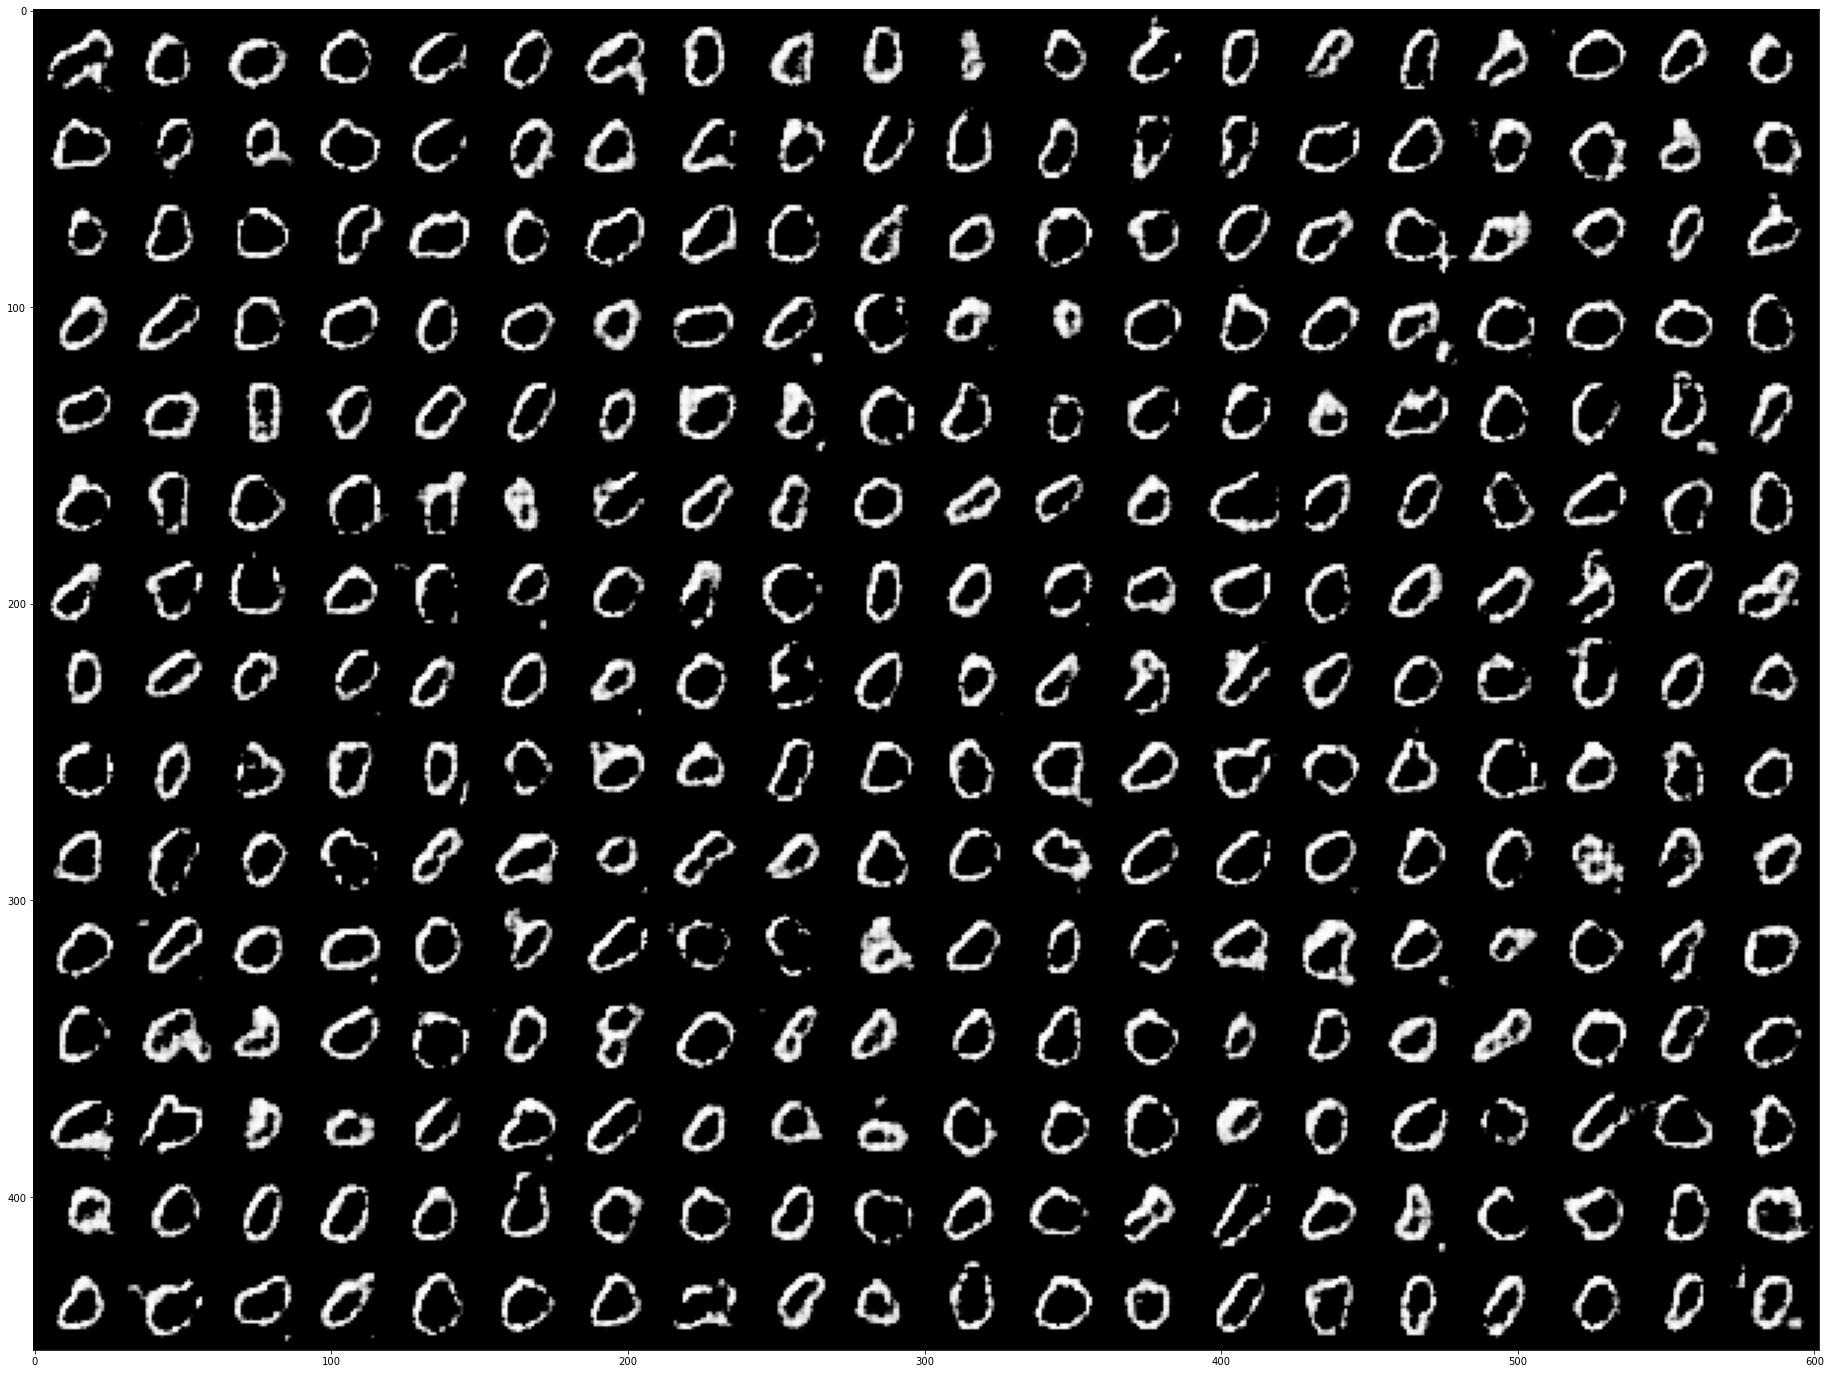

In [8]:
with torch.no_grad():
    test_z = Variable(torch.randn(300, z_dim).to(device))
    generated = G(test_z)
    #out0grid = torchvision.utils.make_grid(generated.view(generated.size(0), 1, 28, 28), nrow=20)
    out0grid = torchvision.utils.make_grid(generated, nrow=20)
    fig, ax = subplots(figsize=(32, 32))
    ax.imshow(out0grid.detach().permute(1, 2, 0).cpu())

In [ ]:
def zeroth_order_optim(D, criterion, x_fake, y_fake):
    criterion = nn.CrossEntropyLoss(reduction='none')
    #m = 5
    m = 19
    pre_x = True
    epsilon = 1e-7
    #criterion = nn.NLLLoss().to(gpu)
    with torch.no_grad():
        # Sample unit noise vector
        N = x_fake.size(0)
        C = x_fake.size(1)
        S = x_fake.size(2)
        dim = S**2 * C

        u = np.random.randn(N * m * dim).reshape(-1, m, dim) # generate random points from normal distribution

        d = np.sqrt(np.sum(u ** 2, axis = 2)).reshape(-1, m, 1)  # map to a uniform distribution on a unit sphere
        u = torch.Tensor(u / d).view(-1, m, C, S, S)
        u = torch.cat((u, torch.zeros(N, 1, C, S, S)), dim = 1) # Shape N, m + 1, S^2

            

        u = u.view(-1, m + 1, C, S, S)

        evaluation_points = (x_fake.view(-1, 1, C, S, S).cpu() + epsilon * u).view(-1, C, S, S)
        if pre_x: 
            evaluation_points = torch.tanh(evaluation_points) # Apply args.G_activation function
        # Compute the approximation sequentially to allow large values of m
        #print(f"{evaluation_points.size()}")
        
        x_b = evaluation_points.size(0)
        y_b = y_fake.size(0)
        y_fake = y_fake.repeat(x_b//y_b)
        pred_victim = []
        max_number_points = 32*156  # Hardcoded value to split the large evaluation_points tensor to fit in GPU
        
        for i in (range(N * m // max_number_points + 1)): 
            pts = evaluation_points[i * max_number_points: (i+1) * max_number_points]
            #print(f"{pts.size()}")
            pts = pts.to(gpu)
            #print(f"pts: {pts.size()}")
            pred_victim_pts = D(pts).detach()
            pred_victim.append(pred_victim_pts)
            
        pred_victim = torch.cat(pred_victim, dim=0).to(gpu)
        u = u.to(gpu)
        #print(f"{pred_victim.size()}, {y_fake.size()}")
        #pred_victim -= pred_victim.mean(dim=1).view(-1, 1).detach()
        #print(f"{pred_victim.size()}")
        #pred_victim = F.log_softmax(pred_victim, dim=1)
        #print(pred_victim.size())
        
        #pred_victim = pred_victim.view(-1, 1).detach()
        #print(f"{pred_victim.size()}, {y_fake.size()}")
        D_fake_loss = criterion(pred_victim, y_fake)
        #print(D_fake_loss.size())
        #print(f"d_fake_loss: {D_fake_loss.size()}")
        D_fake_loss = D_fake_loss.view(-1, m + 1)
        #print(f"reshape: {D_fake_loss.size()}")
        # Compute difference following each direction
        differences = D_fake_loss[:, :-1] - D_fake_loss[:, -1].view(-1, 1)
        differences = differences.view(-1, m, 1, 1, 1)

        # Formula for Forward Finite Differences
        gradient_estimates = 1 / epsilon * differences * u[:, :-1]
        gradient_estimates *= dim   
        gradient_estimates = gradient_estimates.mean(dim = 1).view(-1, C, S, S)
        loss_G = D_fake_loss[:, -1].mean()
        return gradient_estimates.detach(), loss_G
